# Índice <a id="indice"></a>

1. [Introdução](#introducao)  
2. [Importações e Setup](#importacoes)  
3. [Exploração dos Dados Tabulares](#exploracao)  
   - [3.1. Nodule Counts by Patient](#nodulecounts)  
   - [3.2. Patient Diagnoses](#diagnoses)  
4. [Análise dos Datasets mais Relevantes](#analise)  
   - [4.1. Radiologist Annotations](#annotations)  
   - [4.2. DICOM Images](#dicom)  
   - [4.3. Justificação do uso de um dataset derivado](#justificacao)  
5. [Criação de um Dataset a partir dos Selecionados](#criacao)  
   - [5.1. Merge: 'Nodule Counts by Patient.csv' x 'MainDataset.csv'](#merge)  
   - [5.2. Definição da Classe Alvo (Malignancy Label)](#classealvo)  
6. [Pré-Processamento das Imagens](#preprocessamento)  
   - [6.1. Criação das funções necessárias](#funcoes_preprocessamento)  
   - [6.2. Visualização CT + Máscara](#visualizacao_ct_mask)  
   - [6.3. Extração das Radiomic Features](#radiomics)  
7. [Tratamento de Dados](#tratamento)  
8. [Merge Final: 'final_features_2/3D.csv' x 'final.csv'](#mergefinal)  
   - [8.1 Preparação dos datasets de teste/treino](#testpreparation)
   - [8.2 Normalização do dataset de treino com Z-Score](#zscore)
9.  [Feature Selection](#featureselection)
       - [9.1. LASSO](#lasso)
       - [9.2. RFE](#rfe)
       - [9.3. SVM](#svm)
10.  [Modelos ML](#modelos)
        - [10.1. Random Forest](#randomforest)
           - [10.1.1. Random Forest sem feature selection](#rfsem)
           - [10.1.2. Random Forest com diferentes conjuntos de features](#rffeatures)
           - [10.1.3. Resultados Random Forest](#rfresultados)
        - [10.2. XGBoost](#xgboost)
            - [10.2.1. XGBoost sem feature selection](#xgboostsem)
            - [10.2.2. XGBoost com diferentes conjuntos de features](#xgboostfeatures)
            - [10.2.3. Resultados XGBoost](#xgboostresultados)
        - [10.3. SVM](#svm_ml)
            - [10.3.1. SVM sem feature selection](#svm_mlsem)
            - [10.3.2. SVM com diferentes conjuntos de features](#svm_mlfeatures)
            - [10.3.3. Resultados SVM](#svm_mlresultados)
11. [Comparação de Modelos e Conjuntos de Features](#comparaçao)
    - [11.1. Justificação de juntar todos os resultados num único DataFrame](#unico_df)
    - [11.2. Comparação entre Modelos por Método](#modelos_p_metodo)
    - [11.3. Comparação entre Métodos por Modelo](#metodos_p_modelo)
    - [11.4. Comparação entre 2D e 3D](#2d_vs_3d)
12. [Conclusões Finais](#conclusao)



# 1. Introdução <a id="introducao"></a>

[Voltar ao Índice](#indice)

#### O cancro do pulmão é atualmente uma das principais causas de mortalidade a nível mundial. A sua elevada taxa de letalidade está associada, em grande parte, às dificuldades na deteção precoce, uma vez que o diagnóstico requer a análise detalhada de exames de imagem. Entre estes, a tomografia computorizada (CT) destaca-se como uma das ferramentas mais relevantes, permitindo a identificação de nódulos pulmonares. Contudo, a interpretação manual destes exames depende fortemente da experiência do especialista e pode estar sujeita a erros ou atrasos.

#### Neste contexto, a aplicação de técnicas de Inteligência Artificial (IA) surge como uma abordagem promissora para auxiliar os profissionais de saúde no processo de diagnóstico. Modelos baseados em IA permitem não apenas automatizar a análise das imagens, mas também aumentar a precisão e consistência na deteção e caracterização dos nódulos.

#### O presente trabalho tem como objetivo a classificação de nódulos pulmonares recorrendo a dados de tomografia computorizada, utilizando o dataset **LIDC-IDRI**, disponibilizado em The Cancer Imaging Archive](https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI. Serão exploradas metodologias de análise e pré-processamento de dados, bem como diferentes algoritmos de classificação. Por fim, os resultados obtidos serão comparados, de forma a avaliar a eficácia das abordagens adotadas e identificar os modelos mais adequados para este tipo de problema.


#### O dataset **LIDC-IDRI** é composto por quatro partes principais:

- **CT Images (DICOM)**: imagens brutas de tomografia.
- **Radiologist Annotations (XML/ZIP)**: segmentações e marcações de nódulos.
- **Nodule Counts by Patient (XLSX)**: número de nódulos anotados por paciente.
- **Patient Diagnoses (XLS)**: diagnósticos clínicos (benigno/maligno).

#### **Objetivo**: caracterizar a base de dados e entender como cada parte pode ser usada, preparando terreno para modelação futura.

# 2. Importações e Setup <a id="importacoes"></a>

[Voltar ao Índice](#indice)

In [2]:
import seaborn as sns
import csv
import pylidc as pl
import numpy as np; np.int=int
import matplotlib.pyplot as plt
#import SimpleITK as sitk
import pandas as pd
import os
import sklearn
import shutil

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from skimage import measure
from skimage.transform import resize
from radiomics import featureextractor
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, log_loss)


C:\Users\leono\anaconda3\envs\radiomics\lib\site-packages\pylidc\__init__.py:27: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as _pr

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\leono\anaconda3\envs\radiomics\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\leono\anaconda3

AttributeError: _ARRAY_API not found

Error loading C extensions
Traceback (most recent call last):
  File "C:\Users\leono\anaconda3\envs\radiomics\lib\site-packages\radiomics\__init__.py", line 286, in <module>
    from radiomics import _cmatrices as cMatrices  # noqa: F401
ImportError: numpy.core.multiarray failed to import


ImportError: numpy.core.multiarray failed to import

# 3. Exploração dos Dados Tabulares <a id="exploracao"></a>

[Voltar ao Índice](#indice)

## 3.1 Nodule Counts by Patient <a id="nodulecounts"><a/>

[Voltar a Exploração dos Dados Tabulares](#exploracao)

#### Este dataset fornece um resumo quantitativo dos nódulos pulmonares identificados em cada paciente da base LIDC-IDRI. Para cada caso, são apresentados o número total de nódulos, bem como a distribuição entre nódulos com diâmetro igual ou superior a 3mm — considerados mais relevantes do ponto de vista clínico — e nódulos com diâmetro inferior a 3mm, que, apesar de menos suspeitos, contribuem para uma caracterização mais completa da condição pulmonar.

#### É particularmente útil para análises estatísticas iniciais, ajudando a compreender a prevalência e a carga de nódulos pulmonares no conjunto de exames, bem como para contextualizar os restantes datasets mais detalhados.

In [3]:
df_nod = pd.read_excel("lidc-idri-nodule-counts-6-23-2015.xlsx")
df_nod.head()

TCIA Patent ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
0  LIDC-IDRI-0001                          4                          1   
1  LIDC-IDRI-0002                         12                          1   
2  LIDC-IDRI-0003                          4                          4   
3  LIDC-IDRI-0004                          4                          1   
4  LIDC-IDRI-0005                          9                          3   

   Number of Nodules <3mm***  Unnamed: 4  \
0                          3         NaN   
1                         11         NaN   
2                          0         NaN   
3                          3         NaN   
4                          6         NaN   

                                          Unnamed: 5  
0                                                NaN  
1  *total number of lesions that received either ...  
2  **total number of lesions that received a "nod...  
3  ***total number of lesions that received a "no...  
4                                                NaN

In [4]:
print(df_nod.columns)

Index(['TCIA Patent ID', 'Total Number of Nodules* ',
       'Number of Nodules >=3mm**', 'Number of Nodules <3mm***', 'Unnamed: 4',
       'Unnamed: 5'],
      dtype='object')


In [5]:
df_nod.isna().sum()

TCIA Patent ID                  1
Total Number of Nodules*        0
Number of Nodules >=3mm**       0
Number of Nodules <3mm***       0
Unnamed: 4                   1019
Unnamed: 5                   1016
dtype: int64

#### **=> Devido à ausência de nomes nas duas últimas colunas e ao facto de estas apresentarem maioritariamente valores NaN, optou-se pela sua eliminação.**

In [6]:
df_nod = df_nod.drop(df_nod.columns[-2:], axis=1)

In [7]:
df_nod.head()

TCIA Patent ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
0  LIDC-IDRI-0001                          4                          1   
1  LIDC-IDRI-0002                         12                          1   
2  LIDC-IDRI-0003                          4                          4   
3  LIDC-IDRI-0004                          4                          1   
4  LIDC-IDRI-0005                          9                          3   

   Number of Nodules <3mm***  
0                          3  
1                         11  
2                          0  
3                          3  
4                          6

In [8]:
df_nod["Total Number of Nodules* "].describe()

count    1019.000000
mean       14.467125
std       230.832409
min         0.000000
25%         3.000000
50%         5.000000
75%         9.000000
max      7371.000000
Name: Total Number of Nodules* , dtype: float64

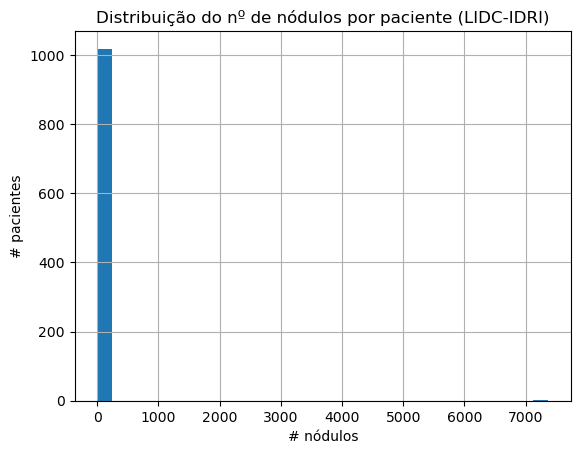

In [9]:
col_nod = "Total Number of Nodules* "

df_nod[col_nod].hist(bins=30)
plt.title("Distribuição do nº de nódulos por paciente (LIDC-IDRI)")
plt.xlabel("# nódulos")
plt.ylabel("# pacientes")
plt.show()

In [10]:
df_nod.tail()

TCIA Patent ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
1014  LIDC-IDRI-1009                          2                          1   
1015  LIDC-IDRI-1010                         10                          1   
1016  LIDC-IDRI-1011                          4                          4   
1017  LIDC-IDRI-1012                          1                          1   
1018             NaN                       7371                       2669   

      Number of Nodules <3mm***  
1014                          1  
1015                          9  
1016                          0  
1017                          0  
1018                       4702

#### **=> Segundo a informação do dataset, a última linha corresponde à soma total dos valores das colunas, logo também se eliminou.**

In [11]:
df_nod = df_nod.drop(df_nod.index[-1])

In [12]:
df_nod.tail()

TCIA Patent ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
1013  LIDC-IDRI-1008                          7                          6   
1014  LIDC-IDRI-1009                          2                          1   
1015  LIDC-IDRI-1010                         10                          1   
1016  LIDC-IDRI-1011                          4                          4   
1017  LIDC-IDRI-1012                          1                          1   

      Number of Nodules <3mm***  
1013                          1  
1014                          1  
1015                          9  
1016                          0  
1017                          0

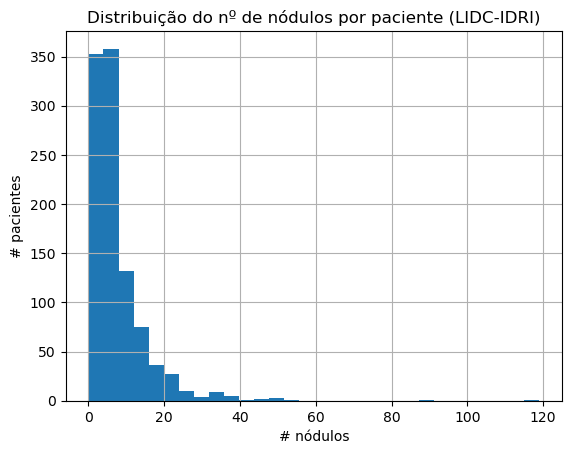

In [13]:
col_nod = "Total Number of Nodules* "

df_nod[col_nod].hist(bins=30)
plt.title("Distribuição do nº de nódulos por paciente (LIDC-IDRI)")
plt.xlabel("# nódulos")
plt.ylabel("# pacientes")
plt.show()

#### **PROBLEMA!**

**=> É de notar que, apesar dos 1010 pacientes, há um total de 1017 linhas. Conclui-se, portanto, que há valores duplicados. Quais? E como tratá-los?**

In [14]:
df_nod[df_nod["TCIA Patent ID"].duplicated(keep=False)]

TCIA Patent ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
131  LIDC-IDRI-0132                         14                          6   
132  LIDC-IDRI-0132                         12                          8   
151  LIDC-IDRI-0151                          3                          1   
152  LIDC-IDRI-0151                          7                          1   
315  LIDC-IDRI-0315                         13                          7   
316  LIDC-IDRI-0315                          8                          5   
333  LIDC-IDRI-0332                          6                          5   
334  LIDC-IDRI-0332                          3                          2   
357  LIDC-IDRI-0355                          4                          1   
358  LIDC-IDRI-0355                          3                          2   
368  LIDC-IDRI-0365                          8                          1   
369  LIDC-IDRI-0365                          5                          1   
446  LIDC-IDRI-0442                          4                          3   
447  LIDC-IDRI-0442                          3                          3   
489  LIDC-IDRI-0484                         33                          2   
490  LIDC-IDRI-0484                          4                          2   

     Number of Nodules <3mm***  
131                          8  
132                          4  
151                          2  
152                          6  
315                          6  
316                          3  
333                          1  
334                          1  
357                          3  
358                          1  
368                          7  
369                          4  
446                          1  
447                          0  
489                         31  
490                          2

**=> Para identificar quais entradas representavam os valores corretos, foi necessário recorrer ao dataset original (LIDC-IDRI) e verificar o número de nódulos (considerando apenas os de dimensão ≥ 3mm) associado a cada paciente. Como cada scan foi avaliado de forma independente por quatro radiologistas, o ficheiro agregado apresenta, naturalmente, inconsistências e duplicações.**

**=> Para resolver este problema, desenvolveu-se um procedimento que compara o número de nódulos registado no Excel com o número de nódulos obtido através do pylidc (consenso via 'cluster_annotations'). Assim, para cada paciente com duplicados, apenas a linha que corresponde ao valor real foi mantida, eliminando-se as restantes. Nos casos em que não existe correspondência direta, o registo foi mantido, mas assinalado como potencial discrepância.**

In [15]:
pid = ["LIDC-IDRI-0132","LIDC-IDRI-0151","LIDC-IDRI-0315","LIDC-IDRI-0332","LIDC-IDRI-0355","LIDC-IDRI-0365","LIDC-IDRI-0442","LIDC-IDRI-0484"]

for i in range(len(pid)):
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid[i]).first()
    
    # contar nódulos (cada nódulo pode ter várias anotações → agrupamos)
    nods = scan.cluster_annotations()
    
    print(f"Paciente {pid[i]} tem {len(nods)} nódulos.")


Paciente LIDC-IDRI-0132 tem 6 nódulos.
Paciente LIDC-IDRI-0151 tem 1 nódulos.
Paciente LIDC-IDRI-0315 tem 7 nódulos.
Paciente LIDC-IDRI-0332 tem 2 nódulos.
Paciente LIDC-IDRI-0355 tem 1 nódulos.
Paciente LIDC-IDRI-0365 tem 1 nódulos.
Paciente LIDC-IDRI-0442 tem 3 nódulos.
Paciente LIDC-IDRI-0484 tem 2 nódulos.


In [16]:
def clean_duplicates_with_pylidc(df, col="Number of Nodules >=3mm**"):
    df = df.copy()
    df[col] = pd.to_numeric(df[col], errors="coerce")

    # identificar duplicados
    dup_ids = df[df.duplicated(subset=["TCIA Patent ID"], keep=False)]["TCIA Patent ID"].unique()

    rows_to_drop = []

    for pid in dup_ids:
        scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
        if scan is None:
            continue

        # número de nódulos consenso via pylidc
        true_nodules = len(scan.cluster_annotations())

        # linhas desse paciente no Excel
        mask = df["TCIA Patent ID"] == pid
        subset = df[mask]

        # marcar para remoção
        correct_mask = subset[col] == true_nodules

        if correct_mask.sum() == 1:
            # só uma linha correta → eliminar as outras
            rows_to_drop.extend(subset[~correct_mask].index.tolist())

        elif correct_mask.sum() > 1:
            # empate → remover a primeira ocorrência
            idx_to_drop = subset[correct_mask].index[0]
            rows_to_drop.append(idx_to_drop)

        else:
            # nenhuma corresponde → manter mas avisar
            print(f"Aviso: Nenhuma linha corresponde ao pylidc para {pid} (Excel={list(subset[col])}, pylidc={true_nodules})")

    # eliminar duplicatas inválidas
    df_clean = df.drop(index=rows_to_drop).reset_index(drop=True)
    return df_clean
    
df_nod = clean_duplicates_with_pylidc(df_nod)

In [17]:
df_nod[df_nod["TCIA Patent ID"].duplicated(keep=False)]

Empty DataFrame
Columns: [TCIA Patent ID, Total Number of Nodules* , Number of Nodules >=3mm**, Number of Nodules <3mm***]
Index: []

In [18]:
df_nod[df_nod["TCIA Patent ID"].duplicated(keep=False)]

Empty DataFrame
Columns: [TCIA Patent ID, Total Number of Nodules* , Number of Nodules >=3mm**, Number of Nodules <3mm***]
Index: []

#### **Dados desnecessários:**
**=> Pacientes sem nódulos ou sem nódulos >= 3mm (uma vez que só esses é que estão registados no dataset original).**

In [19]:
df_nod[df_nod["Total Number of Nodules* "] == 0]

TCIA Patent ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
304  LIDC-IDRI-0306                          0                          0   
305  LIDC-IDRI-0307                          0                          0   
320  LIDC-IDRI-0322                          0                          0   
362  LIDC-IDRI-0364                          0                          0   
439  LIDC-IDRI-0441                          0                          0   
504  LIDC-IDRI-0506                          0                          0   
538  LIDC-IDRI-0540                          0                          0   
562  LIDC-IDRI-0564                          0                          0   
571  LIDC-IDRI-0573                          0                          0   
609  LIDC-IDRI-0612                          0                          0   
665  LIDC-IDRI-0668                          0                          0   
686  LIDC-IDRI-0689                          0                          0   
713  LIDC-IDRI-0716                          0                          0   
728  LIDC-IDRI-0731                          0                          0   
757  LIDC-IDRI-0760                          0                          0   
884  LIDC-IDRI-0887                          0                          0   
897  LIDC-IDRI-0900                          0                          0   
934  LIDC-IDRI-0937                          0                          0   
972  LIDC-IDRI-0975                          0                          0   
992  LIDC-IDRI-0995                          0                          0   

     Number of Nodules <3mm***  
304                          0  
305                          0  
320                          0  
362                          0  
439                          0  
504                          0  
538                          0  
562                          0  
571                          0  
609                          0  
665                          0  
686                          0  
713                          0  
728                          0  
757                          0  
884                          0  
897                          0  
934                          0  
972                          0  
992                          0

In [20]:
df_nod[df_nod["Number of Nodules >=3mm**"] == 0]

TCIA Patent ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
27   LIDC-IDRI-0028                          1                          0   
31   LIDC-IDRI-0032                          3                          0   
61   LIDC-IDRI-0062                          1                          0   
70   LIDC-IDRI-0071                          4                          0   
99   LIDC-IDRI-0100                          1                          0   
..              ...                        ...                        ...   
972  LIDC-IDRI-0975                          0                          0   
976  LIDC-IDRI-0979                          4                          0   
985  LIDC-IDRI-0988                          1                          0   
989  LIDC-IDRI-0992                          1                          0   
992  LIDC-IDRI-0995                          0                          0   

     Number of Nodules <3mm***  
27                           1  
31                           3  
61                           1  
70                           4  
99                           1  
..                         ...  
972                          0  
976                          4  
985                          1  
989                          1  
992                          0  

[135 rows x 4 columns]

In [21]:
df_nod = df_nod.loc[~((df_nod["Total Number of Nodules* "] == 0) | (df_nod["Number of Nodules >=3mm**"] == 0))]

In [22]:
df_nod

TCIA Patent ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
0     LIDC-IDRI-0001                          4                          1   
1     LIDC-IDRI-0002                         12                          1   
2     LIDC-IDRI-0003                          4                          4   
3     LIDC-IDRI-0004                          4                          1   
4     LIDC-IDRI-0005                          9                          3   
...              ...                        ...                        ...   
1005  LIDC-IDRI-1008                          7                          6   
1006  LIDC-IDRI-1009                          2                          1   
1007  LIDC-IDRI-1010                         10                          1   
1008  LIDC-IDRI-1011                          4                          4   
1009  LIDC-IDRI-1012                          1                          1   

      Number of Nodules <3mm***  
0                             3  
1                            11  
2                             0  
3                             3  
4                             6  
...                         ...  
1005                          1  
1006                          1  
1007                          9  
1008                          0  
1009                          0  

[875 rows x 4 columns]

In [23]:
df_nod["TCIA Patent ID"].nunique()

875

## 3.2 Patient Diagnoses <a id="diagnoses"><a/>

[Voltar a Exploração dos Dados Tabulares](#exploracao)

#### Este dataset contém informação clínica associada ao diagnóstico de cada paciente e, quando disponível, de cada nódulo individual. Os diagnósticos estão organizados em dois níveis:

- **Nível do paciente**: o diagnóstico é associado ao indivíduo no seu conjunto.  
- **Nível do nódulo**: o diagnóstico é associado a cada lesão específica, sempre que os dados estão disponíveis.  

#### Cada registo pode assumir diferentes categorias, incluindo:  
- **Desconhecido**: quando não existem dados disponíveis.  
- **Benigno / doença não maligna**.  
- **Maligno (cancro do pulmão primário)**.  
- **Lesão metastática** associada a um tumor primário extra-torácico.

In [24]:
df_diag = pd.read_excel("tcia-diagnosis-data-2012-04-20.xls")
df_diag.head()

TCIA Patient ID  \
0  LIDC-IDRI-0068   
1  LIDC-IDRI-0071   
2  LIDC-IDRI-0072   
3  LIDC-IDRI-0088   
4  LIDC-IDRI-0090   

   Diagnosis at the Patient Level\n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic\n  \
0                                                  3                                                                                             
1                                                  3                                                                                             
2                                                  2                                                                                             
3                                                  3                                                                                             
4                                                  2                                                                                             

   Diagnosis Method\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response  \
0                                                  4                                                                                                                    
1                                                  1                                                                                                                    
2                                                  4                                                                                                                    
3                                                  0                                                                                                                    
4                                                  3                                                                                                                    

  Primary tumor site for metastatic disease  \
0                        Head & Neck Cancer   
1                              Head & Neck    
2                               Lung Cancer   
3                            Uterine Cancer   
4                                     NSCLC   

   Nodule 1\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n  \
0                                                3.0                                                                                                        
1                                                1.0                                                                                                        
2                                                1.0                                                                                                        
3                                                0.0                                                                                                        
4                                                2.0                                                                                                        

   Nodule 1\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n  \
0                                                4.0                                                                                                                                                    
1                                                1.0                                                                                                                                                    
2                                                4.0                                                                                                      

In [25]:
df_nod["TCIA Patent ID"].nunique()

875

In [26]:
df_diag.columns

Index(['TCIA Patient ID',
       'Diagnosis at the Patient Level\n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic\n',
       'Diagnosis Method\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response',
       'Primary tumor site for metastatic disease',
       'Nodule 1\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n',
       'Nodule 1\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n',
       'Nodule 2\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n',
       'Nodule 2\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 =

In [27]:
df_diag.columns = [
    "Patient_ID",
    "Diagnosis_at_Patient_Level",
    "Diagnosis_Method_Patient",
    "Primary_Tumor_Site_Metastatic",
    "Nodule1_Diagnosis",
    "Nodule1_Diagnosis_Method",
    "Nodule2_Diagnosis",
    "Nodule2_Diagnosis_Method",
    "Nodule3_Diagnosis",
    "Nodule3_Diagnosis_Method",
    "Nodule4_Diagnosis",
    "Nodule4_Diagnosis_Method",
    "Nodule5_Diagnosis",
    "Nodule5_Diagnosis_Method"
]

In [28]:
df_diag.tail()

Patient_ID  Diagnosis_at_Patient_Level  Diagnosis_Method_Patient  \
152  LIDC-IDRI-0994                           2                         3   
153  LIDC-IDRI-1002                           2                         2   
154  LIDC-IDRI-1004                           2                         3   
155  LIDC-IDRI-1010                           0                         0   
156  LIDC-IDRI-1011                           3                         2   

          Primary_Tumor_Site_Metastatic  Nodule1_Diagnosis  \
152                   LUL Large cell CA                2.0   
153            non-small cell carcinoma                NaN   
154                           LUL NSCLC                2.0   
155                            lymphoma                0.0   
156  small-cell carcinoma of the tongue                3.0   

     Nodule1_Diagnosis_Method  Nodule2_Diagnosis  Nodule2_Diagnosis_Method  \
152                       3.0                NaN                       NaN   
153                       NaN                NaN                       NaN   
154                       3.0                NaN                       NaN   
155                       0.0                NaN                       NaN   
156                       2.0                3.0                       4.0   

    Nodule3_Diagnosis Nodule3_Diagnosis_Method  Nodule4_Diagnosis  \
152               NaN                      NaN                NaN   
153               NaN                      NaN                NaN   
154               NaN                      NaN                NaN   
155               NaN                      NaN                NaN   
156               NaN                      NaN                NaN   

     Nodule4_Diagnosis_Method  Nodule5_Diagnosis  Nodule5_Diagnosis_Method  
152                       NaN                NaN                       NaN  
153                       NaN                NaN                       NaN  
154                       NaN                NaN                       NaN  
155                       NaN                NaN                       NaN  
156                       NaN                NaN                       NaN

In [29]:
print(df_diag.isna().sum())

Patient_ID                         0
Diagnosis_at_Patient_Level         0
Diagnosis_Method_Patient           0
Primary_Tumor_Site_Metastatic      0
Nodule1_Diagnosis                 20
Nodule1_Diagnosis_Method          20
Nodule2_Diagnosis                137
Nodule2_Diagnosis_Method         137
Nodule3_Diagnosis                156
Nodule3_Diagnosis_Method         156
Nodule4_Diagnosis                157
Nodule4_Diagnosis_Method         157
Nodule5_Diagnosis                157
Nodule5_Diagnosis_Method         157
dtype: int64


#### **=> A maioria das entradas relativas aos nódulos 1,2,3,4 e 5 estão como NaN. Podemos concluir que a qualidade de dados deste dataset não é boa.**

In [30]:
df_diag["Patient_ID"].nunique()

157

#### **=> Adicionalmente, o estudo foi conduzido sobre um conjunto reduzido de casos, o que se traduz em apenas 157 entradas, apesar da base inicial conter 1010 pacientes.**

### CONCLUSÃO: 
**O Dataset 'Patient Diagnoses' NÃO será usado para este estudo.**

# 4. Análise dos Datasets mais Relevantes <a id="analise"><a/>

[Voltar ao Índice](#indice)

## 4.1 Radiologist Annotations <a id="annotations"><a/>

[Voltar a Análise dos Datasets mais Relevantes](#analise)

#### Este dataset contém as anotações originais realizadas por quatro radiologistas sobre cada exame de tomografia do LIDC-IDRI. Cada especialista avaliou os nódulos de forma independente, fornecendo informações detalhadas sobre as suas características, tais como dimensão, localização e atributos visuais. Estas anotações, armazenadas em ficheiros XML, constituem a base para a criação de datasets derivados, como o das contagens de nódulos e o das classificações de malignidade, permitindo a comparação entre leituras individuais e a construção de consensos.

In [10]:
# Pega no primeiro scan
scan = pl.query(pl.Scan).first()

# Pega os nódulos anotados
nodules = scan.cluster_annotations()

# Explora a primeira anotação do primeiro nódulo
anotacao = nodules[0][0]

# Lista todos os atributos disponíveis
print(dir(anotacao))


['Calcification', 'InternalStructure', 'Lobulation', 'Malignancy', 'Margin', 'Sphericity', 'Spiculation', 'Subtlety', 'Texture', '__abstract__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__mapper__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__table__', '__tablename__', '__weakref__', '_as_set', '_nodule_id', '_sa_class_manager', '_sa_instance_state', '_sa_registry', 'bbox', 'bbox_dims', 'bbox_matrix', 'boolean_mask', 'calcification', 'centroid', 'contour_slice_indices', 'contour_slice_zvals', 'contours', 'contours_matrix', 'diameter', 'feature_vals', 'id', 'internalStructure', 'lobulation', 'malignancy', 'margin', 'metadata', 'print_formatted_feature_table', 'registry', 'scan', 'scan_id', 'sphericity', 'spiculation', 'subtlety', 'surface_area

## 4.2 DICOM Images <a id="dicom"><a/>

[Voltar a Análise dos Datasets mais Relevantes](#analise)

#### Corresponde ao conjunto completo de exames de tomografia computadorizada (CT) dos pacientes incluídos no LIDC-IDRI. Cada estudo está armazenado em formato DICOM (Digital Imaging and Communications in Medicine), o padrão internacional para imagens médicas. Este dataset reúne aproximadamente 1.010 casos, totalizando mais de 133 GB de dados, que incluem séries de imagens torácicas utilizadas para a deteção e caracterização de nódulos pulmonares. Estas imagens constituem a base essencial para as anotações dos radiologistas e para a utilização de métodos computacionais e modelos de Inteligência Artificial aplicados à análise e classificação de nódulos.

In [9]:
scan = pl.query(pl.Scan).first()
print(dir(scan))

['__abstract__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__mapper__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__table__', '__tablename__', '__weakref__', '_sa_class_manager', '_sa_instance_state', '_sa_registry', 'annotations', 'cluster_annotations', 'contrast_used', 'get_path_to_dicom_files', 'id', 'is_from_initial', 'load_all_dicom_images', 'metadata', 'patient_id', 'pixel_spacing', 'registry', 'series_instance_uid', 'slice_spacing', 'slice_thickness', 'slice_zvals', 'sorted_dicom_file_names', 'spacings', 'study_instance_uid', 'to_volume', 'visualize', 'zvals']


#### Antes de realizar o pré-processamento e extração de features, foi necessário analisar a estrutura do dataset DICOM e selecionar apenas as séries correspondentes a exames de Tomografia Computorizada (CT). O dataset LIDC-IDRI contém diversos tipos de imagens médicas (por exemplo, radiografias, imagens secundárias, etc.), e apenas as séries CT são relevantes para este estudo.

#### Para automatizar essa separação, foi criada a seguinte função:

In [ ]:
def is_ct_series(folder_path):
    """
    Verifica se uma pasta contém ficheiros DICOM com Modality = 'CT'.
    Basta encontrar um ficheiro CT para considerar toda a série como CT.
    """
    for f in os.listdir(folder_path):
        if f.lower().endswith(".dcm"):
            try:
                ds = pydicom.dcmread(os.path.join(folder_path, f), stop_before_pixels=True)
                if getattr(ds, "Modality", None) == "CT":
                    return True
            except Exception:
                continue
    return False


def filtrar_series_ct(root_dir, destino_xray="Xray_Others", csv_saida="ct_series.csv"):
    """
    Percorre todas as pastas do dataset e separa CTs de não-CTs.
    Guarda a lista de CTs num CSV e move as outras para uma pasta separada.
    """
    ct_series = []
    os.makedirs(destino_xray, exist_ok=True)

    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Verifica se há ficheiros DICOM nesta pasta
        if any(f.lower().endswith(".dcm") for f in filenames):
            if is_ct_series(dirpath):
                ct_series.append(dirpath)
            else:
                # mover pasta não-CT
                destino = os.path.join(destino_xray, os.path.basename(dirpath))
                print(f"Pasta não-CT movida: {dirpath} → {destino}")
                try:
                    shutil.move(dirpath, destino)
                except Exception as e:
                    print(f"Erro ao mover {dirpath}: {e}")

    # guardar lista de CTs num CSV
    with open(csv_saida, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["CT_Series_Path"])
        for p in ct_series:
            writer.writerow([p])

    print(f"\nTotal de séries CT: {len(ct_series)}")
    print(f"Lista guardada em: {csv_saida}")
    print(f"Séries não-CT movidas para: {destino_xray}")


if __name__ == "__main__":
    root_dir = r"C:\Users\Admin\Desktop\lung-cancer-classification-main\manifest-1585232716547\LIDC-IDRI"  # caminho base do dataset (Leonor Baía)
    filtrar_series_ct(root_dir)

## 4.3 Justificação do uso de um dataset derivado <a id="justificacao"><a/>

[Voltar a Análise dos Datasets mais Relevantes](#analise)

#### O dataset original de imagens médicas (≈133 GB) encontra-se em formato DICOM, contendo todas as tomografias computadorizadas (CT) dos pacientes. Apesar de ser essencial, o tamanho e a estrutura bruta (milhares de slices em DICOM) tornam inviável realizar a análise exploratória diretamente em Pandas ou Numpy.

#### Além disso, as anotações dos radiologistas encontram-se em ficheiros XML/ZIP, separados das imagens, o que dificulta a integração direta. Por esta razão, optámos por gerar um dataset derivado em CSV, recorrendo à biblioteca pylidc no notebook "MainDataset", que nos permitiu:

- Ler e agrupar as anotações de nódulos.

- Extrair atributos clínicos (malignidade, textura, margens, etc.).

- Associar metadados dos CTs (slice thickness, pixel spacing, series UID).

#### Este ficheiro (MainDataset.csv) concentra a informação relevante para análise estatística e machine learning, reduzindo drasticamente o tamanho e a complexidade dos dados.

In [11]:
def gerar_csv():
    # Obtém todos os scans disponíveis
    scans = pl.query(pl.Scan).all()
    
    if not scans:
        print("Nenhum scan foi encontrado. Verifique se o caminho para o dataset está correto.")
        return
    
    # Cria o arquivo CSV para escrita com codificação UTF-8
    with open('MainDataset.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # Escreve o cabeçalho do CSV
        writer.writerow([
            'Patient ID', 'Number of Nodules', 'Nodule ID', 'Number of Annotations',
            'Spiculation', 'Lobulation', 'Sphericity', 
            'Margin', 'Subtlety', 'Texture', 'Calcification',
            'Malignancy', 'Internal Structure', 'Error Clustering',
            'Study Instance UID', 'Series Instance UID',
            'Slice Thickness (mm)', 'Pixel Spacing', 'Contrast Used'
        ])
        
        # Percorre cada scan para obter as anotações
        for scan in scans:
            # Obtém os nódulos anotados para o scan
            nodules = scan.cluster_annotations()
            num_nodules = len(nodules)

            # Coleta os metadados do scan
            patient_id = scan.patient_id
            study_instance_uid = scan.study_instance_uid
            series_instance_uid = scan.series_instance_uid
            slice_thickness = scan.slice_thickness
            pixel_spacing = scan.pixel_spacing
            contrast_used = scan.contrast_used
            
            # Verifica se existem nódulos
            if num_nodules == 0:
                writer.writerow([
                    patient_id, 0, None, 0, None, None, None, 
                    None, None, None, None, None, None, 'Sim',
                    study_instance_uid, series_instance_uid,
                    slice_thickness, pixel_spacing, contrast_used
                ])
            else:
                # Percorre cada nódulo e escreve seus detalhes no CSV
                for idx, nodule in enumerate(nodules):
                    # Número de anotações para o nódulo
                    num_annotations = len(nodule)
                    # Verifica se o agrupamento do nódulo tem mais de 4 anotações
                    error_cluster = 'Sim' if num_annotations > 4 else 'Não'
                    for note in nodule:
                        writer.writerow([
                            patient_id, num_nodules, idx + 1, num_annotations,
                            note.spiculation, note.lobulation, note.sphericity,
                            note.margin, note.subtlety, note.texture,
                            note.calcification, note.malignancy, note.internalStructure,
                            error_cluster, study_instance_uid, series_instance_uid,
                            slice_thickness, pixel_spacing, contrast_used
                        ])
    
    print("Arquivo 'MainDataset.csv' foi gerado com sucesso com codificação UTF-8.")

# Chama a função para gerar o CSV com detalhes, quantidade de anotações e indicação de erro
gerar_csv()

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some n

In [31]:
df_ext=pd.read_csv("MainDataset.csv")

In [32]:
df_ext.head()

Patient ID  Number of Nodules  Nodule ID  Number of Annotations  \
0  LIDC-IDRI-0078                  4        1.0                      4   
1  LIDC-IDRI-0078                  4        1.0                      4   
2  LIDC-IDRI-0078                  4        1.0                      4   
3  LIDC-IDRI-0078                  4        1.0                      4   
4  LIDC-IDRI-0078                  4        2.0                      4   

   Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
0          2.0         1.0         4.0     4.0       4.0      5.0   
1          1.0         2.0         4.0     2.0       4.0      5.0   
2          4.0         4.0         4.0     4.0       5.0      5.0   
3          2.0         2.0         4.0     3.0       5.0      4.0   
4          1.0         1.0         3.0     4.0       5.0      5.0   

   Calcification  Malignancy  Internal Structure Error Clustering  \
0            6.0         3.0                 1.0              Não   
1            6.0         4.0                 1.0              Não   
2            6.0         5.0                 1.0              Não   
3            6.0         3.0                 1.0              Não   
4            6.0         3.0                 1.0              Não   

                                  Study Instance UID  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277...   

                                 Series Instance UID  Slice Thickness (mm)  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...                   3.0   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...                   3.0   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...                   3.0   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...                   3.0   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...                   3.0   

   Pixel Spacing  Contrast Used  
0           0.65           True  
1           0.65           True  
2           0.65           True  
3           0.65           True  
4           0.65           True

In [33]:
df_ext["Patient ID"].nunique()

1010

In [34]:
df_ext.count()

Patient ID               6994
Number of Nodules        6994
Nodule ID                6859
Number of Annotations    6994
Spiculation              6859
Lobulation               6859
Sphericity               6859
Margin                   6859
Subtlety                 6859
Texture                  6859
Calcification            6859
Malignancy               6859
Internal Structure       6859
Error Clustering         6994
Study Instance UID       6994
Series Instance UID      6994
Slice Thickness (mm)     6994
Pixel Spacing            6994
Contrast Used            6994
dtype: int64

# 5. Criação de um Dataset a partir dos Selecionados <a id="criacao"><a/>

[Voltar ao Índice](#indice)

## 5.1 Merge: 'Nodule Counts by Patient.csv' x 'MainDataset.csv' <a id="merge"><a/>

[Voltar a Criação de um Dataset a partir dos Selecionados](#criacao)

#### Temos:
- Características a nível do nódulo (qualidade, forma, textura, malignidade anotada).
- Características a nível do paciente (quantidade total de nódulos).

#### **OBJETIVO:** criar um dataset enriquecido, que junta a perspetiva local (características individuais de cada nódulo) com a perspetiva global (quantos nódulos existem no paciente).

In [35]:
df_nod = df_nod.rename(columns={"TCIA Patent ID": "Patient ID"})

In [36]:
df_nod.columns

Index(['Patient ID', 'Total Number of Nodules* ', 'Number of Nodules >=3mm**',
       'Number of Nodules <3mm***'],
      dtype='object')

In [37]:
merge = pd.merge(df_nod, df_ext, on="Patient ID", how="inner")

In [38]:
merge

Patient ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
0     LIDC-IDRI-0001                          4                          1   
1     LIDC-IDRI-0001                          4                          1   
2     LIDC-IDRI-0001                          4                          1   
3     LIDC-IDRI-0001                          4                          1   
4     LIDC-IDRI-0002                         12                          1   
...              ...                        ...                        ...   
6854  LIDC-IDRI-1011                          4                          4   
6855  LIDC-IDRI-1012                          1                          1   
6856  LIDC-IDRI-1012                          1                          1   
6857  LIDC-IDRI-1012                          1                          1   
6858  LIDC-IDRI-1012                          1                          1   

      Number of Nodules <3mm***  Number of Nodules  Nodule ID  \
0                             3                  1        1.0   
1                             3                  1        1.0   
2                             3                  1        1.0   
3                             3                  1        1.0   
4                            11                  1        1.0   
...                         ...                ...        ...   
6854                          0                  4        4.0   
6855                          0                  1        1.0   
6856                          0                  1        1.0   
6857                          0                  1        1.0   
6858                          0                  1        1.0   

      Number of Annotations  Spiculation  Lobulation  Sphericity  ...  \
0                         4          4.0         3.0         3.0  ...   
1                         4          5.0         5.0         4.0  ...   
2                         4          3.0         3.0         3.0  ...   
3                         4          5.0         1.0         5.0  ...   
4                         2          1.0         1.0         5.0  ...   
...                     ...          ...         ...         ...  ...   
6854                      1          1.0         1.0         4.0  ...   
6855                      4          1.0         1.0         5.0  ...   
6856                      4          2.0         2.0         4.0  ...   
6857                      4          1.0         1.0         4.0  ...   
6858                      4          1.0         1.0         4.0  ...   

      Texture  Calcification  Malignancy  Internal Structure  \
0         5.0            6.0         5.0                 1.0   
1         5.0            6.0         5.0                 1.0   
2         5.0            6.0         5.0                 1.0   
3         4.0            6.0         4.0                 1.0   
4         1.0            6.0         5.0                 1.0   
...       ...            ...         ...                 ...   
6854      1.0            6.0         2.0                 1.0   
6855      1.0            6.0         2.0                 1.0   
6856      3.0            6.0         2.0                 1.0   
6857      5.0            6.0         2.0                 1.0   
6858      5.0            6.0         2.0                 1.0   

      Error Clustering                                 Study Instance UID  \
0                  Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
1                  Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
2                  Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
3                  Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
4                  Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...   
...                ...                                                ...   
6854               Não  1.3.6.1.4.1.14519.5.2.1.6279.6001.287560874054...   
6855               Não  1.3.6.

In [39]:
merge["Patient ID"].nunique()

875

#### **=> Uma vez já eliminados no dataset os dados dos nódulos dos casos desnecessários, apresentamos agora apenas 875 pacientes.**

In [40]:
merge["Number of Annotations"].nunique()

8

#### **Mais casos problemáticos:**
**=> Como só há 4 radiologistas, não faz sentido existirem mais que 4 anotações. Todos esses casos serão analisados e eliminados.**

In [41]:
merge[merge["Error Clustering"] == "Sim"]

Patient ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
488   LIDC-IDRI-0055                          9                          8   
489   LIDC-IDRI-0055                          9                          8   
490   LIDC-IDRI-0055                          9                          8   
491   LIDC-IDRI-0055                          9                          8   
492   LIDC-IDRI-0055                          9                          8   
...              ...                        ...                        ...   
6444  LIDC-IDRI-0942                          8                          5   
6445  LIDC-IDRI-0942                          8                          5   
6446  LIDC-IDRI-0942                          8                          5   
6447  LIDC-IDRI-0942                          8                          5   
6448  LIDC-IDRI-0942                          8                          5   

      Number of Nodules <3mm***  Number of Nodules  Nodule ID  \
488                           1                  7        1.0   
489                           1                  7        1.0   
490                           1                  7        1.0   
491                           1                  7        1.0   
492                           1                  7        1.0   
...                         ...                ...        ...   
6444                          3                  4        1.0   
6445                          3                  4        1.0   
6446                          3                  4        1.0   
6447                          3                  4        1.0   
6448                          3                  4        1.0   

      Number of Annotations  Spiculation  Lobulation  Sphericity  ...  \
488                       6          1.0         1.0         4.0  ...   
489                       6          2.0         2.0         3.0  ...   
490                       6          4.0         3.0         3.0  ...   
491                       6          2.0         3.0         4.0  ...   
492                       6          2.0         1.0         4.0  ...   
...                     ...          ...         ...         ...  ...   
6444                      7          3.0         2.0         3.0  ...   
6445                      7          3.0         2.0         3.0  ...   
6446                      7          2.0         1.0         4.0  ...   
6447                      7          3.0         4.0         5.0  ...   
6448                      7          3.0         4.0         5.0  ...   

      Texture  Calcification  Malignancy  Internal Structure  \
488       5.0            6.0         2.0                 1.0   
489       4.0            6.0         3.0                 1.0   
490       5.0            6.0         4.0                 1.0   
491       4.0            6.0         4.0                 1.0   
492       4.0            6.0         4.0                 1.0   
...       ...            ...         ...                 ...   
6444      4.0            6.0         5.0                 1.0   
6445      4.0            6.0         5.0                 1.0   
6446      5.0            6.0         5.0                 1.0   
6447      5.0            6.0         3.0                 1.0   
6448      5.0            6.0         3.0                 1.0   

      Error Clustering                                 Study Instance UID  \
488                Sim  1.3.6.1.4.1.14519.5.2.1.6279.6001.131383203689...   
489                Sim  1.3.6.1.4.1.14519.5.2.1.6279.6001.131383203689...   
490                Sim  1.3.6.1.4.1.14519.5.2.1.6279.6001.131383203689...   
491                Sim  1.3.6.1.4.1.14519.5.2.1.6279.6001.131383203689...   
492                Sim  1.3.6.1.4.1.14519.5.2.1.6279.6001.131383203689...   
...                ...                                                ...   
6444               Sim  1.3.6.1.4.1.14519.5.2.1.6279.6001.185621295429...   
6445               Sim  1.3.6.

In [42]:
merge = merge.loc[merge["Error Clustering"] != "Sim"]

In [43]:
merge[merge["Error Clustering"] == "Sim"]

Empty DataFrame
Columns: [Patient ID, Total Number of Nodules* , Number of Nodules >=3mm**, Number of Nodules <3mm***, Number of Nodules, Nodule ID, Number of Annotations, Spiculation, Lobulation, Sphericity, Margin, Subtlety, Texture, Calcification, Malignancy, Internal Structure, Error Clustering, Study Instance UID, Series Instance UID, Slice Thickness (mm), Pixel Spacing, Contrast Used]
Index: []

[0 rows x 22 columns]

**=> Após o merge entre os datasets, será verificada a existência de entradas duplicadas para o mesmo paciente, sobretudo nos casos em que o valor de 'Total Number of Nodules' divergia. Este passo serve como validação adicional de consistência, assegurando que cada paciente tenha uma única contagem final de nódulos e que eventuais discrepâncias sejam resolvidas antes da análise.**

In [44]:
study_count = merge.groupby('Patient ID')['Total Number of Nodules* '].nunique()
# Filtra pacientes que têm mais de um Study Instance UID - tal NÃO deve existir, uma vez que é um identificador único da série de imagens
study_count[study_count > 1]

Series([], Name: Total Number of Nodules* , dtype: int64)

In [45]:
df_nod[df_nod['Patient ID'] == 'LIDC-IDRI-0332']


Patient ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
330  LIDC-IDRI-0332                          3                          2   

     Number of Nodules <3mm***  
330                          1

**=> Eliminar colunas irrelevantes para os próximos passos:**

+ Number of Nodules >=3mm** (== Número de Nódulos)
+ Total Number of Nodules*
+ Number of Nodules <3mm***
+ Error Clustering

In [46]:
merge = merge.drop(
    columns=[
        'Number of Nodules >=3mm**',
        'Total Number of Nodules* ',
        'Number of Nodules <3mm***',
        'Error Clustering'
    ], axis = True )

In [47]:
merge

Patient ID  Number of Nodules  Nodule ID  Number of Annotations  \
0     LIDC-IDRI-0001                  1        1.0                      4   
1     LIDC-IDRI-0001                  1        1.0                      4   
2     LIDC-IDRI-0001                  1        1.0                      4   
3     LIDC-IDRI-0001                  1        1.0                      4   
4     LIDC-IDRI-0002                  1        1.0                      2   
...              ...                ...        ...                    ...   
6854  LIDC-IDRI-1011                  4        4.0                      1   
6855  LIDC-IDRI-1012                  1        1.0                      4   
6856  LIDC-IDRI-1012                  1        1.0                      4   
6857  LIDC-IDRI-1012                  1        1.0                      4   
6858  LIDC-IDRI-1012                  1        1.0                      4   

      Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
0             4.0         3.0         3.0     3.0       5.0      5.0   
1             5.0         5.0         4.0     4.0       5.0      5.0   
2             3.0         3.0         3.0     2.0       5.0      5.0   
3             5.0         1.0         5.0     4.0       5.0      4.0   
4             1.0         1.0         5.0     1.0       2.0      1.0   
...           ...         ...         ...     ...       ...      ...   
6854          1.0         1.0         4.0     2.0       1.0      1.0   
6855          1.0         1.0         5.0     2.0       1.0      1.0   
6856          2.0         2.0         4.0     4.0       4.0      3.0   
6857          1.0         1.0         4.0     5.0       4.0      5.0   
6858          1.0         1.0         4.0     3.0       4.0      5.0   

      Calcification  Malignancy  Internal Structure  \
0               6.0         5.0                 1.0   
1               6.0         5.0                 1.0   
2               6.0         5.0                 1.0   
3               6.0         4.0                 1.0   
4               6.0         5.0                 1.0   
...             ...         ...                 ...   
6854            6.0         2.0                 1.0   
6855            6.0         2.0                 1.0   
6856            6.0         2.0                 1.0   
6857            6.0         2.0                 1.0   
6858            6.0         2.0                 1.0   

                                     Study Instance UID  \
0     1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
1     1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
2     1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
3     1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
4     1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...   
...                                                 ...   
6854  1.3.6.1.4.1.14519.5.2.1.6279.6001.287560874054...   
6855  1.3.6.1.4.1.14519.5.2.1.6279.6001.676549258486...   
6856  1.3.6.1.4.1.14519.5.2.1.6279.6001.676549258486...   
6857  1.3.6.1.4.1.14519.5.2.1.6279.6001.676549258486...   
6858  1.3.6.1.4.1.14519.5.2.1.6279.6001.676549258486...   

                                    Series Instance UID  Slice Thickness (mm)  \
0     1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...                  2.50   
1     1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...                  2.50   
2     1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...                  2.50   
3     1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...                  2.50   
4     1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...                  1.25   
...                                                 ...                   ...   
6854  1.3.6.1.4.1.14519.5.2.1.6279.6001.272123398257...                  2.50   
6855  1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551...                  2.50   
6856  1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551...                  2.50   
6857  1.3.6.1.4.1.14519.5.2.1.6279.6001.

**=> Para garantir comparabilidade e facilitar etapas posteriores de análise e modelação, os dados que o necessitem serão normalizados, assegurando que todos os valores seguem a mesma escala e estrutura.**

In [48]:
merge.dtypes

Patient ID                object
Number of Nodules          int64
Nodule ID                float64
Number of Annotations      int64
Spiculation              float64
Lobulation               float64
Sphericity               float64
Margin                   float64
Subtlety                 float64
Texture                  float64
Calcification            float64
Malignancy               float64
Internal Structure       float64
Study Instance UID        object
Series Instance UID       object
Slice Thickness (mm)     float64
Pixel Spacing            float64
Contrast Used               bool
dtype: object

In [49]:
cols = ['Nodule ID', 'Spiculation', 'Lobulation', 'Sphericity', 'Margin','Subtlety','Texture','Calcification','Malignancy','Internal Structure']
merge[cols] = merge[cols].astype(int)

In [50]:
merge.dtypes

Patient ID                object
Number of Nodules          int64
Nodule ID                  int64
Number of Annotations      int64
Spiculation                int64
Lobulation                 int64
Sphericity                 int64
Margin                     int64
Subtlety                   int64
Texture                    int64
Calcification              int64
Malignancy                 int64
Internal Structure         int64
Study Instance UID        object
Series Instance UID       object
Slice Thickness (mm)     float64
Pixel Spacing            float64
Contrast Used               bool
dtype: object

#### **POR FIM**, temos a criação de um dataset limpo e com informação necessária e relevante.

In [51]:
merge.to_csv("merged_data.csv", encoding='utf-8', index=False)

# 5.2 Definição da Classe Alvo (Malignancy Label) <a id="classealvo"><a/>

[Voltar a Criação de um Dataset a partir dos Selecionados](#criacao)

#### Até ao momento, não existem informações clínicas que confirmem se um nódulo é efetivamente cancerígeno ou não. A base de dados LIDC-IDRI, na qual o PyLIDC se baseia, contém imagens de tomografia computadorizada (TC) de pulmão acompanhadas de anotações realizadas por quatro radiologistas, mas não possui diagnósticos finais confirmados por biópsia.

#### Neste sentido, cada radiologista atribuiu uma pontuação subjetiva de malignidade, variando entre:
+ 1 – Altamente improvável de ser maligno
+ 2 – Improvável de ser maligno
+ 3 – Indeterminado
+ 4 – Provável de ser maligno
+ 5 – Altamente provável de ser maligno

#### pesar de não serem resultados laboratoriais, estas pontuações oferecem uma boa aproximação da perceção radiológica de malignidade. Para obter uma classificação mais consistente e comparável a estudos prévios — como o descrito em [LLZ18] —, optou-se por agrupar os valores em três categorias:

+ Malignancy > 3 → Maligno
+ Malignancy == 3 → Indeterminado
+ Malignancy < 3 → Benigno

#### Além disso, para garantir maior fiabilidade, vamos usar apenas as anotações em que três radiologistas anotaram o mesmo nódulo e considerar a média dos valores atribuídos para a nossa classificação. Como explicado acima, se a média dos valores for superior a 3, consideramos o nódulo maligno, e se for inferior, benigno. Qualquer caso em que a média é exatamente 3 é descartado.

In [18]:
df_merged = pd.read_csv("merged_data.csv")

In [19]:
df_merged["Malignancy"].value_counts()

Malignancy
3    2584
2    1570
1    1015
4     939
5     670
Name: count, dtype: int64

**=> De forma a seguir o método de classificação definido anteriormente, transformámos a coluna ‘Malignancy’ em valores binários:
[1, 2] → 0 (benigno) e [4, 5] → 1 (maligno).**

In [20]:
binary_values = {4: 1, 5: 1, 1: 0, 2: 0}
df_merged['Malignancy'] = df_merged['Malignancy'].map(binary_values)

In [21]:
print(df_merged.columns.tolist())

['Patient ID', 'Number of Nodules', 'Nodule ID', 'Number of Annotations', 'Spiculation', 'Lobulation', 'Sphericity', 'Margin', 'Subtlety', 'Texture', 'Calcification', 'Malignancy', 'Internal Structure', 'Study Instance UID', 'Series Instance UID', 'Slice Thickness (mm)', 'Pixel Spacing', 'Contrast Used']


In [22]:
# Definir as colunas de identificação e as semânticas
identification_columns = ['Number of Nodules', 'Number of Annotations']
semantic_columns = ['Spiculation', 'Lobulation', 'Sphericity', 'Margin', 'Subtlety', 
                    'Texture', 'Calcification', 'Internal Structure']

# Agrupar por 'Patient_ID' e 'Nódulo ID' e pegar a primeira entrada dos dados de identificação
df_identification = df_merged.groupby(['Patient ID', 'Nodule ID'])[identification_columns].first()

# Calcular a moda para as colunas semânticas agrupando por 'Patient_ID' e 'Nódulo ID'
df_semantic_mode = df_merged.groupby(['Patient ID', 'Nodule ID'])[semantic_columns].agg(lambda x: x.mode().iloc[0])

# Juntar os dados de identificação com os dados das colunas semânticas
df_final = df_identification.join(df_semantic_mode)

In [23]:
# Função para aplicar o critério de malignidade
def malignancy_criteria(group):
    count_ones = (group == 1).sum()
    count_zeros = (group == 0).sum()
    count_threes = (group == 3).sum()
    
    if count_ones >= 3:
        return 1
    elif count_zeros >= 3:
        return 0
    else:
        return 3  # Manter os indeterminados no critério

In [24]:
# Aplicar o critério de malignidade por 'Patient_ID' e 'Nódulo ID'
df_malignancy = df_merged.groupby(['Patient ID', 'Nodule ID'])['Malignancy'].agg(malignancy_criteria)

In [25]:
# Juntar a coluna 'Malignancy' no dataframe final
df_final = df_final.join(df_malignancy, on=['Patient ID', 'Nodule ID'])

In [26]:
# Remover os casos indeterminados (3)
df_final_cleaned = df_final[df_final['Malignancy'] != 3]

In [27]:
df_final_cleaned.nunique()

Number of Nodules        16
Number of Annotations     2
Spiculation               5
Lobulation                5
Sphericity                5
Margin                    5
Subtlety                  5
Texture                   5
Calcification             5
Internal Structure        1
Malignancy                2
dtype: int64

In [28]:
df_final_cleaned = df_final_cleaned.drop(columns=['Internal Structure'])

In [29]:
df_final.nunique()

Number of Nodules        18
Number of Annotations     4
Spiculation               5
Lobulation                5
Sphericity                5
Margin                    5
Subtlety                  5
Texture                   5
Calcification             6
Internal Structure        4
Malignancy                3
dtype: int64

**=> Seguindo a metodologia apresentada em [XZX+18], os nódulos classificados como indeterminados (3) deverão ser ignorados, uma vez que a sua presença demonstrou reduzir o desempenho dos modelos. Prosseguiremos, então, à sua remoção.**

In [30]:
df_clean = df_final[df_final['Malignancy'] != 3]

In [31]:
df_clean["Malignancy"].value_counts()

Malignancy
1    218
0    213
Name: count, dtype: int64

In [32]:
df_clean.to_csv("final.csv", encoding='utf-8', index=False)

# 6. Pré-processamento das Imagens <a id="preprocessamento"><a/>

[Voltar ao Índice](#indice)

#### Após a análise e o tratamento dos dados relativos aos pacientes incluídos neste estudo, o próximo passo consiste em preparar as suas imagens de tomografia computadorizada (CT) para a extração de features através da biblioteca PyRadiomics.

#### O pré-processamento de imagens médicas é uma etapa essencial em qualquer pipeline de visão computacional, pois permite reduzir ruído, padronizar intensidades e destacar regiões de interesse — garantindo que as features extraídas sejam consistentes e comparáveis entre diferentes exames.

#### Neste projeto, as funções de pré-processamento serão definidas nesta secção, mas apenas aplicadas efetivamente durante a extração das features com o PyRadiomics.

## 6.1 Criação das funções necessárias <a id="funcoes_preprocessamento"><a/>

[Voltar ao Pré-Processamento das Imagens](#preprocessamento)

#### A Hounsfield Units é uma escala utilizada em tomografia computarizada para representar a densidade radiológica dos tecidos. Cada pixel de uma imagem CT é convertido num valor HU com base no coeficiente de atenuação dos raios X — uma métrica que reflete a composição do tecido.

In [33]:
def convert_to_hu(image, dicom_file):
    intercept = getattr(dicom_file, "RescaleIntercept", -1024)
    slope = getattr(dicom_file, "RescaleSlope", 1)
    hu_image = image * slope + intercept
    return hu_image

#### A normalização é um processo fundamental para padronizar as intensidades das imagens. No caso de CTs, mesmo após a conversão para HU, os valores podem variar significativamente entre exames. Normalizar esses valores para um intervalo fixo (por exemplo, [0, 1]) facilita o treino de modelos e acelera a convergência durante a aprendizagem.

In [34]:
def normalize_image(image, target_shape=(512, 512)):
    if image.shape[:2] != target_shape:
        normalized_image = resize(image, target_shape, preserve_range=True)
    else:
        normalized_image = image
    return normalized_image

#### Esta função recebe o scan e o ID do paciente, agrupa as anotações em nódulos e cria máscaras 3D combinadas para cada um deles. Devolve:

+ vec_masks: lista de máscaras 3D dos nódulos,
+ vol: volume original do CT,
+ vec_contour: identificadores dos nódulos.

In [35]:
def get_nodule_coordinates(scan, patient_id): 
    np.int = np.int32
    np.bool = np.bool_

    if scan is None:
        print(f"[ERRO] Nenhum scan encontrado para o paciente {patient_id}")
        return None, None, None

    nodules = scan.cluster_annotations()
    if len(nodules) == 0:
        print(f"[INFO] Nenhum nódulo encontrado para o paciente {patient_id}")
        return None, None, None
    
    vec_masks, vec_contour = [], []
    vol = scan.to_volume()  # volume do CT (valores originais)

    if vol is None:
        print(f"[ERRO] Erro ao carregar o volume para {patient_id}")
        return None, None, None

    # Criar máscaras 3D combinadas por nódulo
    for annotation in nodules:
        consensus_mask_full = np.zeros_like(vol, dtype=bool)
        for contour in annotation:
            slices = contour.bbox()
            mask = contour.boolean_mask()

            if consensus_mask_full[slices].shape == mask.shape:
                consensus_mask_full[slices] |= mask
            else:
                print(f"Shapes incompatíveis: {consensus_mask_full[slices].shape} vs {mask.shape}")

        vec_masks.append(consensus_mask_full)
        vec_contour.append(annotation[0].id)

    return vec_masks, vol, vec_contour

#### A partir de uma máscara 3D e do volume do CT, esta função identifica a slice com maior área do nódulo. Devolve a imagem HU dessa slice, a máscara correspondente e o índice da fatia.

In [36]:
def isolate_nodule_with_coordinates(consensus_mask_full, vol):
    slice_areas = consensus_mask_full.sum(axis=(0, 1))
    max_slice_idx = np.argmax(slice_areas)

    img_slice = vol[:, :, max_slice_idx]
    mask_slice = consensus_mask_full[:, :, max_slice_idx]

    return img_slice, mask_slice, max_slice_idx

#### Aplica a janela pulmonar (nível e largura definidos) e normaliza os valores HU entre 0 e 1 para melhor visualização.

In [37]:
def window_and_normalize(hu_image, window_width=1500, window_level=-600):
    min_hu = window_level - window_width / 2
    max_hu = window_level + window_width / 2
    img_windowed = np.clip(hu_image, min_hu, max_hu)
    normalized = (img_windowed - min_hu) / (max_hu - min_hu)
    return normalized

#### Mostra lado a lado:

+ a slice original do CT,
+ a mesma imagem com a máscara sobreposta a vermelho, para análise visual dos nódulos extraídos.

In [38]:
def show_ct_and_mask(img_hu, mask_slice, patient_id, nodule_id):
    W, L = 1500, -600
    img_norm = window_and_normalize(img_hu, W, L)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img_norm, cmap='gray', origin='lower')
    axes[0].set_title(f'{patient_id} — Nódulo {nodule_id}\nCT original')
    axes[0].axis('off')

    axes[1].imshow(img_norm, cmap='gray', origin='lower')
    axes[1].imshow(mask_slice, alpha=0.4, cmap='Reds')
    axes[1].set_title('Máscara sobreposta')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

## 6.2 Visualização CT + Máscara <a id="visualizacao_ct_mask"><a/>

[Voltar ao Pré-Processamento das Imagens](#preprocessamento)

Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


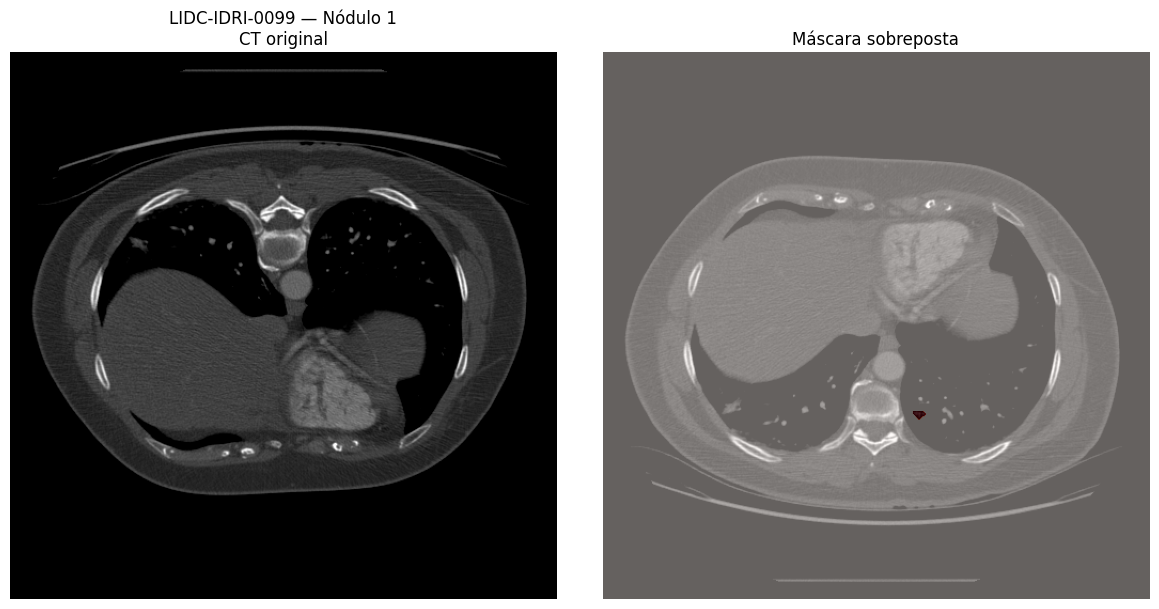

Loading dicom files ... This may take a moment.


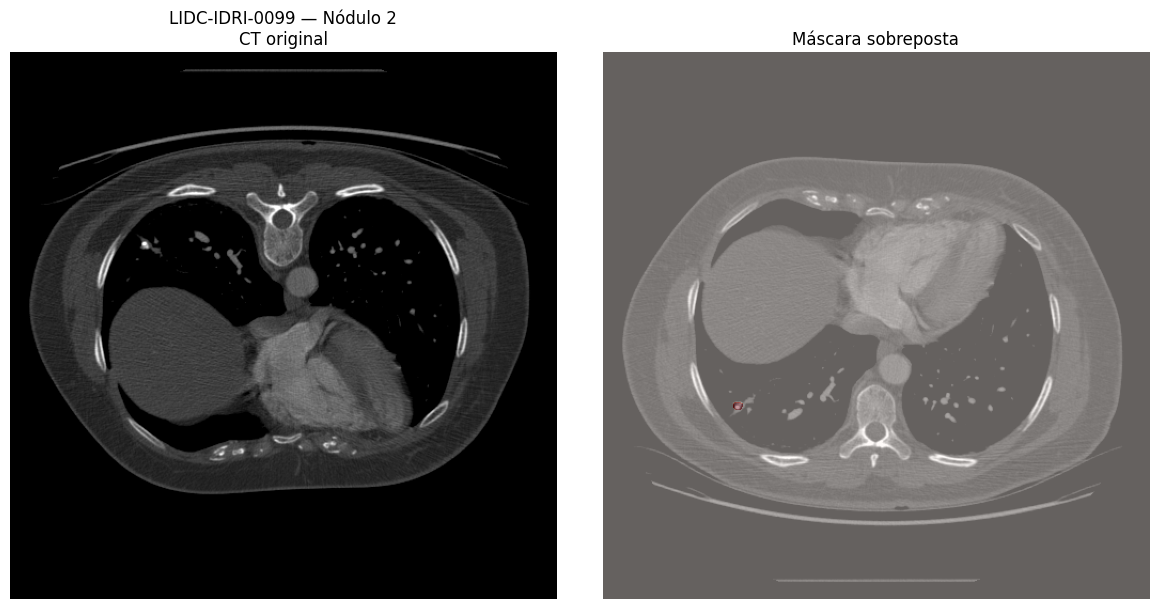

Loading dicom files ... This may take a moment.


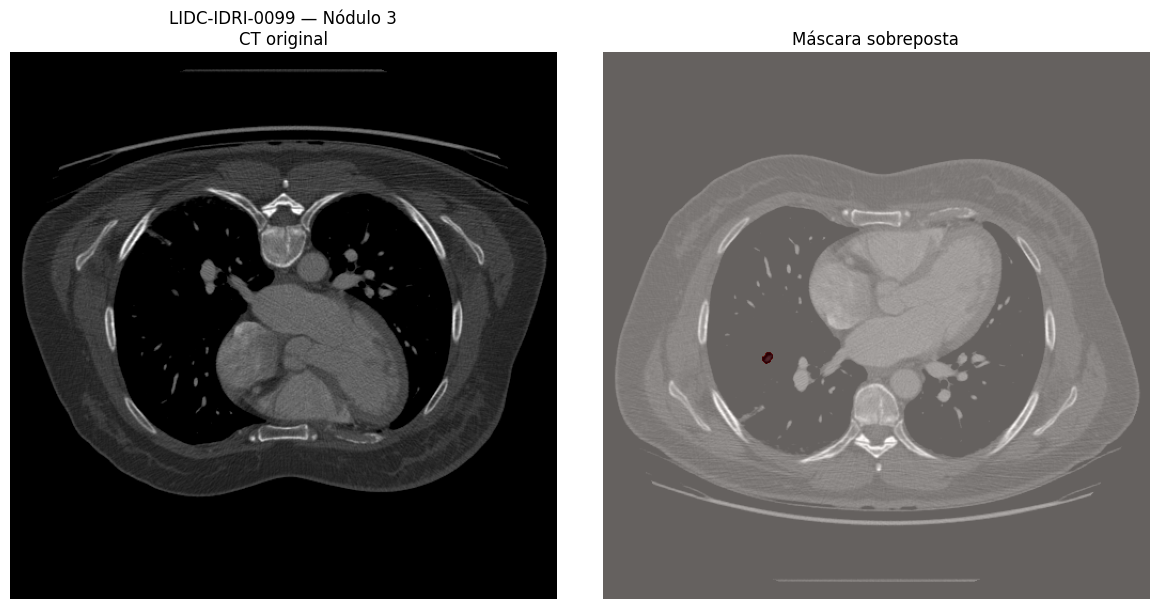

Loading dicom files ... This may take a moment.


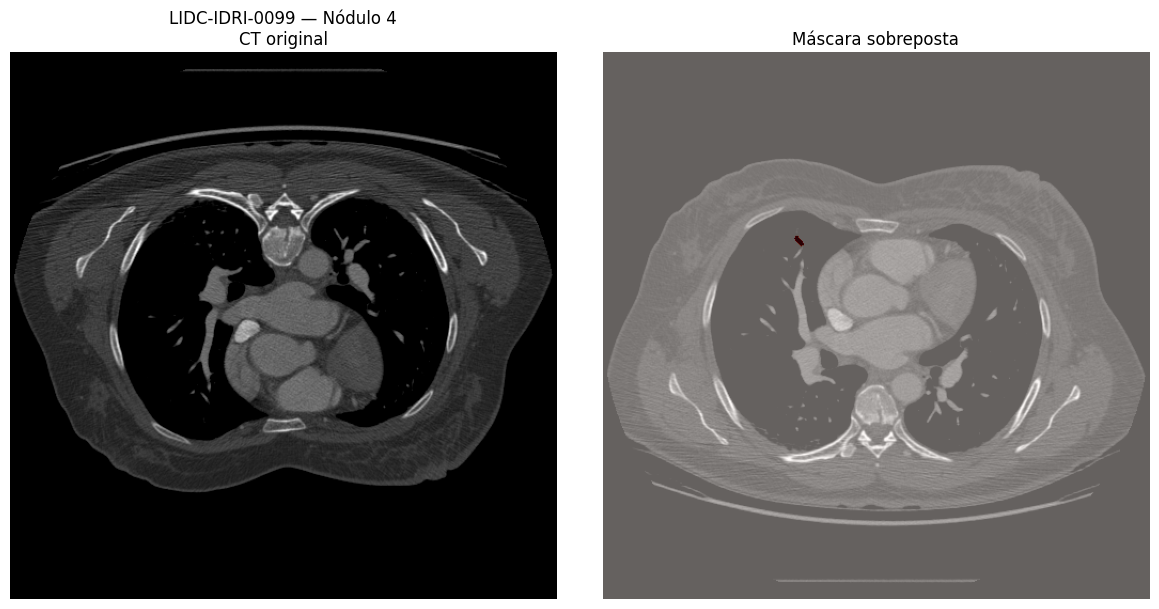

In [39]:
# Obter o paciente
patient_id = "LIDC-IDRI-0099"
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).first()

# Gerar as máscaras e volume
vec_masks, vol, _ = get_nodule_coordinates(scan, patient_id)

# Processar cada nódulo
for nodule_id, mask3d in enumerate(vec_masks, 1):
    img_slice, mask_slice, idx = isolate_nodule_with_coordinates(mask3d, vol)

    # Obter ficheiro DICOM correspondente
    dicom_files = scan.load_all_dicom_images()
    dicom_file = dicom_files[min(idx, len(dicom_files)-1)]

    # Converter e visualizar
    img_hu = convert_to_hu(img_slice, dicom_file)
    show_ct_and_mask(img_hu, mask_slice, patient_id, nodule_id)

## 6.3 Extração das Radiomic Features <a id="radiomics"><a/>

[Voltar ao Pré-Processamento das Imagens](#preprocessamento)

In [137]:
df= pd.read_csv("final.csv")
df['Nodule ID'] = df['Nodule ID'].astype(int)

In [ ]:
dict_patientID = df.groupby('Patient ID')['Nodule ID'].apply(lambda x: list(set(x))).to_dict()

In [44]:
extractors = {
    "2D": {"extractor": "ext2D", "radi_csv": "features_2D.csv", "shape": "shape2D"},
    "3D": {"extractor": "ext3D", "radi_csv": "features_3D.csv", "shape": "shape3D"}
}

for tipo, info in extractors.items():
    print(f"\n--- Extraindo features {tipo} ---")

    csv_file = info["radi_csv"]
    shape = info["shape"]
   
    # Configuração do extractor
    ext = featureextractor.RadiomicsFeatureExtractor()
    ext.disableAllFeatures()
    ext.enableFeatureClassByName('firstorder')  
    ext.enableFeatureClassByName('glcm')        
    ext.enableFeatureClassByName('glrlm')        
    ext.enableFeatureClassByName('glszm')        
    ext.enableFeatureClassByName('gldm')        
    ext.enableFeatureClassByName('ngtdm')
    ext.enableFeatureClassByName(shape)

    import pandas as pd
    import os
    
    if os.path.exists(csv_file):
        try:
            df_existente = pd.read_csv(csv_file)
            print(f"CSV existente encontrado: {csv_file} ({len(df_existente)} linhas)")
            processados = set(zip(df_existente['Patient ID'], df_existente['Nodule ID']))
        except pd.errors.EmptyDataError:
            print(f"[INFO] CSV {csv_file} está vazio. Criando novo DataFrame.")
            df_existente = pd.DataFrame()
            processados = set()
    else:
        df_existente = pd.DataFrame()
        processados = set()


    novos_resultados = []
    
    # Seleciona os primeiros 5 pacientes para teste
    #primeiros_pacientes = list(dict_patientID.keys())[:5]
    
    # Percorre pacientes e nódulos
    #for patient_id in primeiros_pacientes:
    
    for patient_id in dict_patientID:
        scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).all()

        for scan in scans:
                try:
                    #Verifica se o scan tem DICOMs válidos
                    vol = scan.to_volume()
                except RuntimeError as e:
                    print(f"[⚠️] Ignorando scan inválido ({patient_id}): {e}")
                    continue

                # Obter todos os nódulos anotados
                vec_masks, vol, _ = get_nodule_coordinates(scan, patient_id)
                if not vec_masks:
                    continue

                for nodule_id, mask3d in enumerate(vec_masks, start=1):
                    
                    #Só processa nódulos válidos e ainda não processados
                    if nodule_id not in dict_patientID[patient_id]:
                        continue
                    if (patient_id, nodule_id) in processados:
                        continue
   
                    print(f"Processando: {patient_id} - Nódulo {nodule_id}")

                    if tipo == "2D":
                        img_slice, mask_slice, idx = isolate_nodule_with_coordinates(mask3d, vol)
                        img_hu = img_slice
                        imagem_sitk = sitk.GetImageFromArray(img_hu)
                        mascara_sitk = sitk.GetImageFromArray(mask_slice.astype(np.uint8))
                    else:  # 3D
                        img_hu = vol
                        imagem_sitk = sitk.GetImageFromArray(img_hu)
                        mascara_sitk = sitk.GetImageFromArray(mask3d.astype(np.uint8))

   
                    #Obter slice de maior área e converter para HU
                    #img_slice, mask_slice, idx = isolate_nodule_with_coordinates(mask3d, vol)
                    #img_hu = img_slice  # já em HU
   
                    #Converter para formato SimpleITK
                    #imagem_sitk = sitk.GetImageFromArray(img_hu)
                    #mascara_sitk = sitk.GetImageFromArray(mask_slice.astype(np.uint8))
   
                    #Extrair features
                    features = ext.execute(imagem_sitk, mascara_sitk)
                    feature_dict = dict(features)
                    feature_dict['Patient ID'] = patient_id
                    feature_dict['Nodule ID'] = nodule_id
   
                    novos_resultados.append(feature_dict)
   
                    #Salvamento incremental
                    if len(novos_resultados) % 10 == 0:
                        print("=> Salvando progresso parcial...")
                        df_temp = pd.DataFrame(novos_resultados)
                        df_concat = pd.concat([df_existente, df_temp], ignore_index=True)
                        df_concat.to_csv(csv_file, index=False, encoding='utf-8')
                        novos_resultados = []
                        df_existente = df_concat

    #Salvamento final
    if novos_resultados:
        df_temp = pd.DataFrame(novos_resultados)
        df_final = pd.concat([df_existente, df_temp], ignore_index=True)
    else:
        df_final = df_existente

    df_final.to_csv(csv_file, index=False, encoding='utf-8')
    print(f"Features {tipo} salvas/atualizadas em: {csv_file}")



--- Extraindo features 2D ---
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0001 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0003 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0004 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0007 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0011 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0011 - Nódulo 10


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0013 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0015 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0016 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0016 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0018 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0021 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0023 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0031 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0031 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0034 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0037 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0039 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0039 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0039 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0039 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0043 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0044 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0045 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0045 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0045 - Nódulo 10


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0046 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0047 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0049 - Nódulo 12


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0049 - Nódulo 15


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0051 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0052 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0052 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0053 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0054 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0055 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0055 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0057 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0058 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0059 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0060 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0060 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0061 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0066 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0067 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0068 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0072 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0073 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0075 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0077 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0078 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0080 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0081 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0082 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0085 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0087 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0088 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0089 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0092 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0092 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0094 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0095 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0095 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0106 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0108 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0111 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0111 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0116 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0118 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0118 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0118 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0118 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0119 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0119 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0120 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0121 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0124 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0126 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0130 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0132 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0132 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0142 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0142 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0144 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0144 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0144 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0148 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0148 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0151 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0151 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0156 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0160 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0160 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0163 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0168 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0169 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0170 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0171 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0171 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0172 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0179 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0183 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0185 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0185 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0186 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0187 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0188 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0190 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0190 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0191 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0193 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0194 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0194 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0195 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0195 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0195 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0196 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0203 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0203 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0206 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0206 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0211 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0212 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0213 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0215 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0217 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0217 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0217 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0221 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0222 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0229 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0229 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0229 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0229 - Nódulo 7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0240 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0242 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0244 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0248 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0249 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0250 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0250 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0256 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0262 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0263 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0265 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0267 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0272 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0276 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0281 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0284 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0286 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0287 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0294 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0305 - Nódulo 8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0309 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0313 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0315 - Nódulo 5
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0315 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0321 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0321 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0325 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0332 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0332 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0337 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0337 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0346 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0346 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0347 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0348 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0351 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0353 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0354 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0359 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0362 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0365 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0365 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0368 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0375 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0375 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0376 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0377 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0379 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0380 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0385 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0386 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0390 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0390 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0390 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0390 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0390 - Nódulo 6
=> Salvando progresso parcial...
Processando: LIDC-IDRI-0390 - Nódulo 7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0390 - Nódulo 8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0399 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0402 - Nódulo 10


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0403 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0404 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0404 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0407 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0412 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0415 - Nódulo 7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0419 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0421 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0423 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0426 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0427 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0427 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0433 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0436 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0437 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0437 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0437 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0440 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0442 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0442 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0443 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0447 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0450 - Nódulo 8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0456 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0456 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0461 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0462 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0463 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0464 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0466 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0466 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0470 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0473 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0473 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0473 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0481 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0484 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0484 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0485 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0486 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0488 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0489 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0489 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0489 - Nódulo 7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0491 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0491 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0491 - Nódulo 8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0492 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0496 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0497 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0507 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0507 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0515 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0523 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0526 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0526 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0529 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0530 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0537 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0541 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0542 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0546 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0559 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0562 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0565 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0565 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0565 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0568 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0568 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0569 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0572 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0576 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0578 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0587 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0590 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0602 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0604 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0604 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0605 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0605 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0606 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0608 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0608 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0610 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0614 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0615 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0615 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0617 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0617 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0619 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0620 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0620 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0625 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0639 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0640 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0641 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0641 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0642 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0645 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0648 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0649 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0649 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0649 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0649 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0649 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0649 - Nódulo 7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0649 - Nódulo 8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0649 - Nódulo 10


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0649 - Nódulo 11


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0655 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0655 - Nódulo 8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0660 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0663 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0671 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0671 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0674 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0678 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0686 - Nódulo 17


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0697 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0698 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0702 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0704 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0708 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0708 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0709 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0709 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0713 - Nódulo 1
Processando: LIDC-IDRI-0713 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0713 - Nódulo 7
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0715 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0717 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0722 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0726 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0727 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0732 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0740 - Nódulo 1
=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0748 - Nódulo 3
Processando: LIDC-IDRI-0748 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0748 - Nódulo 7
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0749 - Nódulo 1
Processando: LIDC-IDRI-0749 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0749 - Nódulo 5
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0751 - Nódulo 1
Processando: LIDC-IDRI-0751 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0751 - Nódulo 7
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0756 - Nódulo 1
=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0759 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0772 - Nódulo 1
Processando: LIDC-IDRI-0772 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0773 - Nódulo 5
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0775 - Nódulo 3
Processando: LIDC-IDRI-0775 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0776 - Nódulo 3
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0777 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0785 - Nódulo 1
Processando: LIDC-IDRI-0785 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0791 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0796 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0797 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0798 - Nódulo 3
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0799 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0801 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0807 - Nódulo 4
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0811 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0819 - Nódulo 2
Processando: LIDC-IDRI-0819 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0822 - Nódulo 6
Processando: LIDC-IDRI-0822 - Nódulo 7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0825 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0827 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0838 - Nódulo 5
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0843 - Nódulo 2
Processando: LIDC-IDRI-0843 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0843 - Nódulo 6
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0844 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0849 - Nódulo 5
=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0850 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0854 - Nódulo 4
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0855 - Nódulo 15
Processando: LIDC-IDRI-0855 - Nódulo 16


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0858 - Nódulo 3
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0860 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0861 - Nódulo 1
Processando: LIDC-IDRI-0861 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0866 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0867 - Nódulo 1
=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0869 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0871 - Nódulo 8
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0875 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0879 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0884 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0886 - Nódulo 3
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0890 - Nódulo 3
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0892 - Nódulo 4
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0893 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0895 - Nódulo 3
=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0902 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0905 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0908 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0910 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0912 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0913 - Nódulo 3
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0914 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0916 - Nódulo 2
Processando: LIDC-IDRI-0916 - Nódulo 8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0919 - Nódulo 1
=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0921 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0925 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0929 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0933 - Nódulo 5
Processando: LIDC-IDRI-0933 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0935 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0936 - Nódulo 1
Processando: LIDC-IDRI-0936 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0938 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0940 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0942 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0944 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0951 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0956 - Nódulo 2
Processando: LIDC-IDRI-0956 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0961 - Nódulo 1
Processando: LIDC-IDRI-0961 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0963 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0965 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0966 - Nódulo 1
=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0968 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0976 - Nódulo 2
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0980 - Nódulo 1
Processando: LIDC-IDRI-0980 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0987 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0993 - Nódulo 1
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0994 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0997 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0997 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0999 - Nódulo 4
=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-1002 - Nódulo 3
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-1004 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-1004 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-1007 - Nódulo 1
Processando: LIDC-IDRI-1007 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-1011 - Nódulo 2
Processando: LIDC-IDRI-1011 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-1012 - Nódulo 1


Feature class shape3D is not recognized


Features 2D salvas/atualizadas em: features_2D.csv

--- Extraindo features 3D ---
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0001 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0003 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0004 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0007 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0011 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0011 - Nódulo 10


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0013 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0015 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0016 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0016 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0018 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0021 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0023 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0031 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0031 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0034 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0037 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0039 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0039 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0039 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0039 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0043 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0044 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0045 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0045 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0045 - Nódulo 10


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0046 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0047 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0049 - Nódulo 12


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0049 - Nódulo 15


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0051 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0052 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0052 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0053 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0054 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0055 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0055 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0057 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0058 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0059 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0060 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0060 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0061 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0066 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0067 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0068 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0072 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0073 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0075 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0077 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0078 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0080 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0081 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0082 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0085 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0087 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0088 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0089 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0092 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0092 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0094 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0095 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0095 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0106 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0108 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0111 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0111 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0116 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0118 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0118 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0118 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0118 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0119 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0119 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0120 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0121 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0124 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0126 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0130 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0132 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0132 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0142 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0142 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0144 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0144 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0144 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0148 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0148 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0151 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0151 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0156 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0160 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0160 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0163 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0168 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0169 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0170 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0171 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0171 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0172 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0179 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0183 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0185 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0185 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0186 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0187 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0188 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0190 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0190 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0191 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0193 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0194 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0194 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0195 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0195 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0195 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0196 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0203 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0203 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0206 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0206 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0211 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0212 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0213 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0215 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0217 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0217 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0217 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0221 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0222 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0229 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0229 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0229 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0229 - Nódulo 7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0240 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0242 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0244 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0248 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0249 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0250 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0250 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0256 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0262 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0263 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0265 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0267 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0272 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0276 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0281 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0284 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0286 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0287 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0294 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0305 - Nódulo 8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0309 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0313 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0315 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0315 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0321 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0321 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0325 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0332 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0332 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0337 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0337 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0346 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0346 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0347 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0348 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0351 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0353 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0354 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0359 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0362 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0365 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0365 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0368 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0375 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0375 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0376 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0377 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0379 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0380 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0385 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0386 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0390 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0390 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0390 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0390 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0390 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0390 - Nódulo 7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0390 - Nódulo 8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0399 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0402 - Nódulo 10


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0403 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0404 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0404 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0407 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0412 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0415 - Nódulo 7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0419 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0421 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0423 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0426 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0427 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0427 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0433 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0436 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0437 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0437 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0437 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0440 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0442 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0442 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0443 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0447 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0450 - Nódulo 8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0456 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0456 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0461 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0462 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0463 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0464 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0466 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0466 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0470 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0473 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0473 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0473 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0481 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0484 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0484 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0485 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0486 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0488 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0489 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0489 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0489 - Nódulo 7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0491 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0491 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0491 - Nódulo 8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0492 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0496 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0497 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0507 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0507 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0515 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0523 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0526 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0526 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0529 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0530 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0537 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0541 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0542 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0546 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0559 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0562 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0565 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0565 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0565 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0568 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0568 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0569 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0572 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0576 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0578 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0587 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0590 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0602 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0604 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0604 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0605 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0605 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0606 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0608 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0608 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0610 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0614 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0615 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0615 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0617 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0617 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0619 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0620 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0620 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0625 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0639 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0640 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0641 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0641 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0642 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0645 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0648 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0649 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0649 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0649 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0649 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0649 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0649 - Nódulo 7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Processando: LIDC-IDRI-0649 - Nódulo 8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0649 - Nódulo 10


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0649 - Nódulo 11


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0655 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0655 - Nódulo 8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0660 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0663 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0671 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0671 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0674 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0678 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0686 - Nódulo 17


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0697 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0698 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0702 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0704 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0708 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0708 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0709 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0709 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0713 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0713 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0713 - Nódulo 7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0715 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0717 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0722 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0726 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0727 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0732 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0740 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0748 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0748 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0748 - Nódulo 7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0749 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0749 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0749 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0751 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0751 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0751 - Nódulo 7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0756 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0759 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0772 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0772 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0773 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0775 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0775 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0776 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0777 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0785 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0785 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0791 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0796 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0797 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0798 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0799 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0801 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0807 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0811 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0819 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0819 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0822 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0822 - Nódulo 7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0825 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0827 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0838 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0843 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0843 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0843 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0844 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0849 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0850 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0854 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0855 - Nódulo 15


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0855 - Nódulo 16


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0858 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0860 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0861 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0861 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0866 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0867 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0869 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0871 - Nódulo 8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0875 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0879 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0884 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0886 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0890 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0892 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0893 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0895 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0902 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0905 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0908 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0910 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0912 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0913 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0914 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0916 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0916 - Nódulo 8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0919 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0921 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0925 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0929 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0933 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0933 - Nódulo 6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0935 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0936 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0936 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0938 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0940 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0942 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0944 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0951 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0956 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0956 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0961 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0961 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0963 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0965 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0966 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0968 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0976 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0980 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0980 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0987 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0993 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0994 - Nódulo 5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0997 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-0997 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-0999 - Nódulo 4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


=> Salvando progresso parcial...
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-1002 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-1004 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-1004 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-1007 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-1007 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-1011 - Nódulo 2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Processando: LIDC-IDRI-1011 - Nódulo 3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Processando: LIDC-IDRI-1012 - Nódulo 1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Features 3D salvas/atualizadas em: features_3D.csv


## 7. Tratamento de Dados <a id="tratamento"><a/>

[Voltar a Índice](#indice)

#### Esta secção destina-se à análise e estudo do dataset das radiomic features.

In [52]:
df_2D = pd.read_csv("features_2D.csv")
df_3D = pd.read_csv("features_3D.csv")

display(df_2D.head())
display(df_3D.head())

print(df_2D.columns)
print(df_3D.columns)

original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
0                     0.817583                         42.368498   
1                     0.766112                         37.341652   
2                     0.730352                          9.337767   
3                     0.667241                         41.911511   
4                     0.942769                          7.538450   

   original_shape2D_MaximumDiameter  original_shape2D_MeshSurface  \
0                         49.406477                        1042.0   
1                         41.231056                         808.5   
2                          9.486833                          48.5   
3                         46.097722                         815.5   
4                          8.062258                          41.5   

   original_shape2D_MinorAxisLength  original_shape2D_Perimeter  \
0                         34.639772                  174.752309   
1                         28.607897                  139.539105   
2                          6.819853                   27.313708   
3                         27.965061                  131.982756   
4                          7.107014                   23.899495   

   original_shape2D_PerimeterSurfaceRatio  original_shape2D_PixelSurface  \
0                                0.167709                         1043.0   
1                                0.172590                          809.0   
2                                0.563169                           49.0   
3                                0.161843                          816.0   
4                                0.575891                           42.0   

   original_shape2D_Sphericity  original_firstorder_10Percentile  ...  \
0                     0.654811                            -362.0  ...   
1                     0.722352                            -694.6  ...   
2                     0.903847                            -616.2  ...   
3                     0.767008                            -705.5  ...   
4                     0.955521                            -463.3  ...   

   original_gldm_SmallDependenceEmphasis  \
0                               0.391737   
1                               0.481773   
2                               0.776219   
3                               0.643783   
4                               0.821429   

   original_gldm_SmallDependenceHighGrayLevelEmphasis  \
0                                         269.142467    
1                                         238.874104    
2                                         688.575964    
3                                         936.804631    
4                                        1267.857143    

   original_gldm_SmallDependenceLowGrayLevelEmphasis  original_ngtdm_Busyness  \
0                                           0.003666                 0.043624   
1                                           0.009082                 0.039972   
2                                           0.025477                 0.023805   
3                                           0.011020                 0.030977   
4                                           0.028066                 0.024943   

   original_ngtdm_Coarseness  original_ngtdm_Complexity  \
0                   0.014227                 906.521275   
1                   0.024464                 785.536157   
2                   0.073779                5189.430793   
3                   0.010131                6647.009247   
4                   0.062591                7224.272227   

   original_ngtdm_Contrast  original_ngtdm_Strength      Patient ID  Nodule ID  
0                 0.125211                14.618461  LIDC-IDRI-0001          1  
1                 0.261271                18.509718  LIDC-IDRI-0003          2  
2                 5.840299               117.702187  LIDC-IDRI-0004          1  
3                 0.415472                20.115877  LIDC-IDRI-0007          1  
4                 7.66145

original_firstorder_10Percentile  original_firstorder_90Percentile  \
0                            -608.0                             123.0   
1                            -723.0                              23.0   
2                            -655.3                             227.5   
3                            -804.0                             224.0   
4                            -496.2                             577.0   

   original_firstorder_Energy  original_firstorder_Entropy  \
0                6.989770e+08                     4.991670   
1                1.349435e+09                     5.078306   
2                4.034417e+07                     5.136410   
3                1.452985e+09                     5.645907   
4                1.263474e+07                     5.220933   

   original_firstorder_InterquartileRange  original_firstorder_Kurtosis  \
0                                   486.0                      2.059696   
1                                   578.0                      1.551042   
2                                   439.0                      4.180339   
3                                   601.0                      2.276507   
4                                   584.0                      2.592582   

   original_firstorder_Maximum  original_firstorder_MeanAbsoluteDeviation  \
0                        253.0                                 249.055245   
1                        276.0                                 261.183543   
2                        918.0                                 292.811406   
3                        789.0                                 338.817104   
4                        936.0                                 338.231938   

   original_firstorder_Mean  original_firstorder_Median  ...  \
0               -161.662288                       -56.0  ...   
1               -380.169259                      -455.0  ...   
2               -335.481250                      -479.5  ...   
3               -175.325374                       -15.5  ...   
4                -37.438356                      -106.0  ...   

   original_gldm_SmallDependenceEmphasis  \
0                               0.359342   
1                               0.322692   
2                               0.632769   
3                               0.538440   
4                               0.757991   

   original_gldm_SmallDependenceHighGrayLevelEmphasis  \
0                                         246.113546    
1                                         157.120795    
2                                         435.654688    
3                                         660.013016    
4                                         904.944444    

   original_gldm_SmallDependenceLowGrayLevelEmphasis  original_ngtdm_Busyness  \
0                                           0.001992                 0.506478   
1                                           0.002641                 0.709235   
2                                           0.018493                 0.059115   
3                                           0.010799                 0.369666   
4                                           0.017580                 0.029548   

   original_ngtdm_Coarseness  original_ngtdm_Complexity  \
0                   0.001145                3691.077373   
1                   0.001520                3044.802147   
2                   0.025284                9932.526324   
3                   0.000931               14900.076489   
4                   0.042390               11553.623487   

   original_ngtdm_Contrast  original_ngtdm_Strength      Patient ID  Nodule ID  
0                 0.494586                 1.211626  LIDC-IDRI-0001          1  
1                 0.443948                 1.437845  LIDC-IDRI-0003          2  
2                 1.377353                52.136354  LIDC-IDRI-0004          1  
3                 0.673482                 1.858406  LIDC-IDRI-0007          1  
4                 3.143527           

Index(['original_shape2D_Elongation', 'original_shape2D_MajorAxisLength',
       'original_shape2D_MaximumDiameter', 'original_shape2D_MeshSurface',
       'original_shape2D_MinorAxisLength', 'original_shape2D_Perimeter',
       'original_shape2D_PerimeterSurfaceRatio',
       'original_shape2D_PixelSurface', 'original_shape2D_Sphericity',
       'original_firstorder_10Percentile',
       ...
       'original_gldm_SmallDependenceEmphasis',
       'original_gldm_SmallDependenceHighGrayLevelEmphasis',
       'original_gldm_SmallDependenceLowGrayLevelEmphasis',
       'original_ngtdm_Busyness', 'original_ngtdm_Coarseness',
       'original_ngtdm_Complexity', 'original_ngtdm_Contrast',
       'original_ngtdm_Strength', 'Patient ID', 'Nodule ID'],
      dtype='object', length=104)
Index(['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_

## Tipos de colunas radiomics_features

#### Com base no nome das colunas, há quatro grupos principais:

| Grupo                       | Exemplo                  | Origem               | Função                                      |
|-----------------------------|--------------------------|---------------------|--------------------------------------------|
| Diagnósticos                | diagnostics_*            | PyRadiomics (metadata) | Informação técnica sobre o processo       |
| Forma (shape)               | original_shape2D_*       | PyRadiomics          | Geometria da ROI (área, perímetro, etc.) |
| Primeira ordem (firstorder) | original_firstorder_*    | PyRadiomics          | Estatísticas de intensidade (HU)          |
| Textura (GLCM, GLRLM, etc)  | original_glcm_*, etc.    | PyRadiomics          | Textura e heterogeneidade da imagem       |
| Identificadores             | Patient ID, Nodule ID    | LIDC-IDRI            | Identificação do caso/nódulo              |


#### Começamos por fazer uma limpeza inicial dos datasets das features. Após a análise do dataset concluiu-se que a maioria das colunas que começam com diagnostics_* são metadados ou informações de rastreabilidade e identificação que não apresentam utilidade na predição de modelos.

In [53]:
'''Faz uma análise exploratória rápida do DataFrame antes da limpeza.'''

def analyze(df):
    df = df.copy()
    print("Análise pré-limpeza")

    # Colunas com NaN
    nan_cols = df.columns[df.isna().any()].tolist()

    # Colunas com Inf/-Inf (apenas numéricas)
    numeric_df = df.select_dtypes(include=[np.number])
    inf_mask = np.isinf(numeric_df)
    inf_cols = numeric_df.columns[inf_mask.any()].tolist()

    print(f"\n Colunas com NaN: {nan_cols if nan_cols else 'Nenhuma'}")
    print(f" Colunas com Inf/-Inf: {inf_cols if inf_cols else 'Nenhuma'}")

    # Colunas totalmente vazias
    empty_cols = df.columns[df.isna().all()].tolist()
    print(f"\n Colunas totalmente vazias: {empty_cols if empty_cols else 'Nenhuma'}")

    # Colunas com valor constante
    constant_cols = [c for c in df.columns if df[c].nunique(dropna=True) == 1]
    print(f"\n Colunas com único valor constante: {constant_cols if constant_cols else 'Nenhuma'}")

    # Resumo
    print("\n Resumo:")
    print(f"→ Total de colunas: {df.shape[1]}")
    print(f"→ Colunas com NaN: {len(nan_cols)}")
    print(f"→ Colunas com Inf/-Inf: {len(inf_cols)}")
    print(f"→ Colunas vazias: {len(empty_cols)}")
    print(f"→ Colunas constantes: {len(constant_cols)}")

    return {
        "nan_cols": nan_cols,
        "inf_cols": inf_cols,
        "empty_cols": empty_cols,
        "constant_cols": constant_cols
    }

report_2d = analyze(df_2D)
print("\n" + "="*130)
report_3d = analyze(df_3D)

Análise pré-limpeza

 Colunas com NaN: Nenhuma
 Colunas com Inf/-Inf: Nenhuma

 Colunas totalmente vazias: Nenhuma

 Colunas com único valor constante: Nenhuma

 Resumo:
→ Total de colunas: 104
→ Colunas com NaN: 0
→ Colunas com Inf/-Inf: 0
→ Colunas vazias: 0
→ Colunas constantes: 0

Análise pré-limpeza

 Colunas com NaN: Nenhuma
 Colunas com Inf/-Inf: Nenhuma

 Colunas totalmente vazias: Nenhuma

 Colunas com único valor constante: Nenhuma

 Resumo:
→ Total de colunas: 95
→ Colunas com NaN: 0
→ Colunas com Inf/-Inf: 0
→ Colunas vazias: 0
→ Colunas constantes: 0


### Resultado do tratamento de dados:

#### original_firstorder_10Percentile, original_firstorder_Minimum → Estas colunas são retiradas por não terem relevância estatística (valores constantes)

#### As features finais (features_2D e features_3D) contêm: *X = Features radiomics reais (original_*) e identificadores para dar merge (Patient ID e Nodule ID)

In [54]:
def cleaning(df):
    df = df.copy()

    # Manter colunas que têm mais de um valor único
    keep = [c for c in df.columns if df[c].nunique() > 1]
    removed_cols = [c for c in df.columns if c not in keep]
    df = df[keep]

    return df


# Limpeza dos dataframes
df2d_clean = cleaning(df_2D)
df3d_clean = cleaning(df_3D)

# Prefixos a excluir
exclude_prefixes = ['diagnostics_']

# Criar lista final de colunas a manter
feature_cols_2D = [
    c for c in df2d_clean.columns
    if not any(c.startswith(prefix) for prefix in exclude_prefixes)
]

feature_cols_3D = [
    c for c in df3d_clean.columns
    if not any(c.startswith(prefix) for prefix in exclude_prefixes)
]

# Dataframe final com colunas limpas
final_features_2D = df2d_clean[feature_cols_2D]
final_features_3D = df3d_clean[feature_cols_3D]

# Exibir informações
print("Original shape 2D:", df_2D.shape)
print("Features shape 2D:", final_features_2D.shape)
print("Columns removed 2D:", set(df_2D.columns) - set(final_features_2D.columns))

print("Original shape 3D:", df_3D.shape)
print("Features shape 3D:", final_features_3D.shape)
print("Columns removed 3D:", set(df_3D.columns) - set(final_features_3D.columns))


Original shape 2D: (438, 104)
Features shape 2D: (438, 104)
Columns removed 2D: set()
Original shape 3D: (438, 95)
Features shape 3D: (438, 95)
Columns removed 3D: set()


In [55]:
def summarize_dtypes(df):
    df = df.copy()
    print("Resumo dos tipos de dados")

    # Separar colunas por tipo
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    object_cols = df.select_dtypes(include=['object']).columns.tolist()
    bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
    datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
    category_cols = df.select_dtypes(include=['category']).columns.tolist()

    # Exibir resultados
    print(f"\n Numéricas ({len(numeric_cols)}):")
    print(numeric_cols if numeric_cols else "Nenhuma")

    print(f"\n Strings / Objetos ({len(object_cols)}):")
    print(object_cols if object_cols else "Nenhuma")

    print(f"\n Booleanas ({len(bool_cols)}):")
    print(bool_cols if bool_cols else "Nenhuma")

    print(f"\n Datas ({len(datetime_cols)}):")
    print(datetime_cols if datetime_cols else "Nenhuma")

    print(f"\n Categóricas ({len(category_cols)}):")
    print(category_cols if category_cols else "Nenhuma")

    print("\n Resumo geral:")
    print(df.dtypes.value_counts())

    # Retornar dicionário útil
    return {
        "numeric_cols": numeric_cols,
        "object_cols": object_cols,
        "bool_cols": bool_cols,
        "datetime_cols": datetime_cols,
        "category_cols": category_cols
    }

In [56]:
summary_2D = summarize_dtypes(final_features_2D)

Resumo dos tipos de dados

 Numéricas (103):
['original_shape2D_Elongation', 'original_shape2D_MajorAxisLength', 'original_shape2D_MaximumDiameter', 'original_shape2D_MeshSurface', 'original_shape2D_MinorAxisLength', 'original_shape2D_Perimeter', 'original_shape2D_PerimeterSurfaceRatio', 'original_shape2D_PixelSurface', 'original_shape2D_Sphericity', 'original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorr

In [57]:
summary_3D = summarize_dtypes(final_features_3D)

Resumo dos tipos de dados

 Numéricas (94):
['original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_Correlation', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Id', 'original_glcm_Idm'

In [58]:
final_features_2D.to_csv("features_2D.csv", index=False, encoding='utf-8')
final_features_3D.to_csv("features_3D.csv", index=False, encoding='utf-8')

## 8. Merge Final: 'final_features_2/3D.csv' x 'final.csv' <a id="mergefinal"><a/>

[Voltar ao Índice](#indice)

In [59]:
df_final=pd.read_csv("final.csv")

In [60]:
df_2d = pd.merge(
    df_final,
    final_features_2D,
    on=["Patient ID","Nodule ID"],
    how="inner"
)

print("Shape do dataset 2D para treino:", df_2d.shape)

Shape do dataset 2D para treino: (438, 114)


In [61]:
df_2d

Patient ID  Nodule ID  Number of Nodules  Number of Annotations  \
0    LIDC-IDRI-0001          1                  1                      4   
1    LIDC-IDRI-0003          2                  4                      4   
2    LIDC-IDRI-0004          1                  1                      4   
3    LIDC-IDRI-0007          1                  2                      4   
4    LIDC-IDRI-0011          6                 10                      4   
..              ...        ...                ...                    ...   
433  LIDC-IDRI-1007          1                  2                      4   
434  LIDC-IDRI-1007          2                  2                      3   
435  LIDC-IDRI-1011          2                  4                      4   
436  LIDC-IDRI-1011          3                  4                      4   
437  LIDC-IDRI-1012          1                  1                      4   

     Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  ...  \
0              5           3           3       4         5        5  ...   
1              2           2           4       3         5        4  ...   
2              1           1           2       5         2        5  ...   
3              5           1           4       3         5        5  ...   
4              1           1           5       5         3        5  ...   
..           ...         ...         ...     ...       ...      ...  ...   
433            1           1           3       4         3        5  ...   
434            2           2           4       4         5        5  ...   
435            1           3           3       4         5        5  ...   
436            1           1           3       3         5        5  ...   
437            1           1           4       2         4        5  ...   

     original_gldm_LargeDependenceLowGrayLevelEmphasis  \
0                                             0.014551   
1                                             0.044722   
2                                             0.043791   
3                                             0.064097   
4                                             0.031814   
..                                                 ...   
433                                           0.148422   
434                                           0.028083   
435                                           0.028972   
436                                           0.017994   
437                                           0.025846   

     original_gldm_LowGrayLevelEmphasis  \
0                              0.004482   
1                              0.013687   
2                              0.027856   
3                              0.019340   
4                              0.028815   
..                                  ...   
433                            0.041658   
434                            0.007918   
435                            0.010910   
436                            0.006447   
437                            0.019481   

     original_gldm_SmallDependenceEmphasis  \
0                                 0.391737   
1                                 0.481773   
2                                 0.776219   
3                                 0.643783   
4                                 0.821429   
..                                     ...   
433                               0.815789   
434                               0.510494   
435                               0.454158   
436                               0.480383   
437                               0.726496   

     original_gldm_SmallDependenceHighGrayLevelEmphasis  \
0                                           269.142467    
1                                           238.874104    
2                                           688.575964    
3                                           936.804631    
4                                          1267.857143    
..                                                 ...    
433

In [62]:
df_3d = pd.merge(
    df_final,
    final_features_3D,
    on=["Patient ID","Nodule ID"],
    how="inner"
)

print("Shape do dataset 3D para treino:", df_3d.shape)

Shape do dataset 3D para treino: (438, 105)


In [63]:
df_3d

Patient ID  Nodule ID  Number of Nodules  Number of Annotations  \
0    LIDC-IDRI-0001          1                  1                      4   
1    LIDC-IDRI-0003          2                  4                      4   
2    LIDC-IDRI-0004          1                  1                      4   
3    LIDC-IDRI-0007          1                  2                      4   
4    LIDC-IDRI-0011          6                 10                      4   
..              ...        ...                ...                    ...   
433  LIDC-IDRI-1007          1                  2                      4   
434  LIDC-IDRI-1007          2                  2                      3   
435  LIDC-IDRI-1011          2                  4                      4   
436  LIDC-IDRI-1011          3                  4                      4   
437  LIDC-IDRI-1012          1                  1                      4   

     Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  ...  \
0              5           3           3       4         5        5  ...   
1              2           2           4       3         5        4  ...   
2              1           1           2       5         2        5  ...   
3              5           1           4       3         5        5  ...   
4              1           1           5       5         3        5  ...   
..           ...         ...         ...     ...       ...      ...  ...   
433            1           1           3       4         3        5  ...   
434            2           2           4       4         5        5  ...   
435            1           3           3       4         5        5  ...   
436            1           1           3       3         5        5  ...   
437            1           1           4       2         4        5  ...   

     original_gldm_LargeDependenceLowGrayLevelEmphasis  \
0                                             0.026532   
1                                             0.104261   
2                                             0.226002   
3                                             0.504858   
4                                             0.027398   
..                                                 ...   
433                                           0.083663   
434                                           0.022723   
435                                           0.022456   
436                                           0.025687   
437                                           0.026699   

     original_gldm_LowGrayLevelEmphasis  \
0                              0.003499   
1                              0.007612   
2                              0.038705   
3                              0.032865   
4                              0.019274   
..                                  ...   
433                            0.023658   
434                            0.003018   
435                            0.004017   
436                            0.003953   
437                            0.012436   

     original_gldm_SmallDependenceEmphasis  \
0                                 0.359342   
1                                 0.322692   
2                                 0.632769   
3                                 0.538440   
4                                 0.757991   
..                                     ...   
433                               0.627836   
434                               0.388160   
435                               0.433115   
436                               0.395094   
437                               0.573938   

     original_gldm_SmallDependenceHighGrayLevelEmphasis  \
0                                           246.113546    
1                                           157.120795    
2                                           435.654688    
3                                           660.013016    
4                                           904.944444    
..                                                 ...    
433

### 8.1 Preparação dos datasets de treino/teste <a id="testpreparation"></a>


In [64]:
#Analisar colunas para retirar
print("COLUNAS QUE NÃO COMEÇAM COM 'original_' DATASET 2D")
non_original_cols_2d = [col for col in df_2d.columns if not col.startswith('original_')]
print(f"Total de colunas não-original: {len(non_original_cols_2d)}")
print("\nColunas não-original (2D):")
for i, col in enumerate(non_original_cols_2d, 1):
    print(f"{i:2d}. {col}")

print("\n" + "="*130)

display(df_2d[non_original_cols_2d].head())

COLUNAS QUE NÃO COMEÇAM COM 'original_' DATASET 2D
Total de colunas não-original: 12

Colunas não-original (2D):
 1. Patient ID
 2. Nodule ID
 3. Number of Nodules
 4. Number of Annotations
 5. Spiculation
 6. Lobulation
 7. Sphericity
 8. Margin
 9. Subtlety
10. Texture
11. Calcification
12. Malignancy



Patient ID  Nodule ID  Number of Nodules  Number of Annotations  \
0  LIDC-IDRI-0001          1                  1                      4   
1  LIDC-IDRI-0003          2                  4                      4   
2  LIDC-IDRI-0004          1                  1                      4   
3  LIDC-IDRI-0007          1                  2                      4   
4  LIDC-IDRI-0011          6                 10                      4   

   Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
0            5           3           3       4         5        5   
1            2           2           4       3         5        4   
2            1           1           2       5         2        5   
3            5           1           4       3         5        5   
4            1           1           5       5         3        5   

   Calcification  Malignancy  
0              6           1  
1              6           1  
2              3           0  
3              6           1  
4              3           0

In [65]:
#Analisar colunas para retirar
print("COLUNAS QUE NÃO COMEÇAM COM 'original_' DATASET 3D")
non_original_cols_3d = [col for col in df_3d.columns if not col.startswith('original_')]
print(f"Total de colunas não-original: {len(non_original_cols_3d)}")
print("\nColunas não-original (3D):")
for i, col in enumerate(non_original_cols_3d, 1):
    print(f"{i:2d}. {col}")

print("\n" + "="*130)

display(df_3d[non_original_cols_3d].head())

COLUNAS QUE NÃO COMEÇAM COM 'original_' DATASET 3D
Total de colunas não-original: 12

Colunas não-original (3D):
 1. Patient ID
 2. Nodule ID
 3. Number of Nodules
 4. Number of Annotations
 5. Spiculation
 6. Lobulation
 7. Sphericity
 8. Margin
 9. Subtlety
10. Texture
11. Calcification
12. Malignancy



Patient ID  Nodule ID  Number of Nodules  Number of Annotations  \
0  LIDC-IDRI-0001          1                  1                      4   
1  LIDC-IDRI-0003          2                  4                      4   
2  LIDC-IDRI-0004          1                  1                      4   
3  LIDC-IDRI-0007          1                  2                      4   
4  LIDC-IDRI-0011          6                 10                      4   

   Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
0            5           3           3       4         5        5   
1            2           2           4       3         5        4   
2            1           1           2       5         2        5   
3            5           1           4       3         5        5   
4            1           1           5       5         3        5   

   Calcification  Malignancy  
0              6           1  
1              6           1  
2              3           0  
3              6           1  
4              3           0

In [66]:
df_2d = df_2d.drop(columns=['Patient ID','Nodule ID','Number of Nodules','Number of Annotations'])
df_3d = df_3d.drop(columns=['Patient ID','Nodule ID','Number of Nodules','Number of Annotations'])

display(df_2d.head())
print("\n" + "="*70)
display(df_3d.head())

Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
0            5           3           3       4         5        5   
1            2           2           4       3         5        4   
2            1           1           2       5         2        5   
3            5           1           4       3         5        5   
4            1           1           5       5         3        5   

   Calcification  Malignancy  original_shape2D_Elongation  \
0              6           1                     0.817583   
1              6           1                     0.766112   
2              3           0                     0.730352   
3              6           1                     0.667241   
4              3           0                     0.942769   

   original_shape2D_MajorAxisLength  ...  \
0                         42.368498  ...   
1                         37.341652  ...   
2                          9.337767  ...   
3                         41.911511  ...   
4                          7.538450  ...   

   original_gldm_LargeDependenceLowGrayLevelEmphasis  \
0                                           0.014551   
1                                           0.044722   
2                                           0.043791   
3                                           0.064097   
4                                           0.031814   

   original_gldm_LowGrayLevelEmphasis  original_gldm_SmallDependenceEmphasis  \
0                            0.004482                               0.391737   
1                            0.013687                               0.481773   
2                            0.027856                               0.776219   
3                            0.019340                               0.643783   
4                            0.028815                               0.821429   

   original_gldm_SmallDependenceHighGrayLevelEmphasis  \
0                                         269.142467    
1                                         238.874104    
2                                         688.575964    
3                                         936.804631    
4                                        1267.857143    

   original_gldm_SmallDependenceLowGrayLevelEmphasis  original_ngtdm_Busyness  \
0                                           0.003666                 0.043624   
1                                           0.009082                 0.039972   
2                                           0.025477                 0.023805   
3                                           0.011020                 0.030977   
4                                           0.028066                 0.024943   

   original_ngtdm_Coarseness  original_ngtdm_Complexity  \
0                   0.014227                 906.521275   
1                   0.024464                 785.536157   
2                   0.073779                5189.430793   
3                   0.010131                6647.009247   
4                   0.062591                7224.272227   

   original_ngtdm_Contrast  original_ngtdm_Strength  
0                 0.125211                14.618461  
1                 0.261271                18.509718  
2                 5.840299               117.702187  
3                 0.415472                20.115877  
4                 7.661455               123.593660  

[5 rows x 110 columns]

Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
0            5           3           3       4         5        5   
1            2           2           4       3         5        4   
2            1           1           2       5         2        5   
3            5           1           4       3         5        5   
4            1           1           5       5         3        5   

   Calcification  Malignancy  original_firstorder_10Percentile  \
0              6           1                            -608.0   
1              6           1                            -723.0   
2              3           0                            -655.3   
3              6           1                            -804.0   
4              3           0                            -496.2   

   original_firstorder_90Percentile  ...  \
0                             123.0  ...   
1                              23.0  ...   
2                             227.5  ...   
3                             224.0  ...   
4                             577.0  ...   

   original_gldm_LargeDependenceLowGrayLevelEmphasis  \
0                                           0.026532   
1                                           0.104261   
2                                           0.226002   
3                                           0.504858   
4                                           0.027398   

   original_gldm_LowGrayLevelEmphasis  original_gldm_SmallDependenceEmphasis  \
0                            0.003499                               0.359342   
1                            0.007612                               0.322692   
2                            0.038705                               0.632769   
3                            0.032865                               0.538440   
4                            0.019274                               0.757991   

   original_gldm_SmallDependenceHighGrayLevelEmphasis  \
0                                         246.113546    
1                                         157.120795    
2                                         435.654688    
3                                         660.013016    
4                                         904.944444    

   original_gldm_SmallDependenceLowGrayLevelEmphasis  original_ngtdm_Busyness  \
0                                           0.001992                 0.506478   
1                                           0.002641                 0.709235   
2                                           0.018493                 0.059115   
3                                           0.010799                 0.369666   
4                                           0.017580                 0.029548   

   original_ngtdm_Coarseness  original_ngtdm_Complexity  \
0                   0.001145                3691.077373   
1                   0.001520                3044.802147   
2                   0.025284                9932.526324   
3                   0.000931               14900.076489   
4                   0.042390               11553.623487   

   original_ngtdm_Contrast  original_ngtdm_Strength  
0                 0.494586                 1.211626  
1                 0.443948                 1.437845  
2                 1.377353                52.136354  
3                 0.673482                 1.858406  
4                 3.143527                70.335436  

[5 rows x 101 columns]

In [67]:
X_2d = df_2d.drop(columns=['Malignancy'])
y_2d = df_2d['Malignancy']

X_3d = df_3d.drop(columns=['Malignancy'])
y_3d = df_3d['Malignancy']

In [68]:
X_2d

Spiculation  Lobulation  Sphericity  Margin  Subtlety  Texture  \
0              5           3           3       4         5        5   
1              2           2           4       3         5        4   
2              1           1           2       5         2        5   
3              5           1           4       3         5        5   
4              1           1           5       5         3        5   
..           ...         ...         ...     ...       ...      ...   
433            1           1           3       4         3        5   
434            2           2           4       4         5        5   
435            1           3           3       4         5        5   
436            1           1           3       3         5        5   
437            1           1           4       2         4        5   

     Calcification  original_shape2D_Elongation  \
0                6                     0.817583   
1                6                     0.766112   
2                3                     0.730352   
3                6                     0.667241   
4                3                     0.942769   
..             ...                          ...   
433              6                     0.714204   
434              6                     0.576747   
435              6                     0.578112   
436              6                     0.773649   
437              6                     0.776528   

     original_shape2D_MajorAxisLength  original_shape2D_MaximumDiameter  ...  \
0                           42.368498                         49.406477  ...   
1                           37.341652                         41.231056  ...   
2                            9.337767                          9.486833  ...   
3                           41.911511                         46.097722  ...   
4                            7.538450                          8.062258  ...   
..                                ...                               ...  ...   
433                         10.391468                         10.816654  ...   
434                         60.637915                         70.064256  ...   
435                         37.079192                         44.011362  ...   
436                         25.689172                         26.248809  ...   
437                         13.233378                         13.601471  ...   

     original_gldm_LargeDependenceLowGrayLevelEmphasis  \
0                                             0.014551   
1                                             0.044722   
2                                             0.043791   
3                                             0.064097   
4                                             0.031814   
..                                                 ...   
433                                           0.148422   
434                                           0.028083   
435                                           0.028972   
436                                           0.017994   
437                                           0.025846   

     original_gldm_LowGrayLevelEmphasis  \
0                              0.004482   
1                              0.013687   
2                              0.027856   
3                              0.019340   
4                              0.028815   
..                                  ...   
433                            0.041658   
434                            0.007918   
435                            0.010910   
436                            0.006447   
437                            0.019481   

     original_gldm_SmallDependenceEmphasis  \
0                                 0.391737   
1                                 0.481773   
2                                 0.776219   
3                                 0.643783   
4                                 0.821429   
..                                     ...   
433                               0.815789

In [71]:
X_2d_train, X_2d_test, y_2d_train, y_2d_test = train_test_split(X_2d, y_2d, test_size=0.3, random_state=42)
X_3d_train, X_3d_test, y_3d_train, y_3d_test = train_test_split(X_3d, y_3d, test_size=0.3, random_state=42)

### 8.2 Normalização do dataset de treino com Z-Score <a id="zscore"></a>
[Voltar a Merge Final](#mergefinal)

1. Evita que *features* com valores grandes dominem em modelos sensíveis à escala.  
2. Permite uma melhor comparação de *features* nos rankings de *feature selection*, tornando-os mais consistentes.  
3. Otimiza o processamento e o cálculo de *features* em algoritmos que utilizam gradientes.  
4. Garante que todas as *features* contribuam uniformemente em algoritmos baseados em distâncias.


In [72]:
scaler_2d = StandardScaler()
X_2d_train_scaled = scaler_2d.fit_transform(X_2d_train)
X_2d_test_scaled = scaler_2d.transform(X_2d_test)
X_2d_scaled = pd.DataFrame(
    np.vstack([X_2d_train_scaled, X_2d_test_scaled]), 
    columns=X_2d_train.columns,
    index=list(X_2d_train.index) + list(X_2d_test.index)
)

scaler_3d = StandardScaler()
X_3d_train_scaled = scaler_3d.fit_transform(X_3d_train)
X_3d_test_scaled = scaler_3d.transform(X_3d_test)
X_3d_scaled = pd.DataFrame(
    np.vstack([X_3d_train_scaled, X_3d_test_scaled]),  
    columns=X_3d_train.columns,
    index=list(X_3d_train.index) + list(X_3d_test.index)
)
merged_df_2d = X_2d_scaled.copy()
merged_df_2d['Malignancy'] = y_2d

merged_df_3d = X_3d_scaled.copy()
merged_df_3d['Malignancy'] = y_3d

print("Média de todas as médias das colunas X_2d:", X_2d_train_scaled.mean().mean())   # ~0
print("Média de todos os desvios padrões das colunas X_2d", X_2d_train_scaled.std().mean())    # ~1

print("Média de todas as médias das colunas X_3d:", X_3d_train_scaled.mean().mean())   # ~0
print("Média de todos os desvios padrões das colunas X_3d", X_3d_train_scaled.std().mean())    # ~1

Média de todas as médias das colunas X_2d: -2.798691368665922e-17
Média de todos os desvios padrões das colunas X_2d 1.0
Média de todas as médias das colunas X_3d: 6.97191034026046e-17
Média de todos os desvios padrões das colunas X_3d 1.0


## 9. Feature Selection <a id="featureselection"><a/>
[Voltar ao Índice](#indice)

#### O nosso dataset contém um número elevado de atributos, muitos dos quais poderão não contribuir de forma relevante para o desempenho dos modelos de ML. Por isso, iremos aplicar diversas técnicas de seleção de features para identificar apenas as variáveis mais informativas.

### 9.1 LASSO <a id="lasso"><a/>
[Voltar a Feature Selection](#featureselection)

#### Para determinar quais os atributos mais importantes, recorremos, primeiramente, a métodos estatísticos baseados em regularização L1, através da Regressão Logística com penalização Lasso. Este tipo de regularização força alguns coeficientes a assumirem valor zero, eliminando assim variáveis pouco relevantes e mantendo apenas as que influenciam significativamente o modelo.
#### A escolha do método Lasso foi inspirada no estudo *“Feature selection methods and predictive models in CT lung cancer radiomics”* (Gary Ge & Jie Zhang, 2023), onde os autores destacam o Lasso como uma das técnicas mais utilizadas tanto em estudos de classificação como em estudos prognósticos. Segundo o artigo, o Lasso tem-se mostrado uma **abordagem robusta** e amplamente adotada na fase de seleção de atributos, **permitindo simplificar o modelo sem comprometer a sua capacidade preditiva**.
> **Link do estudo:** https://pmc.ncbi.nlm.nih.gov/articles/PMC9860004/#acm213869-sec-0030

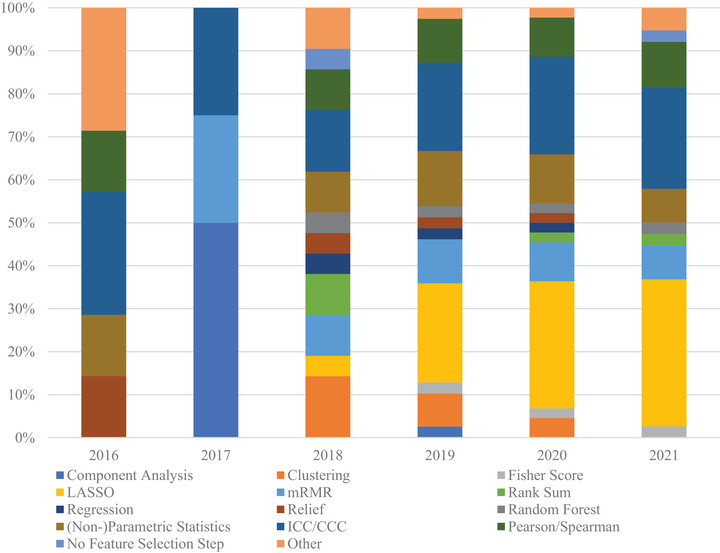

In [26]:
from IPython.display import Image
Image(filename=r"ACM2-24-e13869-g005.jpg")

In [76]:
# Aplicar LASSO com validação cruzada -> para escolher automaticamente o melhor C

Cs = np.logspace(-3,2,30)

lasso_cv_2d = LogisticRegressionCV(
    Cs=Cs,                  
    cv=5,                   
    penalty='l1',           
    solver='liblinear',     # necessário para L1
    scoring='f1_macro',     # métrica que deve ser maximizada durante o processo de validação cruzada (atendendo ao desbalanceamento de classes)
    random_state=42,
    max_iter=5000,
    n_jobs=1              
)
lasso_cv_2d.fit(X_2d_train_scaled, y_2d_train)

lasso_cv_3d = LogisticRegressionCV(
    Cs=Cs,                  
    cv=5,                   
    penalty='l1',           
    solver='liblinear',     # necessário para L1
    scoring='f1_macro',     # métrica que deve ser maximizada durante o processo de validação cruzada (atendendo ao desbalanceamento de classes)
    random_state=42,
    max_iter=5000,
    n_jobs=1              
)

lasso_cv_3d.fit(X_3d_train_scaled, y_3d_train)

LogisticRegressionCV(Cs=array([1.00000000e-03, 1.48735211e-03, 2.21221629e-03, 3.29034456e-03,
       4.89390092e-03, 7.27895384e-03, 1.08263673e-02, 1.61026203e-02,
       2.39502662e-02, 3.56224789e-02, 5.29831691e-02, 7.88046282e-02,
       1.17210230e-01, 1.74332882e-01, 2.59294380e-01, 3.85662042e-01,
       5.73615251e-01, 8.53167852e-01, 1.26896100e+00, 1.88739182e+00,
       2.80721620e+00, 4.17531894e+00, 6.21016942e+00, 9.23670857e+00,
       1.37382380e+01, 2.04335972e+01, 3.03919538e+01, 4.52035366e+01,
       6.72335754e+01, 1.00000000e+02]),
                     cv=5, max_iter=5000, n_jobs=1, penalty='l1',
                     random_state=42, scoring='f1_macro', solver='liblinear')

In [77]:
best_C_2d = lasso_cv_2d.C_[0]
print(f"Melhor valor de C encontrado (2D): {best_C_2d:.4f}")

Melhor valor de C encontrado (2D): 0.1172


In [78]:
best_C_3d = lasso_cv_3d.C_[0]
print(f"Melhor valor de C encontrado (3D): {best_C_3d:.4f}")

Melhor valor de C encontrado (3D): 0.8532


In [79]:
coef_2d = lasso_cv_2d.coef_[0]  
selected_features_2d = X_2d.columns[coef_2d != 0]

print(f"\n{len(selected_features_2d)} features selecionadas (2D):")
print(selected_features_2d.tolist())


8 features selecionadas (2D):
['Subtlety', 'Calcification', 'original_shape2D_PerimeterSurfaceRatio', 'original_glcm_Idn', 'original_glcm_Imc1', 'original_glszm_ZonePercentage', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_ngtdm_Coarseness']


In [80]:
coef_3d = lasso_cv_3d.coef_[0]  
selected_features_3d = X_3d.columns[coef_3d != 0]

print(f"\n{len(selected_features_3d)} features selecionadas (3D):")
print(selected_features_3d.tolist())


16 features selecionadas (3D):
['Margin', 'Subtlety', 'Texture', 'Calcification', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Idmn', 'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_Imc2', 'original_glcm_InverseVariance', 'original_glcm_MCC', 'original_gldm_LargeDependenceLowGrayLevelEmphasis', 'original_ngtdm_Coarseness']


In [81]:
# Guardar numa lista as features selecionadas
selected_features_2d_lasso = selected_features_2d.tolist()
selected_features_3d_lasso = selected_features_3d.tolist()

### 9.2 RFE <a id="rfe"><a/>
[Voltar a Feature Selection](#featureselection)

**O *RFE (Recursive Feature Elimination)* é uma técnica de seleção de features utilizada para identificar as variáveis mais importantes para um modelo de Machine Learning.**

### 1. Objetivo

- Reduzir o número de features do dataset sem perder informação relevante.
- Melhorar a performance do modelo e reduzir overfitting.
- Facilitar a interpretação dos resultados.

### 2. Funcionalidade

- Treina um modelo (ex: **RandomForest**, **XGBoost**, **Logistic Regression**) com todas as features.
- Avalia a importância de cada feature.
- Remove a feature menos importante.

### 3. Esquemática

- Todas as features 
- Treino do modelo → Ranking de importância → Remove a feature menos relevante

In [82]:
print(X_2d_train.shape)
print(X_3d_train.shape)

(306, 109)
(306, 100)


#### RFE simples para múltiplos modelos (RandomForest, XGBoost, SVM)

In [83]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC 

# Definir modelos compatíveis com RFE
models_rfe = {
    'RandomForest': RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        random_state=42,
        eval_metric='logloss',  
        verbosity=0,
        use_label_encoder=False
    ),
    'SVM': LinearSVC( 
        random_state=42,
        max_iter=2000,
        dual=False  
    )
}

def run_rfe_multiple_models(X_train, y_train, models_dict):
    """
    Executa RFE simples para múltiplos modelos e retorna os rankings.
    """
    results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n A executar RFE para {model_name}")
        
        try:
            # Definir RFE
            rfe = RFE(
                estimator=model, 
                n_features_to_select=None, 
                step=1
            )
            
            # Ajustar RFE apenas no treino
            rfe.fit(X_train, y_train)
            
            # Extrair ranking das features
            ranking_df = pd.DataFrame({
                "Feature": X_train.columns,
                "RFE_Rank": rfe.ranking_
            }).sort_values("RFE_Rank")
            
            print(f"Top 10 features ({model_name}) segundo RFE:")
            display(ranking_df.head(10))

            
            worst_features = ranking_df.sort_values("RFE_Rank", ascending=False).head(10)
            print(f"Top 10 worst features ({model_name}) segundo RFE:")
            display(ranking_df.sort_values("RFE_Rank", ascending = False).head(10))
            
            # Armazenar resultados
            results[model_name] = {
                'ranking_df': ranking_df,
                'rfe_object': rfe
            }
            
        except Exception as e:
            print(f"Erro ao executar RFE para {model_name}: {e}")
            continue
    
    return results

# Executar RFE para 2D
print("RFE SIMPLES PARA DATASET 2D:")
rfe_results_2D = run_rfe_multiple_models(X_2d_train,y_2d_train, models_rfe)

print("="*100)
# Executar RFE para 3D
print("\n RFE SIMPLES PARA DATASET 3D:")
rfe_results_3D = run_rfe_multiple_models(X_3d_train, y_3d_train, models_rfe)

ModuleNotFoundError: No module named 'xgboost'

### RFECV (RFE + Cross-Validation)

### Por que utilizar RFE+Cross-Validation?

#### 1. Limitações do RFE simples
- O **RFE tradicional** utiliza todo o conjunto de treinamento para treinar o modelo e classificar as features.
- Overfitting
- Em datasets pequenos ou com **desbalanceamento de classes**, algumas features podem parecer importantes aleatoriamente.

#### 2. Vantagens do RFECV
- O **RFECV** aplica RFE dentro de um esquema de **cross-validation**, avaliando o desempenho do modelo em diferentes folds do dataset.
- Isso permite:
  - Identificar **o número ótimo de features** sem overfitting.
  - Avaliar a **robustez das features** selecionadas.
  - Escolher métricas adequadas para o problema, como `f1_score` em classificações binárias desbalanceadas.
  - Reduz o risco de selecionar features que parecem boas apenas no conjunto de treino.

In [84]:
def run_rfecv_multiple_models(X_train, y_train, models_dict, dataset_name):
    """
    Executa RFECV para múltiplos modelos e retorna os resultados com gráficos.
    """
    results = {}
    
    print(f"\n{'='*60}")
    print(f"EXECUTANDO RFECV PARA DATASET {dataset_name}")
    print(f"{'='*60}")
    
    for i, (model_name, model) in enumerate(models_dict.items(), 1):
        print(f"\n[{i}/3] === Executando RFECV para {model_name} ===")
        
        try:
            # Definir RFECV
            rfecv = RFECV(
                estimator=model,
                step=1,
                scoring='f1',
                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                n_jobs=1
            )
            
            # Ajustar RFECV
            print(f"Treinando RFECV com {model_name}...")
            rfecv.fit(X_train, y_train)
            
            # Extrair ranking das features
            ranking_df = pd.DataFrame({
                "Feature": X_train.columns,
                "RFECV_Rank": rfecv.ranking_
            }).sort_values("RFECV_Rank")
            
            # Features selecionadas (rank = 1)
            selected_features = ranking_df[ranking_df['RFECV_Rank'] == 1]['Feature'].tolist()
            
            print(f"{model_name}: {rfecv.n_features_} features ótimas selecionadas")

            # Gráfico performance vs número de features
            plt.figure(figsize=(10, 6))
            scores = rfecv.cv_results_['mean_test_score']
            n_features = range(1, len(scores) + 1)
            
            plt.plot(n_features, scores, marker='o', linewidth=2, markersize=6)
            plt.axvline(x=rfecv.n_features_, color='red', linestyle='--', 
                       label=f'Ótimo: {rfecv.n_features_} features')
            plt.xlabel("Número de features selecionadas")
            plt.ylabel("Score de validação cruzada (F1-score)")
            plt.title(f"RFECV - {model_name} ({dataset_name})")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
            # Armazenar resultados
            results[model_name] = {
                'ranking_df': ranking_df,
                'rfecv_object': rfecv,
                'optimal_features': rfecv.n_features_,
                'selected_features': selected_features,
                'cv_scores': scores
            }
            
            print(f"{model_name} concluído com sucesso!")
            
        except Exception as e:
            print(f"Erro ao executar RFECV para {model_name}: {e}")
            continue
    
    # Resumo final
    print(f"\n{'='*60}")
    print(f"RESUMO RFECV - DATASET {dataset_name}")
    print(f"{'='*60}")
    for model_name, result in results.items():
        print(f"{model_name}: {result['optimal_features']} features ótimas")
    
    return results

# Executar RFECV para 2D
print(" RFECV COM CROSS-VALIDATION PARA DATASET 2D")
rfecv_results_2D = run_rfecv_multiple_models(X_2d_train, y_2d_train, models_rfe, "2D")

print("\n" + "="*100)
# Executar RFECV para 3D
print("\n RFECV COM CROSS-VALIDATION PARA DATASET 3D")
rfecv_results_3D = run_rfecv_multiple_models(X_3d_train, y_3d_train, models_rfe, "3D")

global selected_features_2d_rfecv_rf, selected_features_2d_rfecv_xgb, selected_features_2d_rfecv_svm
global selected_features_3d_rfecv_rf, selected_features_3d_rfecv_xgb, selected_features_3d_rfecv_svm

# Guardar listas das features selecionadas pelo RFECV
selected_features_2d_rfecv_rf = rfecv_results_2D['RandomForest']['selected_features']
selected_features_2d_rfecv_xgb = rfecv_results_2D['XGBoost']['selected_features']
selected_features_2d_rfecv_svm = rfecv_results_2D['SVM']['selected_features']

selected_features_3d_rfecv_rf = rfecv_results_3D['RandomForest']['selected_features']
selected_features_3d_rfecv_xgb = rfecv_results_3D['XGBoost']['selected_features']
selected_features_3d_rfecv_svm = rfecv_results_3D['SVM']['selected_features']

# Converter para listas explícitas (garantindo formato consistente)
selected_features_2d_rfecv_rf = list(selected_features_2d_rfecv_rf)
selected_features_2d_rfecv_xgb = list(selected_features_2d_rfecv_xgb)
selected_features_2d_rfecv_svm = list(selected_features_2d_rfecv_svm)

selected_features_3d_rfecv_rf = list(selected_features_3d_rfecv_rf)
selected_features_3d_rfecv_xgb = list(selected_features_3d_rfecv_xgb)
selected_features_3d_rfecv_svm = list(selected_features_3d_rfecv_svm)

# Imprimir resumo
print(f"\n{'='*60}")
print("FEATURES RFECV SALVAS PARA USO POSTERIOR")
print(f"{'='*60}")
print(f"2D - RandomForest: {len(selected_features_2d_rfecv_rf)} features")
print(f"2D - XGBoost: {len(selected_features_2d_rfecv_xgb)} features")
print(f"2D - SVM: {len(selected_features_2d_rfecv_svm)} features")
print(f"3D - RandomForest: {len(selected_features_3d_rfecv_rf)} features")
print(f"3D - XGBoost: {len(selected_features_3d_rfecv_xgb)} features")
print(f"3D - SVM: {len(selected_features_3d_rfecv_svm)} features")
print(f"\n{'='*60}")

 RFECV COM CROSS-VALIDATION PARA DATASET 2D


NameError: name 'models_rfe' is not defined

#### Resultado


 ANÁLISE COMPARATIVA RFECV
  Dataset         Model  Optimal_Features  Max_Score
0      2D  RandomForest                13   0.974389
1      2D       XGBoost                 6   0.971402
2      2D           SVM                14   0.958919
3      3D  RandomForest                40   0.971590
4      3D       XGBoost                12   0.965139
5      3D           SVM                 5   0.918313


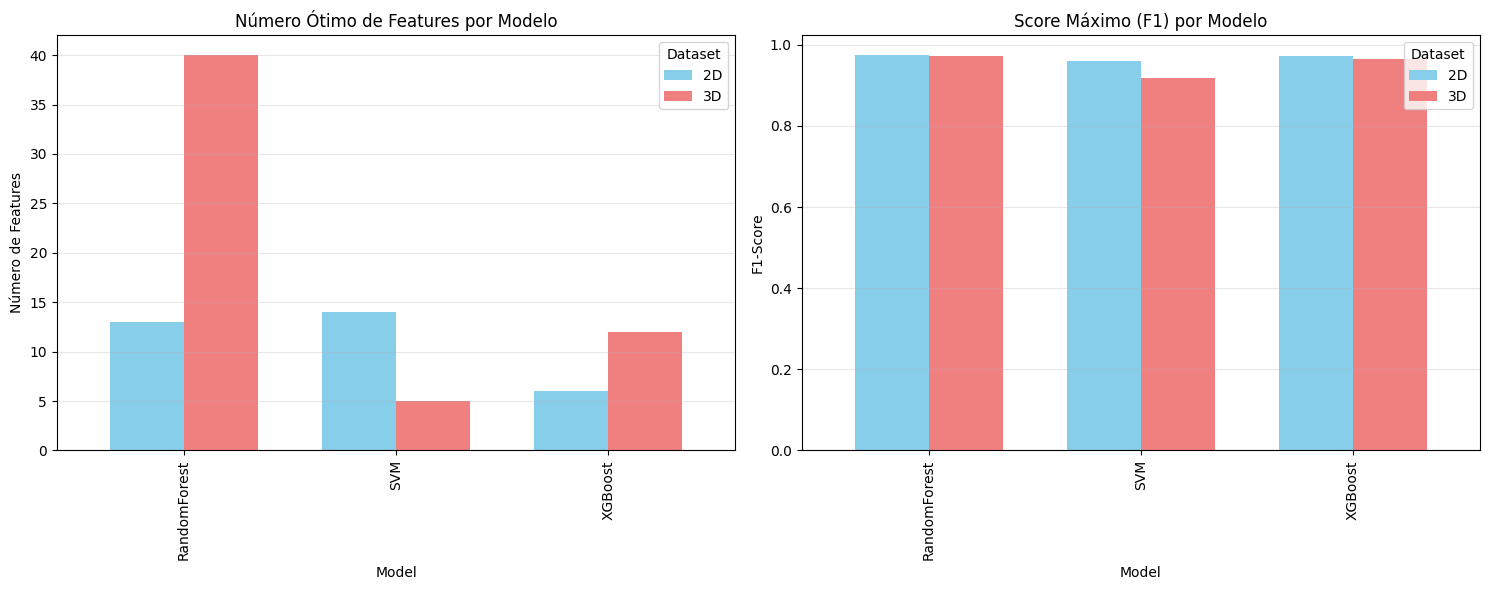

In [32]:
comparison_data = []
for dataset_name, results in [("2D", rfecv_results_2D), ("3D", rfecv_results_3D)]:
    for model_name, result in results.items():
        cv_scores = result.get('cv_scores', [])
        max_score = max(cv_scores) if len(cv_scores) > 0 else None
        comparison_data.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Optimal_Features': result.get('optimal_features', None),
            'Max_Score': max_score
        })

# Criar DataFrame comparativo
comparison_df = pd.DataFrame(comparison_data)
print("\n ANÁLISE COMPARATIVA RFECV")
print("=" * 60)
print(comparison_df)

# ==========================================================
# Gráficos comparativos
# ==========================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Número ótimo de features
comparison_df.pivot(index='Model', columns='Dataset', values='Optimal_Features').plot(
    kind='bar', ax=ax1, color=['skyblue', 'lightcoral'], width=0.7
)
ax1.set_title('Número Ótimo de Features por Modelo')
ax1.set_ylabel('Número de Features')
ax1.legend(title='Dataset')
ax1.grid(axis='y', alpha=0.3)

# Score máximo alcançado
comparison_df.pivot(index='Model', columns='Dataset', values='Max_Score').plot(
    kind='bar', ax=ax2, color=['skyblue', 'lightcoral'], width=0.7
)
ax2.set_title('Score Máximo (F1) por Modelo')
ax2.set_ylabel('F1-Score')
ax2.legend(title='Dataset')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [33]:
def analyze_rfecv_consensus(rfecv_results, dataset_name):
    """
    Analisa consenso entre features selecionadas por RFECV.
    """
    print(f"\n{'='*70}")
    print(f"CONSENSO RFECV - {dataset_name}")
    print(f"{'='*70}")

    selected_by_model = {}

    # Guardar features de cada modelo
    for model_name, result in rfecv_results.items():
        features = result.get('selected_features', [])
        selected_by_model[model_name] = set(features)
        print(f"{model_name}: {len(features)} features selecionadas")

    # Garantir que há pelo menos 2 modelos para comparar
    if len(selected_by_model) < 2:
        print("Apenas um modelo encontrado — consenso não aplicável.")
        return {}

    # Features selecionadas por TODOS os modelos
    consensus_all = set.intersection(*selected_by_model.values())
    print(f"\n🟩 Features selecionadas por TODOS os modelos ({len(consensus_all)}):")
    for feature in sorted(consensus_all):
        print(f"  - {feature}")

    # Features selecionadas por PELO MENOS 2 modelos
    consensus_2plus = set()
    all_features = set().union(*selected_by_model.values())

    for feature in all_features:
        count = sum(feature in fset for fset in selected_by_model.values())
        if count >= 2:
            consensus_2plus.add(feature)

    print(f"\n🟦 Features selecionadas por ≥2 modelos ({len(consensus_2plus)}):")
    for feature in sorted(consensus_2plus):
        count = sum(feature in fset for fset in selected_by_model.values())
        models_list = [model for model, fset in selected_by_model.items() if feature in fset]
        print(f"  - {feature} ({count}/3 modelos: {', '.join(models_list)})")

    return {
        'consensus_all': consensus_all,
        'consensus_2plus': consensus_2plus,
        'selected_by_model': selected_by_model
    }

consensus_2D = analyze_rfecv_consensus(rfecv_results_2D, "2D")
consensus_3D = analyze_rfecv_consensus(rfecv_results_3D, "3D")


CONSENSO RFECV - 2D
RandomForest: 13 features selecionadas
XGBoost: 6 features selecionadas
SVM: 14 features selecionadas

🟩 Features selecionadas por TODOS os modelos (0):

🟦 Features selecionadas por ≥2 modelos (7):
  - Calcification (2/3 modelos: RandomForest, XGBoost)
  - original_glcm_Imc2 (2/3 modelos: RandomForest, XGBoost)
  - original_gldm_GrayLevelNonUniformity (2/3 modelos: RandomForest, XGBoost)
  - original_glrlm_GrayLevelNonUniformity (2/3 modelos: RandomForest, XGBoost)
  - original_glszm_GrayLevelNonUniformity (2/3 modelos: RandomForest, XGBoost)
  - original_ngtdm_Strength (2/3 modelos: RandomForest, SVM)
  - original_shape2D_MeshSurface (2/3 modelos: RandomForest, XGBoost)

CONSENSO RFECV - 3D
RandomForest: 40 features selecionadas
XGBoost: 12 features selecionadas
SVM: 5 features selecionadas

🟩 Features selecionadas por TODOS os modelos (1):
  - original_glcm_ClusterShade

🟦 Features selecionadas por ≥2 modelos (10):
  - Calcification (2/3 modelos: RandomForest, XG

### 9.3 SVM <a id="svm"><a/>
[Voltar a Feature Selection](#featureselection)

**Nesta etapa, foi implementado um classificador SVM (Support Vector Machine) com função de custo linear para as versões 2D e 3D do conjunto de dados. O objetivo é identificar o valor ideal do hiperparâmetro 𝐶 que controla o grau de penalização por erros de classificação no processo de aprendizado.**

In [34]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Definir modelo base (SVM Linear L1)
svc = LinearSVC(penalty='l1', dual=False, max_iter=10000, random_state=42)

# Pesquisa do melhor C via validação cruzada
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_2d = GridSearchCV(svc, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
grid_3d = GridSearchCV(svc, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)

grid_2d.fit(X_2d_train_scaled, y_2d_train)
grid_3d.fit(X_3d_train_scaled, y_3d_train)

print(f"Melhor C encontrado (2D): {grid_2d.best_params_['C']}")
print(f"Melhor C encontrado (3D): {grid_3d.best_params_['C']}")

Melhor C encontrado (2D): 100
Melhor C encontrado (3D): 0.1


**Após a etapa de otimização do hiperparâmetro 𝐶 são ajustados os modelos finais de SVM Linear utilizando os valores ideais encontrados para cada representação (2D e 3D). Em seguida, aplica-se a técnica de seleção de atributos baseada em pesos do modelo.**

In [35]:
# Ajustar modelos finais com os melhores C
svc_2d = LinearSVC(penalty='l1', dual=False, C=grid_2d.best_params_['C'], max_iter=10000, random_state=42)
svc_3d = LinearSVC(penalty='l1', dual=False, C=grid_3d.best_params_['C'], max_iter=10000, random_state=42)

svc_2d.fit(X_2d_train_scaled, y_2d_train)
svc_3d.fit(X_3d_train_scaled, y_3d_train)

# Selecionar features
selector_2d = SelectFromModel(svc_2d, prefit=True, threshold='mean')
selector_3d = SelectFromModel(svc_3d, prefit=True, threshold='mean')

selected_features_2d_svm = X_2d_train.columns[selector_2d.get_support()]
selected_features_3d_svm = X_3d_train.columns[selector_3d.get_support()]

print(f"Número de features selecionadas (2D): {len(selected_features_2d)}")
print(f"Número de features selecionadas (3D): {len(selected_features_3d)}")

print("\nFeatures selecionadas (2D):", list(selected_features_2d))
print("\nFeatures selecionadas (3D):", list(selected_features_3d))

Número de features selecionadas (2D): 8
Número de features selecionadas (3D): 16

Features selecionadas (2D): ['Subtlety', 'Calcification', 'original_shape2D_PerimeterSurfaceRatio', 'original_glcm_Idn', 'original_glcm_Imc1', 'original_glszm_ZonePercentage', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_ngtdm_Coarseness']

Features selecionadas (3D): ['Margin', 'Subtlety', 'Texture', 'Calcification', 'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Idmn', 'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_Imc2', 'original_glcm_InverseVariance', 'original_glcm_MCC', 'original_gldm_LargeDependenceLowGrayLevelEmphasis', 'original_ngtdm_Coarseness']


**Nesta etapa, é realizada a interpretação dos coeficientes obtidos pelos modelos SVM com regularização L1. Como o LinearSVC utiliza uma função de decisão linear, os coeficientes associados a cada feature representam diretamente sua importância na separação das classes.**

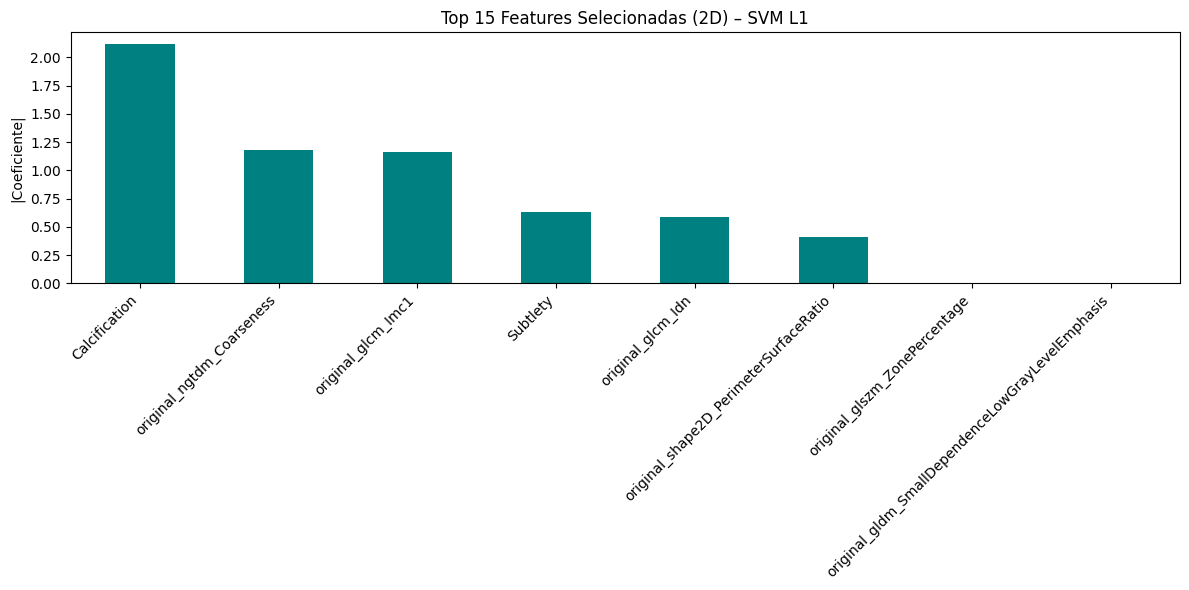

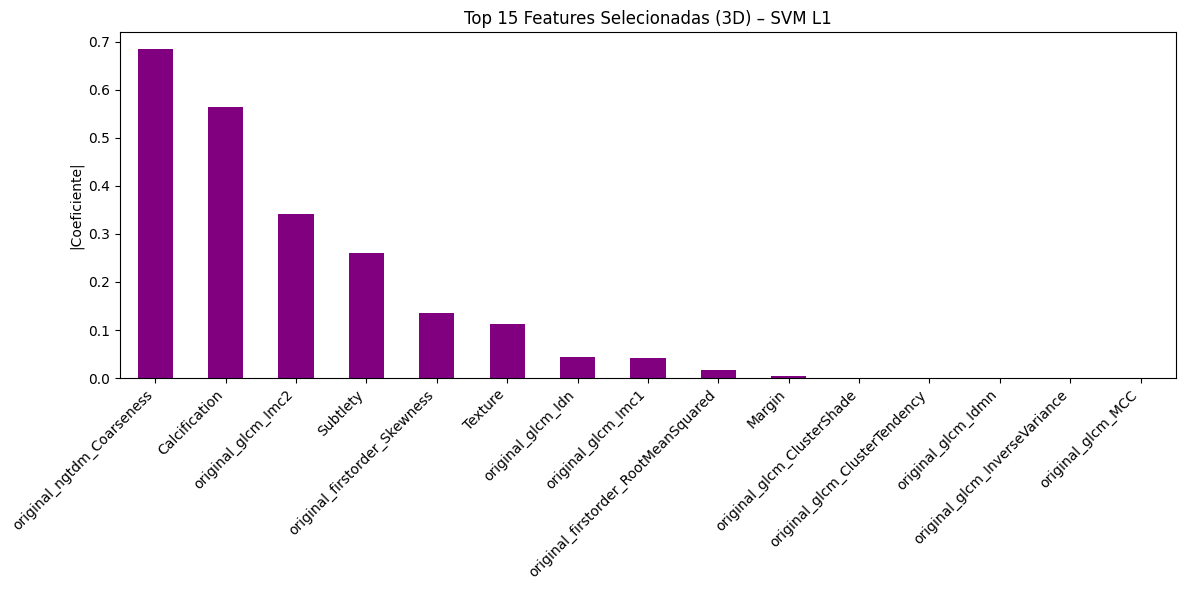

In [36]:
# Importâncias (coeficientes absolutos)
coef_2d = np.abs(svc_2d.coef_).ravel()
coef_3d = np.abs(svc_3d.coef_).ravel()

importances_2d = pd.Series(coef_2d, index=X_2d_train.columns).loc[selected_features_2d].sort_values(ascending=False)
importances_3d = pd.Series(coef_3d, index=X_3d_train.columns).loc[selected_features_3d].sort_values(ascending=False)

# Top 15 features
top_2d = importances_2d.head(15)
top_3d = importances_3d.head(15)

plt.figure(figsize=(12,6))
top_2d.plot(kind='bar', color='teal')
plt.title("Top 15 Features Selecionadas (2D) – SVM L1")
plt.ylabel("|Coeficiente|")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
top_3d.plot(kind='bar', color='purple')
plt.title("Top 15 Features Selecionadas (3D) – SVM L1")
plt.ylabel("|Coeficiente|")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 10. Modelos ML <a id="modelos"><a/>
[Voltar ao Índice](#indice)

#### Nesta etapa, procedeu-se ao treino e avaliação de três modelos de classificação distintos, utilizando os datasets radiômicos 2D e 3D. O objetivo é comparar o desempenho dos modelos com e sem seleção de features, de modo a avaliar o impacto das diferentes estratégias de redução de dimensionalidade no desempenho final.
#### Cada modelo foi treinado em quatro versões dos dados:
- Sem seleção de features;
- Com seleção via LASSO (L1);
- Com seleção via RFE;
- Com seleção baseada em SVM;

#### Esta comparação permite identificar não só o melhor modelo, mas também a estratégia de seleção de atributos mais eficaz para o problema em análise.

In [56]:
feature_sets_2d = {
    'LASSO_2D': selected_features_2d_lasso,
    
    'RFECV_RandomForest_2D': selected_features_2d_rfecv_rf,
    'RFECV_XGBoost_2D': selected_features_2d_rfecv_xgb,
    'RFECV_LinearSVM_2D': selected_features_2d_rfecv_svm,
    
    'SVM': selected_features_2d_svm
}

feature_sets_3d = {
    'LASSO_3D': selected_features_3d_lasso,
    
    'RFECV_RandomForest_3D': selected_features_3d_rfecv_rf,
    'RFECV_XGBoost_3D': selected_features_3d_rfecv_xgb,
    'RFECV_LinearSVM_3D': selected_features_3d_rfecv_svm,
    
    'SVM': selected_features_3d_svm
}

#### Para avaliar o desempenho dos modelos, foram utilizadas as seguintes métricas:

+ **Accuracy** 

##### Mede a proporção total de previsões corretas.
##### É útil para ter uma visão global do desempenho, mas pode ser enganadora quando há desbalanceamento entre classes.
$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

+ **Precision**
##### Indica a percentagem de previsões positivas que estavam corretas.
##### É particularmente importante neste contexto onde falsos positivos devem ser minimizados.
$$Precision = \frac{TP}{TP + FP}$$

+ **Recall** 
##### Mede a capacidade do modelo conseguir identificar corretamente os verdadeiros positivos.
##### É relevante em cenários médicos onde falsos negativos são críticos (ex.: deteção de nódulos malignos).
$$Recall = \frac{TP}{TP + FN}$$

+ **F1-Score**
##### É a média harmónica entre precision e recall, equilibrando ambas as métricas.
##### É preferível à accuracy em datasets desbalanceados, pois pondera tanto a completude quanto a precisão do modelo.
$$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

+ **Log Loss**
##### Em aplicações médicas, não basta saber se o modelo acertou, é crucial saber com que grau de confiança ele fez essa previsão.
$$LogLoss = -\frac{1}{N} \sum_{i=1}^{N} \Big[ y_i \log(\hat{p}_i) + (1 - y_i) \log(1 - \hat{p}_i) \Big]$$

+ **AUC**
##### É especialmente relevante, pois mostra o equilíbrio entre detetar corretamente nódulos malignos (sensibilidade) e evitar alarmes falsos (especificidade), refletindo a capacidade do modelo de apoiar decisões médicas de forma confiável.

#### Função auxiliar de avaliação

In [1]:
# Função para calcular todas as métricas de avaliação
def calculate_metrics(y_true, y_pred, y_prob):

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Garantir formato correto das probabilidades
    if len(y_prob.shape) > 1:
        y_prob = y_prob[:, 1]  # Probabilidades da classe positiva

    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        roc_auc = np.nan  # se não houver variação nas classes
    
    try:
        loss = log_loss(y_true, y_prob)
    except ValueError:
        loss = np.nan  # se houver problemas numéricos
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': roc_auc,
        'Log Loss': loss
    }


### 10.1 Random Forest <a id="randomforest"><a/>
[Voltar a Modelos ML](#modelos)

#### Entre os métodos de classificação, o Random Forest destaca-se pela sua versatilidade e estabilidade. É particularmente eficiente em lidar com datasets complexos e ruidosos, mantendo um bom desempenho mesmo em situações de sobreposição entre variáveis

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, log_loss)

#### 10.1.1 Random Forest sem feature selection <a id="rfsem"><a/>
[Voltar a Random Forest](#randomforest)

In [138]:
# Lista para resultados detalhados
all_folds_results = []

# Lista de datasets
datasets = {
    '2D': (X_2d_train, y_2d_train),
    '3D': (X_3d_train, y_3d_train)
}

k = 5
random_state = 42

for dataset_name, (X_data, y_data) in datasets.items():
    print(f"\nTreinando RF com {dataset_name} — K-Fold CV (k={k})")
    
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    fold_num = 1
    
    for train_idx, test_idx in kf.split(X_data):
        X_train, X_test = X_data.iloc[train_idx], X_data.iloc[test_idx]
        y_train, y_test = y_data.iloc[train_idx], y_data.iloc[test_idx]
        
        # Treinar Random Forest
        model = RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        
        # Predições
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Calcular métricas
        metrics = calculate_metrics(y_test, y_pred, y_prob)
        metrics['Dataset'] = dataset_name
        metrics['Fold'] = fold_num
        
        all_folds_results.append(metrics)
        fold_num += 1

# DataFrame final com todos os folds
results_rf_all_folds = pd.DataFrame(all_folds_results)
results_rf_all_folds = results_rf_all_folds[['Dataset', 'Fold', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Log Loss']]

print("Resultados RF sem feature selection (K-Fold 5):")
display(results_rf_all_folds)


Treinando RF com 2D — K-Fold CV (k=5)

Treinando RF com 3D — K-Fold CV (k=5)
Resultados RF sem feature selection (K-Fold 5):


Dataset  Fold  Accuracy  Precision    Recall  F1-Score   AUC-ROC  Log Loss
0      2D     1  0.935484   0.933333  0.933333  0.933333  0.989583  0.127813
1      2D     2  1.000000   1.000000  1.000000  1.000000  1.000000  0.049429
2      2D     3  0.967213   0.971429  0.971429  0.971429  0.996703  0.079987
3      2D     4  0.934426   0.966667  0.906250  0.935484  0.989224  0.147588
4      2D     5  1.000000   1.000000  1.000000  1.000000  1.000000  0.023806
5      3D     1  0.935484   0.964286  0.900000  0.931034  0.987500  0.143430
6      3D     2  0.934426   0.914286  0.969697  0.941176  0.991342  0.113551
7      3D     3  0.983607   1.000000  0.971429  0.985507  1.000000  0.073603
8      3D     4  0.934426   0.937500  0.937500  0.937500  0.991918  0.134355
9      3D     5  1.000000   1.000000  1.000000  1.000000  1.000000  0.029778

#### 10.1.2 Random Forest com diferentes conjuntos de features <a id="rffeatures"><a/>
[Voltar a Random Forest](#randomforest)

In [49]:
# Gráficos que mostram as métricas por fold e suas respetivas médias - ver o melhor fold
def plot_fold_metrics(accuracies, precisions, recalls, f1s, aucs, losses):
    
    metrics = {
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1-Score': f1s,
        'AUC-ROC': aucs,
        'Log Loss': losses
    }

    colors = {
        'Accuracy': 'royalblue',
        'Precision': 'darkorange',
        'Recall': 'seagreen',
        'F1-Score': 'mediumvioletred',
        'AUC-ROC': 'teal',
        'Log Loss': 'crimson'
    }

    n_metrics = len(metrics)
    n_cols = 3
    n_rows = int(np.ceil(n_metrics / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6))
    axes = axes.flatten()

    for i, (metric_name, values) in enumerate(metrics.items()):
        ax = axes[i]
        folds = np.arange(1, len(values) + 1)
        avg = np.nanmean(values)
        ax.bar(folds, values, color=colors[metric_name], alpha=0.8)
        ax.set_title(f"{metric_name} (média: {avg:.3f})", fontsize=11)
        ax.set_xlabel("Fold")
        ax.set_ylabel(metric_name)
        ax.set_xticks(folds)
        ax.grid(axis='y', linestyle='--', alpha=0.6)

    # Esconde gráficos vazios (caso número de métricas < nº de subplots)
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Função Random Forest com K-Fold CV (detalhado por fold)
def run_random_forest_kfold_report(feature_sets, merged_df, k=5, random_state=42):
    
    all_folds_results = []  # <-- guarda resultados individuais (para ANOVA)
    avg_results = {}        # <-- guarda médias por feature set (para gráfico)

    for feature_set_name, features in feature_sets.items():
        print(f"\nA treinar Random Forest com feature set: {feature_set_name} ({len(features)} variáveis)")

        X = merged_df[features]
        y = merged_df['Malignancy']

        kf = KFold(n_splits=k, shuffle=True, random_state=random_state)

        # armazenar métricas por fold
        accuracies, precisions, recalls, f1s, aucs, losses = [], [], [], [], [], []

        fold = 1
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            model = RandomForestClassifier(
                n_estimators=300,
                random_state=random_state,
                n_jobs=-1
            )

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]

            # Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(4, 3))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
            plt.title(f"Confusion Matrix — {feature_set_name} (Fold {fold})")
            plt.xlabel("Predito")
            plt.ylabel("Verdadeiro")
            plt.show()

            # Calcular métricas
            metrics = calculate_metrics(y_test, y_pred, y_prob)

            # Guardar resultados do fold
            all_folds_results.append({
                'Feature_Set': feature_set_name,
                'Fold': fold,
                'Accuracy': metrics['Accuracy'],
                'Precision': metrics['Precision'],
                'Recall': metrics['Recall'],
                'F1-Score': metrics['F1-Score'],
                'AUC-ROC': metrics['AUC-ROC'],
                'Log Loss': metrics['Log Loss']
            })

            accuracies.append(metrics['Accuracy'])
            precisions.append(metrics['Precision'])
            recalls.append(metrics['Recall'])
            f1s.append(metrics['F1-Score'])
            aucs.append(metrics['AUC-ROC'])
            losses.append(metrics['Log Loss'])

            fold += 1

        # Gráfico de métricas por fold
        print(f"\nGráfico de métricas por fold — {feature_set_name}")
        plot_fold_metrics(accuracies, precisions, recalls, f1s, aucs, losses)

        # Calcular médias para gráfico final
        avg_results[feature_set_name] = {
            'Accuracy': np.mean(accuracies),
            'Precision': np.mean(precisions),
            'Recall': np.mean(recalls),
            'F1-Score': np.mean(f1s),
            'AUC-ROC': np.nanmean(aucs),
            'Log Loss': np.nanmean(losses)
        }

    # DataFrame com as médias (para gráfico)
    avg_df = pd.DataFrame(avg_results).T[
        ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Log Loss']
    ].sort_values(by='AUC-ROC', ascending=False)

    # Gráfico das médias
    plt.figure(figsize=(10, 6))
    avg_df.drop(columns=['Log Loss']).plot(
        kind='bar', figsize=(10, 6), width=0.8,
        colormap='viridis'
    )
    plt.title("Random Forest — Métricas médias por conjunto de features")
    plt.ylabel("Valor médio")
    plt.xticks(rotation=0)
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    print("\nAvaliação final concluída :)")

    # DataFrame completo com todos os folds
    detailed_df = pd.DataFrame(all_folds_results)

    # Retornar ambos: detalhado (para ANOVA) e médias (para gráfico)
    return detailed_df, avg_df

#### 10.1.3 Resultados Random Forest <a id="rfresultados"><a/>
[Voltar a Random Forest](#randomforest)


A treinar Random Forest com feature set: LASSO_2D (8 variáveis)


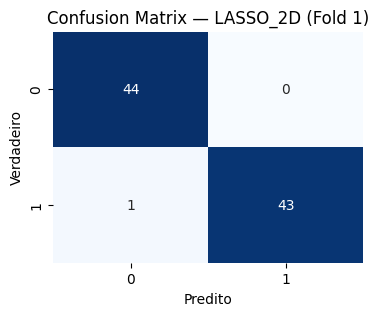

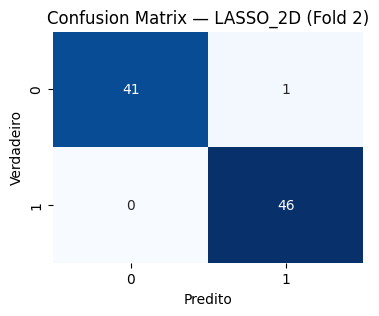

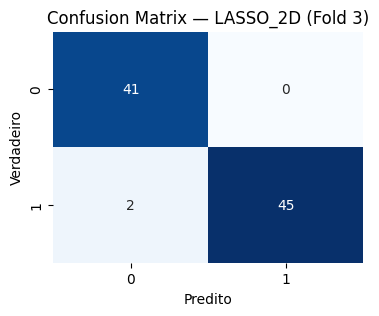

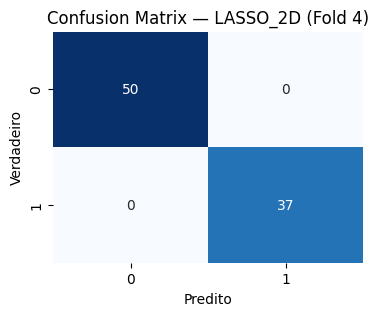

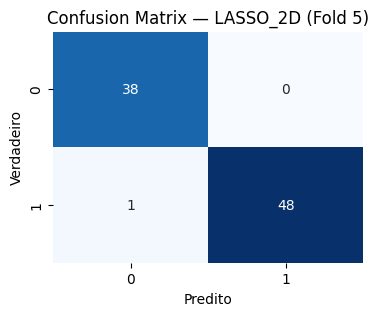


Gráfico de métricas por fold — LASSO_2D


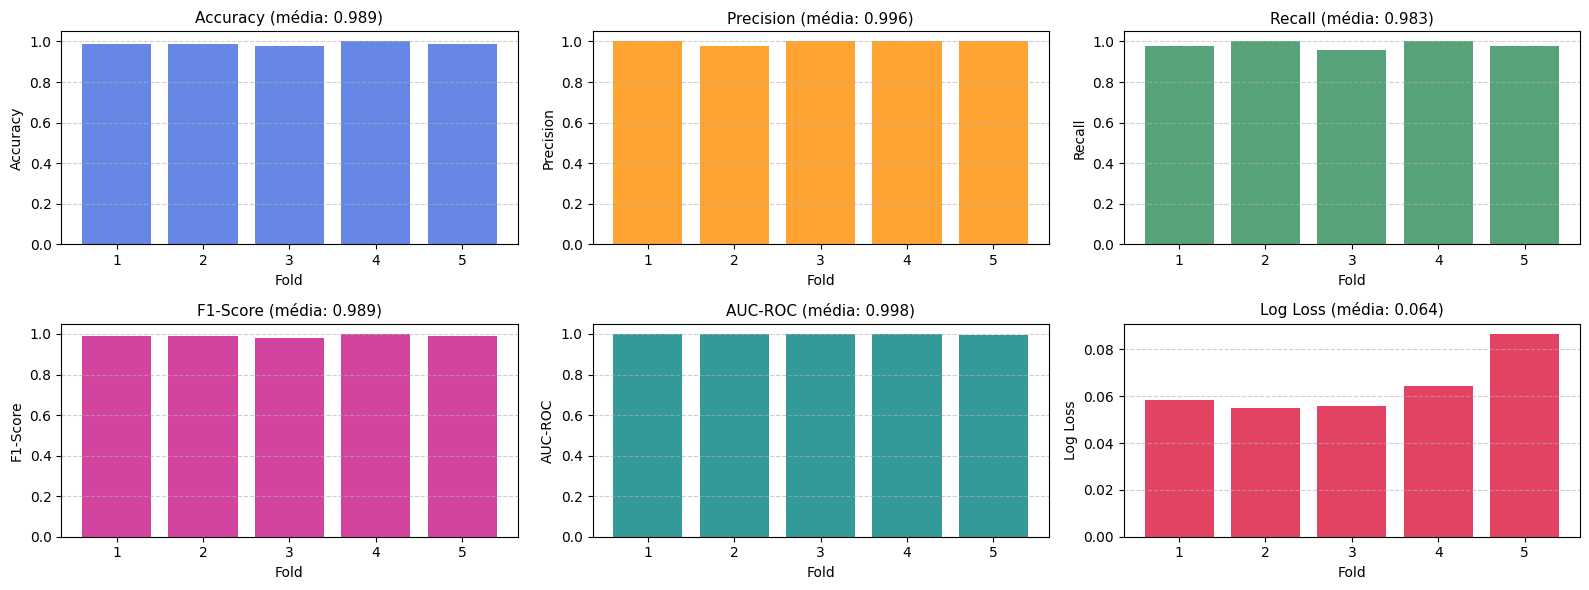


A treinar Random Forest com feature set: RFECV_RandomForest_2D (13 variáveis)


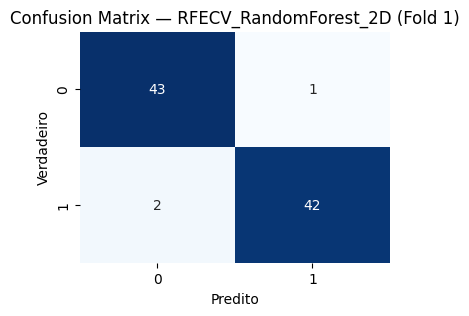

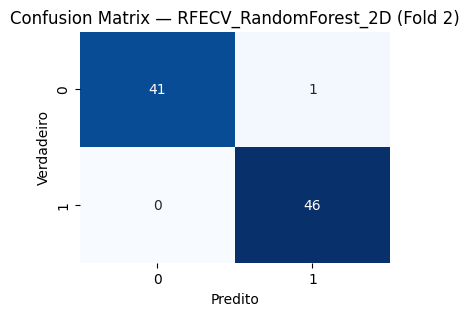

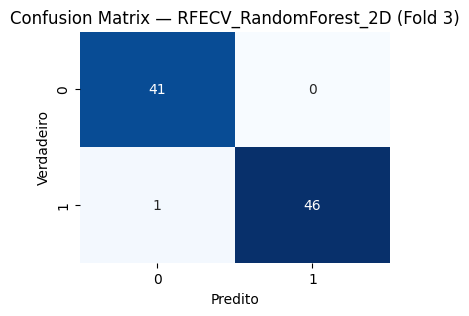

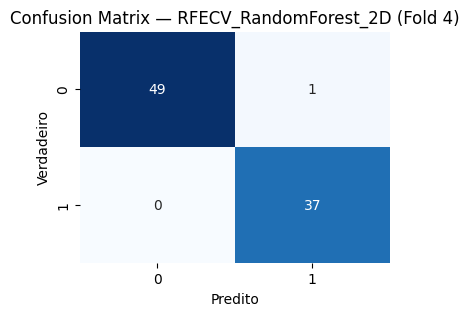

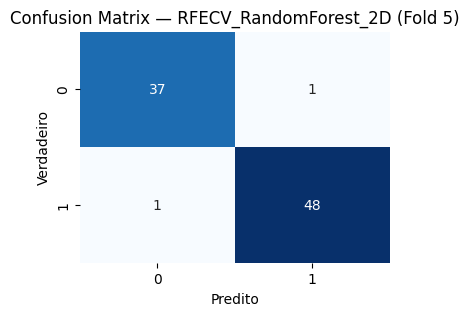


Gráfico de métricas por fold — RFECV_RandomForest_2D


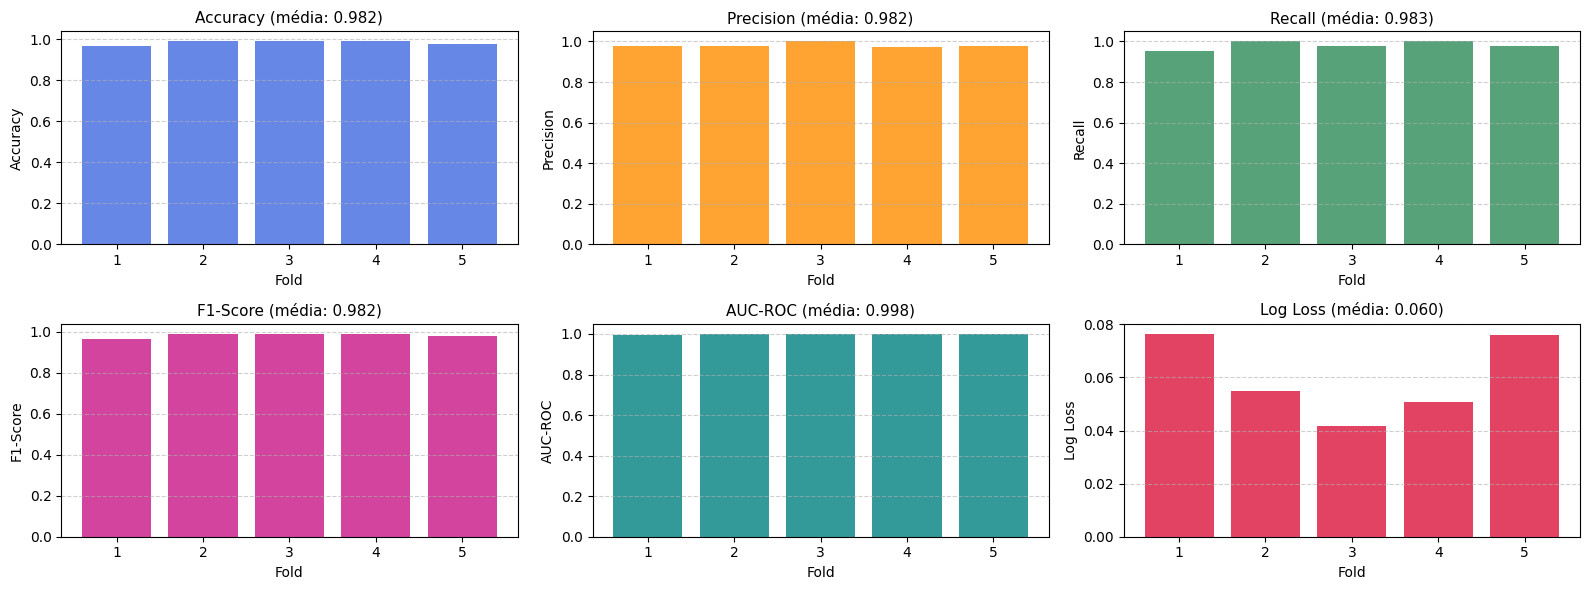


A treinar Random Forest com feature set: RFECV_XGBoost_2D (6 variáveis)


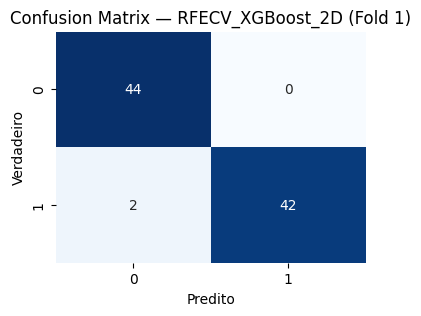

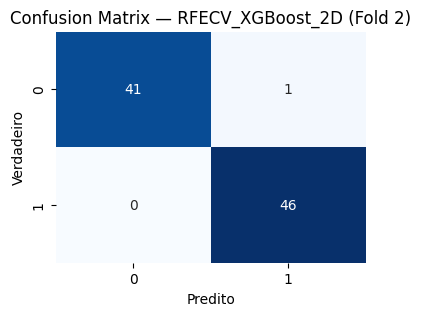

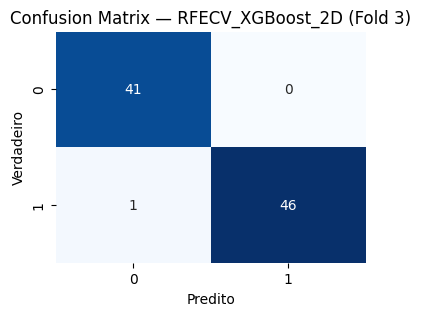

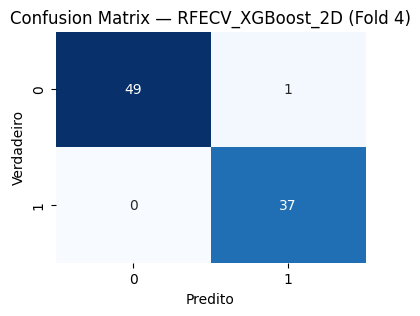

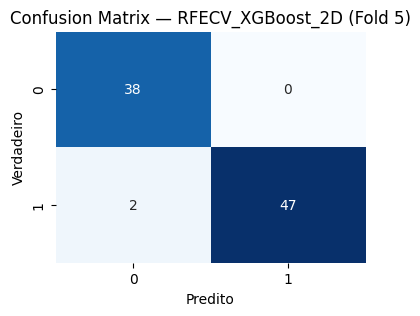


Gráfico de métricas por fold — RFECV_XGBoost_2D


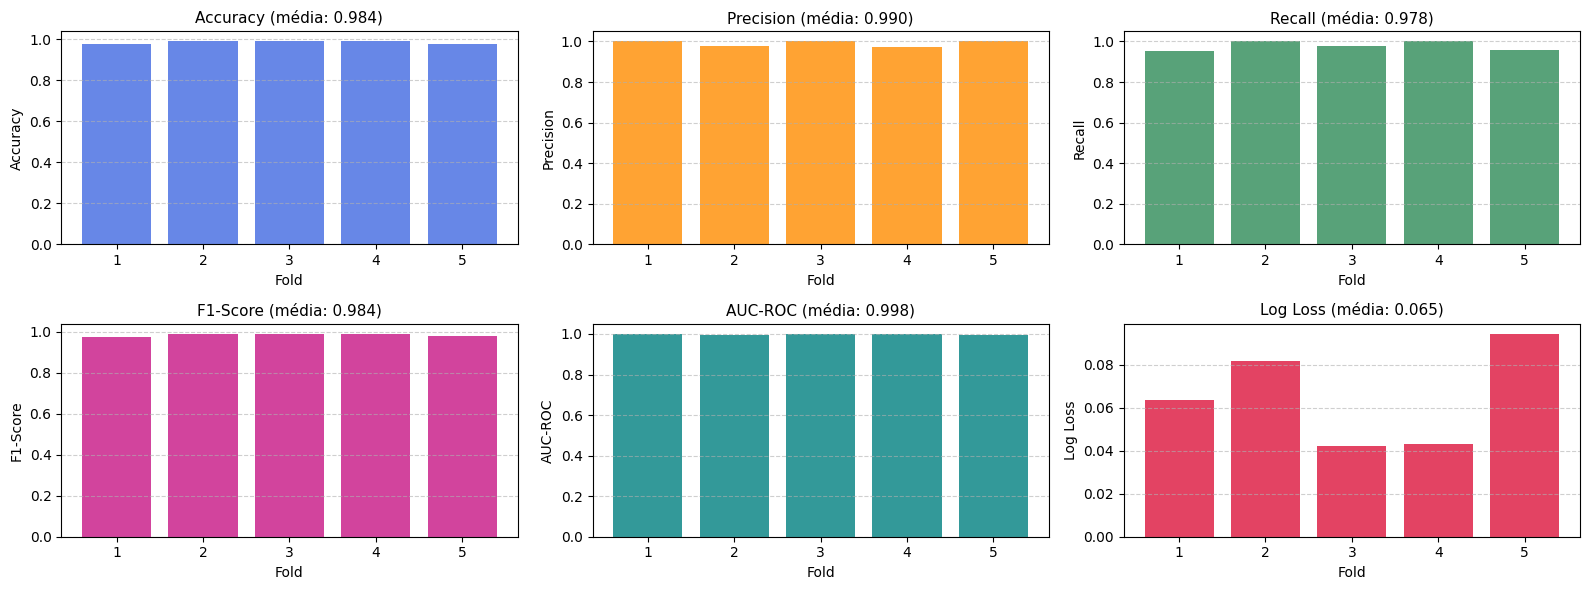


A treinar Random Forest com feature set: RFECV_LinearSVM_2D (14 variáveis)


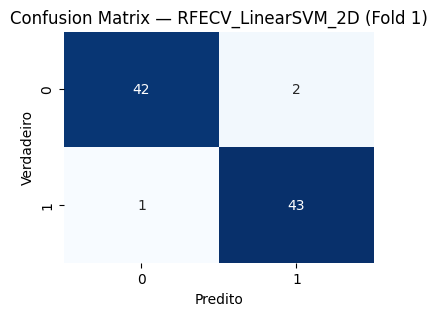

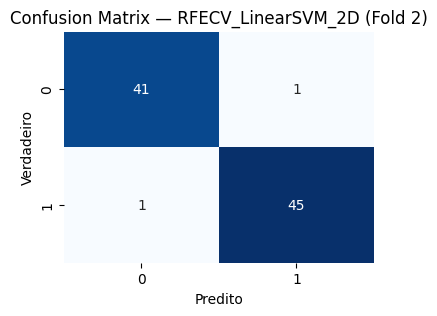

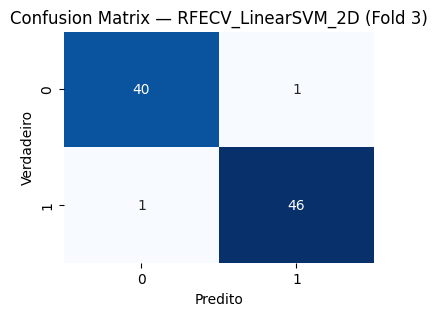

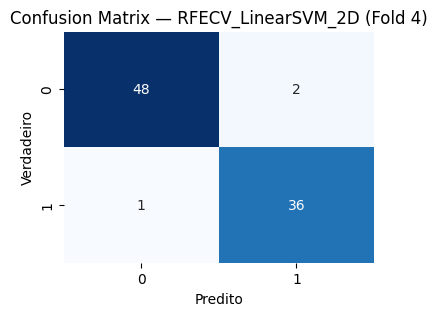

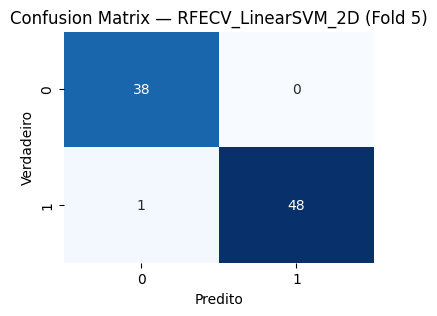


Gráfico de métricas por fold — RFECV_LinearSVM_2D


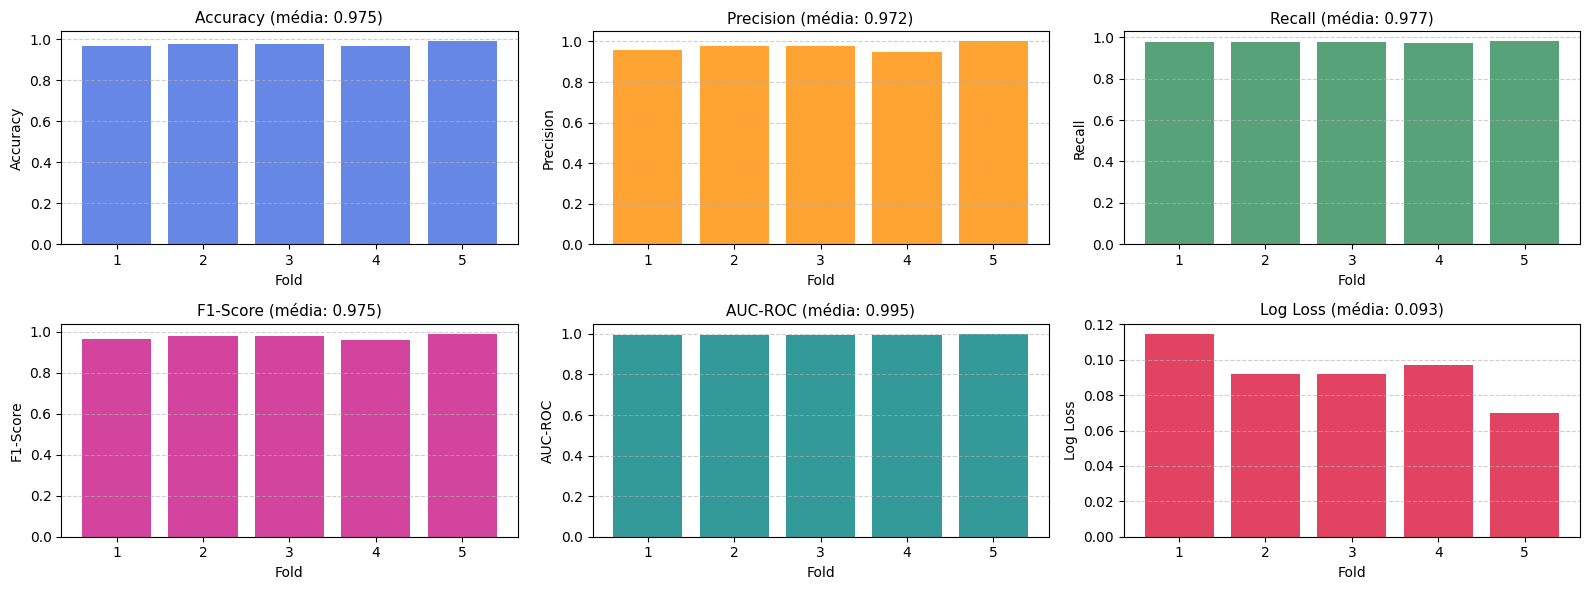


A treinar Random Forest com feature set: SVM (23 variáveis)


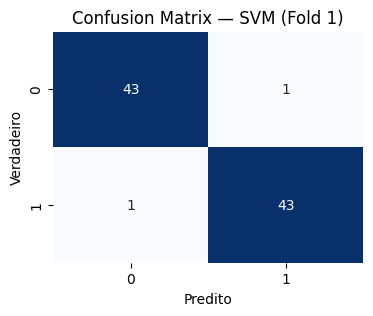

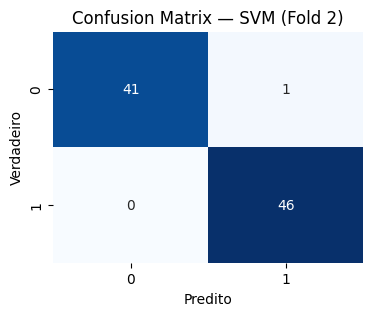

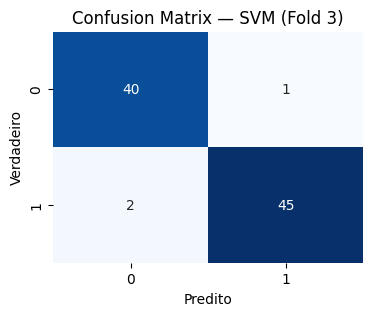

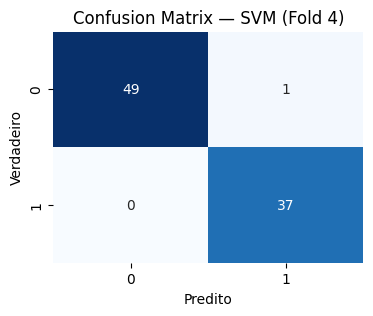

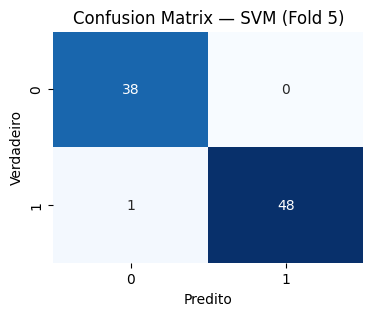


Gráfico de métricas por fold — SVM


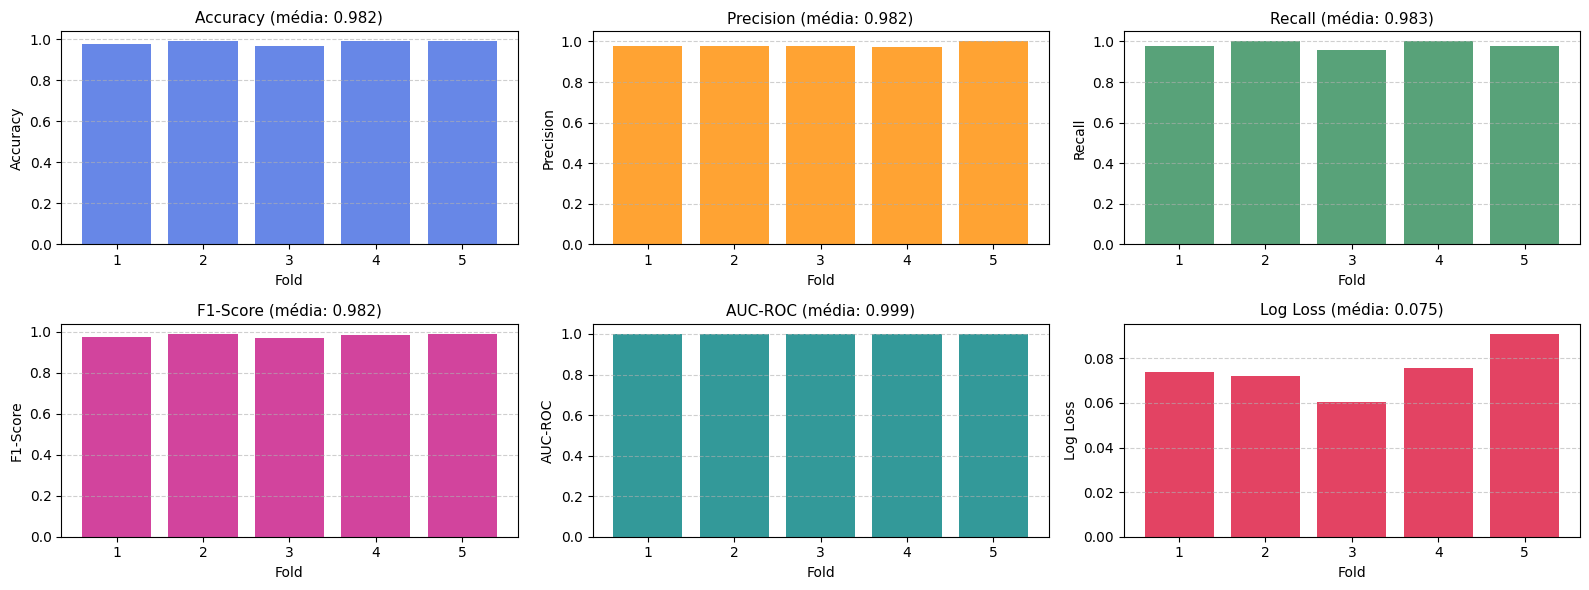

<Figure size 1000x600 with 0 Axes>

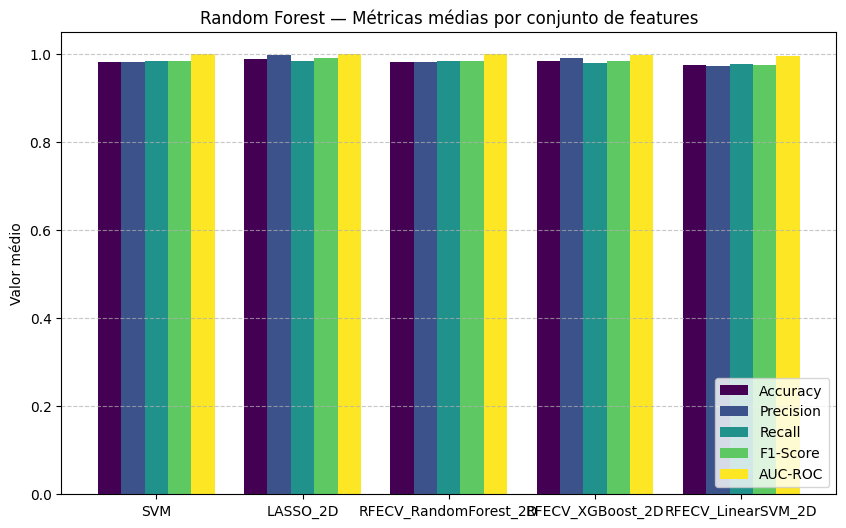


Avaliação final concluída :)


Feature_Set  Fold  Accuracy  Precision    Recall  F1-Score  \
0                LASSO_2D     1  0.988636   1.000000  0.977273  0.988506   
1                LASSO_2D     2  0.988636   0.978723  1.000000  0.989247   
2                LASSO_2D     3  0.977273   1.000000  0.957447  0.978261   
3                LASSO_2D     4  1.000000   1.000000  1.000000  1.000000   
4                LASSO_2D     5  0.988506   1.000000  0.979592  0.989691   
5   RFECV_RandomForest_2D     1  0.965909   0.976744  0.954545  0.965517   
6   RFECV_RandomForest_2D     2  0.988636   0.978723  1.000000  0.989247   
7   RFECV_RandomForest_2D     3  0.988636   1.000000  0.978723  0.989247   
8   RFECV_RandomForest_2D     4  0.988506   0.973684  1.000000  0.986667   
9   RFECV_RandomForest_2D     5  0.977011   0.979592  0.979592  0.979592   
10       RFECV_XGBoost_2D     1  0.977273   1.000000  0.954545  0.976744   
11       RFECV_XGBoost_2D     2  0.988636   0.978723  1.000000  0.989247   
12       RFECV_XGBoost_2D     3  0.988636   1.000000  0.978723  0.989247   
13       RFECV_XGBoost_2D     4  0.988506   0.973684  1.000000  0.986667   
14       RFECV_XGBoost_2D     5  0.977011   1.000000  0.959184  0.979167   
15     RFECV_LinearSVM_2D     1  0.965909   0.955556  0.977273  0.966292   
16     RFECV_LinearSVM_2D     2  0.977273   0.978261  0.978261  0.978261   
17     RFECV_LinearSVM_2D     3  0.977273   0.978723  0.978723  0.978723   
18     RFECV_LinearSVM_2D     4  0.965517   0.947368  0.972973  0.960000   
19     RFECV_LinearSVM_2D     5  0.988506   1.000000  0.979592  0.989691   
20                    SVM     1  0.977273   0.977273  0.977273  0.977273   
21                    SVM     2  0.988636   0.978723  1.000000  0.989247   
22                    SVM     3  0.965909   0.978261  0.957447  0.967742   
23                    SVM     4  0.988506   0.973684  1.000000  0.986667   
24                    SVM     5  0.988506   1.000000  0.979592  0.989691   

     AUC-ROC  Log Loss  
0   0.998967  0.058495  
1   0.998447  0.054960  
2   0.998962  0.055622  
3   1.000000  0.064213  
4   0.995166  0.086587  
5   0.996384  0.076369  
6   0.997412  0.054740  
7   0.998443  0.041720  
8   1.000000  0.050819  
9   0.997852  0.075999  
10  0.997676  0.063703  
11  0.996118  0.081537  
12  0.998443  0.041962  
13  1.000000  0.043236  
14  0.995972  0.094209  
15  0.992252  0.114627  
16  0.991977  0.092157  
17  0.994811  0.091982  
18  0.995676  0.096964  
19  0.999463  0.070227  
20  0.999225  0.073966  
21  0.997412  0.071955  
22  0.998962  0.060378  
23  1.000000  0.075497  
24  0.997852  0.090967

Accuracy  Precision    Recall  F1-Score   AUC-ROC  \
SVM                    0.981766   0.981588  0.982862  0.982124  0.998690   
LASSO_2D               0.988610   0.995745  0.982862  0.989141  0.998309   
RFECV_RandomForest_2D  0.981740   0.981749  0.982572  0.982054  0.998018   
RFECV_XGBoost_2D       0.984013   0.990482  0.978491  0.984214  0.997642   
RFECV_LinearSVM_2D     0.974896   0.971982  0.977364  0.974593  0.994836   

                       Log Loss  
SVM                    0.074553  
LASSO_2D               0.063975  
RFECV_RandomForest_2D  0.059930  
RFECV_XGBoost_2D       0.064929  
RFECV_LinearSVM_2D     0.093191


A treinar Random Forest com feature set: LASSO_3D (16 variáveis)


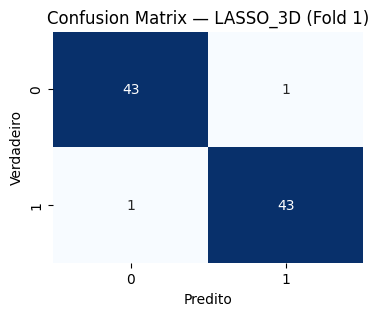

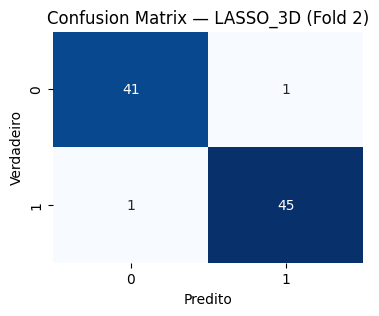

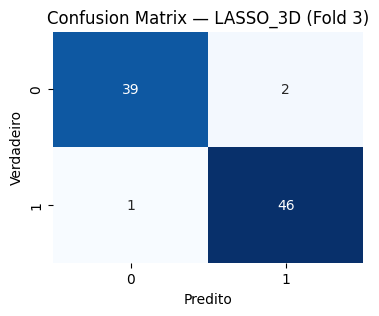

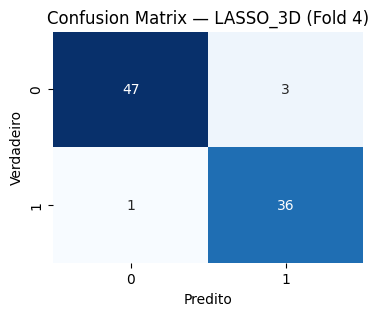

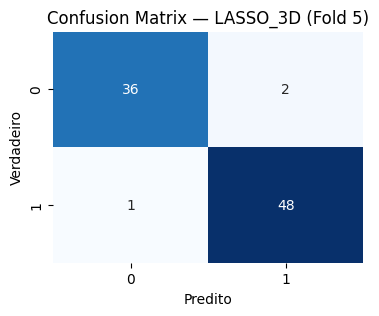


Gráfico de métricas por fold — LASSO_3D


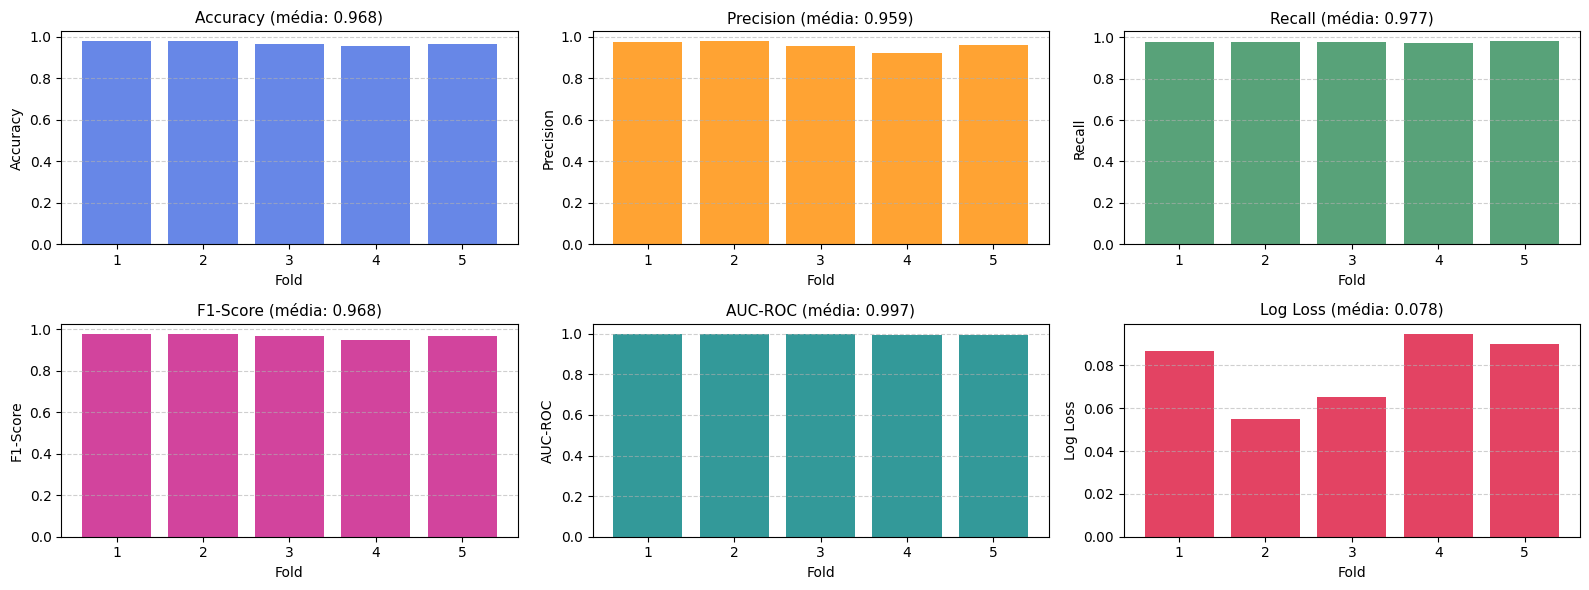


A treinar Random Forest com feature set: RFECV_RandomForest_3D (40 variáveis)


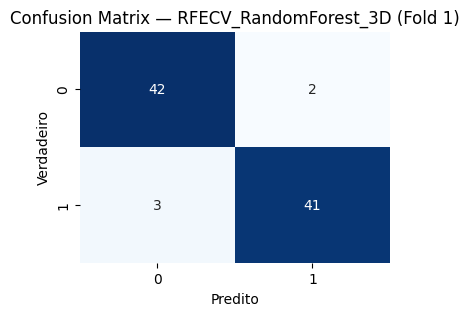

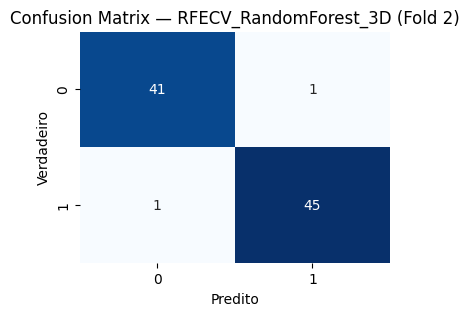

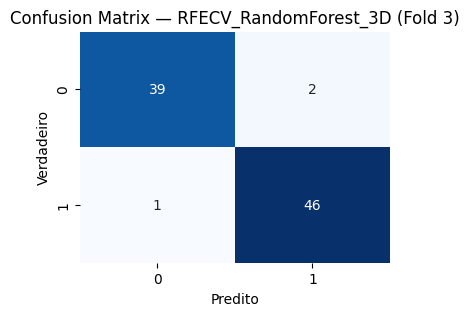

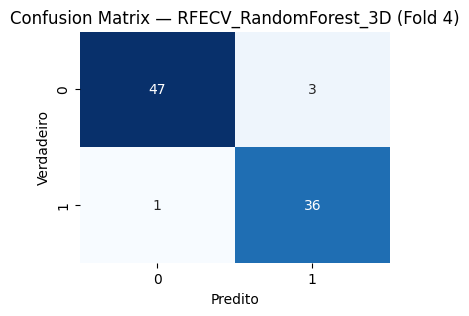

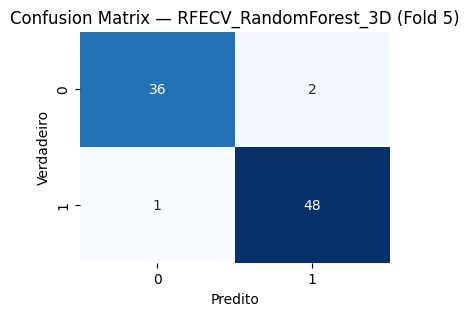


Gráfico de métricas por fold — RFECV_RandomForest_3D


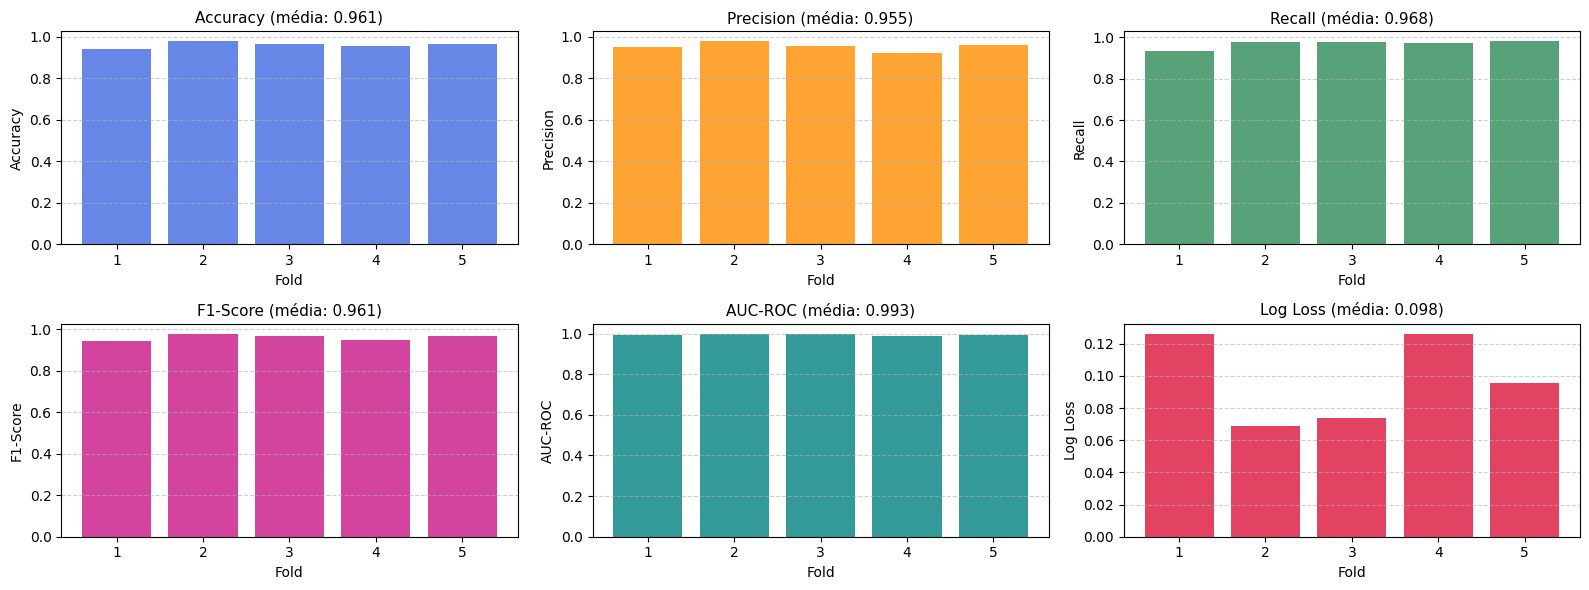


A treinar Random Forest com feature set: RFECV_XGBoost_3D (12 variáveis)


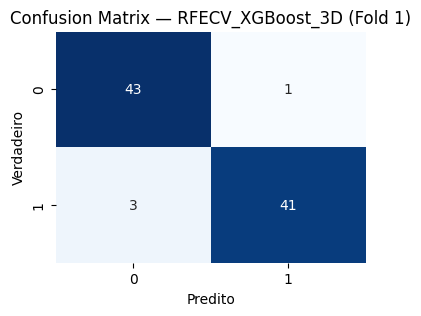

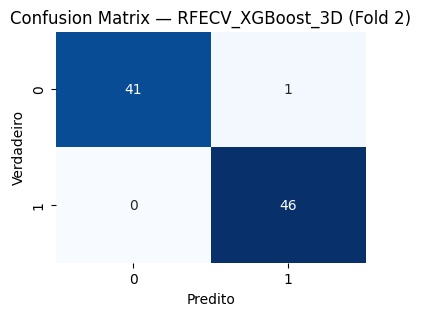

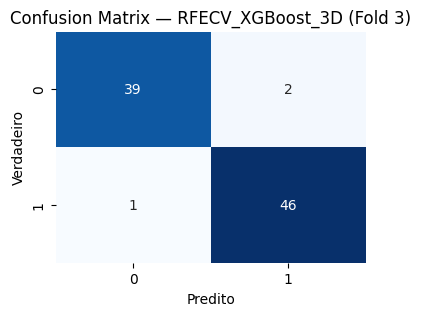

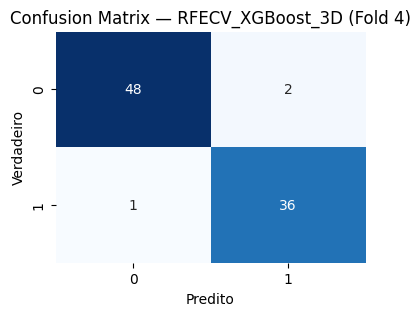

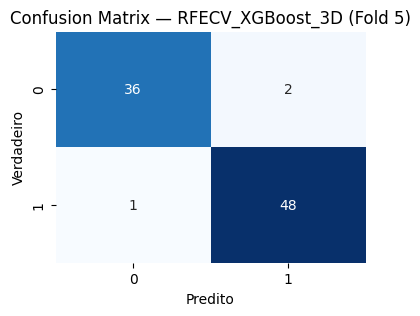


Gráfico de métricas por fold — RFECV_XGBoost_3D


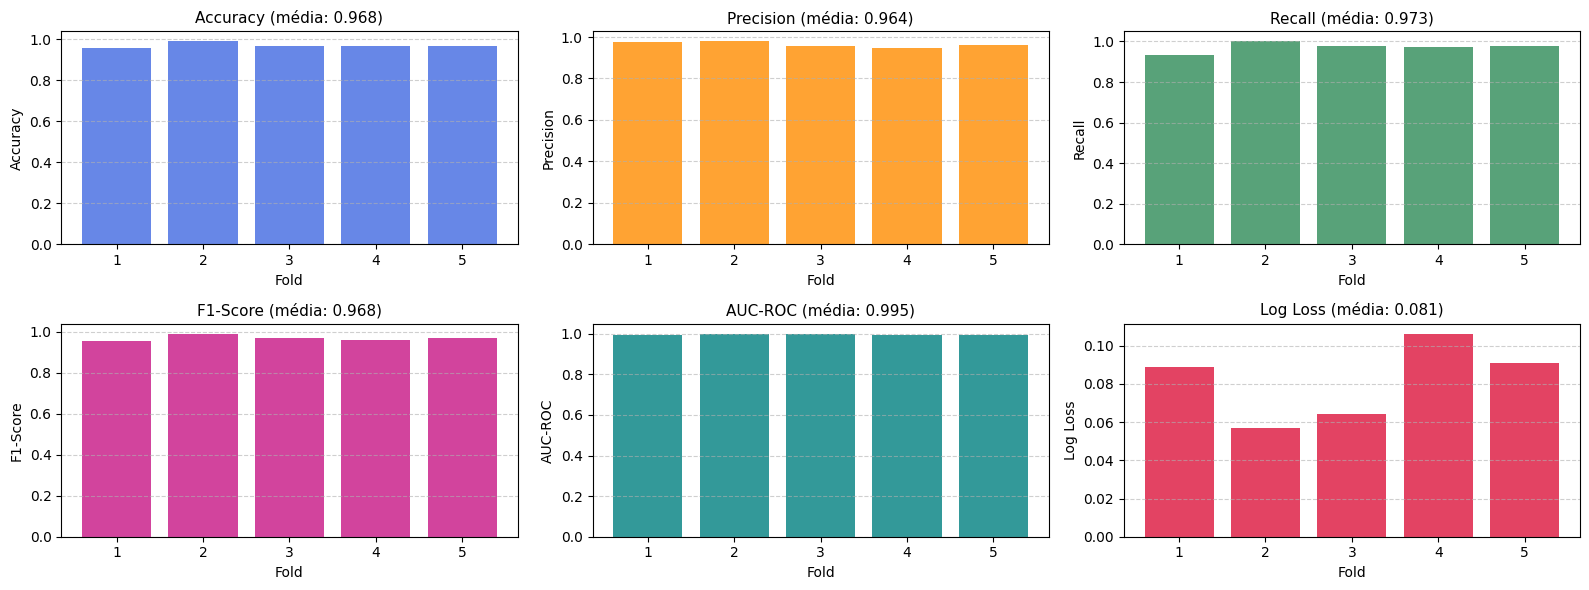


A treinar Random Forest com feature set: RFECV_LinearSVM_3D (5 variáveis)


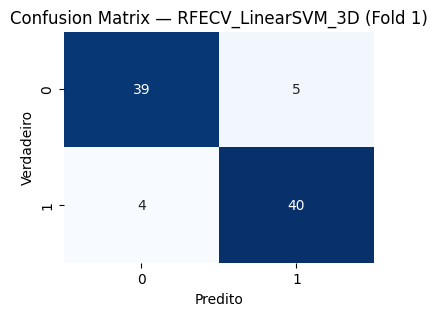

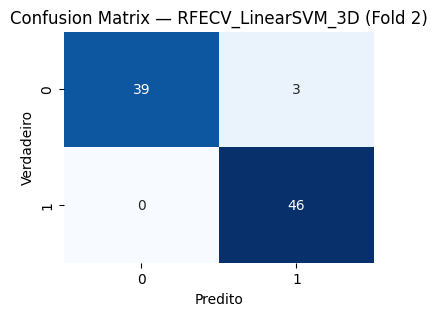

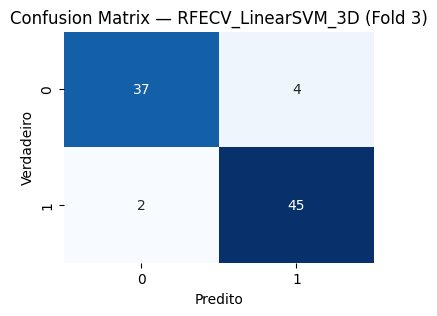

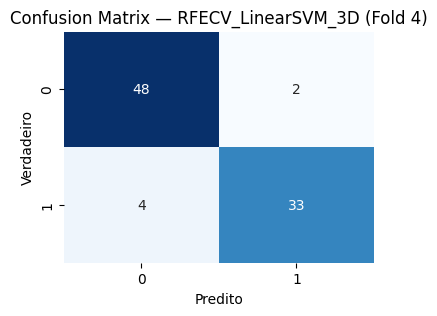

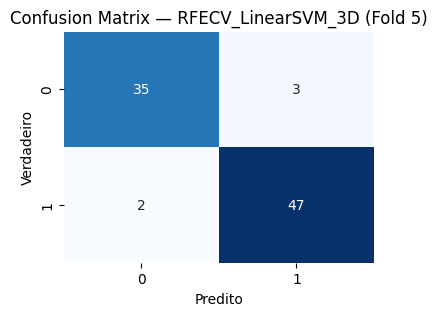


Gráfico de métricas por fold — RFECV_LinearSVM_3D


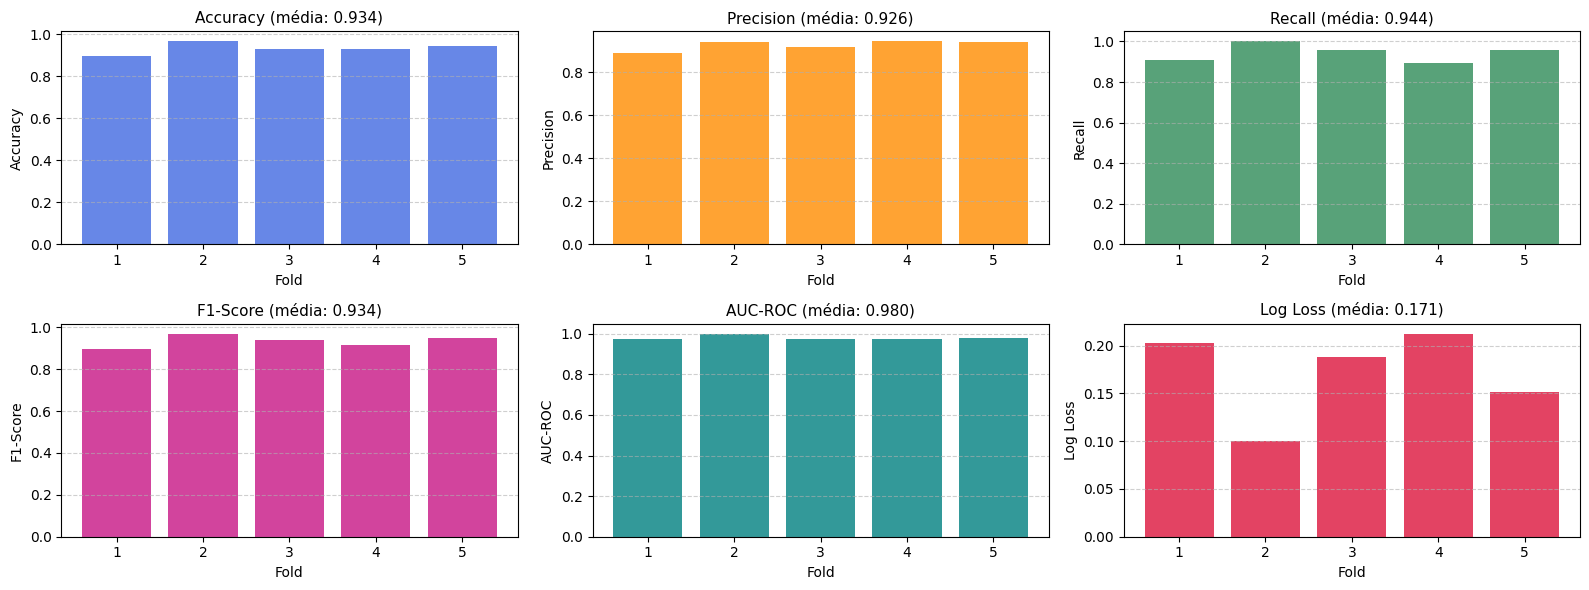


A treinar Random Forest com feature set: SVM (8 variáveis)


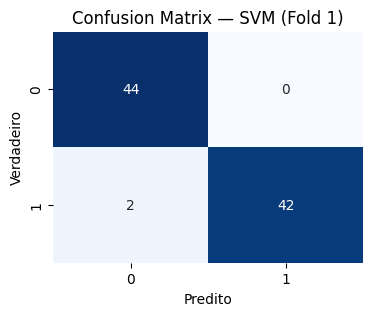

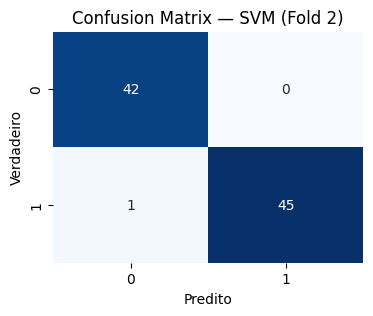

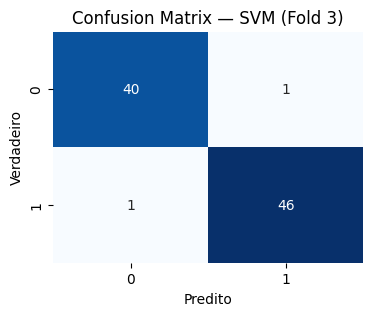

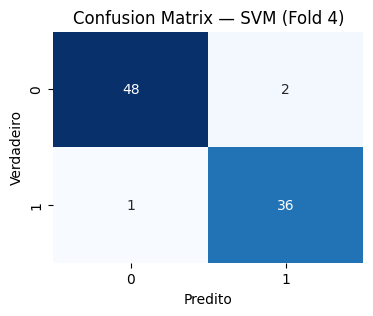

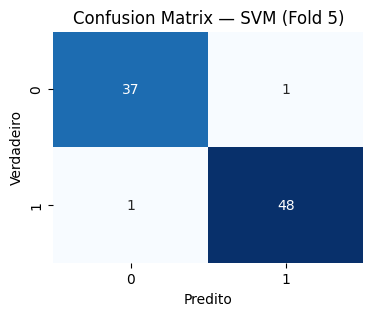


Gráfico de métricas por fold — SVM


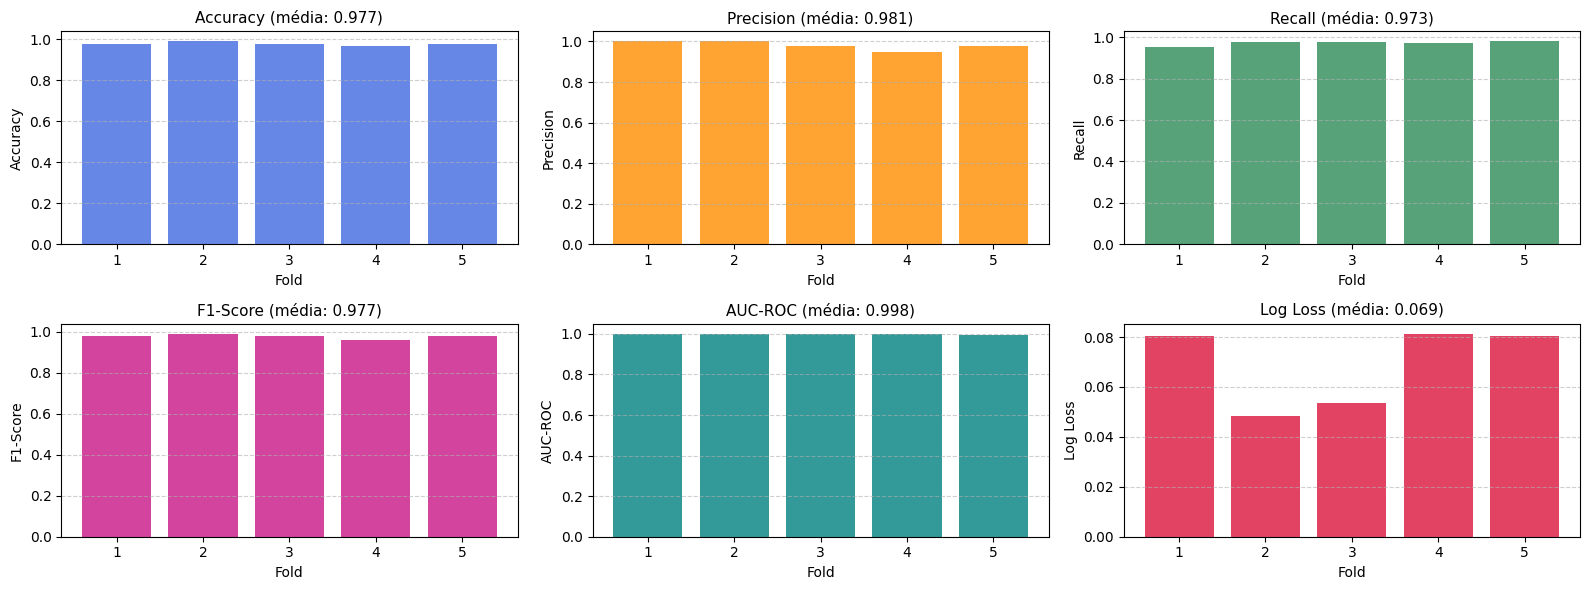

<Figure size 1000x600 with 0 Axes>

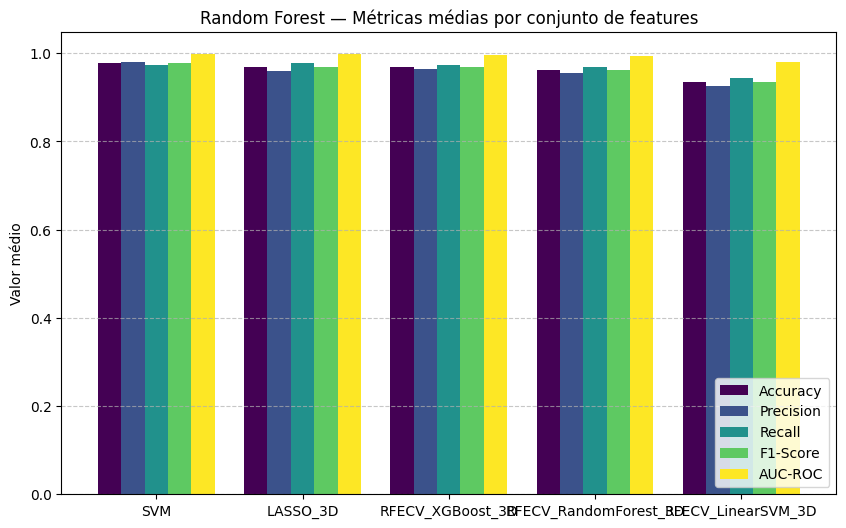


Avaliação final concluída :)


Feature_Set  Fold  Accuracy  Precision    Recall  F1-Score  \
0                LASSO_3D     1  0.977273   0.977273  0.977273  0.977273   
1                LASSO_3D     2  0.977273   0.978261  0.978261  0.978261   
2                LASSO_3D     3  0.965909   0.958333  0.978723  0.968421   
3                LASSO_3D     4  0.954023   0.923077  0.972973  0.947368   
4                LASSO_3D     5  0.965517   0.960000  0.979592  0.969697   
5   RFECV_RandomForest_3D     1  0.943182   0.953488  0.931818  0.942529   
6   RFECV_RandomForest_3D     2  0.977273   0.978261  0.978261  0.978261   
7   RFECV_RandomForest_3D     3  0.965909   0.958333  0.978723  0.968421   
8   RFECV_RandomForest_3D     4  0.954023   0.923077  0.972973  0.947368   
9   RFECV_RandomForest_3D     5  0.965517   0.960000  0.979592  0.969697   
10       RFECV_XGBoost_3D     1  0.954545   0.976190  0.931818  0.953488   
11       RFECV_XGBoost_3D     2  0.988636   0.978723  1.000000  0.989247   
12       RFECV_XGBoost_3D     3  0.965909   0.958333  0.978723  0.968421   
13       RFECV_XGBoost_3D     4  0.965517   0.947368  0.972973  0.960000   
14       RFECV_XGBoost_3D     5  0.965517   0.960000  0.979592  0.969697   
15     RFECV_LinearSVM_3D     1  0.897727   0.888889  0.909091  0.898876   
16     RFECV_LinearSVM_3D     2  0.965909   0.938776  1.000000  0.968421   
17     RFECV_LinearSVM_3D     3  0.931818   0.918367  0.957447  0.937500   
18     RFECV_LinearSVM_3D     4  0.931034   0.942857  0.891892  0.916667   
19     RFECV_LinearSVM_3D     5  0.942529   0.940000  0.959184  0.949495   
20                    SVM     1  0.977273   1.000000  0.954545  0.976744   
21                    SVM     2  0.988636   1.000000  0.978261  0.989011   
22                    SVM     3  0.977273   0.978723  0.978723  0.978723   
23                    SVM     4  0.965517   0.947368  0.972973  0.960000   
24                    SVM     5  0.977011   0.979592  0.979592  0.979592   

     AUC-ROC  Log Loss  
0   0.998450  0.086684  
1   0.998965  0.055186  
2   0.998443  0.065281  
3   0.995405  0.094658  
4   0.994629  0.090068  
5   0.991219  0.126027  
6   0.997930  0.068872  
7   0.998443  0.074027  
8   0.987568  0.126005  
9   0.991944  0.095497  
10  0.995351  0.088751  
11  0.999224  0.057039  
12  0.997924  0.064347  
13  0.992432  0.106098  
14  0.991944  0.091061  
15  0.974432  0.203208  
16  0.998965  0.099641  
17  0.976129  0.187903  
18  0.972162  0.212153  
19  0.979592  0.151303  
20  0.997934  0.080598  
21  0.999482  0.048347  
22  0.998962  0.053694  
23  0.997297  0.081219  
24  0.995704  0.080265

Accuracy  Precision    Recall  F1-Score   AUC-ROC  \
SVM                    0.977142   0.981137  0.972819  0.976814  0.997876   
LASSO_3D               0.967999   0.959389  0.977364  0.968204  0.997179   
RFECV_XGBoost_3D       0.968025   0.964123  0.972621  0.968171  0.995375   
RFECV_RandomForest_3D  0.961181   0.954632  0.968273  0.961255  0.993421   
RFECV_LinearSVM_3D     0.933804   0.925778  0.943523  0.934192  0.980256   

                       Log Loss  
SVM                    0.068825  
LASSO_3D               0.078375  
RFECV_XGBoost_3D       0.081459  
RFECV_RandomForest_3D  0.098086  
RFECV_LinearSVM_3D     0.170842

In [110]:
# 2D
rf_results_2d, rf_avg_2d = run_random_forest_kfold_report(feature_sets_2d, merged_df_2d, k=5)
display(rf_results_2d)  # Para ANOVA ou análise por fold
display(rf_avg_2d)       # Para gráficos de médias

# 3D
rf_results_3d, rf_avg_3d = run_random_forest_kfold_report(feature_sets_3d, merged_df_3d, k=5)
display(rf_results_3d)
display(rf_avg_3d)

### 10.2 XGBoost <a id="xgboost"><a/>
[Voltar a Modelos ML](#modelos)

In [ ]:
from xgboost import XGBClassifier

#### 10.1 XGBoost sem Feature Selection

In [96]:
from xgboost import XGBClassifier

# Lista para resultados detalhados
all_folds_results = []

# Datasets
datasets = {
    '2D': (X_2d_train, y_2d_train),
    '3D': (X_3d_train, y_3d_train)
}

k = 5
random_state = 42

for dataset_name, (X_data, y_data) in datasets.items():
    print(f"\nTreinando XGBoost com {dataset_name} — K-Fold CV (k={k})")
    
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    fold_num = 1
    
    for train_idx, test_idx in kf.split(X_data):
        X_train, X_test = X_data.iloc[train_idx], X_data.iloc[test_idx]
        y_train, y_test = y_data.iloc[train_idx], y_data.iloc[test_idx]
        
        # Modelo XGBoost
        model = XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=random_state,
            eval_metric='logloss',
            use_label_encoder=False,
            verbosity=0,
            n_jobs=-1
        )
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        metrics = calculate_metrics(y_test, y_pred, y_prob)
        metrics['Dataset'] = dataset_name
        metrics['Fold'] = fold_num
        
        all_folds_results.append(metrics)
        fold_num += 1

# DataFrame final com todos os folds
results_xgb_all_folds = pd.DataFrame(all_folds_results)
results_xgb_all_folds = results_xgb_all_folds[['Dataset', 'Fold', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Log Loss']]

print("Resultados XGBoost sem feature selection (K-Fold 5):")
display(results_xgb_all_folds)


Treinando XGBoost com 2D — K-Fold CV (k=5)

Treinando XGBoost com 3D — K-Fold CV (k=5)
Resultados XGBoost sem feature selection (K-Fold 5):


Dataset  Fold  Accuracy  Precision    Recall  F1-Score   AUC-ROC  Log Loss
0      2D     1  0.919355   0.931034  0.900000  0.915254  0.986458  0.170007
1      2D     2  1.000000   1.000000  1.000000  1.000000  1.000000  0.010407
2      2D     3  0.983607   0.972222  1.000000  0.985915  0.998901  0.035883
3      2D     4  0.918033   0.935484  0.906250  0.920635  0.985991  0.253124
4      2D     5  1.000000   1.000000  1.000000  1.000000  1.000000  0.005102
5      3D     1  0.935484   0.964286  0.900000  0.931034  0.982292  0.235052
6      3D     2  0.950820   0.916667  1.000000  0.956522  0.991342  0.126945
7      3D     3  0.983607   1.000000  0.971429  0.985507  1.000000  0.045337
8      3D     4  0.918033   0.909091  0.937500  0.923077  0.982759  0.269749
9      3D     5  1.000000   1.000000  1.000000  1.000000  1.000000  0.004466

#### 10.2.2 XGBoost com diferentes conjuntos de features <a id="xgboostfeatures"><a/>
[Voltar a XGBoost](#xgboost)

In [97]:
# Função XGBoost com K-Fold CV (detalhado por fold)
def run_xgboost_kfold_report(feature_sets, merged_df, k=5, random_state=42):
    
    all_folds_results = []  # <-- guarda métricas individuais (para ANOVA)
    avg_results = {}        # <-- guarda médias (para gráficos)

    for feature_set_name, features in feature_sets.items():
        print(f"\nA treinar XGBoost com feature set: {feature_set_name} ({len(features)} variáveis)")

        X = merged_df[features]
        y = merged_df['Malignancy']

        kf = KFold(n_splits=k, shuffle=True, random_state=random_state)

        # Armazenar métricas por fold
        accuracies, precisions, recalls, f1s, aucs, losses = [], [], [], [], [], []

        fold = 1
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Modelo XGBoost
            model = XGBClassifier(
                n_estimators=250,
                learning_rate=0.05,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                gamma=0.2,
                reg_lambda=1.0,
                reg_alpha=0.2,
                objective='binary:logistic',
                eval_metric='logloss',
                use_label_encoder=False,
                random_state=random_state,
                verbosity=0,
                n_jobs=-1
            )

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]

            # Confusion Matrix (opcional)
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(4, 3))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False)
            plt.title(f"Confusion Matrix — {feature_set_name} (Fold {fold})")
            plt.xlabel("Predito")
            plt.ylabel("Verdadeiro")
            plt.show()

            # Calcular métricas
            metrics = calculate_metrics(y_test, y_pred, y_prob)

            # Guardar métricas por fold
            all_folds_results.append({
                'Feature_Set': feature_set_name,
                'Fold': fold,
                'Accuracy': metrics['Accuracy'],
                'Precision': metrics['Precision'],
                'Recall': metrics['Recall'],
                'F1-Score': metrics['F1-Score'],
                'AUC-ROC': metrics['AUC-ROC'],
                'Log Loss': metrics['Log Loss']
            })

            accuracies.append(metrics['Accuracy'])
            precisions.append(metrics['Precision'])
            recalls.append(metrics['Recall'])
            f1s.append(metrics['F1-Score'])
            aucs.append(metrics['AUC-ROC'])
            losses.append(metrics['Log Loss'])

            fold += 1

        # Gráfico de métricas por fold
        print(f"\nGráfico de métricas por fold — {feature_set_name}")
        plot_fold_metrics(accuracies, precisions, recalls, f1s, aucs, losses)

        # Calcular médias por feature set
        avg_results[feature_set_name] = {
            'Accuracy': np.mean(accuracies),
            'Precision': np.mean(precisions),
            'Recall': np.mean(recalls),
            'F1-Score': np.mean(f1s),
            'AUC-ROC': np.nanmean(aucs),
            'Log Loss': np.nanmean(losses)
        }

    # DataFrame com médias
    avg_df = pd.DataFrame(avg_results).T[
        ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Log Loss']
    ].sort_values(by='AUC-ROC', ascending=False)

    # Gráfico das médias
    plt.figure(figsize=(10, 6))
    avg_df.drop(columns=['Log Loss']).plot(
        kind='bar', figsize=(10, 6), width=0.8, colormap='plasma'
    )
    plt.title("XGBoost — Métricas médias por conjunto de features")
    plt.ylabel("Valor médio")
    plt.xticks(rotation=0)
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    print("\nAvaliação final com XGBoost concluída")

    # DataFrame detalhado com todos os folds
    detailed_df = pd.DataFrame(all_folds_results)

    return detailed_df, avg_df


A treinar XGBoost com feature set: LASSO_2D (8 variáveis)


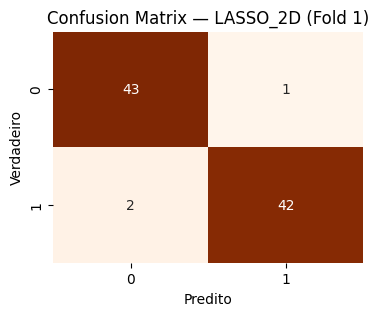

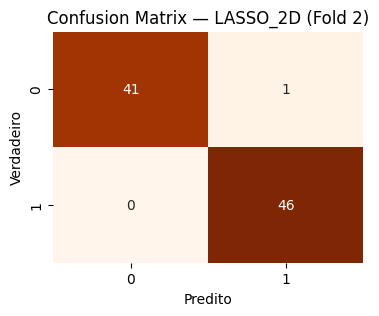

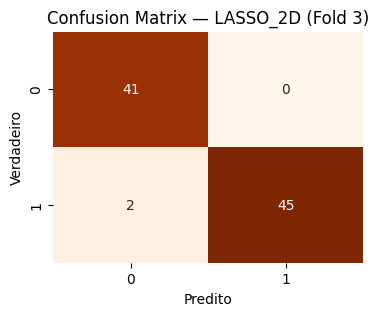

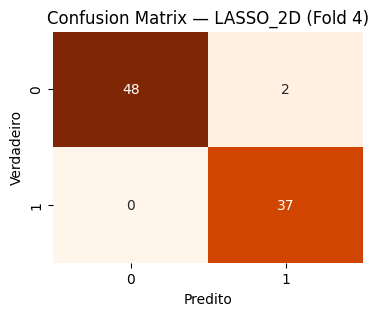

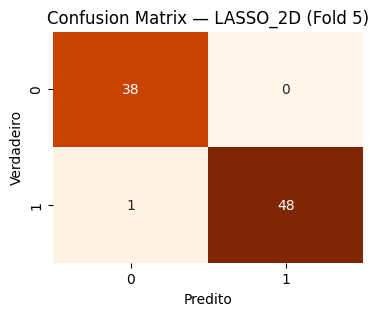


Gráfico de métricas por fold — LASSO_2D


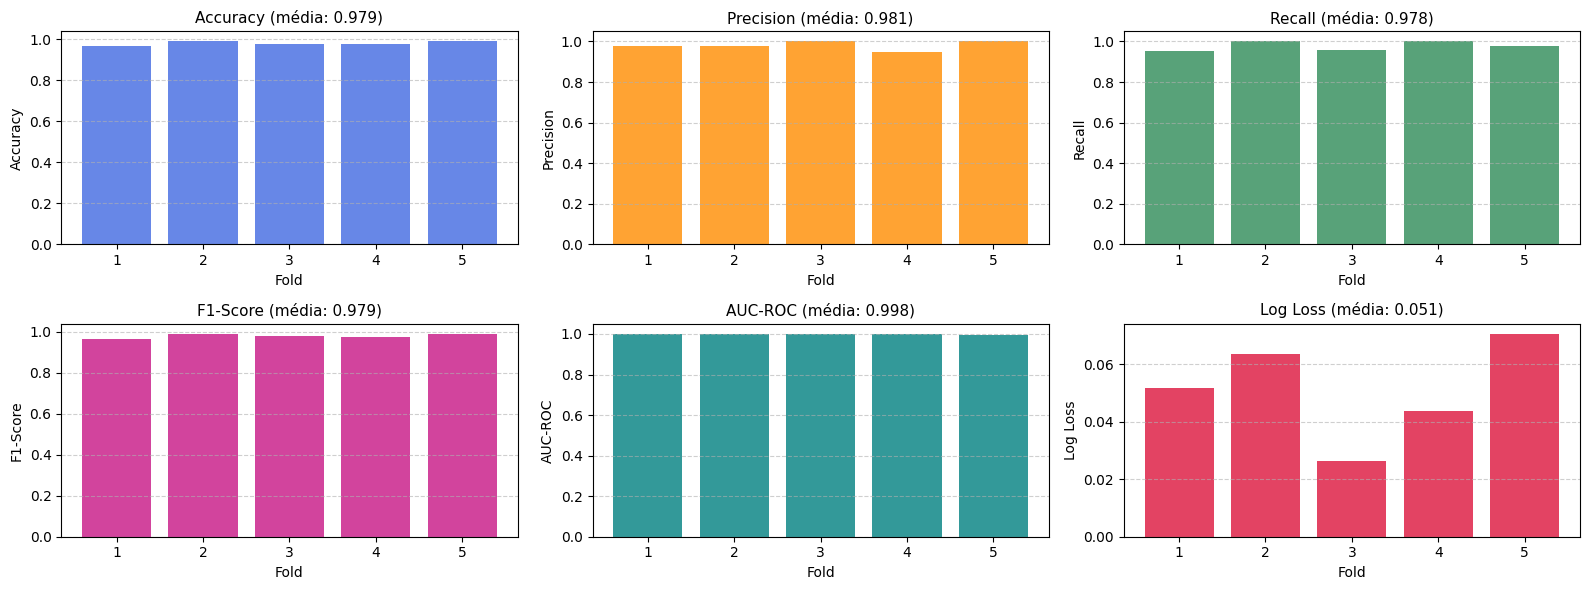


A treinar XGBoost com feature set: RFECV_RandomForest_2D (13 variáveis)


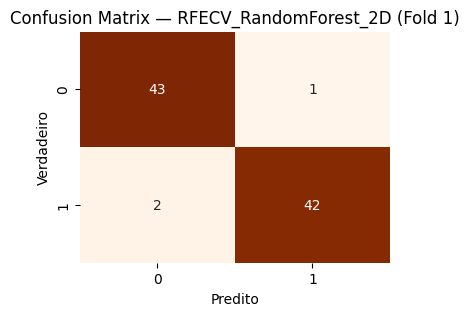

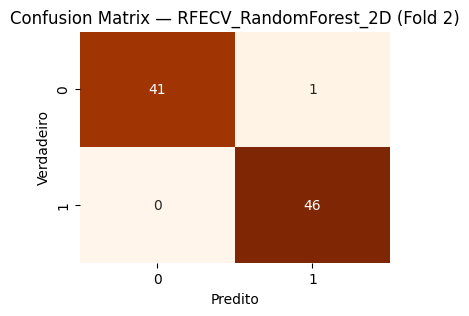

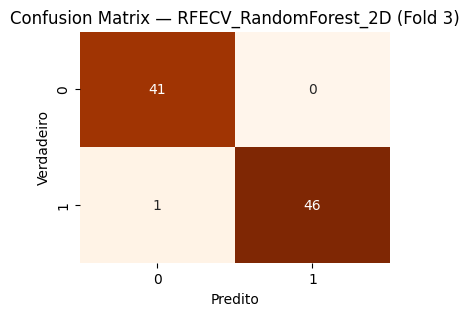

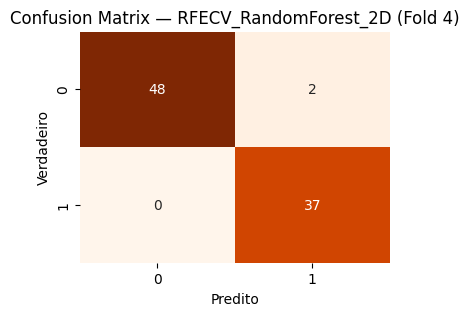

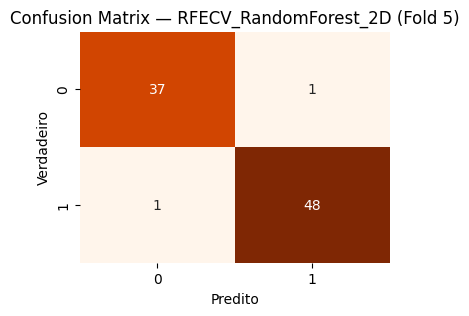


Gráfico de métricas por fold — RFECV_RandomForest_2D


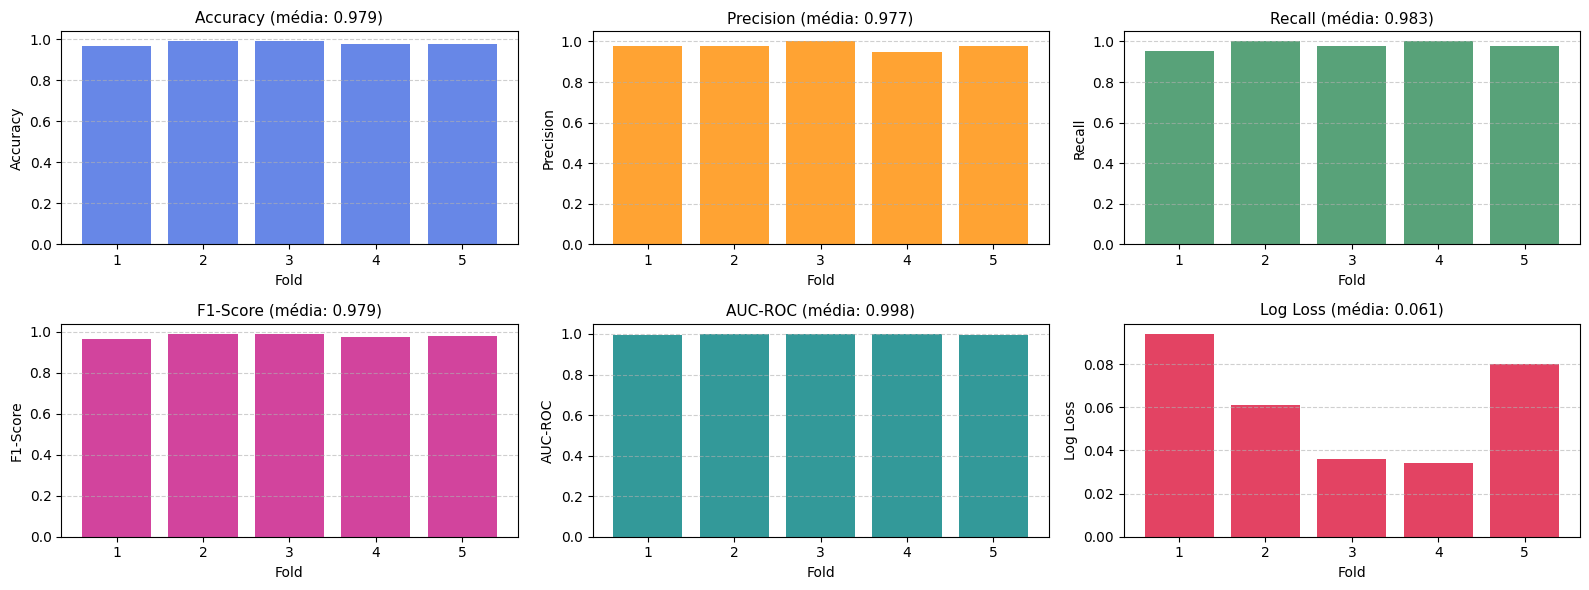


A treinar XGBoost com feature set: RFECV_XGBoost_2D (6 variáveis)


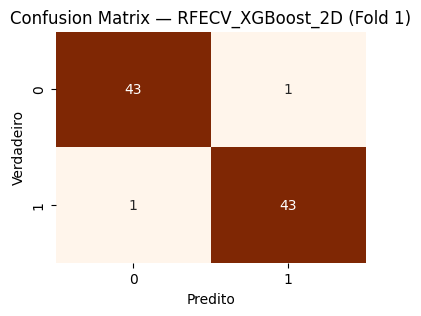

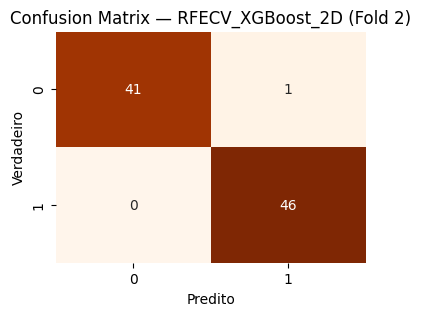

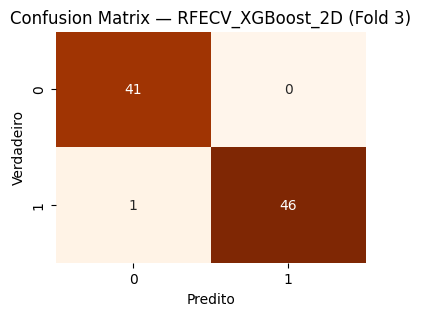

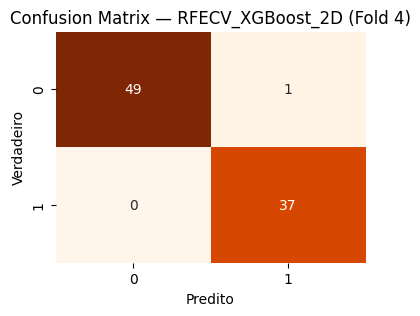

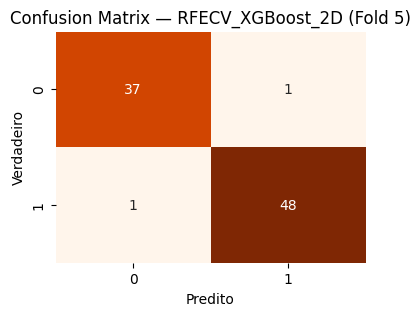


Gráfico de métricas por fold — RFECV_XGBoost_2D


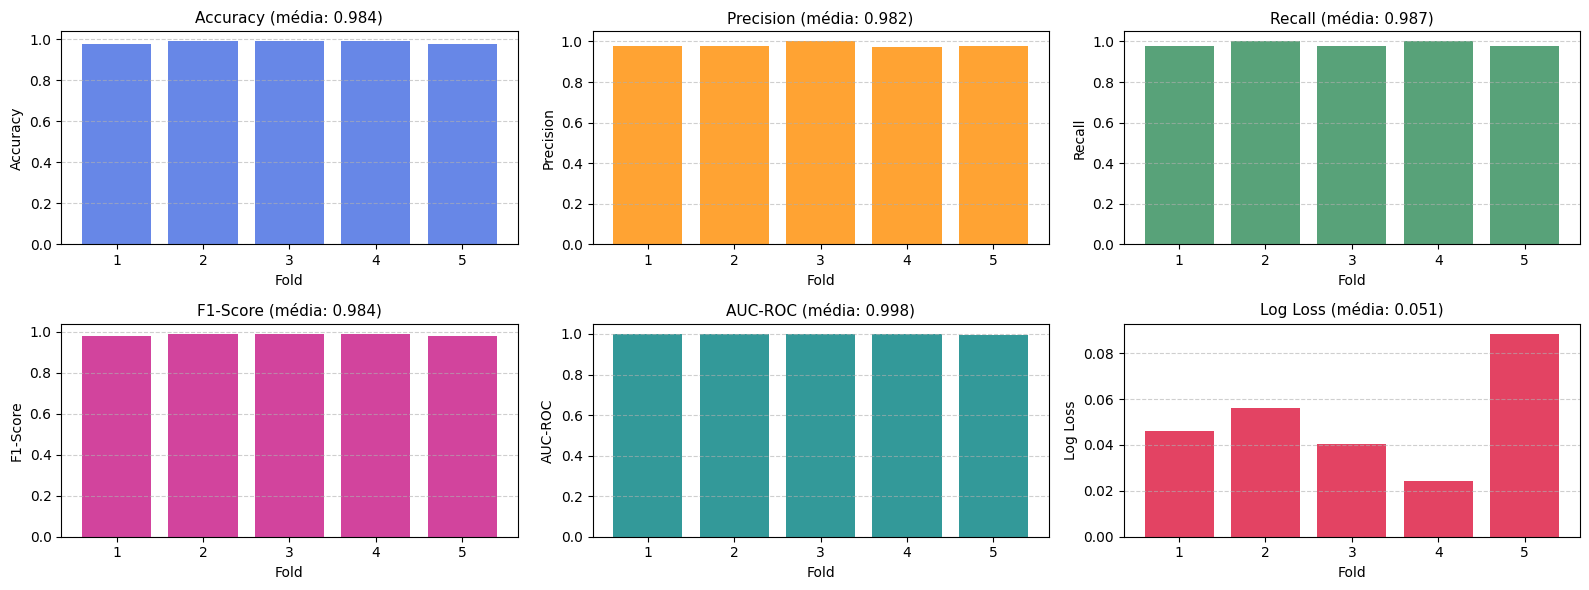


A treinar XGBoost com feature set: RFECV_LinearSVM_2D (14 variáveis)


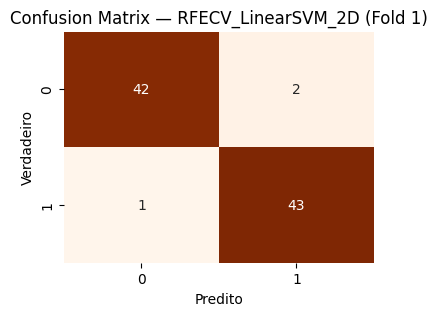

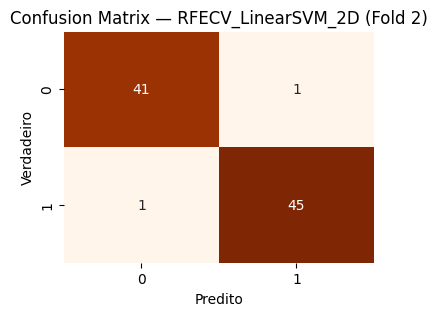

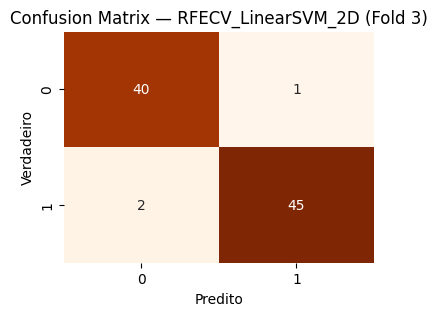

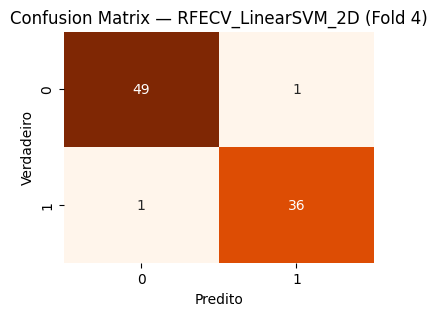

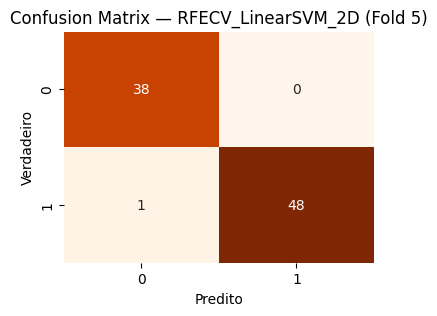


Gráfico de métricas por fold — RFECV_LinearSVM_2D


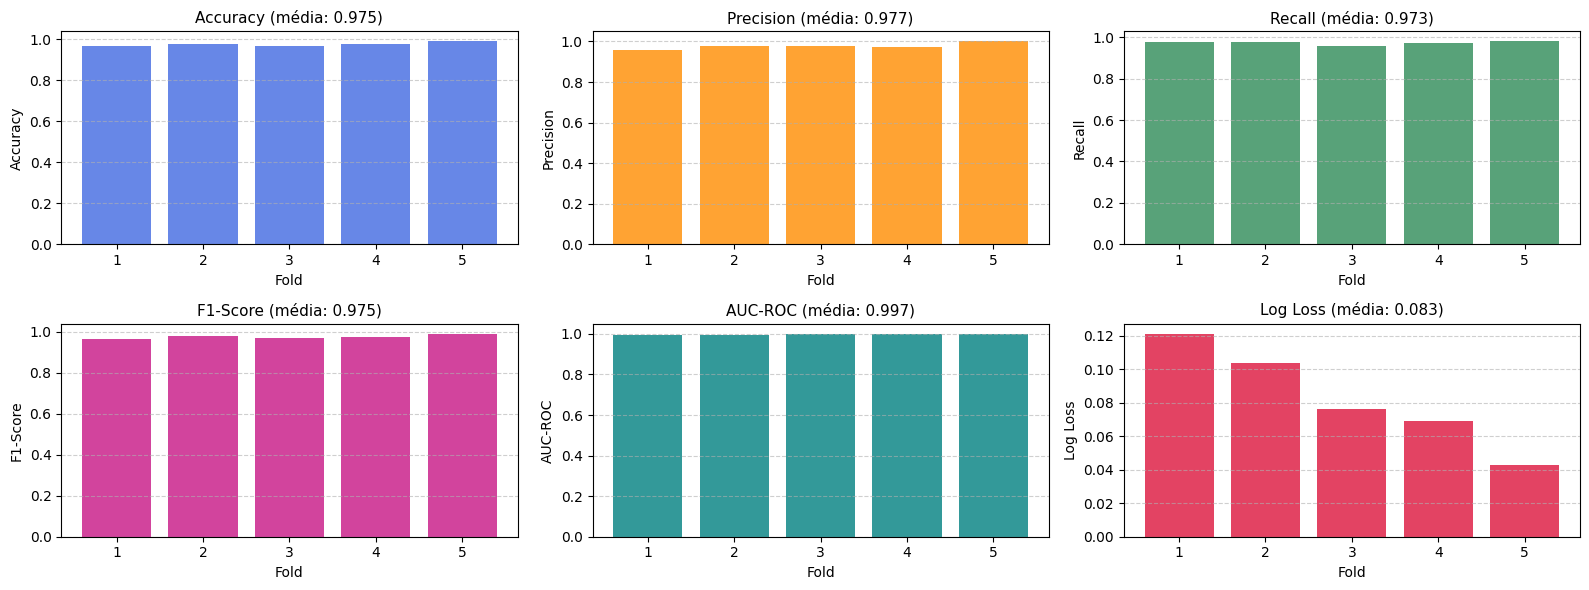


A treinar XGBoost com feature set: SVM (23 variáveis)


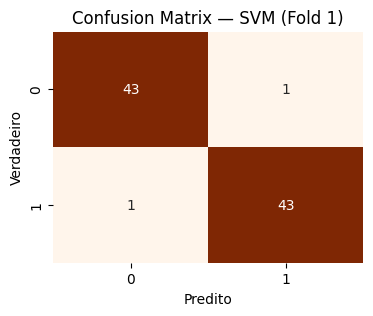

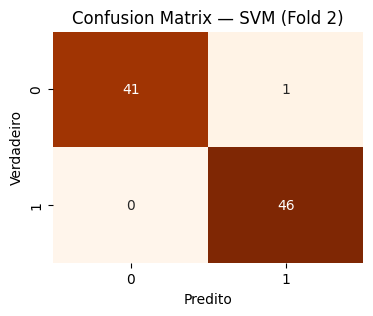

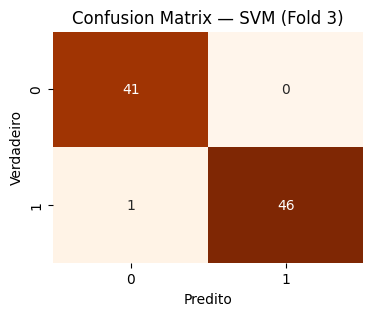

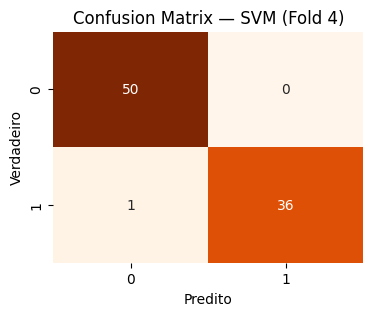

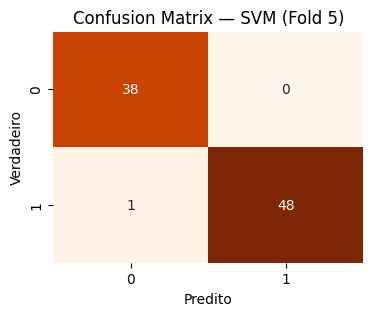


Gráfico de métricas por fold — SVM


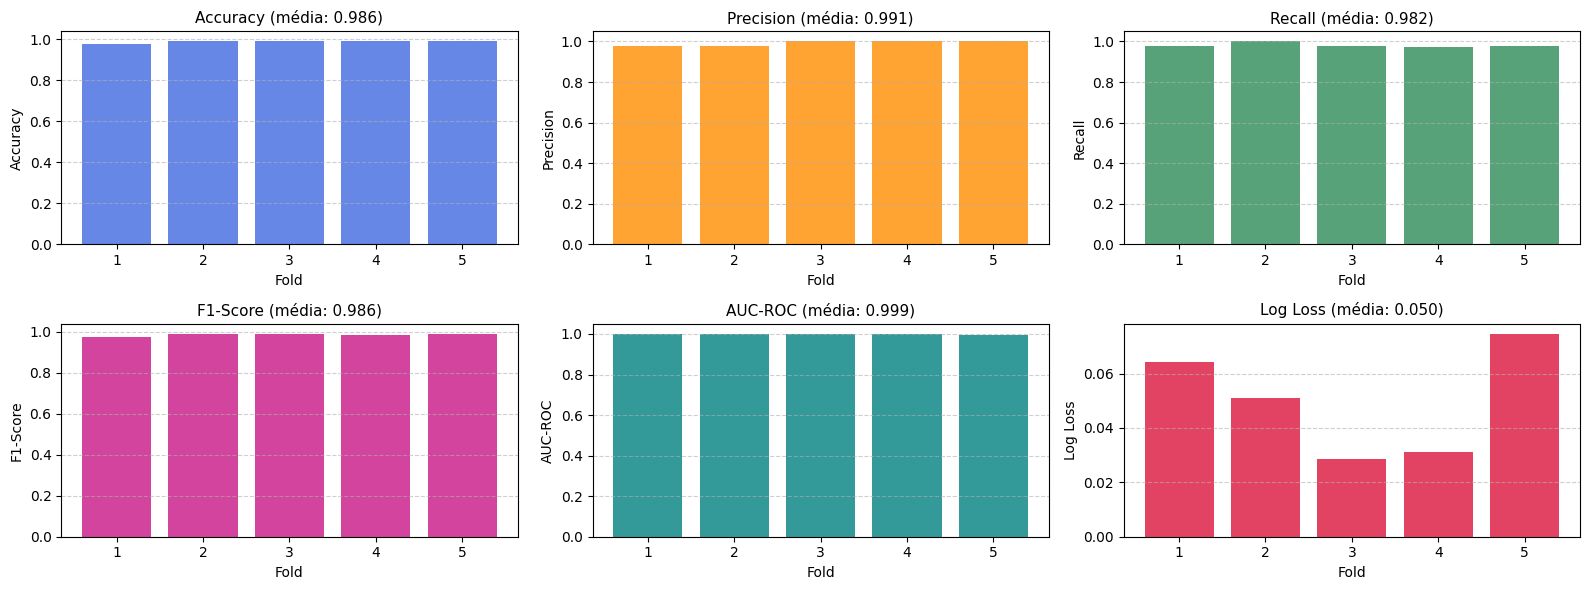

<Figure size 1000x600 with 0 Axes>

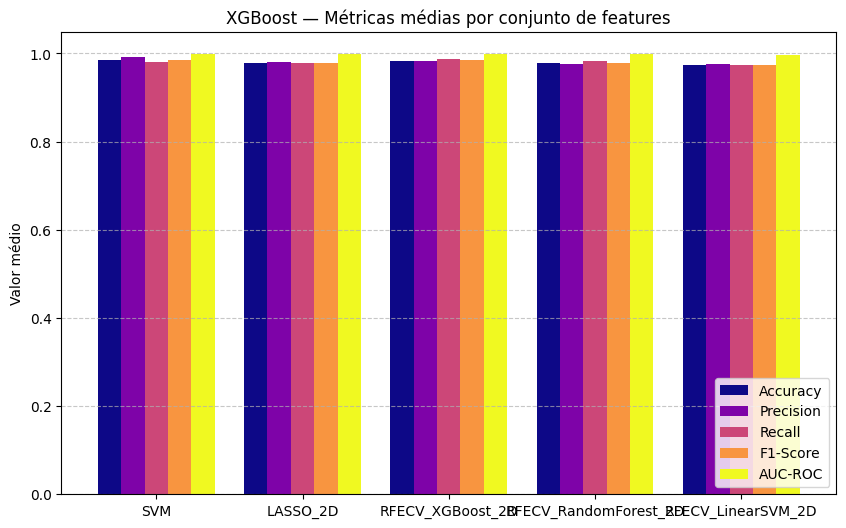


Avaliação final com XGBoost concluída


Feature_Set  Fold  Accuracy  Precision    Recall  F1-Score  \
0                LASSO_2D     1  0.965909   0.976744  0.954545  0.965517   
1                LASSO_2D     2  0.988636   0.978723  1.000000  0.989247   
2                LASSO_2D     3  0.977273   1.000000  0.957447  0.978261   
3                LASSO_2D     4  0.977011   0.948718  1.000000  0.973684   
4                LASSO_2D     5  0.988506   1.000000  0.979592  0.989691   
5   RFECV_RandomForest_2D     1  0.965909   0.976744  0.954545  0.965517   
6   RFECV_RandomForest_2D     2  0.988636   0.978723  1.000000  0.989247   
7   RFECV_RandomForest_2D     3  0.988636   1.000000  0.978723  0.989247   
8   RFECV_RandomForest_2D     4  0.977011   0.948718  1.000000  0.973684   
9   RFECV_RandomForest_2D     5  0.977011   0.979592  0.979592  0.979592   
10       RFECV_XGBoost_2D     1  0.977273   0.977273  0.977273  0.977273   
11       RFECV_XGBoost_2D     2  0.988636   0.978723  1.000000  0.989247   
12       RFECV_XGBoost_2D     3  0.988636   1.000000  0.978723  0.989247   
13       RFECV_XGBoost_2D     4  0.988506   0.973684  1.000000  0.986667   
14       RFECV_XGBoost_2D     5  0.977011   0.979592  0.979592  0.979592   
15     RFECV_LinearSVM_2D     1  0.965909   0.955556  0.977273  0.966292   
16     RFECV_LinearSVM_2D     2  0.977273   0.978261  0.978261  0.978261   
17     RFECV_LinearSVM_2D     3  0.965909   0.978261  0.957447  0.967742   
18     RFECV_LinearSVM_2D     4  0.977011   0.972973  0.972973  0.972973   
19     RFECV_LinearSVM_2D     5  0.988506   1.000000  0.979592  0.989691   
20                    SVM     1  0.977273   0.977273  0.977273  0.977273   
21                    SVM     2  0.988636   0.978723  1.000000  0.989247   
22                    SVM     3  0.988636   1.000000  0.978723  0.989247   
23                    SVM     4  0.988506   1.000000  0.972973  0.986301   
24                    SVM     5  0.988506   1.000000  0.979592  0.989691   

     AUC-ROC  Log Loss  
0   0.998967  0.051716  
1   0.997412  0.063636  
2   1.000000  0.026333  
3   0.998919  0.043609  
4   0.996778  0.070589  
5   0.996901  0.094051  
6   0.998447  0.061085  
7   0.998703  0.036105  
8   1.000000  0.034326  
9   0.996241  0.080106  
10  0.998967  0.046262  
11  0.998965  0.056090  
12  0.997924  0.040502  
13  1.000000  0.024232  
14  0.995704  0.088343  
15  0.993285  0.121112  
16  0.994824  0.103514  
17  0.997405  0.076394  
18  0.998378  0.069164  
19  0.999463  0.043011  
20  0.997417  0.064289  
21  0.998447  0.050962  
22  1.000000  0.028705  
23  1.000000  0.031277  
24  0.996778  0.074557

Accuracy  Precision    Recall  F1-Score   AUC-ROC  \
SVM                    0.986311   0.991199  0.981712  0.986352  0.998528   
LASSO_2D               0.979467   0.980837  0.978317  0.979280  0.998415   
RFECV_XGBoost_2D       0.984013   0.981854  0.987118  0.984405  0.998312   
RFECV_RandomForest_2D  0.979441   0.976755  0.982572  0.979458  0.998058   
RFECV_LinearSVM_2D     0.974922   0.977010  0.973109  0.974992  0.996671   

                       Log Loss  
SVM                    0.049958  
LASSO_2D               0.051177  
RFECV_XGBoost_2D       0.051086  
RFECV_RandomForest_2D  0.061135  
RFECV_LinearSVM_2D     0.082639


A treinar XGBoost com feature set: LASSO_3D (16 variáveis)


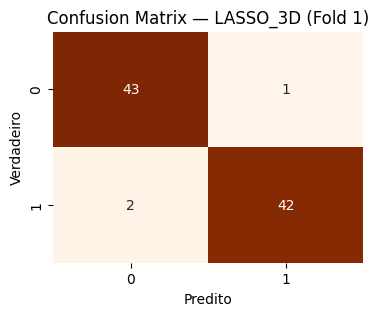

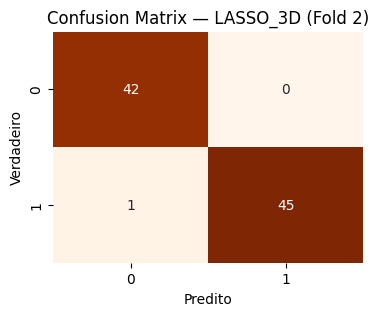

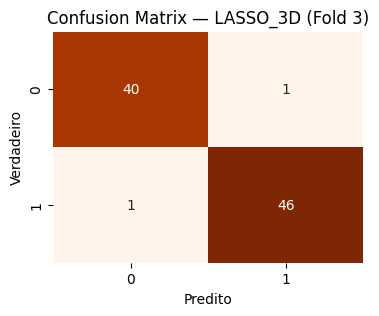

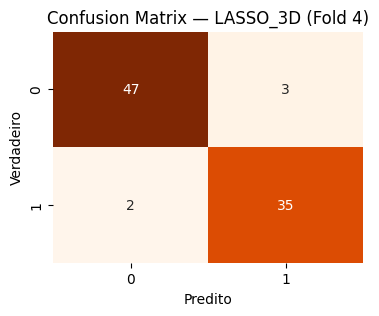

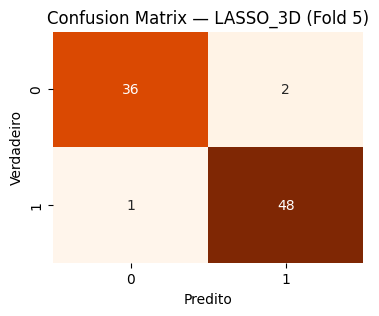


Gráfico de métricas por fold — LASSO_3D


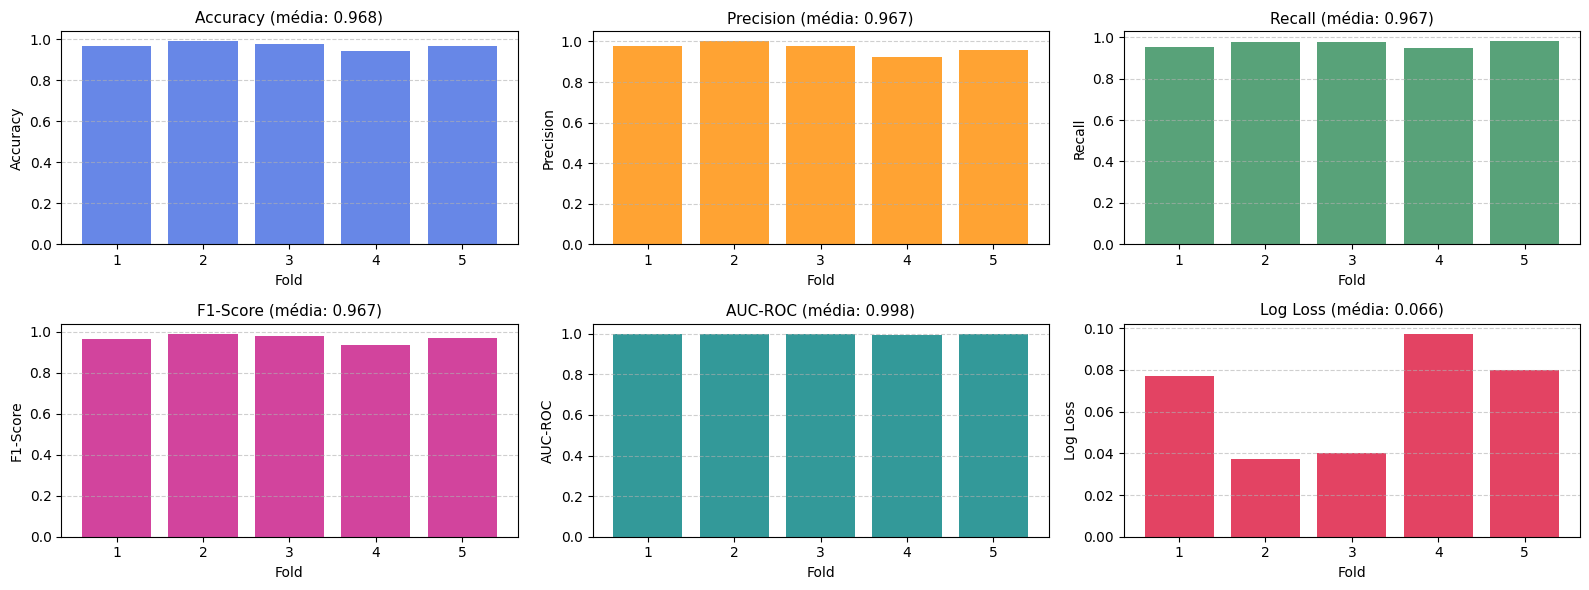


A treinar XGBoost com feature set: RFECV_RandomForest_3D (40 variáveis)


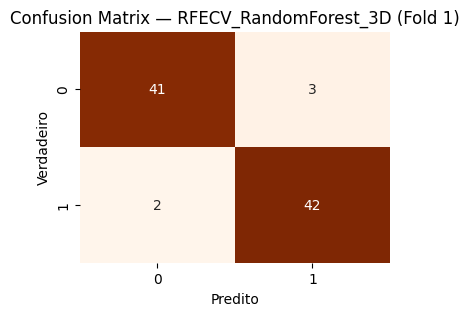

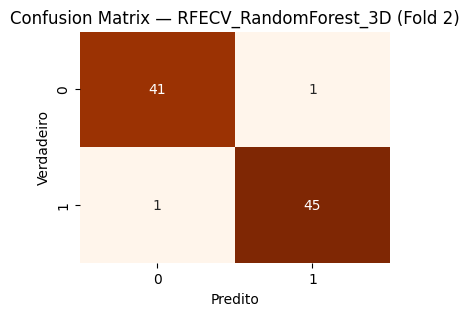

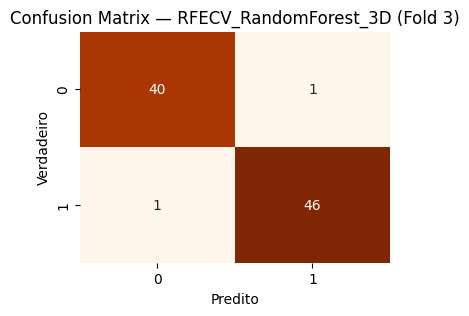

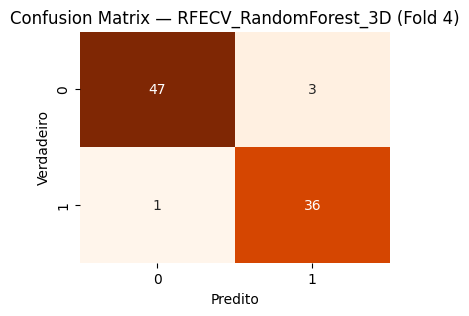

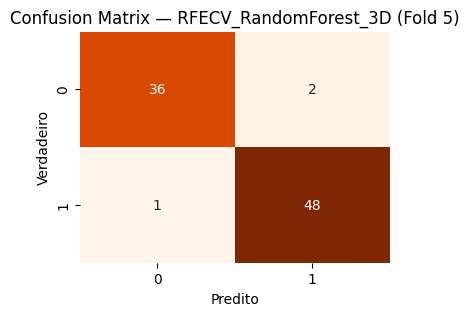


Gráfico de métricas por fold — RFECV_RandomForest_3D


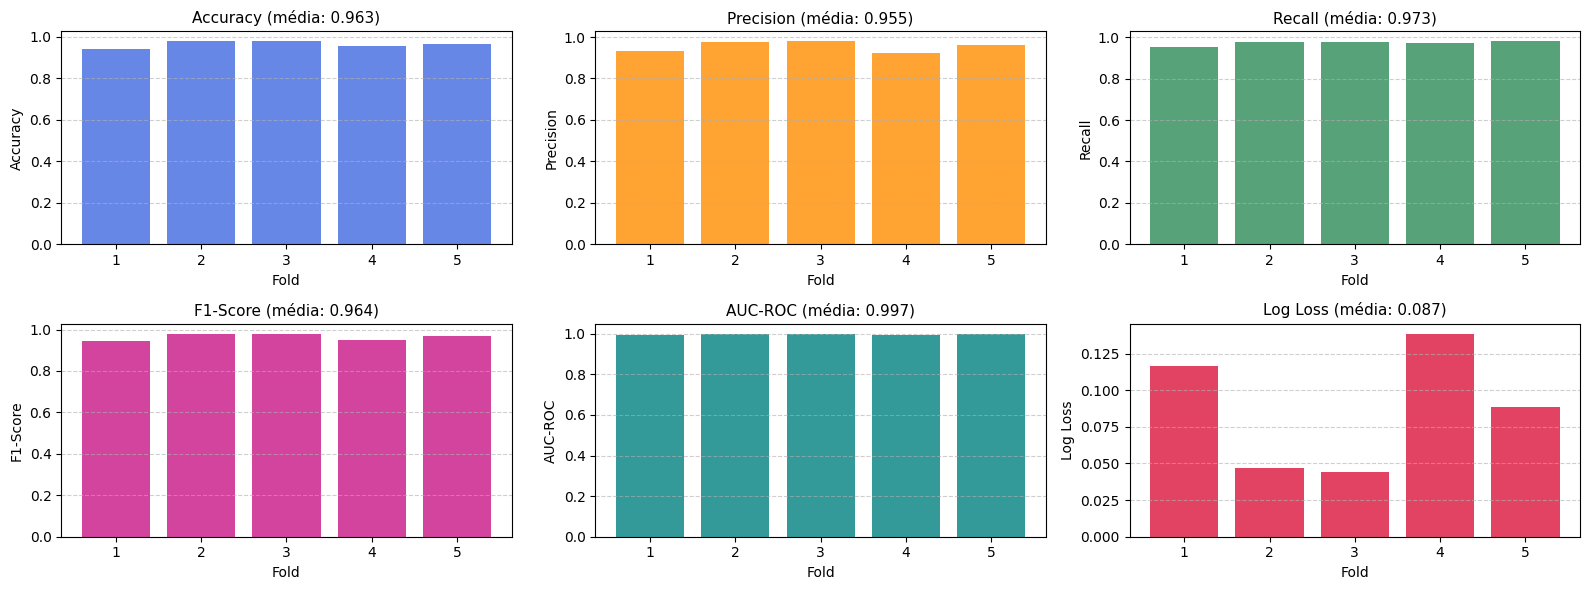


A treinar XGBoost com feature set: RFECV_XGBoost_3D (12 variáveis)


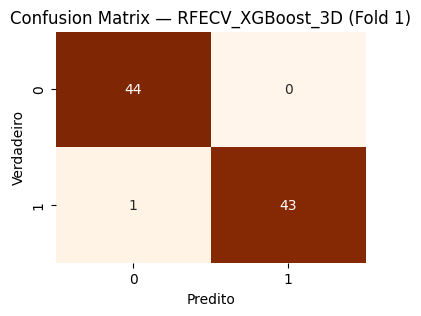

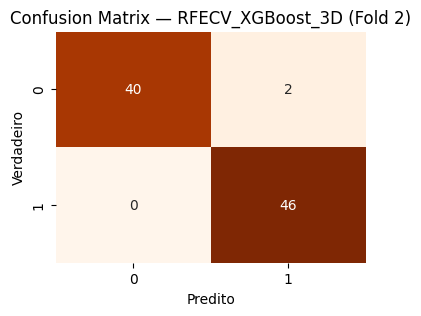

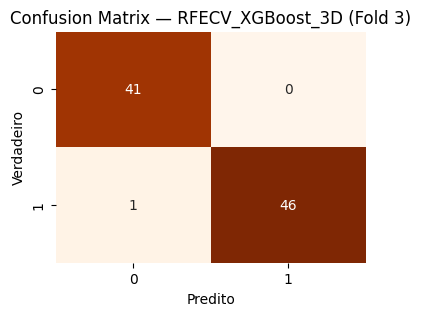

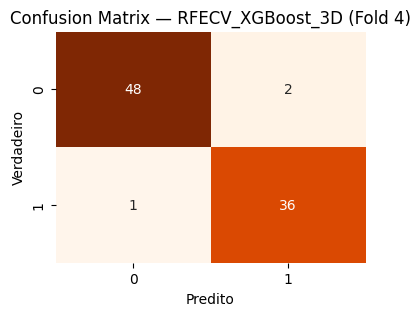

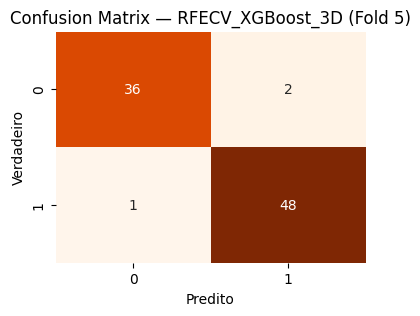


Gráfico de métricas por fold — RFECV_XGBoost_3D


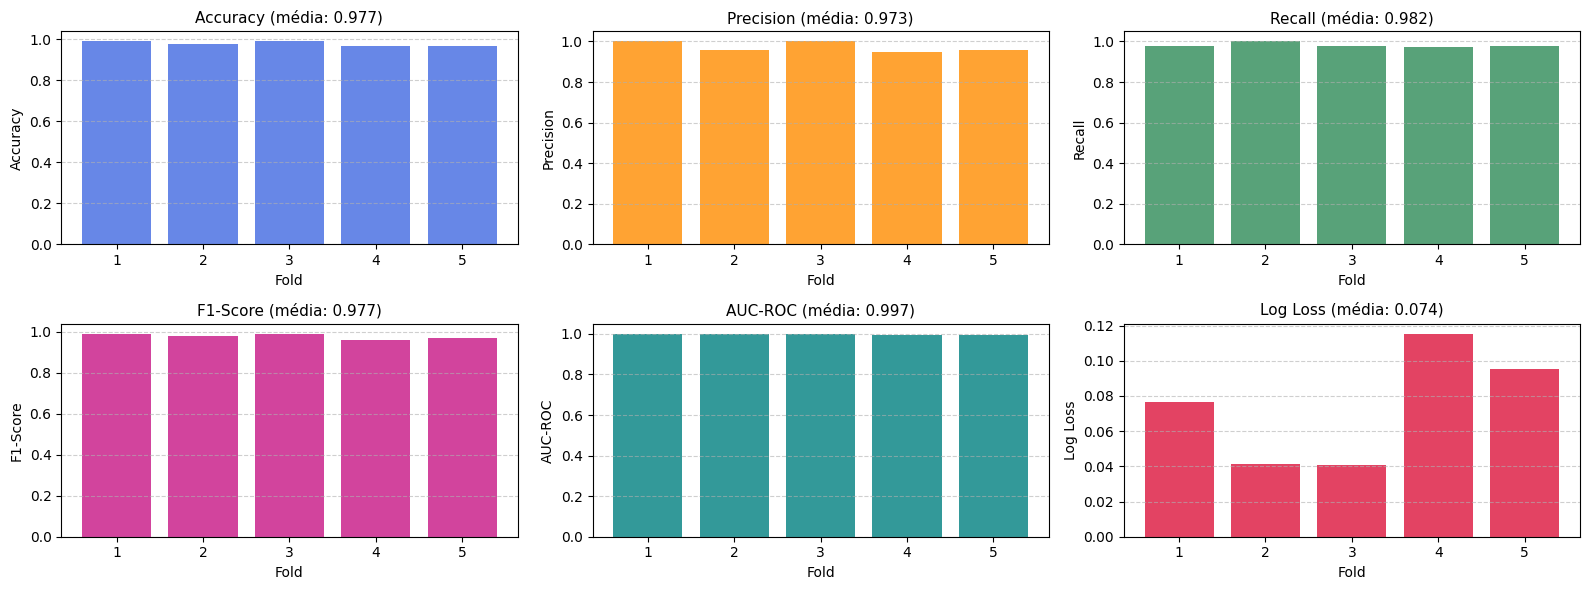


A treinar XGBoost com feature set: RFECV_LinearSVM_3D (5 variáveis)


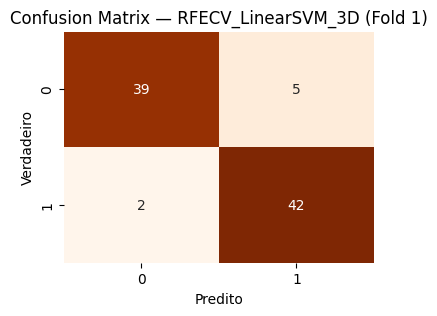

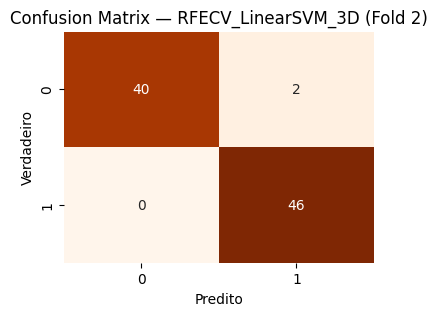

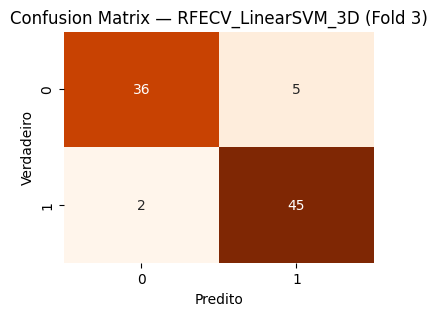

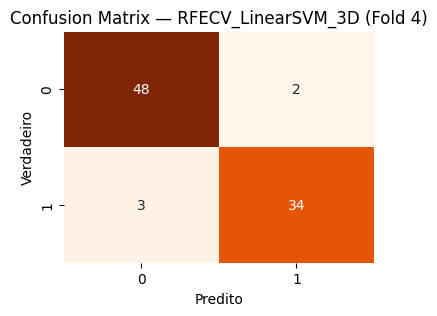

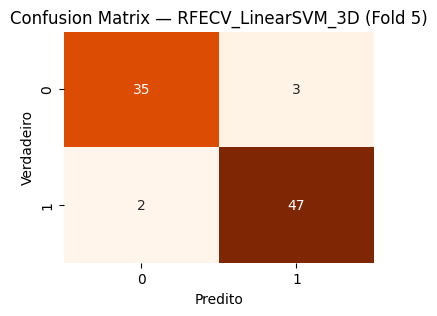


Gráfico de métricas por fold — RFECV_LinearSVM_3D


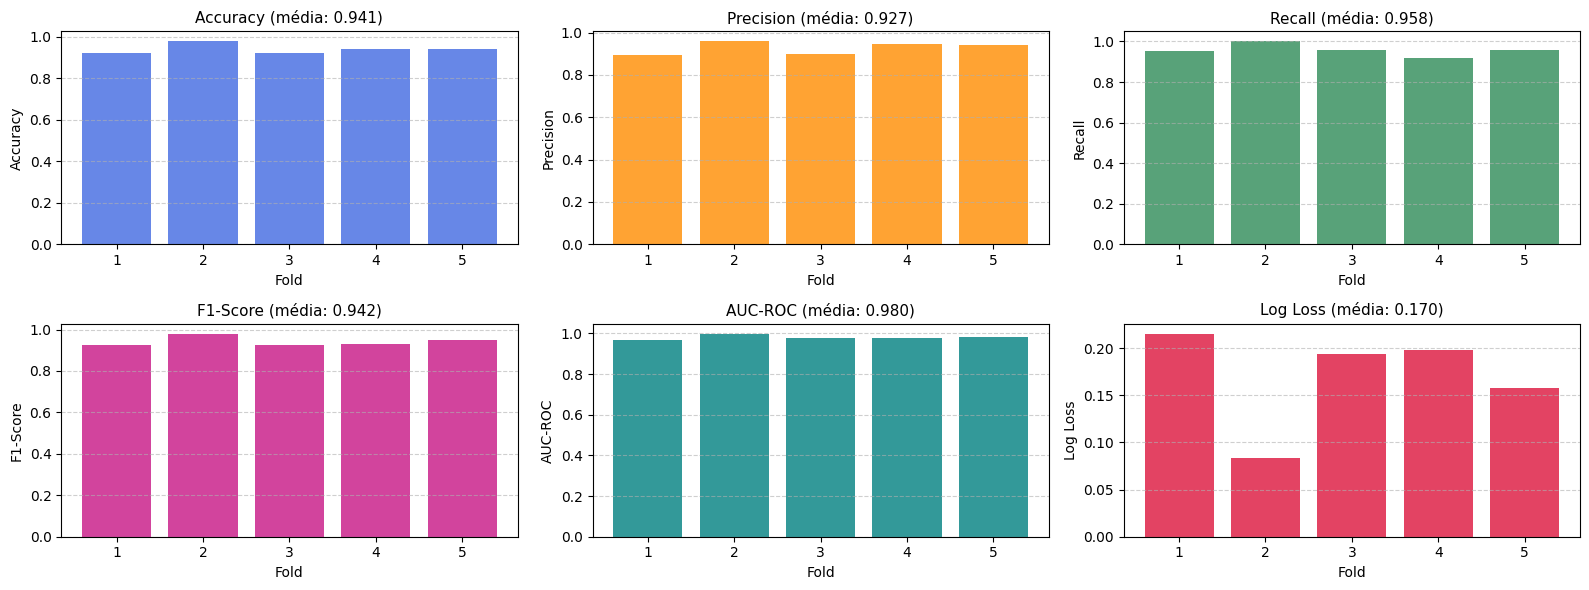


A treinar XGBoost com feature set: SVM (8 variáveis)


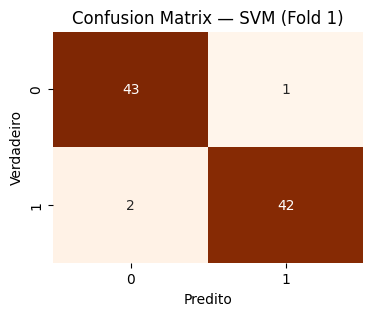

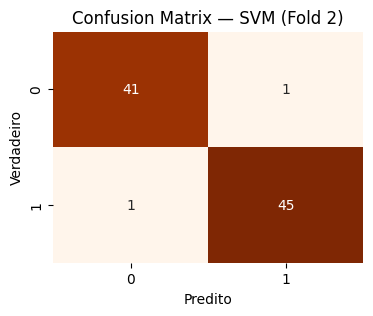

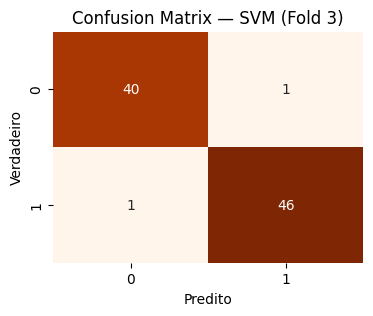

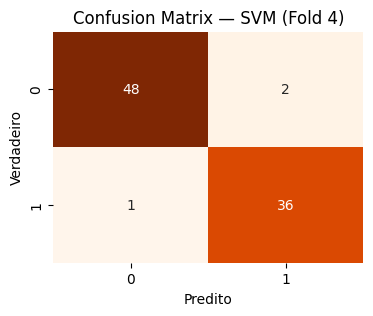

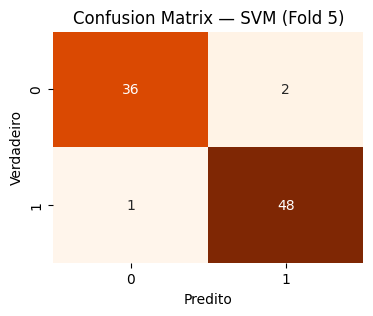


Gráfico de métricas por fold — SVM


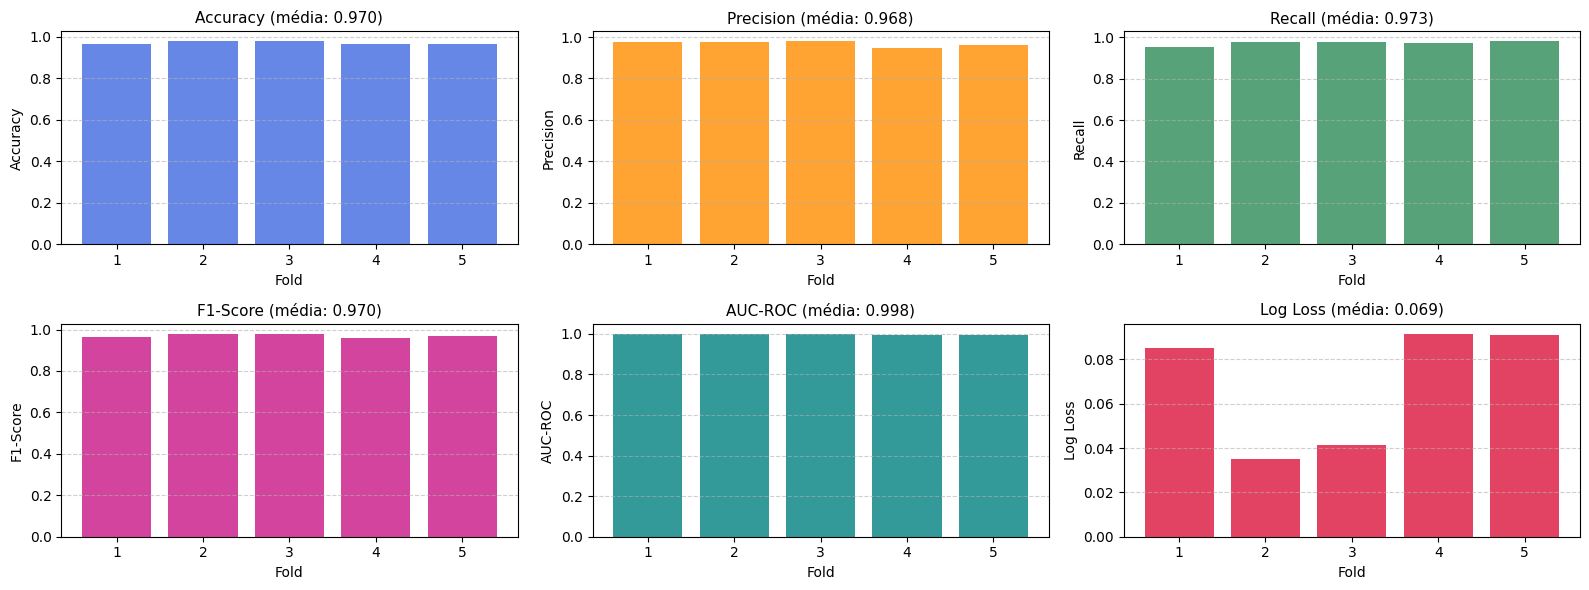

<Figure size 1000x600 with 0 Axes>

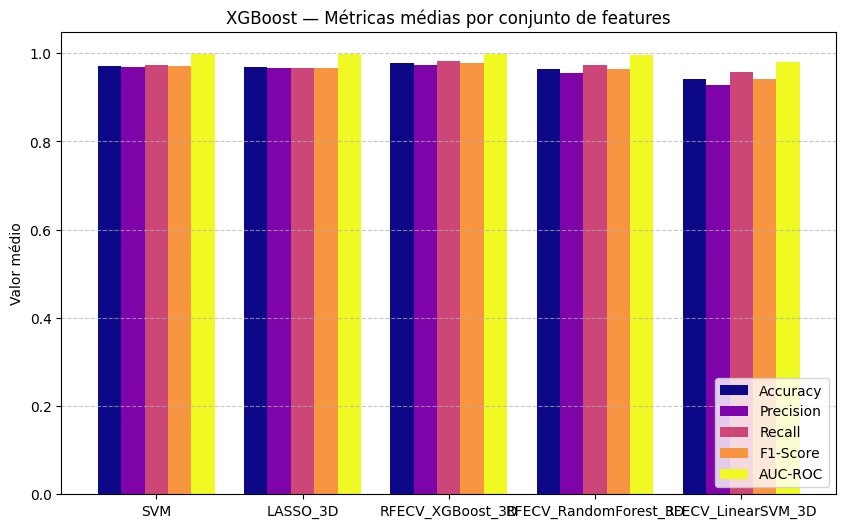


Avaliação final com XGBoost concluída


Feature_Set  Fold  Accuracy  Precision    Recall  F1-Score  \
0                LASSO_3D     1  0.965909   0.976744  0.954545  0.965517   
1                LASSO_3D     2  0.988636   1.000000  0.978261  0.989011   
2                LASSO_3D     3  0.977273   0.978723  0.978723  0.978723   
3                LASSO_3D     4  0.942529   0.921053  0.945946  0.933333   
4                LASSO_3D     5  0.965517   0.960000  0.979592  0.969697   
5   RFECV_RandomForest_3D     1  0.943182   0.933333  0.954545  0.943820   
6   RFECV_RandomForest_3D     2  0.977273   0.978261  0.978261  0.978261   
7   RFECV_RandomForest_3D     3  0.977273   0.978723  0.978723  0.978723   
8   RFECV_RandomForest_3D     4  0.954023   0.923077  0.972973  0.947368   
9   RFECV_RandomForest_3D     5  0.965517   0.960000  0.979592  0.969697   
10       RFECV_XGBoost_3D     1  0.988636   1.000000  0.977273  0.988506   
11       RFECV_XGBoost_3D     2  0.977273   0.958333  1.000000  0.978723   
12       RFECV_XGBoost_3D     3  0.988636   1.000000  0.978723  0.989247   
13       RFECV_XGBoost_3D     4  0.965517   0.947368  0.972973  0.960000   
14       RFECV_XGBoost_3D     5  0.965517   0.960000  0.979592  0.969697   
15     RFECV_LinearSVM_3D     1  0.920455   0.893617  0.954545  0.923077   
16     RFECV_LinearSVM_3D     2  0.977273   0.958333  1.000000  0.978723   
17     RFECV_LinearSVM_3D     3  0.920455   0.900000  0.957447  0.927835   
18     RFECV_LinearSVM_3D     4  0.942529   0.944444  0.918919  0.931507   
19     RFECV_LinearSVM_3D     5  0.942529   0.940000  0.959184  0.949495   
20                    SVM     1  0.965909   0.976744  0.954545  0.965517   
21                    SVM     2  0.977273   0.978261  0.978261  0.978261   
22                    SVM     3  0.977273   0.978723  0.978723  0.978723   
23                    SVM     4  0.965517   0.947368  0.972973  0.960000   
24                    SVM     5  0.965517   0.960000  0.979592  0.969697   

     AUC-ROC  Log Loss  
0   0.997417  0.077052  
1   0.998965  0.037234  
2   0.998962  0.040058  
3   0.996216  0.097257  
4   0.996778  0.079748  
5   0.993802  0.116539  
6   0.998965  0.047170  
7   0.998962  0.044322  
8   0.995135  0.138365  
9   0.997315  0.088563  
10  0.998450  0.076404  
11  0.999482  0.041317  
12  0.999481  0.040863  
13  0.995135  0.115204  
14  0.994092  0.095465  
15  0.969525  0.214886  
16  0.997412  0.083274  
17  0.978204  0.193893  
18  0.975135  0.198282  
19  0.980129  0.157205  
20  0.996901  0.084953  
21  0.999482  0.035027  
22  0.999481  0.041500  
23  0.996757  0.091419  
24  0.996778  0.091077

Accuracy  Precision    Recall  F1-Score   AUC-ROC  \
SVM                    0.970298   0.968219  0.972819  0.970440  0.997880   
LASSO_3D               0.967973   0.967304  0.967414  0.967256  0.997668   
RFECV_XGBoost_3D       0.977116   0.973140  0.981712  0.977235  0.997328   
RFECV_RandomForest_3D  0.963454   0.954679  0.972819  0.963574  0.996836   
RFECV_LinearSVM_3D     0.940648   0.927279  0.958019  0.942127  0.980081   

                       Log Loss  
SVM                    0.068795  
LASSO_3D               0.066270  
RFECV_XGBoost_3D       0.073850  
RFECV_RandomForest_3D  0.086992  
RFECV_LinearSVM_3D     0.169508

In [109]:
# 2D
xgb_results_2d, xgb_avg_2d = run_xgboost_kfold_report(feature_sets_2d, merged_df_2d, k=5)
display(xgb_results_2d)  # Para ANOVA
display(xgb_avg_2d)       # Para gráficos

# 3D
xgb_results_3d, xgb_avg_3d = run_xgboost_kfold_report(feature_sets_3d, merged_df_3d, k=5)
display(xgb_results_3d)
display(xgb_avg_3d)

### 10.3 SVM <a id="xgboost"><a/>

#### O Support Vector Machine (SVM) é um método robusto e eficaz em problemas de classificação binária.
#### Baseia-se na maximização da margem entre classes, permitindo modelar fronteiras de decisão complexas através do uso de funções kernel. É particularmente adequado para datasets de dimensão moderada e com possíveis sobreposições nas variáveis.

#### 10.3.1 SVM sem feature selection <a id="svmsem"><a/>
[Voltar a SVM](#svm)

In [90]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
import pandas as pd
import numpy as np

# Lista para resultados detalhados
all_folds_results = []

# Lista de datasets
datasets = {
    '2D': (X_2d_train, y_2d_train),
    '3D': (X_3d_train, y_3d_train)
}

k = 5
random_state = 42

for dataset_name, (X_train_full, y_train_full) in datasets.items():
    print(f"\nTreinando SVM com {dataset_name} — K-Fold CV (k={k})")
    
    # Concatenar treino + teste para K-Fold
    X_full = pd.concat([X_train_full, X_train_full]) if False else X_train_full  # só se quiseres usar todo o conjunto
    y_full = pd.concat([y_train_full, y_train_full]) if False else y_train_full
    
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    fold_num = 1
    
    for train_idx, test_idx in kf.split(X_full):
        X_train, X_test = X_full.iloc[train_idx], X_full.iloc[test_idx]
        y_train, y_test = y_full.iloc[train_idx], y_full.iloc[test_idx]
        
        model = SVC(kernel='rbf', probability=True, random_state=random_state)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        metrics = calculate_metrics(y_test, y_pred, y_prob)
        metrics['Dataset'] = dataset_name
        metrics['Fold'] = fold_num
        
        all_folds_results.append(metrics)
        fold_num += 1

# DataFrame final com todos os folds
results_svm_all_folds = pd.DataFrame(all_folds_results)
results_svm_all_folds = results_svm_all_folds[['Dataset', 'Fold', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Log Loss']]

print("Resultados SVM sem feature selection (K-Fold 5):")
display(results_svm_all_folds)


Treinando SVM com 2D — K-Fold CV (k=5)

Treinando SVM com 3D — K-Fold CV (k=5)
Resultados SVM sem feature selection (K-Fold 5):


Dataset  Fold  Accuracy  Precision    Recall  F1-Score   AUC-ROC  Log Loss
0      2D     1  0.758065   0.758621  0.733333  0.745763  0.877083  0.437441
1      2D     2  0.786885   0.857143  0.727273  0.786885  0.856061  0.488021
2      2D     3  0.836066   0.903226  0.800000  0.848485  0.901099  0.407710
3      2D     4  0.704918   0.791667  0.593750  0.678571  0.862069  0.454324
4      2D     5  0.754098   0.750000  0.666667  0.705882  0.834423  0.481771
5      3D     1  0.790323   0.793103  0.766667  0.779661  0.872917  0.476042
6      3D     2  0.672131   0.740741  0.606061  0.666667  0.791126  0.602640
7      3D     3  0.803279   0.848485  0.800000  0.823529  0.847253  0.485372
8      3D     4  0.737705   0.833333  0.625000  0.714286  0.858836  0.495197
9      3D     5  0.836066   0.840000  0.777778  0.807692  0.903050  0.452059

#### 10.3.2 SVM com diferentes conjuntos de features <a id="svmfeatures"><a/>
[Voltar a SVM](#svm)

In [99]:
# Função: treinar e avaliar SVM com K-Fold CV (versão detalhada por fold)
def run_svm_kfold_report(feature_sets, merged_df, k=5, random_state=42, kernel='rbf'):

    all_folds_results = []  # <-- guarda resultados individuais (para análise estatística)
    avg_results = {}        # <-- guarda médias (para visualização final)

    for feature_set_name, features in feature_sets.items():
        print(f"\nA treinar SVM com feature set: {feature_set_name} ({len(features)} variáveis)")

        X = merged_df[features]
        y = merged_df['Malignancy']

        kf = KFold(n_splits=k, shuffle=True, random_state=random_state)

        # armazenar métricas por fold
        accuracies, precisions, recalls, f1s, aucs, losses = [], [], [], [], [], []

        fold = 1
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Modelo SVM
            model = SVC(
                kernel=kernel,
                probability=True,   # necessário para obter y_prob
                random_state=random_state
            )

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]

            # Calcular métricas com a função auxiliar
            metrics = calculate_metrics(y_test, y_pred, y_prob)

            # Guardar resultados do fold
            all_folds_results.append({
                'Feature_Set': feature_set_name,
                'Fold': fold,
                'Accuracy': metrics['Accuracy'],
                'Precision': metrics['Precision'],
                'Recall': metrics['Recall'],
                'F1-Score': metrics['F1-Score'],
                'AUC-ROC': metrics['AUC-ROC'],
                'Log Loss': metrics['Log Loss']
            })

            accuracies.append(metrics['Accuracy'])
            precisions.append(metrics['Precision'])
            recalls.append(metrics['Recall'])
            f1s.append(metrics['F1-Score'])
            aucs.append(metrics['AUC-ROC'])
            losses.append(metrics['Log Loss'])

            #Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(4, 3))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
            plt.title(f"Confusion Matrix — {feature_set_name} (Fold {fold})")
            plt.xlabel("Predito")
            plt.ylabel("Verdadeiro")
            plt.show()

            fold += 1

        # Mostrar gráfico de métricas por fold
        print(f"\nGráfico de métricas por fold — {feature_set_name}")
        plot_fold_metrics(accuracies, precisions, recalls, f1s, aucs, losses)

        # Calcular médias para visualização final
        avg_results[feature_set_name] = {
            'Accuracy': np.mean(accuracies),
            'Precision': np.mean(precisions),
            'Recall': np.mean(recalls),
            'F1-Score': np.mean(f1s),
            'AUC-ROC': np.nanmean(aucs),
            'Log Loss': np.nanmean(losses)
        }

    # DataFrame com as médias (para visualização geral)
    avg_df = pd.DataFrame(avg_results).T[
        ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Log Loss']
    ].sort_values(by='AUC-ROC', ascending=False)

    # Gráfico final com as médias por conjunto de features
    plt.figure(figsize=(10, 6))
    avg_df.drop(columns=['Log Loss']).plot(
        kind='bar', figsize=(10, 6), width=0.8,
        colormap='magma'
    )
    plt.title("SVM — Métricas médias por conjunto de features")
    plt.ylabel("Valor médio")
    plt.xticks(rotation=0)
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    print("\nAvaliação final concluída :)")

    # DataFrame completo com todos os folds
    detailed_df = pd.DataFrame(all_folds_results)

    # Retornar ambos: detalhado (para análise) e médias (para gráfico)
    return detailed_df, avg_df

#### 10.3.3 Resultados SVM <a id="svmfeatures"><a/>
[Voltar a SVM](#svm)


A treinar SVM com feature set: LASSO_2D (8 variáveis)


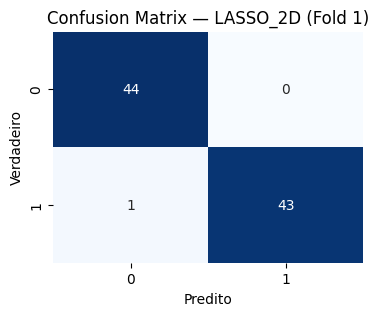

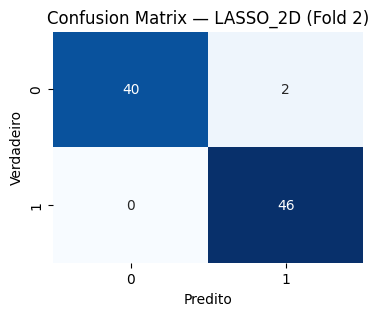

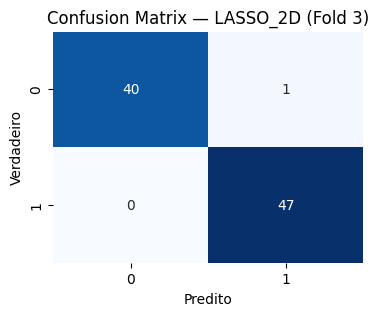

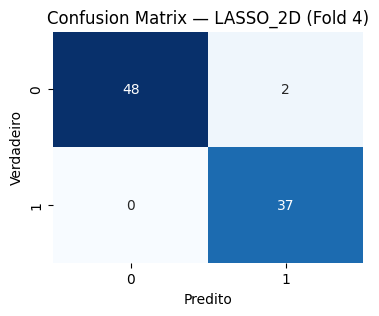

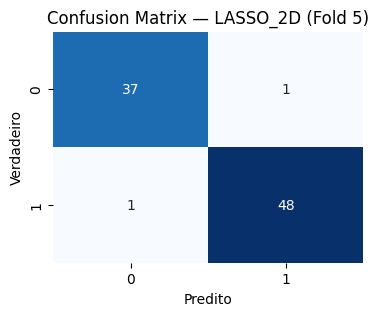


Gráfico de métricas por fold — LASSO_2D


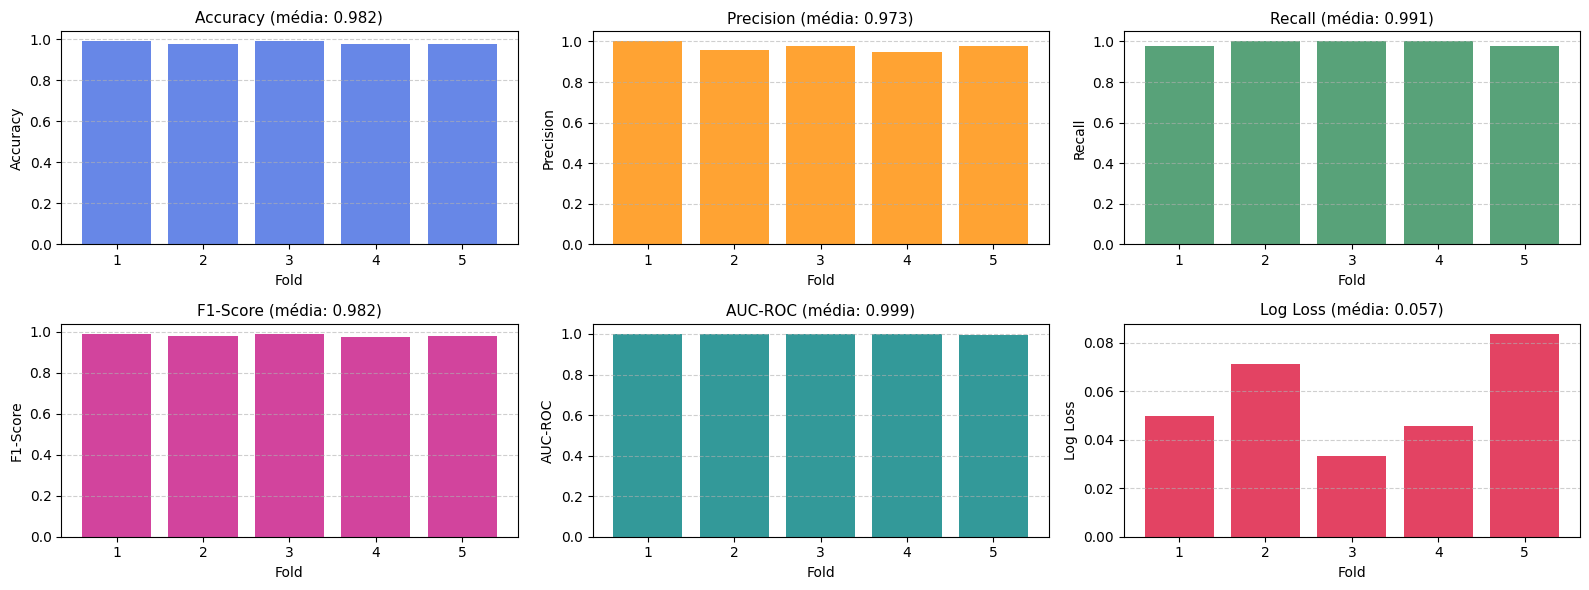


A treinar SVM com feature set: RFECV_RandomForest_2D (13 variáveis)


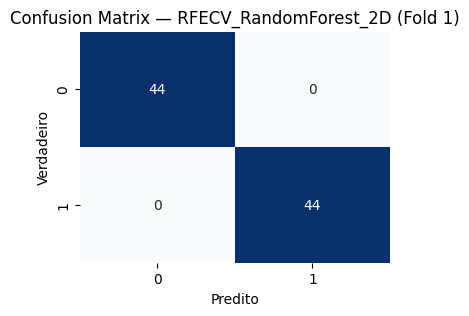

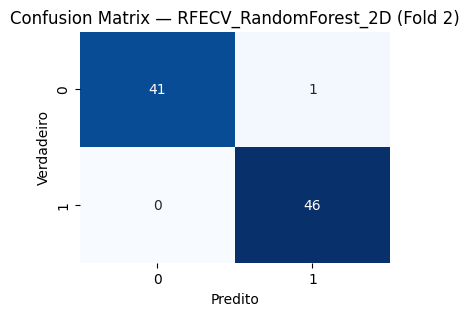

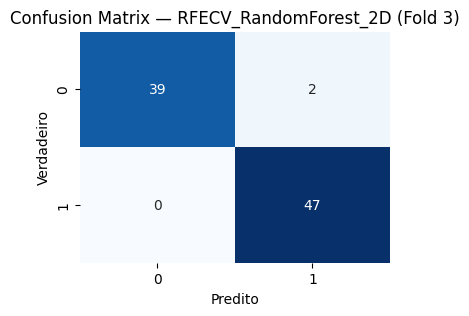

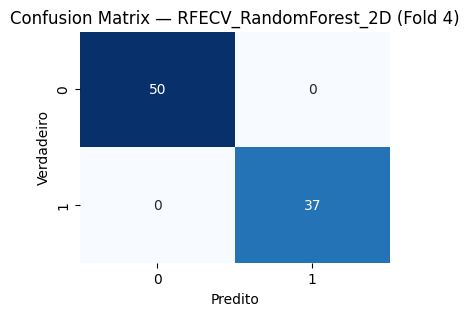

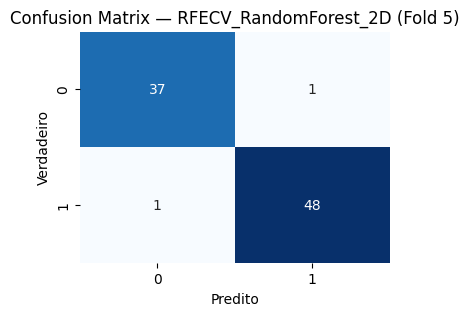


Gráfico de métricas por fold — RFECV_RandomForest_2D


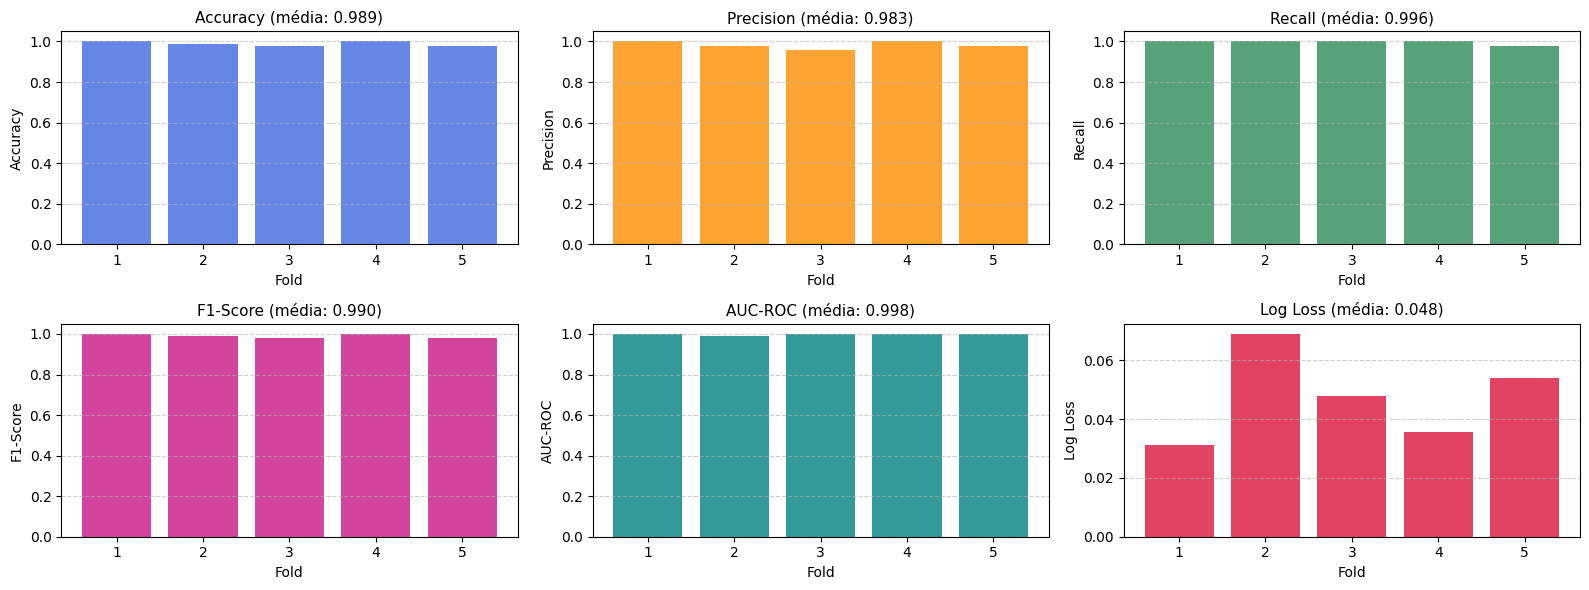


A treinar SVM com feature set: RFECV_XGBoost_2D (6 variáveis)


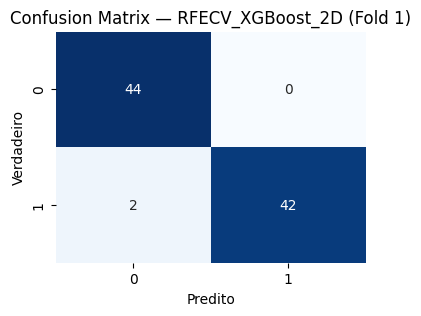

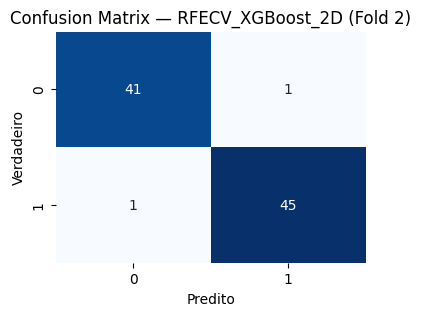

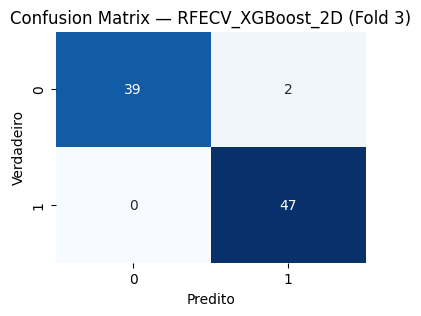

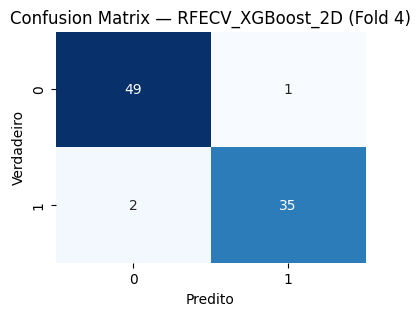

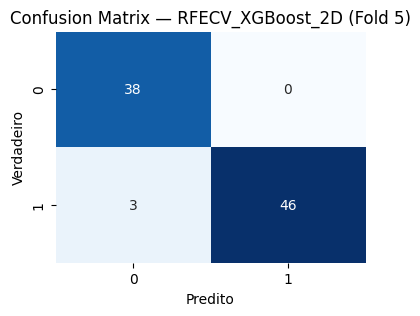


Gráfico de métricas por fold — RFECV_XGBoost_2D


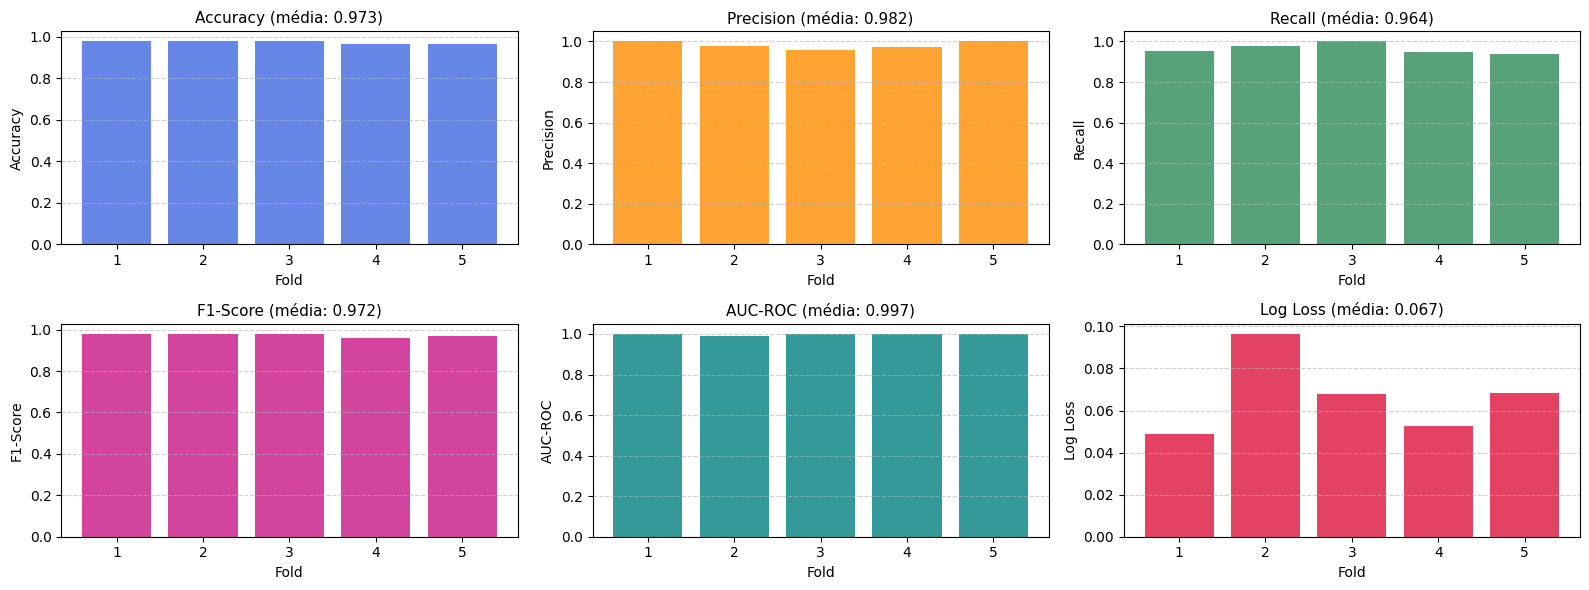


A treinar SVM com feature set: RFECV_LinearSVM_2D (14 variáveis)


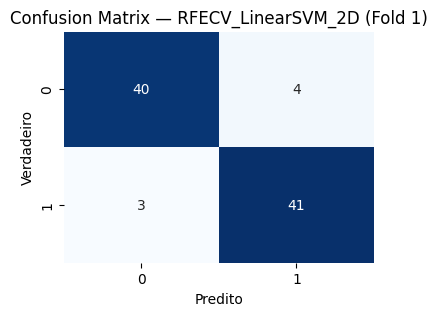

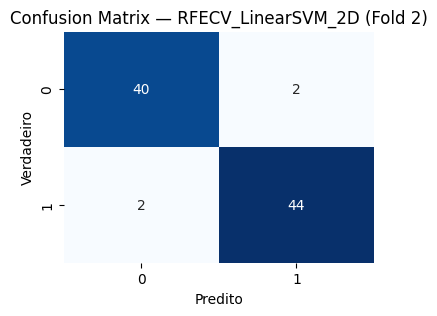

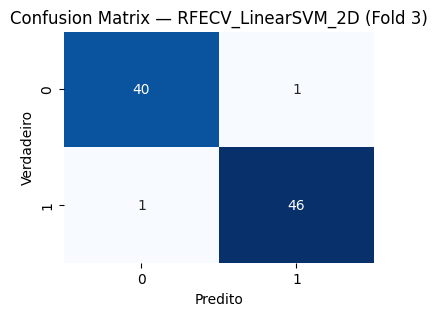

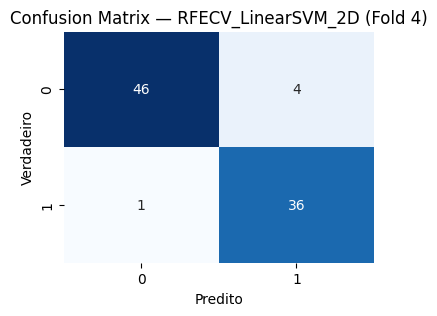

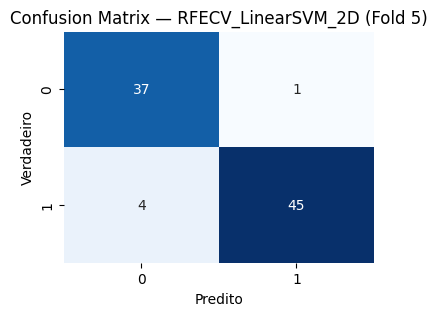


Gráfico de métricas por fold — RFECV_LinearSVM_2D


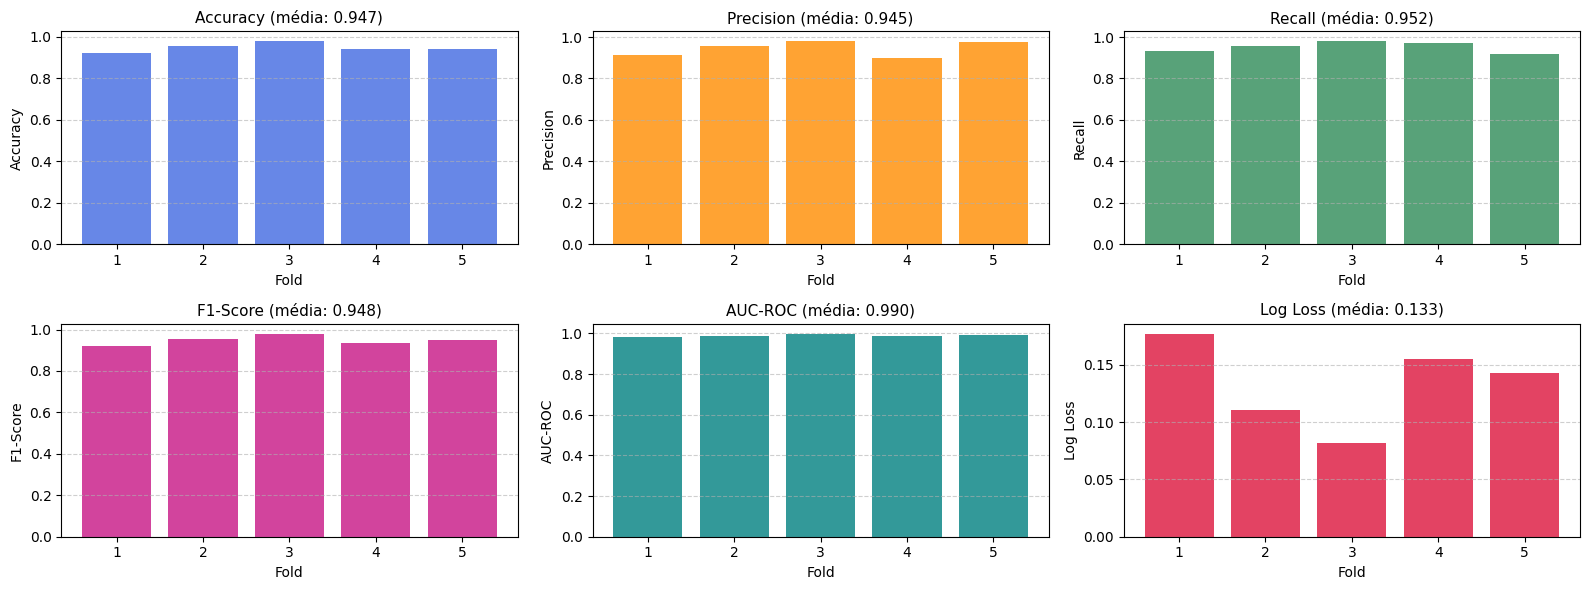


A treinar SVM com feature set: SVM (23 variáveis)


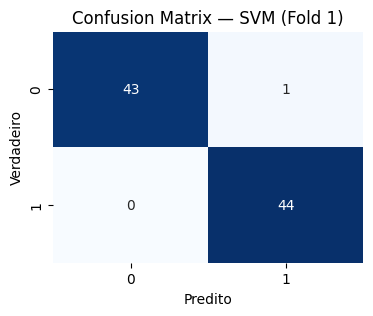

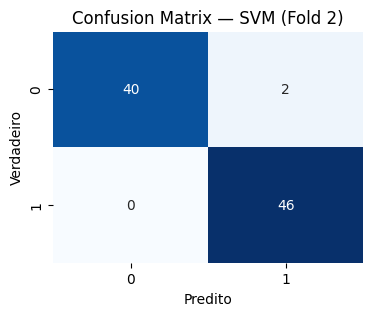

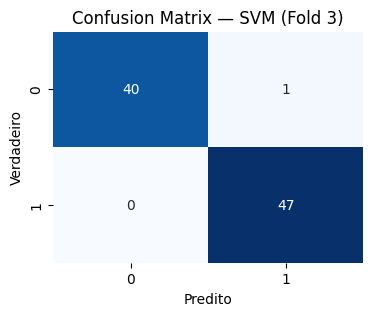

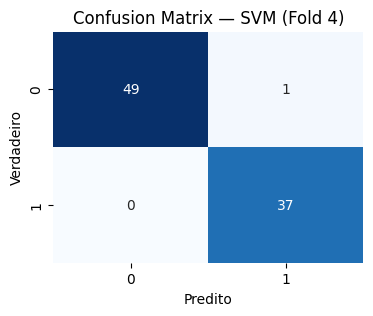

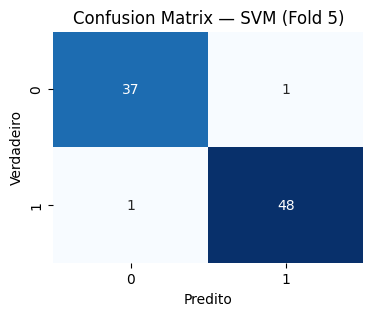


Gráfico de métricas por fold — SVM


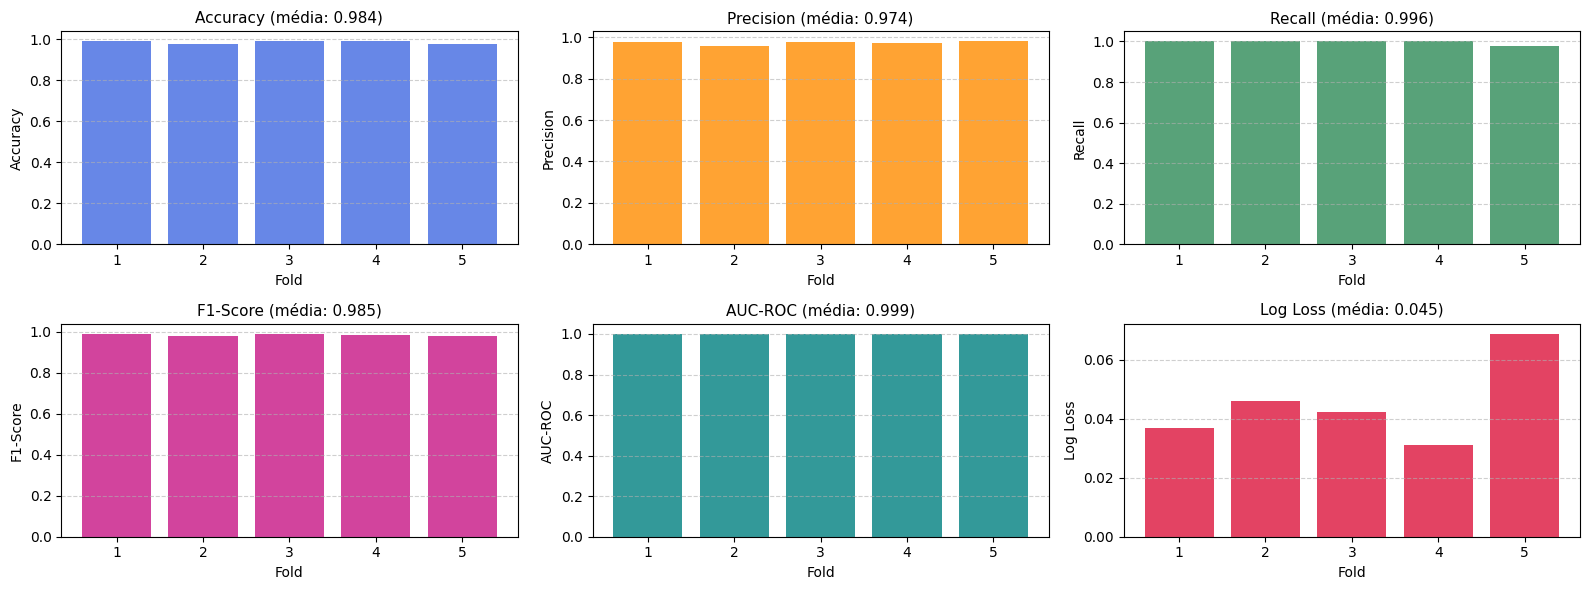

<Figure size 1000x600 with 0 Axes>

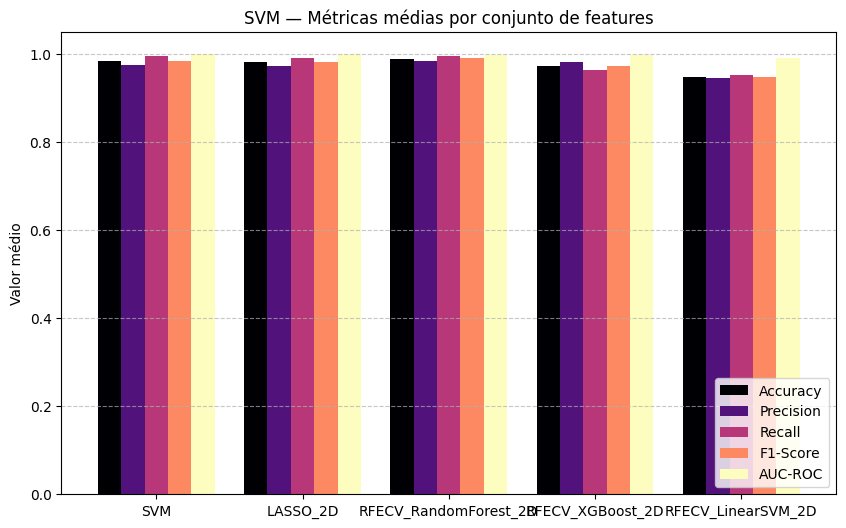


Avaliação final concluída :)


Accuracy  Precision    Recall  F1-Score   AUC-ROC  \
SVM                    0.984013   0.973711  0.995918  0.984644  0.999260   
LASSO_2D               0.981714   0.973162  0.991373  0.981996  0.998631   
RFECV_RandomForest_2D  0.988584   0.983500  0.995918  0.989601  0.997921   
RFECV_XGBoost_2D       0.972571   0.981933  0.963506  0.972299  0.996765   
RFECV_LinearSVM_2D     0.947466   0.944923  0.951681  0.947805  0.989694   

                       Log Loss  
SVM                    0.045023  
LASSO_2D               0.056647  
RFECV_RandomForest_2D  0.047578  
RFECV_XGBoost_2D       0.066860  
RFECV_LinearSVM_2D     0.133279

Feature_Set  Fold  Accuracy  Precision    Recall  F1-Score  \
0                LASSO_2D     1  0.988636   1.000000  0.977273  0.988506   
1                LASSO_2D     2  0.977273   0.958333  1.000000  0.978723   
2                LASSO_2D     3  0.988636   0.979167  1.000000  0.989474   
3                LASSO_2D     4  0.977011   0.948718  1.000000  0.973684   
4                LASSO_2D     5  0.977011   0.979592  0.979592  0.979592   
5   RFECV_RandomForest_2D     1  1.000000   1.000000  1.000000  1.000000   
6   RFECV_RandomForest_2D     2  0.988636   0.978723  1.000000  0.989247   
7   RFECV_RandomForest_2D     3  0.977273   0.959184  1.000000  0.979167   
8   RFECV_RandomForest_2D     4  1.000000   1.000000  1.000000  1.000000   
9   RFECV_RandomForest_2D     5  0.977011   0.979592  0.979592  0.979592   
10       RFECV_XGBoost_2D     1  0.977273   1.000000  0.954545  0.976744   
11       RFECV_XGBoost_2D     2  0.977273   0.978261  0.978261  0.978261   
12       RFECV_XGBoost_2D     3  0.977273   0.959184  1.000000  0.979167   
13       RFECV_XGBoost_2D     4  0.965517   0.972222  0.945946  0.958904   
14       RFECV_XGBoost_2D     5  0.965517   1.000000  0.938776  0.968421   
15     RFECV_LinearSVM_2D     1  0.920455   0.911111  0.931818  0.921348   
16     RFECV_LinearSVM_2D     2  0.954545   0.956522  0.956522  0.956522   
17     RFECV_LinearSVM_2D     3  0.977273   0.978723  0.978723  0.978723   
18     RFECV_LinearSVM_2D     4  0.942529   0.900000  0.972973  0.935065   
19     RFECV_LinearSVM_2D     5  0.942529   0.978261  0.918367  0.947368   
20                    SVM     1  0.988636   0.977778  1.000000  0.988764   
21                    SVM     2  0.977273   0.958333  1.000000  0.978723   
22                    SVM     3  0.988636   0.979167  1.000000  0.989474   
23                    SVM     4  0.988506   0.973684  1.000000  0.986667   
24                    SVM     5  0.977011   0.979592  0.979592  0.979592   

     AUC-ROC  Log Loss  
0   0.998967  0.049596  
1   0.997412  0.071282  
2   1.000000  0.033274  
3   1.000000  0.045529  
4   0.996778  0.083556  
5   1.000000  0.031270  
6   0.992236  0.068975  
7   0.998443  0.048019  
8   1.000000  0.035607  
9   0.998926  0.054016  
10  1.000000  0.048918  
11  0.989130  0.096409  
12  0.997924  0.067894  
13  0.998919  0.052816  
14  0.997852  0.068262  
15  0.983471  0.176947  
16  0.989130  0.110353  
17  0.996886  0.081477  
18  0.988649  0.155064  
19  0.990333  0.142553  
20  1.000000  0.036837  
21  0.998965  0.046109  
22  0.999481  0.042323  
23  1.000000  0.031192  
24  0.997852  0.068657


A treinar SVM com feature set: LASSO_3D (16 variáveis)


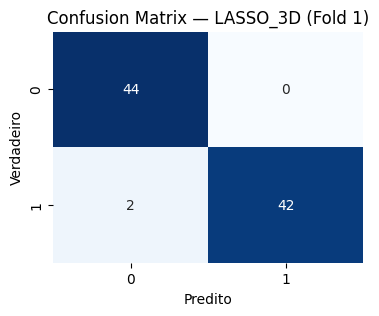

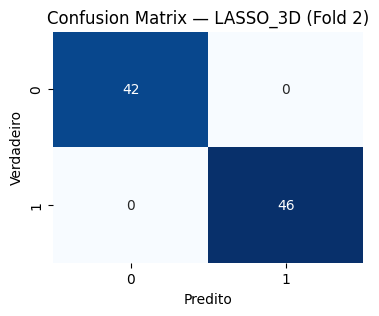

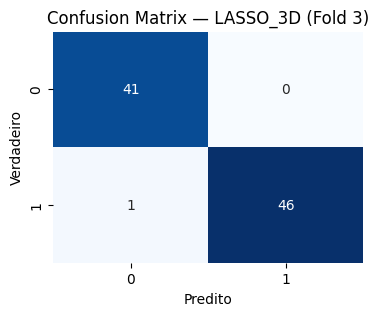

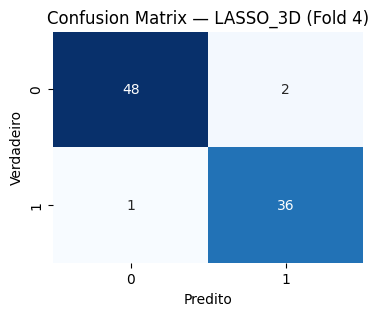

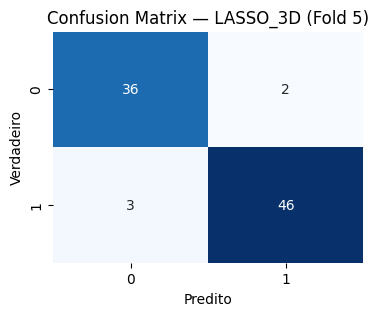


Gráfico de métricas por fold — LASSO_3D


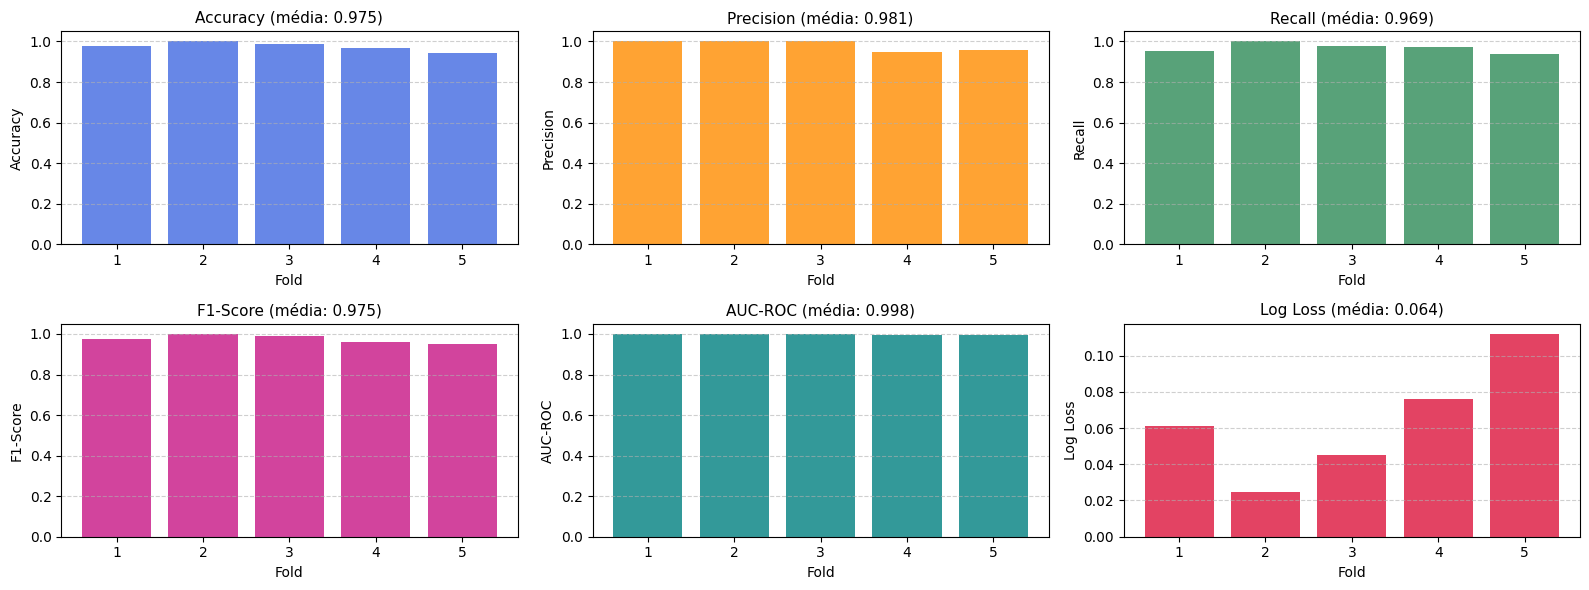


A treinar SVM com feature set: RFECV_RandomForest_3D (40 variáveis)


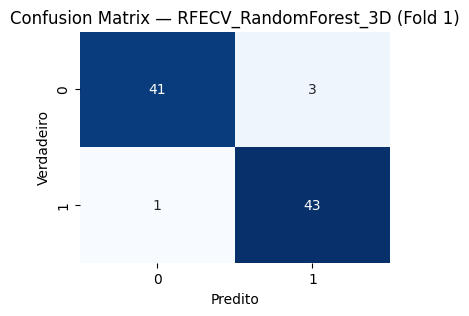

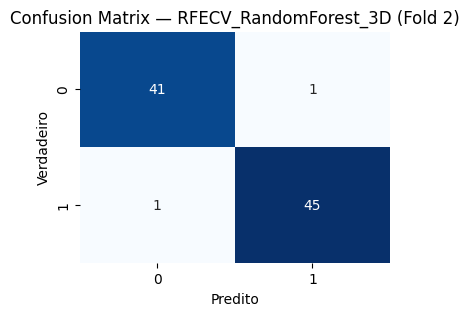

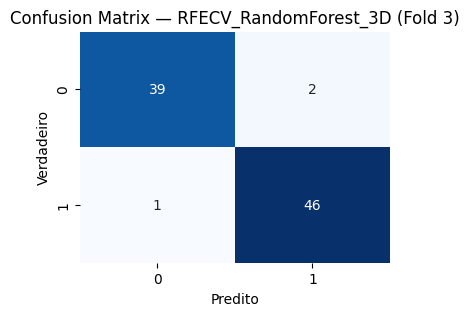

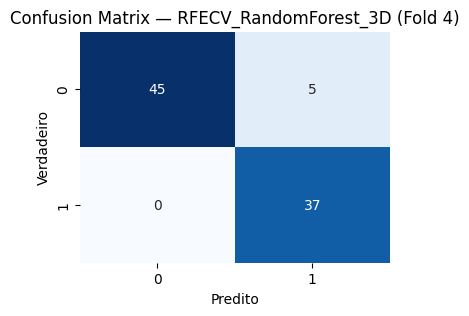

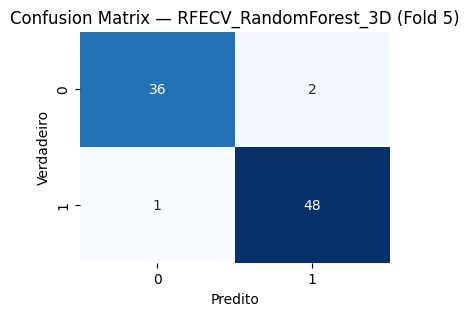


Gráfico de métricas por fold — RFECV_RandomForest_3D


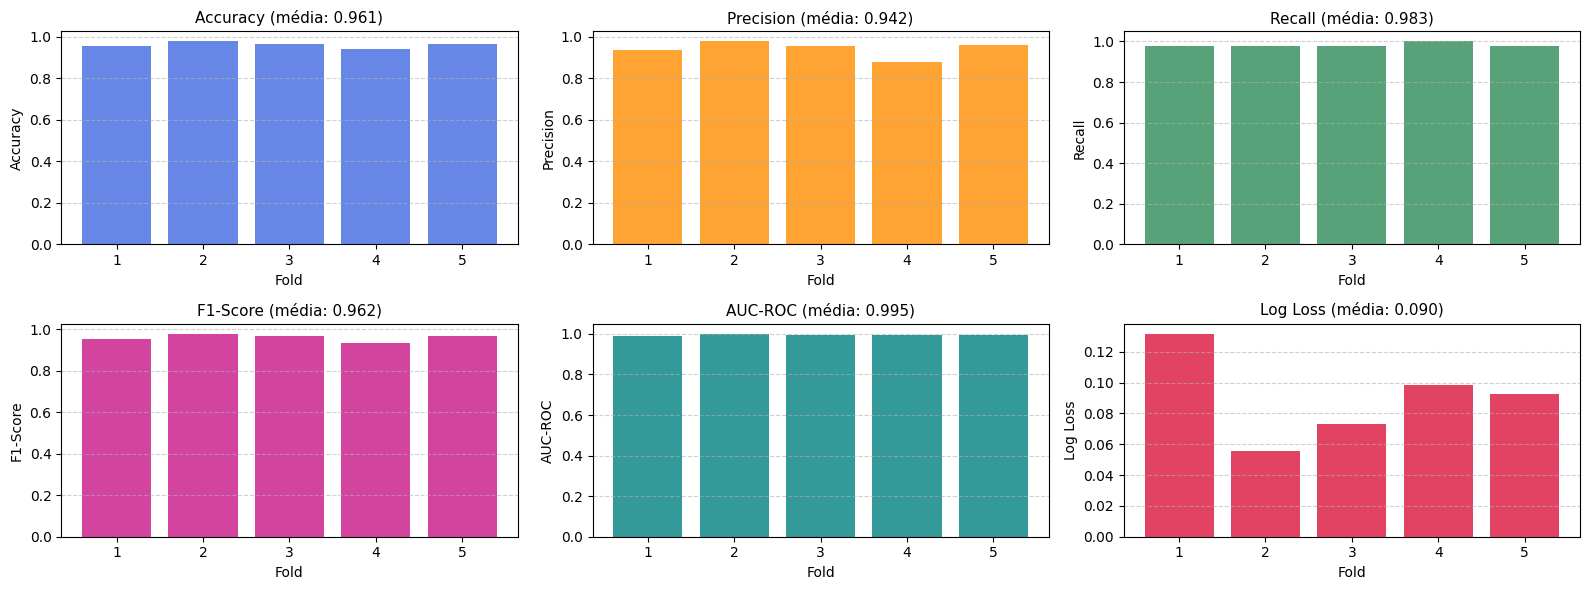


A treinar SVM com feature set: RFECV_XGBoost_3D (12 variáveis)


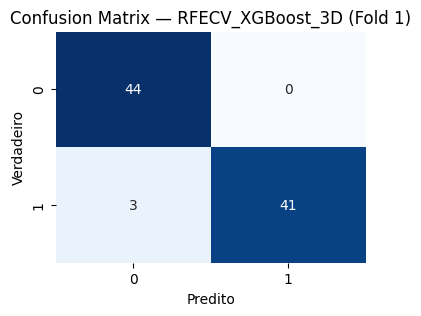

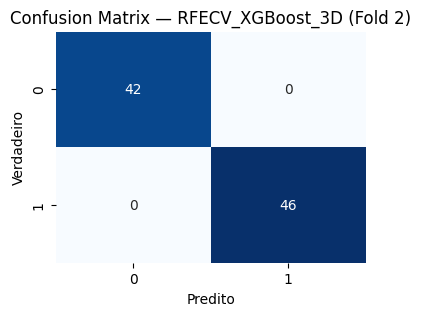

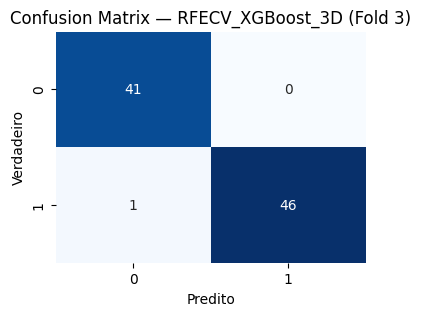

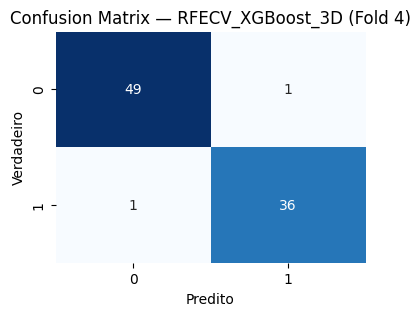

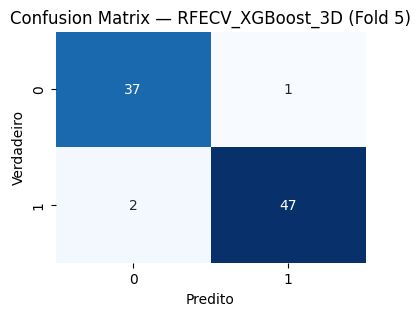


Gráfico de métricas por fold — RFECV_XGBoost_3D


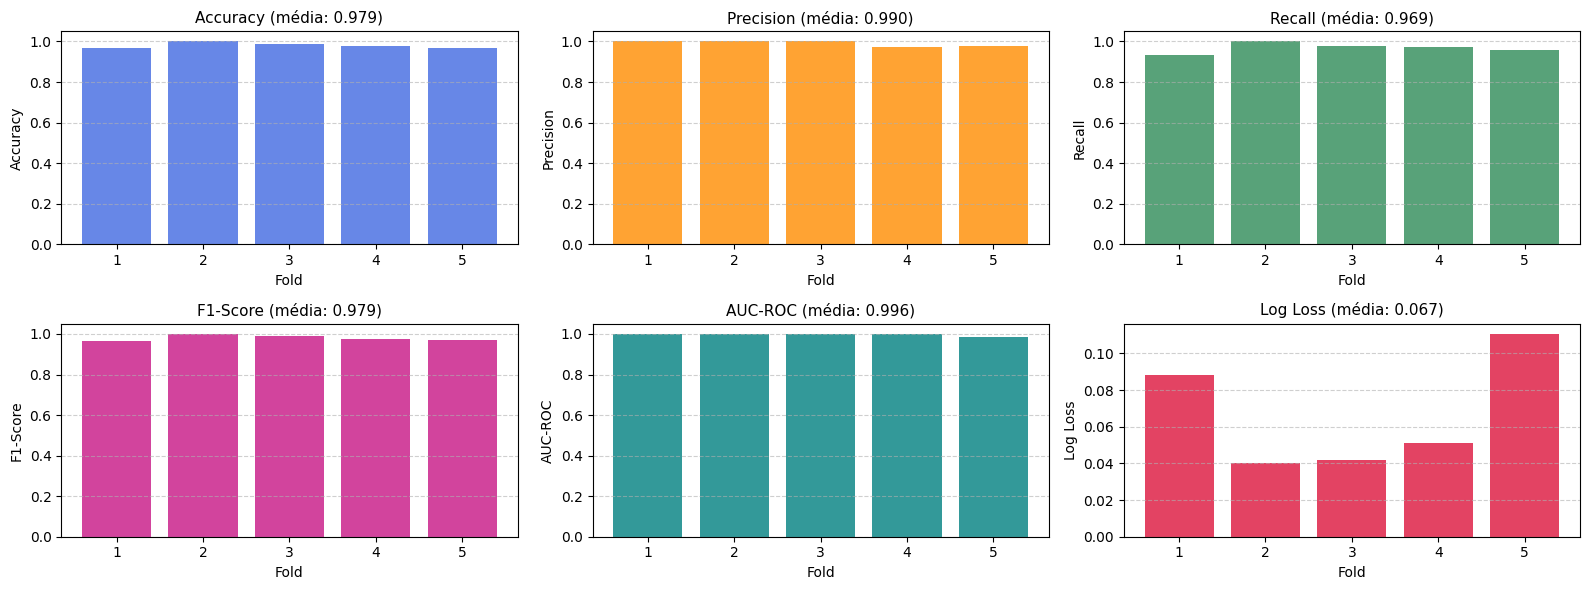


A treinar SVM com feature set: RFECV_LinearSVM_3D (5 variáveis)


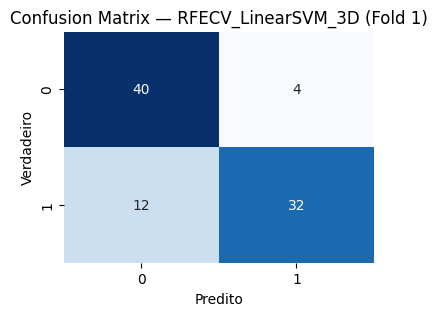

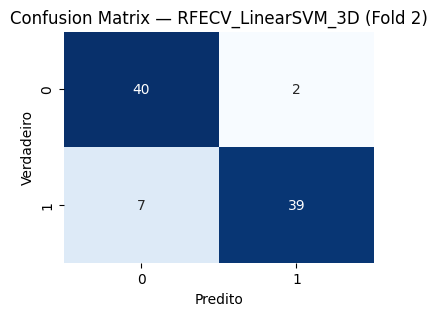

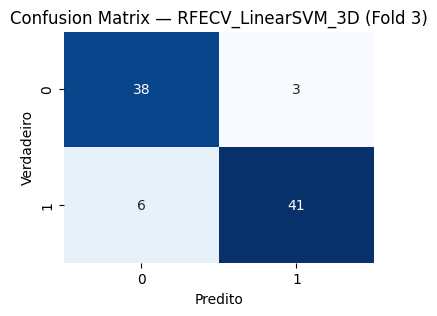

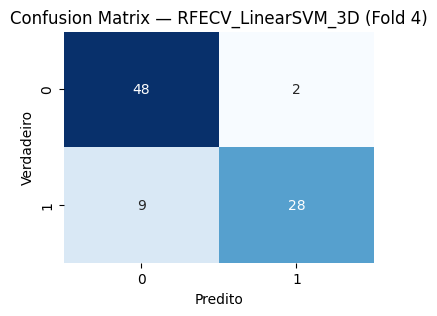

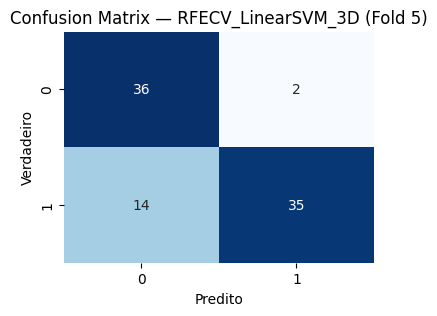


Gráfico de métricas por fold — RFECV_LinearSVM_3D


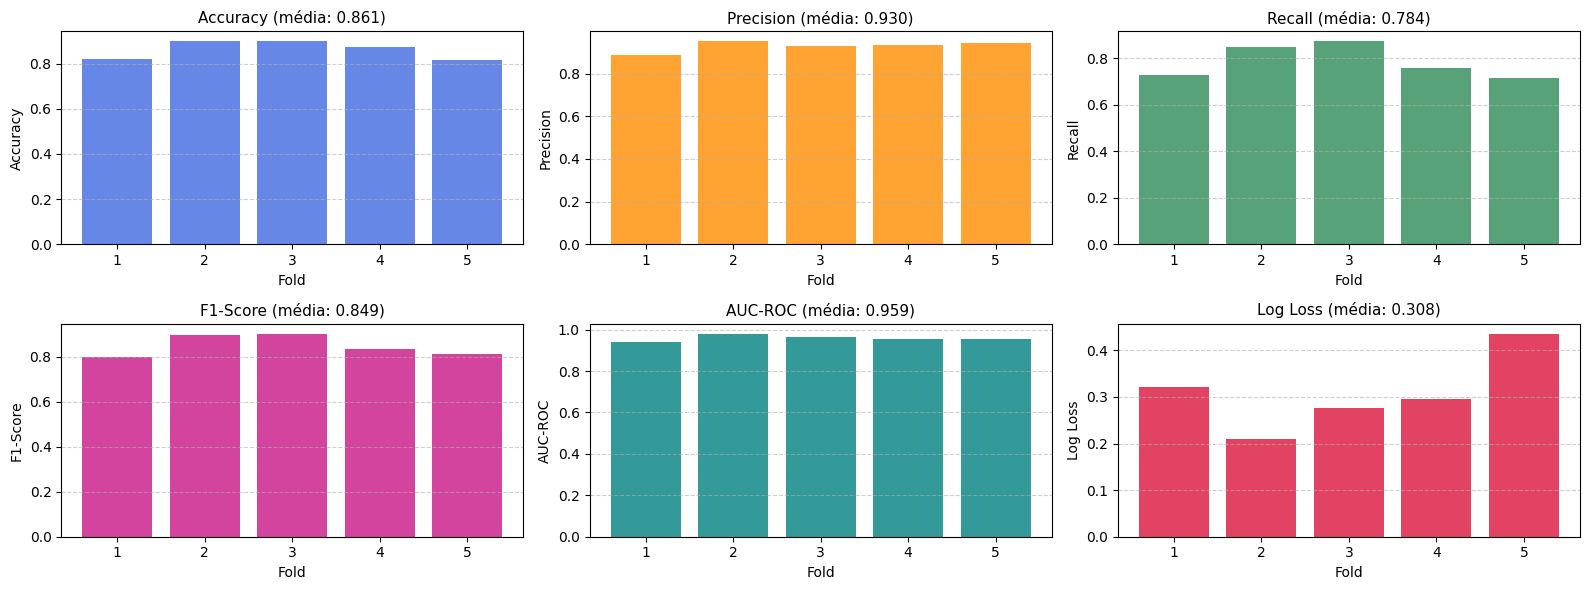


A treinar SVM com feature set: SVM (8 variáveis)


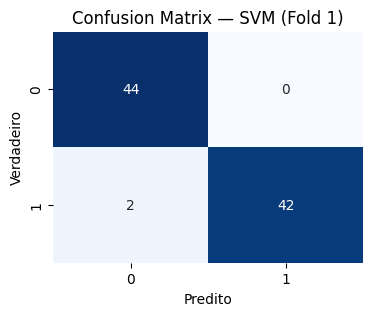

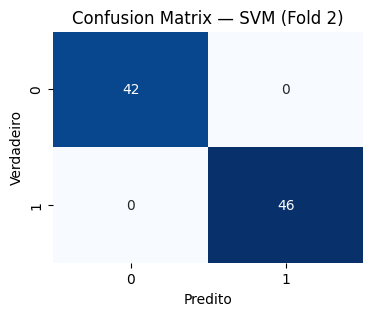

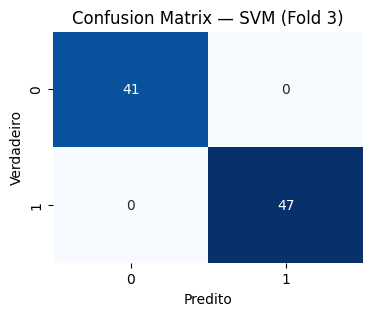

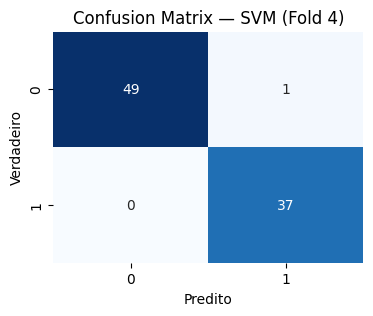

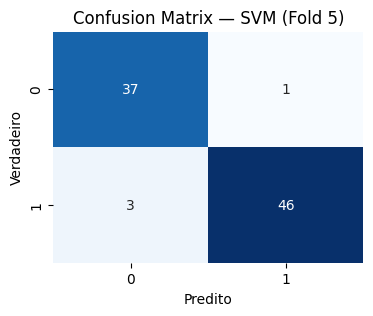


Gráfico de métricas por fold — SVM


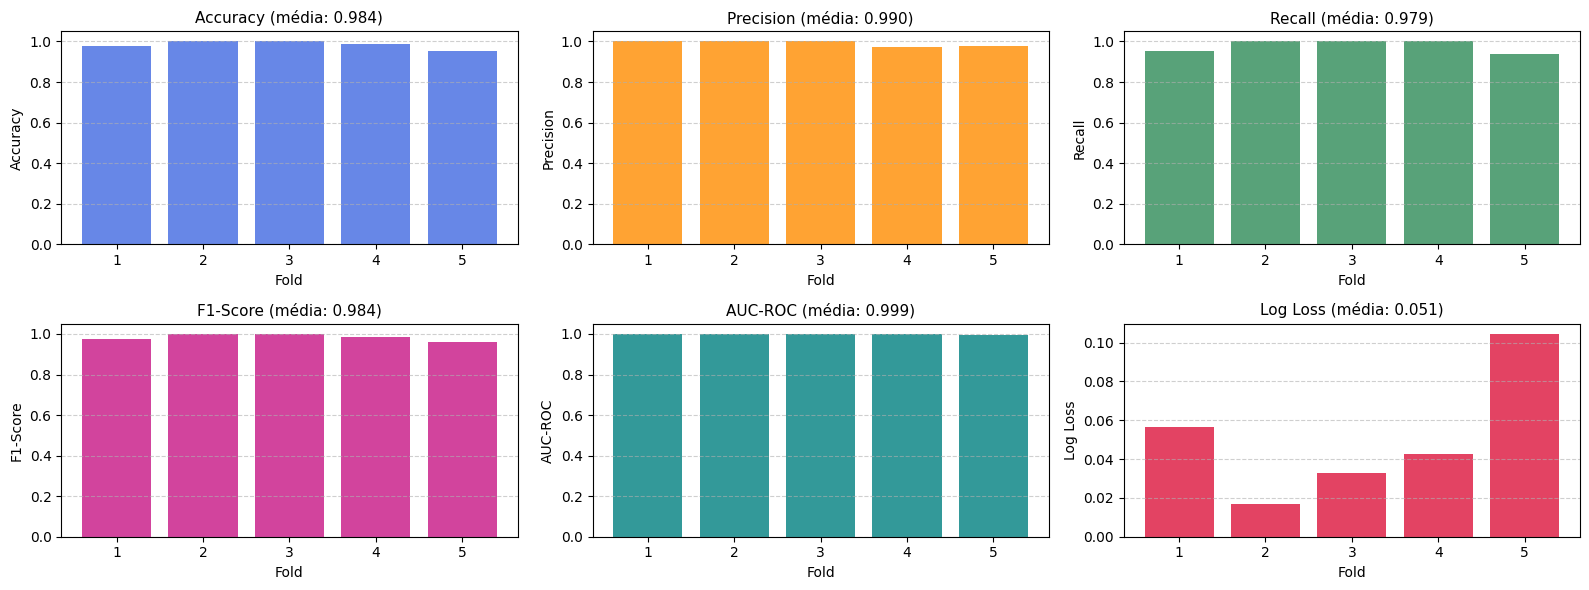

<Figure size 1000x600 with 0 Axes>

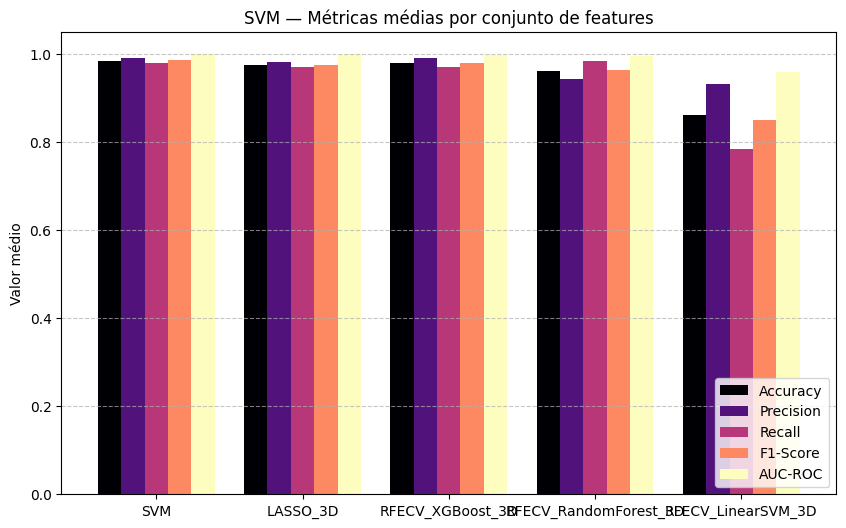


Avaliação final concluída :)


Accuracy  Precision    Recall  F1-Score   AUC-ROC  \
SVM                    0.983960   0.990482  0.978664  0.984349  0.998714   
LASSO_3D               0.974791   0.981140  0.969003  0.974889  0.997959   
RFECV_XGBoost_3D       0.979415   0.990428  0.968540  0.979200  0.996477   
RFECV_RandomForest_3D  0.961155   0.942466  0.982770  0.961729  0.994737   
RFECV_LinearSVM_3D     0.860658   0.930241  0.783696  0.849485  0.958818   

                       Log Loss  
SVM                    0.050648  
LASSO_3D               0.063648  
RFECV_XGBoost_3D       0.066518  
RFECV_RandomForest_3D  0.090137  
RFECV_LinearSVM_3D     0.308084

Feature_Set  Fold  Accuracy  Precision    Recall  F1-Score  \
0                LASSO_3D     1  0.977273   1.000000  0.954545  0.976744   
1                LASSO_3D     2  1.000000   1.000000  1.000000  1.000000   
2                LASSO_3D     3  0.988636   1.000000  0.978723  0.989247   
3                LASSO_3D     4  0.965517   0.947368  0.972973  0.960000   
4                LASSO_3D     5  0.942529   0.958333  0.938776  0.948454   
5   RFECV_RandomForest_3D     1  0.954545   0.934783  0.977273  0.955556   
6   RFECV_RandomForest_3D     2  0.977273   0.978261  0.978261  0.978261   
7   RFECV_RandomForest_3D     3  0.965909   0.958333  0.978723  0.968421   
8   RFECV_RandomForest_3D     4  0.942529   0.880952  1.000000  0.936709   
9   RFECV_RandomForest_3D     5  0.965517   0.960000  0.979592  0.969697   
10       RFECV_XGBoost_3D     1  0.965909   1.000000  0.931818  0.964706   
11       RFECV_XGBoost_3D     2  1.000000   1.000000  1.000000  1.000000   
12       RFECV_XGBoost_3D     3  0.988636   1.000000  0.978723  0.989247   
13       RFECV_XGBoost_3D     4  0.977011   0.972973  0.972973  0.972973   
14       RFECV_XGBoost_3D     5  0.965517   0.979167  0.959184  0.969072   
15     RFECV_LinearSVM_3D     1  0.818182   0.888889  0.727273  0.800000   
16     RFECV_LinearSVM_3D     2  0.897727   0.951220  0.847826  0.896552   
17     RFECV_LinearSVM_3D     3  0.897727   0.931818  0.872340  0.901099   
18     RFECV_LinearSVM_3D     4  0.873563   0.933333  0.756757  0.835821   
19     RFECV_LinearSVM_3D     5  0.816092   0.945946  0.714286  0.813953   
20                    SVM     1  0.977273   1.000000  0.954545  0.976744   
21                    SVM     2  1.000000   1.000000  1.000000  1.000000   
22                    SVM     3  1.000000   1.000000  1.000000  1.000000   
23                    SVM     4  0.988506   0.973684  1.000000  0.986667   
24                    SVM     5  0.954023   0.978723  0.938776  0.958333   

     AUC-ROC  Log Loss  
0   1.000000  0.061241  
1   1.000000  0.024446  
2   0.999481  0.044898  
3   0.997297  0.075742  
4   0.993018  0.111911  
5   0.989669  0.131594  
6   0.999482  0.055413  
7   0.995848  0.072878  
8   0.994595  0.098479  
9   0.994092  0.092320  
10  0.997417  0.088479  
11  1.000000  0.040468  
12  0.999481  0.042072  
13  0.998378  0.050917  
14  0.987111  0.110652  
15  0.941632  0.321772  
16  0.979296  0.210819  
17  0.963674  0.276822  
18  0.955135  0.295733  
19  0.954350  0.435276  
20  0.999483  0.056319  
21  1.000000  0.017027  
22  1.000000  0.032933  
23  0.999459  0.042478  
24  0.994629  0.104486

In [108]:
# Execução com os conjuntos 2D e 3D
svm_results_2d, svm_avg_2d = run_svm_kfold_report(feature_sets_2d, merged_df_2d, k=5)
display(svm_avg_2d)
display(svm_results_2d)

svm_results_3d, svm_avg_3d = run_svm_kfold_report(feature_sets_3d, merged_df_3d, k=5)
display(svm_avg_3d)
display(svm_results_3d)

# 11. Comparação de Modelos e Conjuntos de Features <a name = "comparaçao"></a>
[Voltar ao Índice](#indice)

#### O objetivo principal é identificar:

1. Qual modelo apresenta melhor desempenho para cada conjunto de features.
2. Qual método de seleção de features maximiza o desempenho de cada modelo.
3. Se existe diferença relevante entre usar dados 2D ou 3D.

#### Para a análise, usamos três métricas principais: Accuracy, Log Loss e Dice Coefficient, mas incluímos também visualizações para facilitar a interpretação.

## 11.1 Justificação de juntar todos os resultados num único DataFrame

#### Para manter uma análise coerente e consistente, criámos um dataframe longo (long format) que contém todos os resultados, independentemente de serem provenientes de feature selection ou de all features. Cada entrada contém:

- Modelo (SVM, RF, XGBoost)
- Método (LASSO, RFECV, All Features, etc.)
- Dimensão (2D ou 3D)
- Métrica (Accuracy, Log Loss, Dice)
- Valor (resultado numérico)
- Tipo (All Features ou Feature Selection)

#### Esta abordagem permite:

1. Fazer análises estatísticas (ANOVA, Tukey, t-test) de forma uniforme.
2. Criar plots comparativos automáticos sem precisar de tratar diferentes dataframes separadamente.
3. Facilitar a replicabilidade e a interpretação dos resultados.

In [124]:
def juntar_resultados_kfold(model_name, df_results, dimension, tipo):
    df_long = df_results.copy()
    
    # Colunas fixas de identificação
    df_long["Modelo"] = model_name
    df_long["Dimensão"] = dimension
    df_long["Tipo"] = tipo
    df_long["Dataset"] = df_long.get("Dataset", dimension)
    df_long["Fold"] = df_long.get("Fold", np.nan)
    
    # Colunas métricas (numéricas) existentes no df
    metricas = [m for m in ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC", "Log Loss"] 
                if m in df_long.columns]
    
    # Definir id_vars dinamicamente
    id_vars = ["Modelo", "Dimensão", "Tipo", "Fold", "Dataset"]
    if "Feature_Set" in df_long.columns:
        id_vars.append("Feature_Set")
    
    # Fazer melt apenas das métricas
    df_long = df_long.melt(
        id_vars=id_vars,
        value_vars=metricas,
        var_name="Métrica",
        value_name="Valor"
    )
    
    # Garantir float
    df_long["Valor"] = df_long["Valor"].astype(float)
    
    # Coluna Método (mantendo compatibilidade com código antigo)
    df_long["Método"] = df_long["Tipo"]
    
    return df_long

In [125]:
#2D

# all features com K-Fold
svm_all_long_2d = juntar_resultados_kfold("SVM", results_svm_all_folds[results_svm_all_folds['Dataset'] == '2D'], "2D", "All Features")
rf_all_long_2d  = juntar_resultados_kfold("Random Forest", results_rf_all_folds[results_rf_all_folds['Dataset'] == '2D'], "2D", "All Features")
xgb_all_long_2d = juntar_resultados_kfold("XGBoost", results_xgb_all_folds[results_xgb_all_folds['Dataset'] == '2D'], "2D", "All Features")

# feature selection continua igual
svm_long_2d = juntar_resultados_kfold("SVM", svm_results_2d, "2D", "Feature Selection")
rf_long_2d  = juntar_resultados_kfold("Random Forest", rf_results_2d, "2D", "Feature Selection")
xgb_long_2d = juntar_resultados_kfold("XGBoost", xgb_results_2d, "2D", "Feature Selection")

all_results_2d = pd.concat([svm_all_long_2d, rf_all_long_2d, xgb_all_long_2d, svm_long_2d, rf_long_2d, xgb_long_2d], ignore_index=True)

#3D

# all features com K-Fold
svm_all_long_3d = juntar_resultados_kfold("SVM", results_svm_all_folds[results_svm_all_folds['Dataset'] == '3D'], "3D", "All Features")
rf_all_long_3d  = juntar_resultados_kfold("Random Forest", results_rf_all_folds[results_rf_all_folds['Dataset'] == '3D'], "3D", "All Features")
xgb_all_long_3d = juntar_resultados_kfold("XGBoost", results_xgb_all_folds[results_xgb_all_folds['Dataset'] == '3D'], "3D", "All Features")

# feature selection continua igual
svm_long_3d = juntar_resultados_kfold("SVM", svm_results_3d, "3D", "Feature Selection")
rf_long_3d  = juntar_resultados_kfold("Random Forest", rf_results_3d, "3D", "Feature Selection")
xgb_long_3d = juntar_resultados_kfold("XGBoost", xgb_results_3d, "3D", "Feature Selection")

all_results_3d = pd.concat([svm_all_long_3d, rf_all_long_3d, xgb_all_long_3d, svm_long_3d, rf_long_3d, xgb_long_3d], ignore_index=True)

## 11.2. Comparação entre Modelos por Método <a name = "modelos_p_metodo"></a>
[Voltar a Comparação de Modelos e Conjuntos de Features](#comparaçao)

#### Objetivo: Determinar qual dos três modelos (SVM, RF, XGBoost) apresenta melhor desempenho para cada método de seleção de features.

1.  Agrupámos os resultados por método e métrica.
2. Realizámos ANOVA para avaliar diferenças significativas entre os modelos.
3. Em caso de diferença significativa, aplicámos Tukey HSD para comparações múltiplas.
4. Visualizamos com boxplots, comparando a distribuição das métricas por modelo.

#### O que esperar dos resultados:

- Identificação do modelo que se destaca para cada métrica e método.
- Visualização clara das variações entre modelos, com possíveis outliers.

In [126]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [131]:
def comparar_modelos_por_metodo(df, dimension, metricas=None, metodos=None, plot=True):
    if metricas is None:
        metricas = ["Accuracy", "Log Loss"]
    if metodos is None:
        metodos = df["Método"].unique()
    
    print(f"\n===== ANÁLISE DE MODELOS POR MÉTODO ({dimension}) =====\n")
    
    for metodo in metodos:
        print(f"\n=== Método de Feature Selection: {metodo} ===")
        melhores_modelos = {}
        
        for metrica in metricas:
            subset = df[(df["Métrica"]==metrica) & (df["Método"]==metodo)]
            if subset.empty:
                print(f"⚠️ Sem dados para {metrica} no método {metodo}.")
                continue

            modelos = subset["Modelo"].unique()
            grupos = [subset.loc[subset["Modelo"]==m,"Valor"].values for m in modelos]
            
            # ANOVA
            f_stat, p_val = stats.f_oneway(*grupos)
            print(f"\nMétrica: {metrica} — ANOVA p = {p_val:.4f}")
            
            if p_val < 0.05:
                print("→ Diferença significativa encontrada!")
                tukey = pairwise_tukeyhsd(subset["Valor"], subset["Modelo"], alpha=0.05)
                print(tukey)
            
            # Determinar melhor modelo
            medias = subset.groupby("Modelo")["Valor"].mean()
            melhor = medias.idxmin() if metrica.lower() == "log loss" else medias.idxmax()
            melhores_modelos[metrica] = melhor
            print(f"✅ Melhor modelo para {metrica}: {melhor}")
            
            # Plots
            if plot:
                plt.figure(figsize=(6,4))
                sns.boxplot(data=subset, x="Modelo", y="Valor", palette="Set2")
                plt.title(f"{metrica} — {metodo} ({dimension})")
                plt.ylabel(metrica)
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.show()
        
        # Resumo
        print(f"\nResumo — {metodo}:")
        for metrica, modelo in melhores_modelos.items():
            print(f"  {metrica}: {modelo}")


===== ANÁLISE DE MODELOS POR MÉTODO (2D) =====


=== Método de Feature Selection: All Features ===

Métrica: Accuracy — ANOVA p = 0.0000
→ Diferença significativa encontrada!
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
    group1     group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------------
Random Forest     SVM  -0.1994    0.0 -0.2693 -0.1296   True
Random Forest XGBoost  -0.0032 0.9917 -0.0731  0.0666  False
          SVM XGBoost   0.1962    0.0  0.1263  0.2661   True
------------------------------------------------------------
✅ Melhor modelo para Accuracy: Random Forest


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\2192756408.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Modelo", y="Valor", palette="Set2")


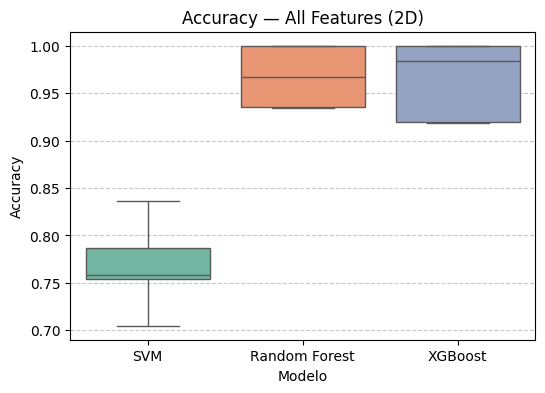


Métrica: Log Loss — ANOVA p = 0.0000
→ Diferença significativa encontrada!
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
    group1     group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------------
Random Forest     SVM   0.3681    0.0  0.2444  0.4918   True
Random Forest XGBoost   0.0092 0.9787 -0.1145  0.1329  False
          SVM XGBoost  -0.3589    0.0 -0.4826 -0.2353   True
------------------------------------------------------------
✅ Melhor modelo para Log Loss: Random Forest


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\2192756408.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Modelo", y="Valor", palette="Set2")


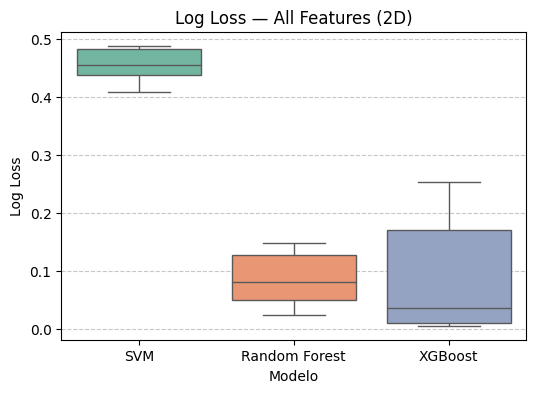


Resumo — All Features:
  Accuracy: Random Forest
  Log Loss: Random Forest

=== Método de Feature Selection: Feature Selection ===

Métrica: Accuracy — ANOVA p = 0.1081
✅ Melhor modelo para Accuracy: Random Forest


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\2192756408.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Modelo", y="Valor", palette="Set2")


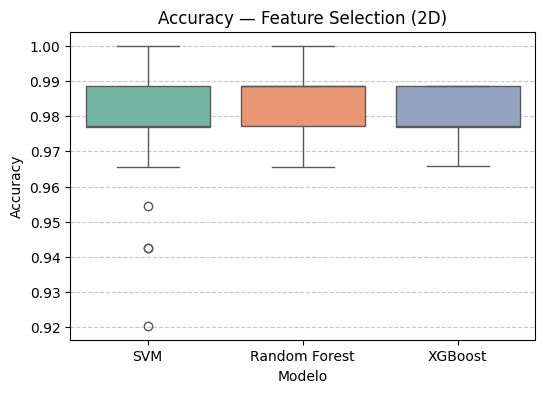


Métrica: Log Loss — ANOVA p = 0.2826
✅ Melhor modelo para Log Loss: XGBoost


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\2192756408.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Modelo", y="Valor", palette="Set2")


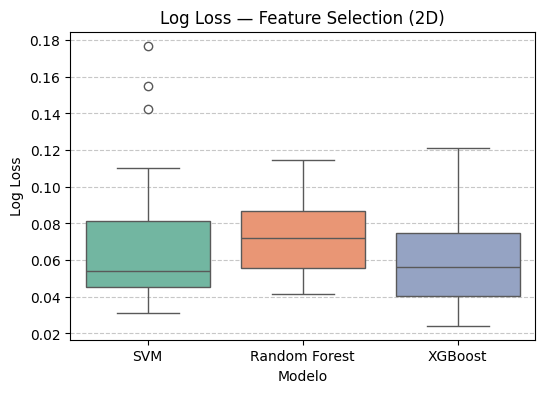


Resumo — Feature Selection:
  Accuracy: Random Forest
  Log Loss: XGBoost

===== ANÁLISE DE MODELOS POR MÉTODO (3D) =====


=== Método de Feature Selection: All Features ===

Métrica: Accuracy — ANOVA p = 0.0000
→ Diferença significativa encontrada!
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
    group1     group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------------
Random Forest     SVM  -0.1897 0.0001 -0.2669 -0.1125   True
Random Forest XGBoost      0.0    1.0 -0.0772  0.0772  False
          SVM XGBoost   0.1897 0.0001  0.1125  0.2669   True
------------------------------------------------------------
✅ Melhor modelo para Accuracy: Random Forest


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\2192756408.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Modelo", y="Valor", palette="Set2")


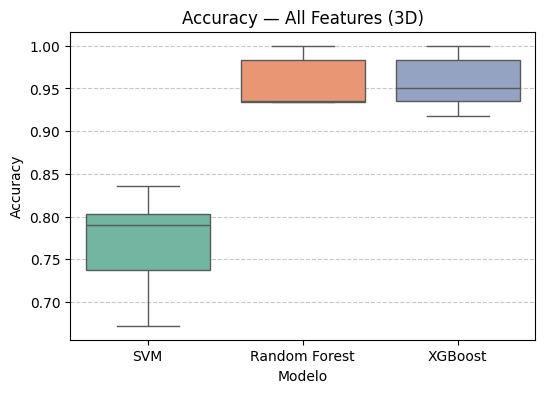


Métrica: Log Loss — ANOVA p = 0.0000
→ Diferença significativa encontrada!
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
    group1     group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------------
Random Forest     SVM   0.4033    0.0  0.2692  0.5374   True
Random Forest XGBoost   0.0374 0.7432 -0.0967  0.1715  False
          SVM XGBoost   -0.366    0.0    -0.5 -0.2319   True
------------------------------------------------------------
✅ Melhor modelo para Log Loss: Random Forest


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\2192756408.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Modelo", y="Valor", palette="Set2")


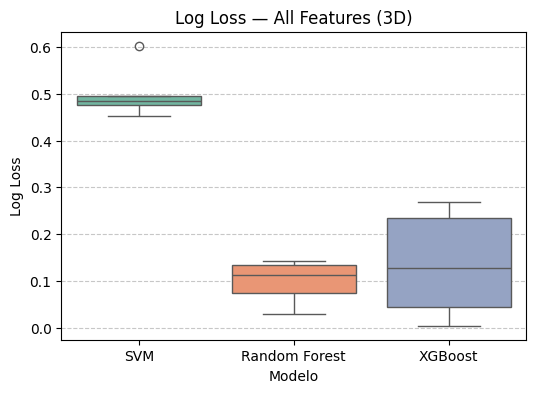


Resumo — All Features:
  Accuracy: Random Forest
  Log Loss: Random Forest

=== Método de Feature Selection: Feature Selection ===

Métrica: Accuracy — ANOVA p = 0.4290
✅ Melhor modelo para Accuracy: XGBoost


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\2192756408.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Modelo", y="Valor", palette="Set2")


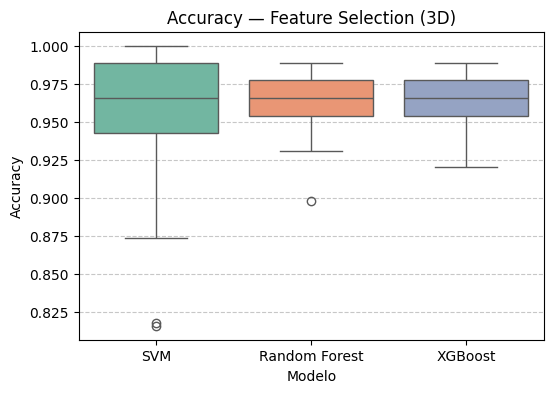


Métrica: Log Loss — ANOVA p = 0.5369
✅ Melhor modelo para Log Loss: XGBoost


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\2192756408.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Modelo", y="Valor", palette="Set2")


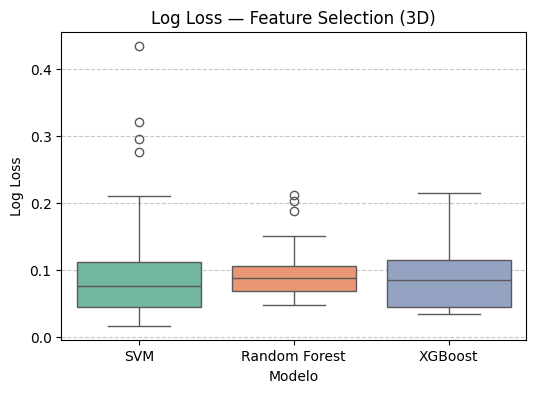


Resumo — Feature Selection:
  Accuracy: XGBoost
  Log Loss: XGBoost


In [143]:
# Comparar modelos dentro de cada método
comparar_modelos_por_metodo(all_results_2d, "2D")
comparar_modelos_por_metodo(all_results_3d, "3D")

## Conclusões:

## 1. 2D - Comparação de Modelos por Métodos

+ ### All Features (sem seleção de features):

    - ANOVA p = 0.0000 → diferenças significativas entre os modelos.

    - Tukey:
        + Random Forest vs SVM → diferença significativa (p < 0.05)
        + Random Forest vs XGBoost → sem diferença significativa
        + SVM vs XGBoost → diferença significativa
    
    #### Conclusão: O Random Forest tem desempenho estatisticamente superior ao SVM e equivalente ao XGBoost, tanto em Accuracy como em Log Loss. Isso indica que o RF consegue capturar bem as relações não lineares entre as features radiômicas 2D sem precisar de seleção de variáveis.

+ ### Feature Selection

    - ANOVA não significativa (p ≈ 0.1 e 0.28) → nenhuma diferença estatística clara entre os modelos.

    - Mesmo assim, a média aponta:
        + Accuracy: Random Forest
        + Log Loss: XGBoost
    
    #### Conclusão: Com seleção de features, o ganho de performance se estabiliza entre os modelos — o reduzido número de variáveis pode ter nivelado o campo. O Random Forest ainda mantém ligeira vantagem em Accuracy, mas o XGBoost melhora a Log Loss, mostrando melhor calibração probabilística.

## 2. 3D - Comparação de Modelos por Métodos

   + ### All Features (sem seleção de features):

     - ANOVA p = 0.0000 → diferenças significativas.

     - Tukey:
         + Random Forest > SVM (p < 0.05)
         + Random Forest ≈ XGBoost (sem diferença)
         + SVM < XGBoost (p < 0.05)

     #### Conclusão: Tal como no 2D, o Random Forest mantém-se o modelo mais forte. O XGBoost tem desempenho semelhante (não significativamente pior), enquanto o SVM é claramente o mais fraco.

   + ### Feature Selection:

     - ANOVA p > 0.4 (sem significância).

     - Médias: XGBoost ligeiramente melhor em ambas as métricas.

     #### Conclusão: Em 3D, quando se aplica seleção de features, o XGBoost supera o RF em desempenho médio, mas sem diferença estatística relevante. Isso sugere que o XGBoost se beneficia de conjuntos de features mais “limpos” e reduzidos, otimizando a aprendizagem em profundidade.

## 11.3. Comparação entre Métodos por Modelo <a name = "metodos_p_modelo"></a>
[Voltar a Comparação de Modelos e Conjuntos de Features](#comparaçao)

#### Objetivo: Determinar qual método de seleção de features é mais eficaz para cada modelo individual.

1. Agrupámos os resultados por modelo e métrica.
2. Realizámos ANOVA e, se necessário, Tukey HSD para comparar os métodos.
3. Visualizamos com boxplots, comparando o desempenho de cada método dentro de um mesmo modelo.

#### O que esperar dos resultados:

- Identificação do método de seleção que maximiza o desempenho de cada modelo.
- Possibilidade de observar se usar all features é competitivo ou se a seleção de features melhora o resultado.

In [133]:
def comparar_metodos_por_modelo(df, dimension, metricas=None, plot=True):
    if metricas is None:
        metricas = ["Accuracy", "Log Loss"]
    
    modelos = df["Modelo"].unique()
    print(f"\n===== ANÁLISE ENTRE MÉTODOS POR MODELO ({dimension}) =====\n")
    
    for modelo in modelos:
        print(f"\n=== Modelo: {modelo} ===")
        melhores_metodos = {}
        
        for metrica in metricas:
            subset = df[(df["Métrica"]==metrica) & (df["Modelo"]==modelo)]
            if subset.empty:
                print(f"⚠️ Sem dados para {metrica}.")
                continue
            
            metodos = subset["Método"].unique()
            grupos = [subset.loc[subset["Método"]==m,"Valor"].values for m in metodos]
            
            # ANOVA
            f_stat, p_val = stats.f_oneway(*grupos)
            print(f"\nMétrica: {metrica} — ANOVA p = {p_val:.4f}")
            if p_val < 0.05:
                print("→ Diferença significativa encontrada!")
                tukey = pairwise_tukeyhsd(subset["Valor"], subset["Método"], alpha=0.05)
                print(tukey)
            
            # Melhor método
            medias = subset.groupby("Método")["Valor"].mean()
            melhor = medias.idxmin() if metrica.lower() == "log loss" else medias.idxmax()
            melhores_metodos[metrica] = melhor
            print(f"✅ Melhor método para {metrica}: {melhor}")
            
            # Plot
            if plot:
                plt.figure(figsize=(6,4))
                sns.boxplot(data=subset, x="Método", y="Valor", palette="Set3")
                plt.title(f"{metrica} — {modelo} ({dimension})")
                plt.ylabel(metrica)
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.show()
        
        # Resumo
        print(f"\nResumo — {modelo}:")
        for metrica, metodo in melhores_metodos.items():
            print(f"  {metrica}: {metodo}")


===== ANÁLISE ENTRE MÉTODOS POR MODELO (2D) =====


=== Modelo: SVM ===

Métrica: Accuracy — ANOVA p = 0.0000
→ Diferença significativa encontrada!
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1          group2      meandiff p-adj lower  upper  reject
------------------------------------------------------------------
All Features Feature Selection   0.2069   0.0 0.1819 0.2318   True
------------------------------------------------------------------
✅ Melhor método para Accuracy: Feature Selection


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\4286130849.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Método", y="Valor", palette="Set3")


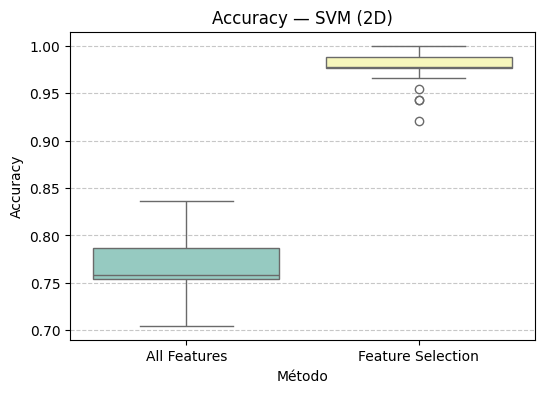


Métrica: Log Loss — ANOVA p = 0.0000
→ Diferença significativa encontrada!
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
   group1          group2      meandiff p-adj  lower   upper  reject
--------------------------------------------------------------------
All Features Feature Selection   -0.384   0.0 -0.4226 -0.3454   True
--------------------------------------------------------------------
✅ Melhor método para Log Loss: Feature Selection


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\4286130849.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Método", y="Valor", palette="Set3")


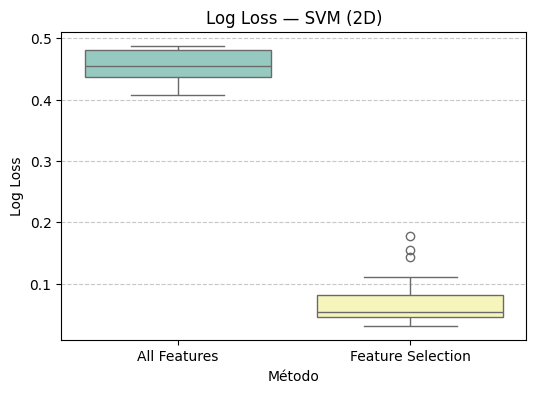


Resumo — SVM:
  Accuracy: Feature Selection
  Log Loss: Feature Selection

=== Modelo: Random Forest ===

Métrica: Accuracy — ANOVA p = 0.0000
→ Diferença significativa encontrada!
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1          group2      meandiff p-adj lower upper  reject
-----------------------------------------------------------------
All Features Feature Selection   0.2142   0.0 0.194 0.2344   True
-----------------------------------------------------------------
✅ Melhor método para Accuracy: Feature Selection


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\4286130849.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Método", y="Valor", palette="Set3")


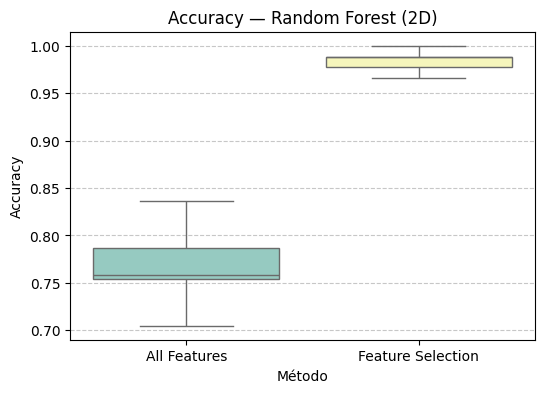


Métrica: Log Loss — ANOVA p = 0.0000
→ Diferença significativa encontrada!
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
   group1          group2      meandiff p-adj  lower   upper  reject
--------------------------------------------------------------------
All Features Feature Selection  -0.3825   0.0 -0.4043 -0.3608   True
--------------------------------------------------------------------
✅ Melhor método para Log Loss: Feature Selection


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\4286130849.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Método", y="Valor", palette="Set3")


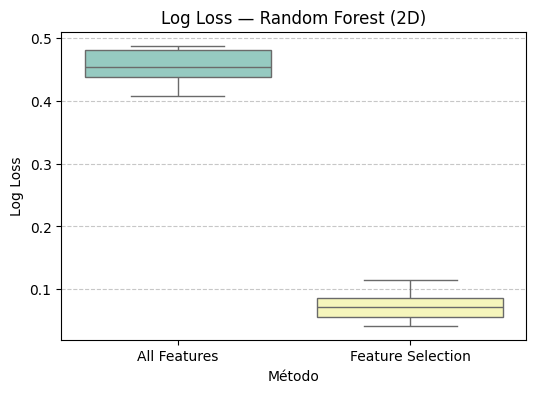


Resumo — Random Forest:
  Accuracy: Feature Selection
  Log Loss: Feature Selection

=== Modelo: XGBoost ===

Métrica: Accuracy — ANOVA p = 0.0660
✅ Melhor método para Accuracy: Feature Selection


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\4286130849.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Método", y="Valor", palette="Set3")


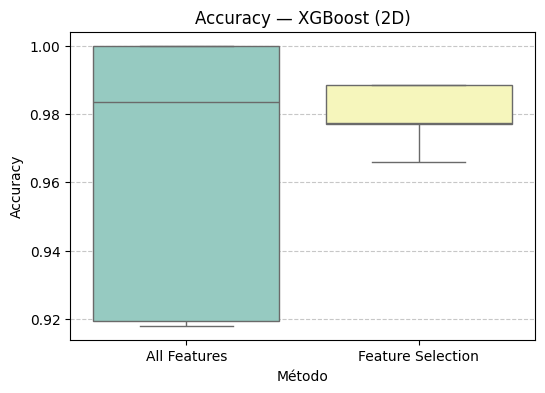


Métrica: Log Loss — ANOVA p = 0.1409
✅ Melhor método para Log Loss: Feature Selection


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\4286130849.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Método", y="Valor", palette="Set3")


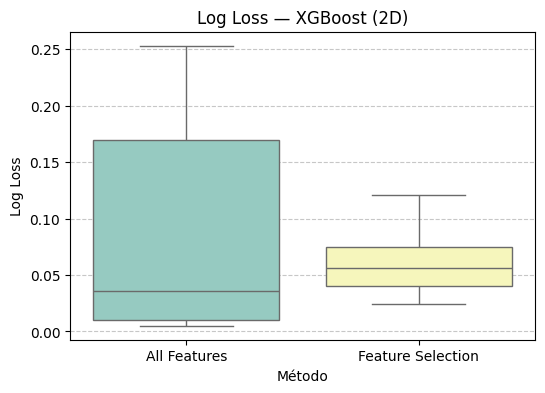


Resumo — XGBoost:
  Accuracy: Feature Selection
  Log Loss: Feature Selection

===== ANÁLISE ENTRE MÉTODOS POR MODELO (3D) =====


=== Modelo: SVM ===

Métrica: Accuracy — ANOVA p = 0.0000
→ Diferença significativa encontrada!
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1          group2      meandiff p-adj lower  upper  reject
------------------------------------------------------------------
All Features Feature Selection   0.1841   0.0 0.1299 0.2383   True
------------------------------------------------------------------
✅ Melhor método para Accuracy: Feature Selection


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\4286130849.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Método", y="Valor", palette="Set3")


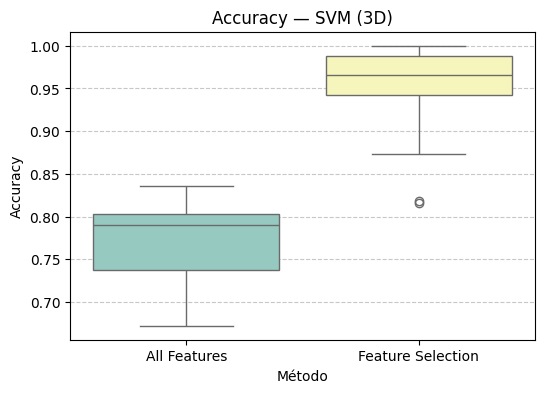


Métrica: Log Loss — ANOVA p = 0.0000
→ Diferença significativa encontrada!
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1          group2      meandiff p-adj  lower  upper  reject
-------------------------------------------------------------------
All Features Feature Selection  -0.3865   0.0 -0.4889 -0.284   True
-------------------------------------------------------------------
✅ Melhor método para Log Loss: Feature Selection


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\4286130849.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Método", y="Valor", palette="Set3")


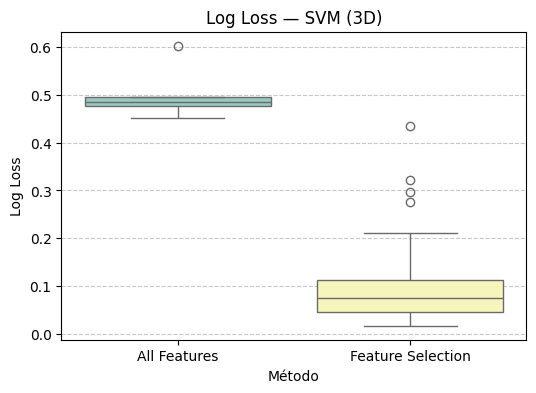


Resumo — SVM:
  Accuracy: Feature Selection
  Log Loss: Feature Selection

=== Modelo: Random Forest ===

Métrica: Accuracy — ANOVA p = 0.0000
→ Diferença significativa encontrada!
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1          group2      meandiff p-adj lower upper  reject
-----------------------------------------------------------------
All Features Feature Selection   0.1937   0.0 0.163 0.2245   True
-----------------------------------------------------------------
✅ Melhor método para Accuracy: Feature Selection


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\4286130849.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Método", y="Valor", palette="Set3")


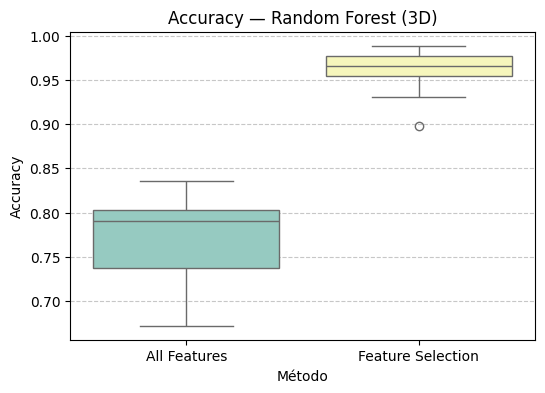


Métrica: Log Loss — ANOVA p = 0.0000
→ Diferença significativa encontrada!
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
   group1          group2      meandiff p-adj  lower   upper  reject
--------------------------------------------------------------------
All Features Feature Selection  -0.4027   0.0 -0.4504 -0.3551   True
--------------------------------------------------------------------
✅ Melhor método para Log Loss: Feature Selection


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\4286130849.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Método", y="Valor", palette="Set3")


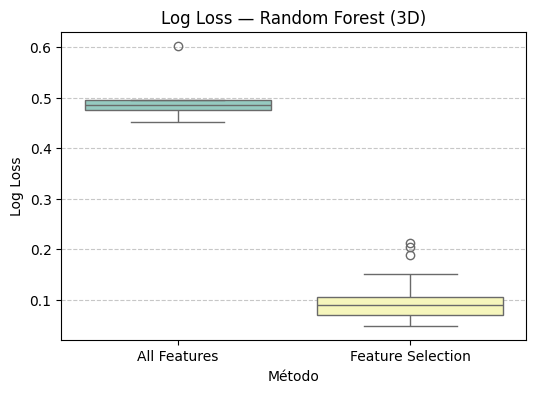

C:\Users\catar\AppData\Local\Temp\ipykernel_23952\4286130849.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Método", y="Valor", palette="Set3")



Resumo — Random Forest:
  Accuracy: Feature Selection
  Log Loss: Feature Selection

=== Modelo: XGBoost ===

Métrica: Accuracy — ANOVA p = 0.5602
✅ Melhor método para Accuracy: Feature Selection


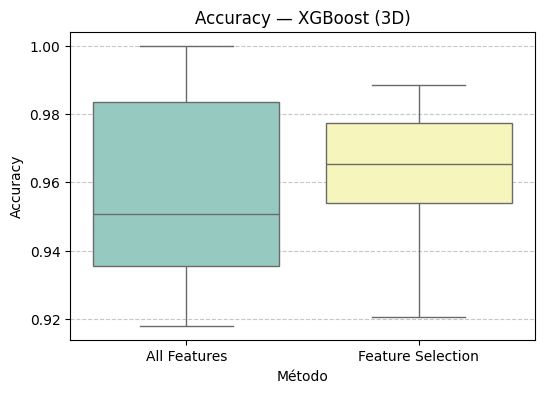


Métrica: Log Loss — ANOVA p = 0.1874
✅ Melhor método para Log Loss: Feature Selection


C:\Users\catar\AppData\Local\Temp\ipykernel_23952\4286130849.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="Método", y="Valor", palette="Set3")


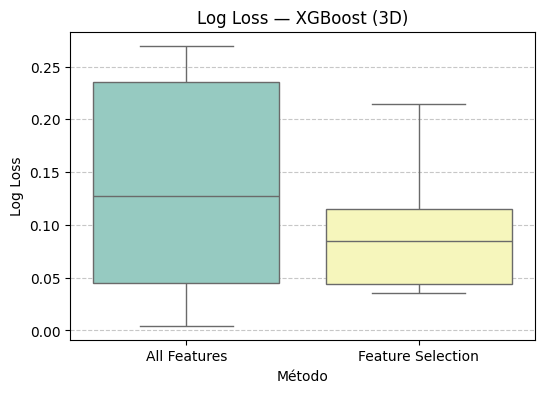


Resumo — XGBoost:
  Accuracy: Feature Selection
  Log Loss: Feature Selection


In [134]:
# Comparar métodos dentro de cada modelo
comparar_metodos_por_modelo(all_results_2d, "2D")
comparar_metodos_por_modelo(all_results_3d, "3D")

## Conclusões:

## 1. 2D — Comparação de métodos por modelo

+ ### SVM:

    - Accuracy: ANOVA p = 0 → diferença significativa
    - Tukey HSD: Feature Selection é melhor que All Features (+0.2069)
    - Log Loss: ANOVA p = 0 → diferença significativa
    - Tukey HSD: Feature Selection é melhor (-0.384)

    #### Conclusão: Para SVM 2D, usar Feature Selection melhora significativamente o desempenho tanto em Accuracy quanto em Log Loss.

+ ### Random Forest:

    - Accuracy: ANOVA p = 0 → diferença significativa
    - Tukey HSD: Feature Selection é melhor (+0.2142)
    - Log Loss: ANOVA p = 0 → diferença significativa
    - Tukey HSD: Feature Selection é melhor (-0.3825)

    #### Conclusão: Random Forest 2D também se beneficia bastante de Feature Selection.

+ ### XGBoost:

    - Accuracy: ANOVA p = 0.066 → diferença não significativa
    - Log Loss: ANOVA p = 0.1409 → diferença não significativa

    #### Conclusão: Para XGBoost, não há diferença estatisticamente significativa entre usar todas as features ou fazer Feature Selection, embora a média favoreça Feature Selection ligeiramente.

## 2. 3D — Comparação de métodos por modelo

+ ### SVM

   -  Accuracy: ANOVA p = 0 → diferença significativa
    - Feature Selection melhor (+0.1841)
    - Log Loss: ANOVA p = 0 → diferença significativa
    - Feature Selection melhor (-0.3865)

    #### Conclusão: Feature Selection é claramente melhor para SVM 3D.

+ ### Random Forest

    - Accuracy: ANOVA p = 0 → diferença significativa
    - Feature Selection melhor (+0.1937)
    - Log Loss: ANOVA p = 0 → diferença significativa
    - Feature Selection melhor (-0.4027)

    #### Conclusão: Random Forest 3D também se beneficia significativamente de Feature Selection.

+ ### XGBoost

   -  Accuracy: ANOVA p = 0.560 → diferença não significativa
    - Log Loss: ANOVA p = 0.187 → diferença não significativa

    #### Conclusão: Para XGBoost 3D, não há impacto estatisticamente relevante do método de seleção de features.

## 11.4. Comparação entre 2D e 3D  <a name = "2d_vs_3d"></a>
[Voltar a Comparação de Modelos e Conjuntos de Features](#comparaçao)

#### Objetivo: Avaliar se existe diferença significativa no desempenho dos modelos quando se usam dados 2D ou 3D.

1. Para cada modelo, método e métrica, realizámos t-test pareado entre os valores obtidos com 2D e 3D.
2. Visualizamos com scatterplots, mostrando a distribuição de resultados para 2D e 3D lado a lado.

#### O que esperar dos resultados:

- Identificação de métricas ou combinações modelo-método onde a dimensão dos dados influencia o desempenho.
- Auxílio na escolha da dimensão mais adequada para futuras análises e modelos.

In [135]:
def comparar_2d_vs_3d(df_2d, df_3d, metricas=None, plot=True):
    if metricas is None:
        metricas = ["Accuracy", "Log Loss"]
    
    modelos = df_2d["Modelo"].unique()
    metodos = df_2d["Método"].unique()
    
    print("\n===== COMPARAÇÃO ENTRE 2D E 3D =====\n")
    
    for modelo in modelos:
        for metodo in metodos:
            for metrica in metricas:
                val_2d = df_2d[(df_2d["Modelo"]==modelo) & (df_2d["Método"]==metodo) & (df_2d["Métrica"]==metrica)]["Valor"].values
                val_3d = df_3d[(df_3d["Modelo"]==modelo) & (df_3d["Método"]==metodo) & (df_3d["Métrica"]==metrica)]["Valor"].values
                
                if len(val_2d)==0 or len(val_3d)==0:
                    continue
                
                t_stat, p_val = stats.ttest_rel(val_2d, val_3d)
                melhor = "2D" if np.mean(val_2d) > np.mean(val_3d) else "3D"
                
                print(f"{modelo} — {metodo} — {metrica}: p={p_val:.4f}", end=" ")
                if p_val < 0.05:
                    print(f"→ Diferença significativa ({melhor} melhor)")
                else:
                    print("→ Sem diferença significativa")
                
                # Plot
                if plot:
                    plt.figure(figsize=(5,5))
                    plt.scatter([1]*len(val_2d), val_2d, color='blue', alpha=0.6, label='2D')
                    plt.scatter([2]*len(val_3d), val_3d, color='red', alpha=0.6, label='3D')
                    plt.xticks([1,2], ['2D','3D'])
                    plt.title(f"{modelo} — {metodo} — {metrica}")
                    plt.ylabel(metrica)
                    plt.legend()
                    plt.grid(True, linestyle='--', alpha=0.7)
                    plt.show()


===== COMPARAÇÃO ENTRE 2D E 3D =====

SVM — All Features — Accuracy: p=0.9977 → Sem diferença significativa


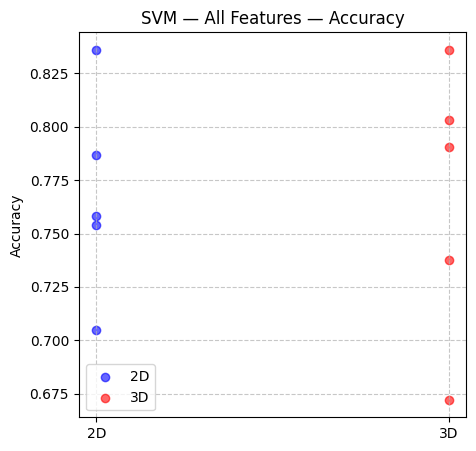

SVM — All Features — Log Loss: p=0.1136 → Sem diferença significativa


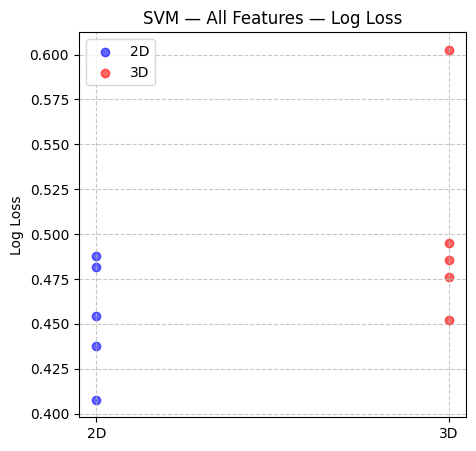

SVM — Feature Selection — Accuracy: p=0.0081 → Diferença significativa (2D melhor)


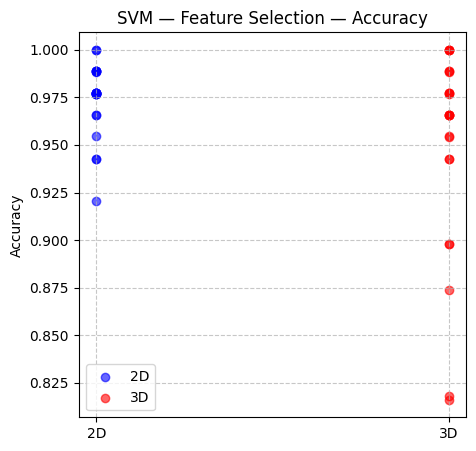

SVM — Feature Selection — Log Loss: p=0.0082 → Diferença significativa (3D melhor)


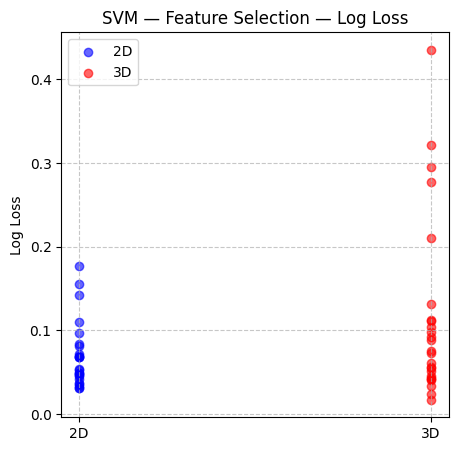

Random Forest — All Features — Accuracy: p=0.9977 → Sem diferença significativa


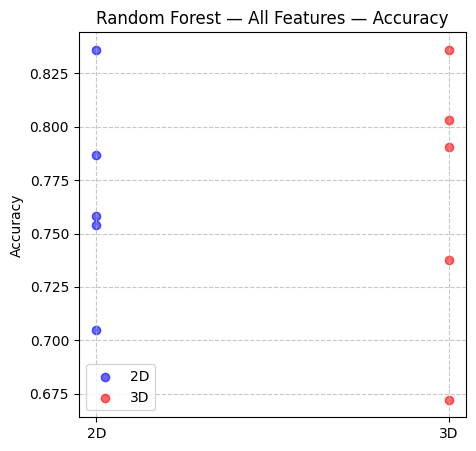

Random Forest — All Features — Log Loss: p=0.1136 → Sem diferença significativa


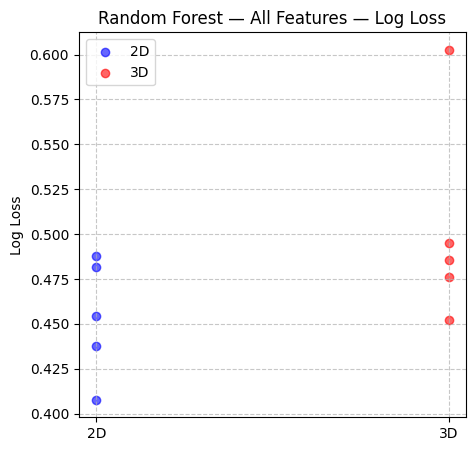

Random Forest — Feature Selection — Accuracy: p=0.0000 → Diferença significativa (2D melhor)


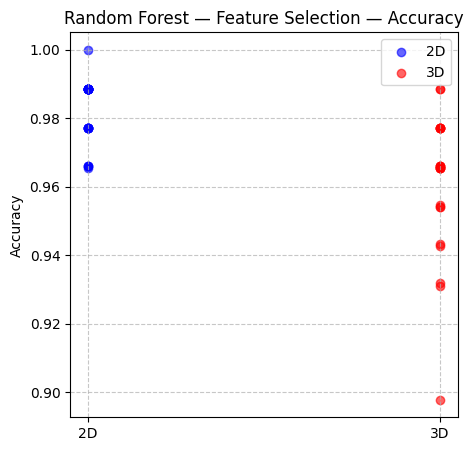

Random Forest — Feature Selection — Log Loss: p=0.0012 → Diferença significativa (3D melhor)


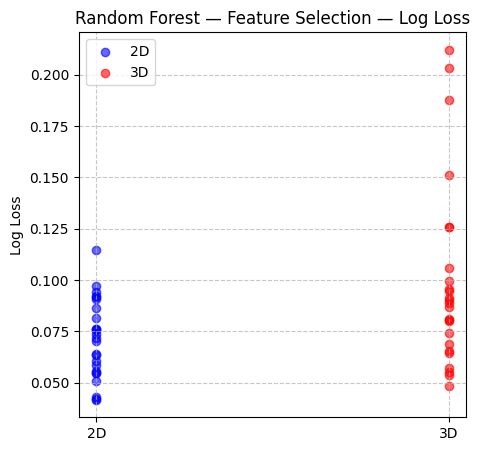

XGBoost — All Features — Accuracy: p=0.5833 → Sem diferença significativa


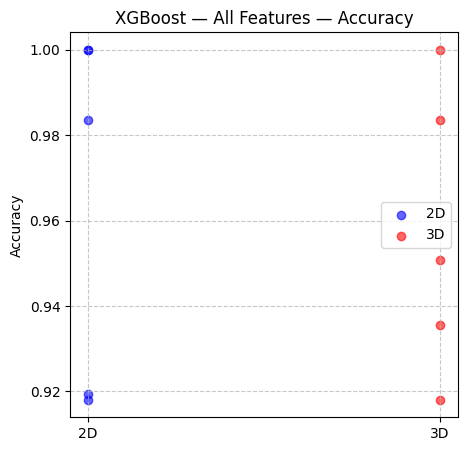

XGBoost — All Features — Log Loss: p=0.1319 → Sem diferença significativa


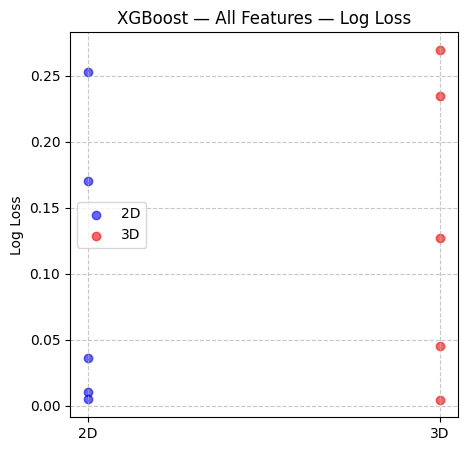

XGBoost — Feature Selection — Accuracy: p=0.0000 → Diferença significativa (2D melhor)


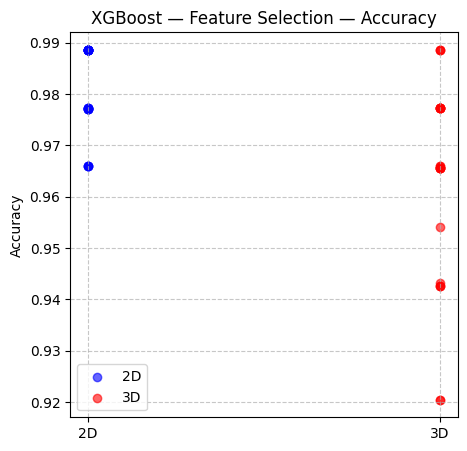

XGBoost — Feature Selection — Log Loss: p=0.0016 → Diferença significativa (3D melhor)


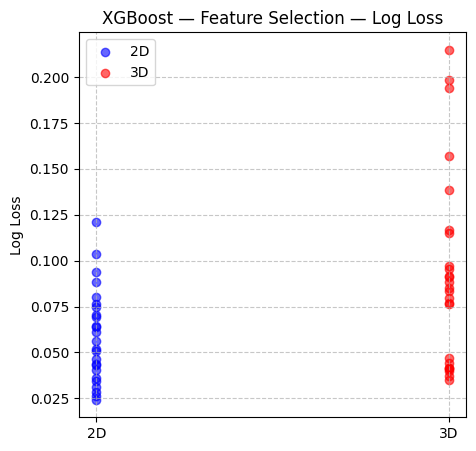

In [136]:
# Comparar 2D vs 3D (paired t-test)
comparar_2d_vs_3d(all_results_2d, all_results_3d)

## Conclusões de Desempenho 2D vs 3D

+ ### All Features:

    - Nenhum modelo se beneficia significativamente de 3D vs 2D.
    - XGBoost, SVM e Random Forest são robustos a dimensão dos dados quando usamos todas as features.

+ ### Feature Selection:

    - Há diferenças significativas, mas com trade-offs:
    - Accuracy melhor em 2D
    - Log Loss melhor em 3D
    - Isso sugere que 3D ajuda na calibragem de probabilidades (refletido no Log Loss), mas 2D mantém maior taxa de acerto.

### Padrão consistente para todos os modelos:

#### Feature Selection cria vantagens diferentes dependendo da métrica: escolha da dimensão depende se quer priorizar acerto bruto (Accuracy) ou qualidade da previsão probabilística (Log Loss).

# 12. Conclusões Finais <a name = "conclusao"></a>
[Voltar ao Índice](#indice)

#### De forma geral, os modelos testados (SVM, Random Forest e XGBoost) apresentam desempenho elevado e consistente neste conjunto de dados.

#### A aplicação de Feature Selection mostra-se útil para estabilizar ou melhorar certas métricas, embora seu impacto varie dependendo do modelo e da métrica considerada.

#### Comparando as dimensões dos dados, os resultados indicam que 2D e 3D fornecem desempenhos semelhantes na maioria dos casos, com diferenças relevantes apenas em situações específicas. 

#### No conjunto, o desempenho final depende mais da escolha do modelo e da métrica de avaliação do que da dimensão ou do método de seleção de features, permitindo flexibilidade na escolha conforme o objetivo da análise.

#### Em conclusão, este estudo reforça a importância de avaliar rigorosamente combinações de modelo e pré-processamento, permitindo selecionar a abordagem mais adequada ao objetivo específico da análise ou do problema em questão.
<br>

#### Para além da avaliação técnica, este estudo considera também a aplicabilidade prática das soluções propostas, nomeadamente no contexto hospitalar e clínico. A utilização de modelos mais enxutos — ou seja, com menos variáveis e menor complexidade computacional — pode facilitar a integração em sistemas de apoio à decisão médica, reduzindo o tempo de resposta e os recursos necessários para cada análise. Isto é particularmente relevante em ambientes com elevada carga de exames ou com infraestruturas limitadas, onde a rapidez e a fiabilidade da triagem são cruciais.
#### Adicionalmente, modelos mais simples tendem a ser mais interpretáveis, o que permite aos profissionais de saúde compreender e confiar nas recomendações geradas, promovendo uma adoção mais eficaz da tecnologia. A escolha entre representações 2D e 3D, bem como a aplicação de técnicas de Feature Selection, deve ser orientada não apenas por métricas de desempenho, mas também pela viabilidade operacional e pelo impacto direto na rotina clínica. Assim, este trabalho procura não só otimizar a performance algorítmica, mas também garantir que as soluções desenvolvidas são compatíveis com os objetivos e limitações do setor da saúde, contribuindo para diagnósticos mais precoces, decisões mais informadas e, potencialmente, melhores desfechos para os pacientes.

# 13. Referências <a name = "referencias"></a>
[Voltar ao Índice](#indice)

[LLZ18] <a name = "LLZ18">  Lu Liu, Yapeng Liu, and Hongyuan Zhao. Benign and malignant solitary pulmonary nod
ules classification based on CNN and SVM. In ACM International Conference Proceeding
 Series, 2018.

[XZX+18] <a name = "XZX+18"> Yutong Xie, Jianpeng Zhang, Yong Xia, Michael Fulham, and Yanning Zhang. Fus-
ing texture, shape and deep model-learned information at decision level for automated
classification of lung nodules on chest CT. Information Fusion, 2018.

[Tor23] <a name = "Tor23"> https://easychair.org/publications/preprint/x1bJT

[PCA] <a name = "pca_ref"> https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch18.pdf

[CBMLN] <a name = "CBMLN"> https://www.researchgate.net/publication/355690036_Classification_of_Benign_and_Malignant_Lung_Nodules_Based_on_Deep_Convolutional_Network_Feature_Extraction

[PSO] <a name = "PSO"> https://ieeexplore.ieee.org/document/8940822

[DCLC] <a name = "DCLC"> https://iopscience.iop.org/article/10.1088/1742-6596/2286/1/012011/pdf

[LG18] <a name = "LG18"> Bak SH Lee HY Lee G, Park H. Radiomics in Lung Cancer from Basic to Advanced:
 Current Status and Future Directions. Korean J Radiol, 2018.